In [2]:
import streamlit as st
from streamlit_jupyter import StreamlitPatcher, tqdm
%matplotlib inline

StreamlitPatcher().jupyter()  # register streamlit with jupyter-compatible wrappers

In [3]:
import pandas as pd
import numpy as np
import psycopg2
import calendar
import datetime
from datetime import date, datetime
import unicodedata
import plotly.graph_objects as go
from IPython.display import display
from io import BytesIO
import os
%load_ext sql

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import plotly.express as px
# Theme
sns.set_theme()

# Geo information
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from time import sleep
import json
import requests

#Modelo 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, f1_score
)
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

#### Acc realizados con cita de afiliados
Esto implica que solo haya información relacionada con:
* Weight
* Height
* IMC
* IMM
* Fat_percentage
* Muscle_mass_percentage
* Abdominal_perimeter
* FCR
* FCM
* TAD
* TAS
* Diagnósticos
* Aptitud
* Riesgos de la encuesta: Tabaquismo, edad, Género, Hipertensión, sedentarismo, etc, Enfermedad cardiovascular, Enfermedad Pulmonar, Enfermedad Renal, etc.

In [4]:
#Consulta principal de Acc
# query = '''
# select 
# mfpe.user_id, 
# cast(mfpe.created_at as date) as date_acc,
# CASE 
#     WHEN mh.mode_height IS NULL THEN NULL
#     WHEN mh.mode_height = 0 THEN NULL
#     WHEN mh.mode_height < 1.20 OR mh.mode_height > 2.10 THEN NULL
#     WHEN LENGTH(REGEXP_REPLACE(TO_CHAR(mh.mode_height, 'FM99.00'), '^0+', '')) > 6 THEN NULL
#     ELSE ROUND(mh.mode_height, 2)
#   END AS height,
#   CASE 
#     WHEN mfpe.imc IS NULL THEN NULL
#     WHEN mfpe.imc = 0 THEN NULL
#     WHEN mfpe.imc < 14 OR mfpe.imc > 55 THEN NULL
#     WHEN LENGTH(REGEXP_REPLACE(TO_CHAR(mfpe.imc, 'FM99.00'), '^0+', '')) > 6 THEN NULL
#     ELSE ROUND(mfpe.imc, 2)
#   END AS imc,
#   CASE 
#     WHEN mfpe.imm IS NULL THEN NULL
#     WHEN mfpe.imm = 0 THEN NULL
#     WHEN mfpe.imm < 3.89 OR mfpe.imm > 20 THEN NULL
#     WHEN LENGTH(REGEXP_REPLACE(TO_CHAR(mfpe.imm, 'FM99.00'), '^0+', '')) > 6 THEN NULL
#     ELSE ROUND(mfpe.imm, 2)
#   END AS imm,
#   CASE 
#     WHEN mfpe.fat_percentage IS NULL THEN NULL
#     WHEN mfpe.fat_percentage = 0 THEN NULL
#     WHEN mfpe.fat_percentage < 2 OR mfpe.fat_percentage > 50 THEN NULL
#     WHEN LENGTH(REGEXP_REPLACE(TO_CHAR(mfpe.fat_percentage, 'FM99.00'), '^0+', '')) > 6 THEN NULL
#     ELSE ROUND(mfpe.fat_percentage, 2)
#   END AS fat_percentage,
#   CASE 
#     WHEN mfpe.muscle_mass_percentage IS NULL THEN NULL
#     WHEN mfpe.muscle_mass_percentage = 0 THEN NULL
#     WHEN mfpe.muscle_mass_percentage < 10 OR mfpe.muscle_mass_percentage > 60 THEN NULL
#     WHEN LENGTH(REGEXP_REPLACE(TO_CHAR(mfpe.muscle_mass_percentage, 'FM99.00'), '^0+', '')) > 6 THEN NULL
#     ELSE ROUND(mfpe.muscle_mass_percentage, 2)
#   END AS muscle_mass_percentage,
#   CASE 
#     WHEN mfpe.abdominal_perimeter IS NULL THEN NULL
#     WHEN mfpe.abdominal_perimeter = 0 THEN NULL
#     WHEN mfpe.abdominal_perimeter < 50 OR mfpe.abdominal_perimeter > 155 THEN NULL
#     WHEN LENGTH(REGEXP_REPLACE(TO_CHAR(mfpe.abdominal_perimeter, 'FM99.00'), '^0+', '')) > 6 THEN NULL
#     ELSE ROUND(mfpe.abdominal_perimeter, 2)
#   END AS abdominal_perimeter,
#   CASE 
#     WHEN mfpe.weight IS NULL THEN NULL
#     WHEN mfpe.weight = 0 then NULL
#     WHEN mfpe.weight < 35 OR mfpe.weight > 199 THEN NULL
#     WHEN LENGTH(REGEXP_REPLACE(TO_CHAR(mfpe.weight, 'FM99.00'), '^0+', '')) > 6 THEN NULL
#     ELSE ROUND(mfpe.weight, 2)
#   END AS weight,
# case
#     	when (m.genre = ''or m.genre is null) then 'Sin Información'
#     	else initcap(m.genre)
#     end as genre, 
# coalesce(extract(year from current_date::date) - extract(year from coalesce(coalesce(m.birthdate,mfbi.date_birth), cl.birth_date)),0) as edad,
# coalesce(coalesce(m.birthdate,mfbi.date_birth), cl.birth_date) as birthdate,
# case 
# 	WHEN mfpe2.fcr IS NULL THEN NULL
# 	when LENGTH(REGEXP_REPLACE(REPLACE(TRIM(mfpe2.fcr), '|', ''), '[0-9]', '')) = 0 
# 	then 
# 	case when cast(nullif(REPLACE(TRIM(mfpe2.fcr), '|', ''), '') as numeric) < 40 or cast(nullif(REPLACE(TRIM(mfpe2.fcr), '|', ''), '') as numeric) > 150
# 		then 0
# 		else cast(nullif(REPLACE(TRIM(mfpe2.fcr), '|', ''), '') as numeric)
# 		end
# 	else 0
# end as frecu_card_repos,
# case 
# 	WHEN mfpe2.tas IS NULL THEN NULL
# 	when LENGTH(REGEXP_REPLACE(REPLACE(TRIM(mfpe2.fcm), '|', ''), '[0-9]', '')) = 0 
# 	then 
# 	case when cast(nullif(REPLACE(TRIM(mfpe2.fcm), '|', ''), '') as numeric) < 62 or cast(nullif(REPLACE(TRIM(mfpe2.fcm), '|', ''), '') as numeric) > 201
# 		then 0
# 		else cast(nullif(REPLACE(TRIM(mfpe2.fcm), '|', ''), '') as numeric)
# 		end
# 	else 0
# end as frecu_card_max,
# case 
# 	WHEN mfpe2.tad IS NULL THEN NULL
# 	when LENGTH(REGEXP_REPLACE(REPLACE(TRIM(mfpe2.tad), '|', ''), '[0-9]', '')) = 0 
# 	then 
# 	case when cast(nullif(REPLACE(TRIM(mfpe2.tad), '|', ''), '') as numeric) < 40 or cast(nullif(REPLACE(TRIM(mfpe2.tad), '|', ''), '') as numeric) > 130
# 		then 0
# 		else cast(nullif(REPLACE(TRIM(mfpe2.tad), '|', ''), '') as numeric)
# 		end
# 	else 0
# end as Tension_arte_dias,
# case 
# 	WHEN mfpe2.tas IS NULL THEN NULL
# 	when LENGTH(REGEXP_REPLACE(REPLACE(TRIM(mfpe2.tas), '|', ''), '[0-9]', '')) = 0 
# 	then 
# 	case when cast(nullif(REPLACE(TRIM(mfpe2.tas), '|', ''), '') as numeric) < 80 or cast(nullif(REPLACE(TRIM(mfpe2.tas), '|', ''), '') as numeric) > 220
# 		then 0
# 		else cast(nullif(REPLACE(TRIM(mfpe2.tas), '|', ''), '') as numeric)
# 		end
# 	else 0
# end as Tension_arte_sis,
# coalesce(mfhc.state_pregnancy, 'Sin información') as state_pregnancy
# ,mfcr.questions as questions_risk_cardiov
# ,mfcr.risk as riesgo_cardiov
# ,mfsb.frecuency as frecuency_sport_actv
# ,mfsb.time_activity as time_sport_actv
# ,v.name as sede_uso
# ,c.name as ciudad
# ,cv.name as category_sede_uso
# ,r.name as region
# ,estadia.average_minute
# ,cds.name as sport_activity_intensity
# ,cds2.name as diagnostic_name_1
# ,cds2.name as diagnostic_name_2
# ,cds3."name" as family_history,
# q.id as quote_id,
# q.training_suitability as aptitud,
# q.date_hour as date_quote,
# q.status_quote,
# coalesce(coalesce(m.document_number, mfbi.document_number), cl.document_number) as document_number,
# coalesce(coalesce(dt.name, dt2.name), dt3.name) as document_number_type,
# u.profile as evaluador_acc
# from my_bodytech.medical_form_physical_evaluation mfpe
# join (WITH user_height_frequencies AS (
# 		  SELECT 
# 		    mfpe_h.user_id,
# 		    mfpe_h.height,
# 		    COUNT(*) AS frequency
# 		  FROM my_bodytech.medical_form_physical_evaluation mfpe_h
# 		  WHERE mfpe_h.height IS NOT NULL  
# 		  GROUP BY mfpe_h.user_id, mfpe_h.height
# 		),
# 		ranked_heights AS (
# 		  SELECT 
# 		    user_id,
# 		    height,
# 		    frequency,
# 		    ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY frequency DESC, height DESC) AS rank
# 		  FROM user_height_frequencies
# 		)
# 		SELECT 
# 		  user_id,
# 		  height AS mode_height
# 		FROM ranked_heights
# 		WHERE rank = 1) mh on mh.user_id = mfpe.user_id		
# join my_bodytech.quotes q on mfpe.quote_id = q.id
# join my_bodytech.medical_form_physical_exam mfpe2 on mfpe2.quotes_id = q.id
# join my_bodytech.medical_form_cardiovascular_risk mfcr on mfcr.quotes_id = q.id
# left join my_bodytech.medical_form_health_condition mfhc on mfhc.quotes_id = mfpe.quote_id
# left join my_bodytech.medical_form_sports_background mfsb on mfsb.quotes_id = q.id
# left join my_bodytech.custom_data_select cds on cds.id = mfsb.sport_activity 
# join my_bodytech.medical_form_intervention_procedure mfip on mfip.quotes_id = q.id
# join my_bodytech.custom_data_select cds2 on cds2.id = mfip.diagnostic_name_1
# left join my_bodytech.custom_data_select cds3 on cds3.id = mfip.diagnostic_name_2
# left join my_bodytech.custom_data_select cds4 on mfhc.pathological_antecedents  = cds4.id
# left join my_bodytech.medical_form_basic_information mfbi on mfbi.user_id = mfpe.user_id
# join my_bodytech.members m on m.id = mfpe.user_id
# left join my_bodytech.document_type dt on dt.id = m.document_type
# left join my_bodytech.document_type dt2 on dt2.id = mfbi.document_type_id
# left join my_bodytech.crm_leads cl on cl.id = mfpe.lead_id
# left join my_bodytech.document_type dt3 on dt3.id = cl.document_type_id 
# left join my_bodytech.users u on u.id = mfpe.user_creator
# left join (	select av.members_id,
# 			EXTRACT(YEAR FROM av.date),
# 			AVG(av.instance_minute) AS average_minute
# 			from my_bodytech.access_venue av
# 			WHERE
# 				av.members_id IS NOT NULL
# 				AND av.date >= DATEADD(month, -3, (SELECT MAX(date) FROM my_bodytech.access_venue))
# 			GROUP BY
# 				av.members_id,
# 				EXTRACT(YEAR FROM av.date)
# 			ORDER by av.members_id) estadia on estadia.members_id = mfpe.user_id 
# join (WITH accesos_por_sede AS (
# 		    SELECT 
# 		        av.members_id,
# 		        av.venue_id,
# 		        COUNT(*) AS conteo,
# 		        ROW_NUMBER() OVER (PARTITION BY av.members_id ORDER BY COUNT(*) DESC) AS rn
# 		    FROM my_bodytech.access_venue av
# 		    GROUP BY av.members_id, av.venue_id
# 		)
# 		SELECT 
# 		    members_id,
# 		    venue_id,
# 		    conteo
# 		FROM accesos_por_sede
# 		WHERE rn = 1) venue_mas_accesos on venue_mas_accesos.members_id = mfpe.user_id
# join my_bodytech.venue v on v.id = venue_mas_accesos.venue_id
# join my_bodytech.category_venue cv on cv.id = v.id_category
# join my_bodytech.region r on r.id = v.region_id
# join my_bodytech.city c on c.id = v.id_city
# where mfpe.id in (select max(mfpe3.id)
# 				from my_bodytech.medical_form_physical_evaluation mfpe3
# 				group by (mfpe3.created_at - interval '5:00:00')::date, mfpe3.user_id)
# AND (q.status_quote IN ('started', 'system_terminated', 'finished') or q.status_quote is null)
# and (mfcr.id in (select max(mfcr2.id)
# 				from my_bodytech.medical_form_cardiovascular_risk mfcr2 
# 				group by mfcr2.quotes_id) or mfcr.id is null)
# and (mfbi.id in (select max(mfbi2.id) 
# 				from my_bodytech.medical_form_basic_information mfbi2  
# 				group by mfbi2.user_id) or mfbi.id is null)
# and v.brand_id in (1)                
# order by mfpe.created_at, q.date_hour desc '''
# Acc_total_afilia = pd.read_sql_query(query, conn)
# Acc_total_afilia.info()
 

In [5]:
#Acc_total_afilia_df = Acc_total_afilia.drop_duplicates(subset=['user_id'])
# Acc_total_afilia_df.info()

In [6]:
#Acc_total_afilia.to_csv('baseafiliadosmayo25bd.csv', index=False, sep=',')

## Consultas

#### Perfil epidemiologico

In [7]:
# Datos de conexión
host = 'dataanalytics-dhw.cw69ipuk8wdc.us-east-1.redshift.amazonaws.com'
port = 5439
dbname = 'dev'
user = 'admindata'
password = 'Data4nalyticS**'
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)
print("Conexión exitosa") 

# Crear un cursor
cur = conn.cursor()

Conexión exitosa


In [8]:
    user=user,
    password=password

print("Conexión exitosa") 

# Crear un cursor
cur = conn.cursor()

Conexión exitosa


In [9]:
#Consulta de perfil para variables sociales 
# query = '''
# select document_number, tipo_vinculacion, ocupacion , eps, territorial_zone, "date"
# from my_bodytech.perfil_epidemiologico pe  '''
# pfepidem_total_afilia = pd.read_sql_query(query, conn)
# pfepidem_total_afilia.info()
#164859

In [10]:
#pfepidem_total_afilia.to_excel('Perfil_epidemiologico.xlsx', index=False)

In [11]:
pfepidem_total_afilia= pd.read_excel("Perfil_epidemiologico.xlsx")
pfepidem_total_afilia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165463 entries, 0 to 165462
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   document_number   164894 non-null  object        
 1   tipo_vinculacion  163562 non-null  object        
 2   ocupacion         163567 non-null  object        
 3   eps               163560 non-null  object        
 4   territorial_zone  165461 non-null  object        
 5   date              165463 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 7.6+ MB


In [12]:
# Define un diccionario con todos los reemplazos
reemplazos = {
    "Víctima con afiliación al Régimen Contributivo ": "Contributivo",
    "Víctima no asegurado (Vinculado)": "Vinculado",
    "Víctima con afiliación al Régimen subsidiado ": "Subsidiado",
    "No Aplica":"No aplica",
    "Vinculado ":"Vinculado",
    "contributivo":"Contributivo",
    "Subsidiado ":"Subsidiado",}

# Aplica todos los reemplazos a la columna en una sola operación
pfepidem_total_afilia['tipo_vinculacion'] = pfepidem_total_afilia['tipo_vinculacion'].replace(reemplazos)

In [13]:
pfepidem_total_afilia['tipo_vinculacion'].value_counts()

tipo_vinculacion
Contributivo     149166
Vinculado          5917
Subsidiado         3558
Otro               2852
Particular         1125
No aplica           623
Contributivo        321
Name: count, dtype: int64

In [14]:
# Lista de columnas a limpiar 
columnas = ['tipo_vinculacion', 'ocupacion']

#Eliminar filas con NaN en esas columnas
Acc_total_afilia_df = pfepidem_total_afilia.dropna(subset=columnas)

#Eliminar filas con strings vacíos ('') en esas columnas
for col in columnas:
    Acc_total_afilia_df = Acc_total_afilia_df[Acc_total_afilia_df[col].astype(str).str.strip() != '']

In [15]:
pfepidem_total_afilia.head()

document_number tipo_vinculacion  \
0        39789839    Contributivo    
1      1070012789    Contributivo    
2        51748566    Contributivo    
3      1006857477    Contributivo    
4      1055333070    Contributivo    

                                           ocupacion  \
0                                    Gerente general   
1                                     Enfermera jefe   
2  Otras ocupaciones elementales no clasificadas ...   
3  Otras ocupaciones elementales no clasificadas ...   
4                                        Comerciante   

                                          eps territorial_zone       date  
0         ASEG SEGUROS COMERCIALES BOLIVAR SA           Urbana 2023-11-24  
1  FAMISANAR LTDA. CAFAM - COLSUBSIDIO E.P.S.           Urbana 2023-11-22  
2             EPS FAMISANAR LTDA.- SUBSIDIADO           Urbana 2023-12-05  
3        CAJA COMPENSACION FAMILIAR COMPENSAR           Urbana 2023-11-22  
4                           SIN ASEGURAMIENTO           Urbana 2023-11-23

In [16]:
Acc_afilia_df = pd.read_csv("baseafiliadosmayo25bd.csv", sep=",")
Acc_afilia_df.info()
#255092

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255092 entries, 0 to 255091
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_id                   255092 non-null  int64  
 1   date_acc                  255092 non-null  object 
 2   height                    252996 non-null  float64
 3   imc                       249177 non-null  float64
 4   imm                       238431 non-null  float64
 5   fat_percentage            245102 non-null  float64
 6   muscle_mass_percentage    244316 non-null  float64
 7   abdominal_perimeter       238172 non-null  float64
 8   weight                    253563 non-null  float64
 9   genre                     255092 non-null  object 
 10  edad                      255092 non-null  int64  
 11  birthdate                 253810 non-null  object 
 12  frecu_card_repos          237789 non-null  float64
 13  frecu_card_max            242160 non-null  f

In [17]:
Acc_afilia_df=Acc_afilia_df[Acc_afilia_df['date_acc'] < '2025-06-01']

In [18]:
print (Acc_afilia_df['date_acc'].max())
Acc_afilia_df['date_acc'].min()

2025-05-31


'2021-10-07'

In [19]:
Acc_afilia_df['category_sede_uso'].value_counts()

category_sede_uso
Classic     66301
Premium     65214
One Plus    35743
One         35531
Super       24701
Platino     14144
Zonal       10172
Name: count, dtype: int64

In [20]:
Acc_total_df=pd.merge(left=pfepidem_total_afilia, right=Acc_afilia_df, left_on='document_number', right_on='document_number', how='right')
Acc_total_df.info() #319275

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319292 entries, 0 to 319291
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   document_number           319292 non-null  object        
 1   tipo_vinculacion          225710 non-null  object        
 2   ocupacion                 225714 non-null  object        
 3   eps                       225706 non-null  object        
 4   territorial_zone          229276 non-null  object        
 5   date                      229278 non-null  datetime64[ns]
 6   user_id                   319292 non-null  int64         
 7   date_acc                  319292 non-null  object        
 8   height                    317146 non-null  float64       
 9   imc                       312188 non-null  float64       
 10  imm                       298884 non-null  float64       
 11  fat_percentage            306468 non-null  float64       
 12  mu

#### Columnas Adicionales 

In [21]:
# # Columna de Minutos por semana de entrenamiento  
# # Datos de conexión
# host = 'dataanalytics-dhw.cw69ipuk8wdc.us-east-1.redshift.amazonaws.com'
# port = 5439
# dbname = 'dev'
# user = 'admindata'
# password = 'Data4nalyticS**'
# conn = psycopg2.connect(
#     host=host,
#     port=port,
#     dbname=dbname,
#     user=user,
#     password=password
# )
# print("Conexión exitosa") 

# # Crear un cursor
# cur = conn.cursor()

# query = '''
# WITH max_fechas AS (
#     SELECT 
#         member_id,
#         MAX(date) AS fecha_max
#     FROM my_bodytech.access_control
#     WHERE action_type = 'Entrenar'
#       AND date < '2025-06-01'
#     GROUP BY member_id
# ),
# filtrado_por_mes AS (
#     SELECT ac.*
#     FROM my_bodytech.access_control ac
#     JOIN max_fechas mf ON ac.member_id = mf.member_id
#     WHERE ac.action_type = 'Entrenar'
#       AND DATE_PART('year', ac.date) = DATE_PART('year', mf.fecha_max)
#       AND DATE_PART('month', ac.date) = DATE_PART('month', mf.fecha_max)
# ),
# minutos_diarios AS (
#   SELECT
#     date,
#     member_id,
#     ROUND(SUM(EXTRACT(EPOCH FROM (salida_ts - entrada_ts)) / 60), 2) AS total_minutos
#   FROM (
#       SELECT
#           member_id,
#           date,
#           (date || ' ' || time)::timestamp AS salida_ts,
#           LAG((date || ' ' || time)::timestamp) OVER (
#               PARTITION BY member_id, date ORDER BY time
#           ) AS entrada_ts,
#           type_access
#       FROM filtrado_por_mes
#   ) sub
#   WHERE type_access = 'Salida'
#     AND entrada_ts IS NOT NULL
#   GROUP BY date, member_id
# )
# SELECT
#     member_id,
#     DATE_TRUNC('week', date)::date AS semana,
#     ROUND(SUM(total_minutos), 2) AS minutos_por_semana
# FROM minutos_diarios
# WHERE member_id IS NOT null
# and semana < '2025-06-01'
# GROUP BY member_id, DATE_TRUNC('week', date)
# ORDER BY semana desc, member_id '''
# df_uso = pd.read_sql_query(query, conn)
# df_uso.info()

#1456567

In [22]:
#df_uso.to_csv('df_entrenamiento.csv', sep=',')

In [23]:
#df_uso.to_csv('df_entrenamiento.csv', sep=',')
df_uso=pd.read_csv("df_entrenamiento.csv", sep=",")
df_uso=df_uso[['member_id','semana','minutos_por_semana']]
df_uso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456565 entries, 0 to 1456564
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   member_id           1456565 non-null  int64  
 1   semana              1456565 non-null  object 
 2   minutos_por_semana  1456565 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 33.3+ MB


In [24]:
ht=df_uso[df_uso['member_id']==1829772]
ht.head()

member_id      semana  minutos_por_semana
82208     1829772  2025-05-26              234.88
235554    1829772  2025-05-19              204.20
392432    1829772  2025-05-12              308.98
548251    1829772  2025-05-05              180.89

In [25]:
df_uso=df_uso[df_uso['minutos_por_semana']>=45.00]
df_uso.head(10)

member_id      semana  minutos_por_semana
0        200  2025-05-26             1719.24
1        300  2025-05-26             2513.08
2        439  2025-05-26              502.95
3        444  2025-05-26              147.57
4        458  2025-05-26              255.57
5        460  2025-05-26              248.39
6        523  2025-05-26              138.38
7        525  2025-05-26              311.41
8        527  2025-05-26              460.72
9        528  2025-05-26              121.60

In [26]:
df_uso_tot=df_uso.groupby('member_id')['minutos_por_semana'].mean().reset_index() #promedio por semana
df_uso_tot.head()

member_id  minutos_por_semana
0        200            1492.752
1        300            1886.142
2        430             119.250
3        431              88.680
4        438             147.980

In [27]:
df_uso_con=df_uso.groupby('member_id')['minutos_por_semana'].median().reset_index() #promedio por semana
df_uso_con.head()

member_id  minutos_por_semana
0        200             1629.21
1        300             2111.68
2        430              119.25
3        431               88.68
4        438              147.98

In [28]:
#Calsificar minutos de entreno 

def clasificar_actividad(minutos):
    if pd.isna(minutos):
        return 'Desconocido'
    elif minutos < 150:
        return 'Poco Activo'
    elif 150 <= minutos < 300:
        return 'Activo'
    elif minutos >= 300:
        return 'Muy Activo'
    else:
        return 'Desconocido'

df_uso_con['nivel_actividad_time'] = df_uso_con['minutos_por_semana'].apply(clasificar_actividad)

In [29]:
df_uso_con.head()

member_id  minutos_por_semana nivel_actividad_time
0        200             1629.21           Muy Activo
1        300             2111.68           Muy Activo
2        430              119.25          Poco Activo
3        431               88.68          Poco Activo
4        438              147.98          Poco Activo

In [30]:
Acc_total_df=pd.merge(left=df_uso_con, right=Acc_total_df, left_on='member_id', right_on='user_id', how='right')
Acc_total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319292 entries, 0 to 319291
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   member_id                 277251 non-null  float64       
 1   minutos_por_semana        277251 non-null  float64       
 2   nivel_actividad_time      277251 non-null  object        
 3   document_number           319292 non-null  object        
 4   tipo_vinculacion          225710 non-null  object        
 5   ocupacion                 225714 non-null  object        
 6   eps                       225706 non-null  object        
 7   territorial_zone          229276 non-null  object        
 8   date                      229278 non-null  datetime64[ns]
 9   user_id                   319292 non-null  int64         
 10  date_acc                  319292 non-null  object        
 11  height                    317146 non-null  float64       
 12  im

In [31]:
#COLUMNA DE VECES DE USO 
# Datos de conexión
host = 'dataanalytics-dhw.cw69ipuk8wdc.us-east-1.redshift.amazonaws.com'
port = 5439
dbname = 'dev'
user = 'admindata'
password = 'Data4nalyticS**'
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)
print("Conexión exitosa") 

# Crear un cursor
cur = conn.cursor()

query = '''
WITH max_fechas AS (
  SELECT 
    member_id,
    MAX(date) AS fecha_max
  FROM my_bodytech.access_control
  WHERE action_type = 'Entrenar'
    AND date < '2025-06-01'  --  Limita la fecha máxima
  GROUP BY member_id
),
filtrado_por_mes AS (
  SELECT ac.*
  FROM my_bodytech.access_control ac
  JOIN max_fechas mf ON ac.member_id = mf.member_id
  WHERE ac.action_type = 'Entrenar'
    AND DATE_PART('year', ac.date) = DATE_PART('year', mf.fecha_max)
    AND DATE_PART('month', ac.date) = DATE_PART('month', mf.fecha_max)
),
sesiones_validas AS (
  SELECT
    date,
    member_id,
    EXTRACT(EPOCH FROM (salida_ts - entrada_ts)) / 60 AS minutos
  FROM (
    SELECT
      member_id,
      date,
      (date || ' ' || time)::timestamp AS salida_ts,
      LAG((date || ' ' || time)::timestamp) OVER (
        PARTITION BY member_id, date ORDER BY time
      ) AS entrada_ts,
      type_access
    FROM filtrado_por_mes  --  Usa filtrado_por_mes para tomar solo el mes de la última fecha
  ) sub
  WHERE type_access = 'Salida'
    AND entrada_ts IS NOT NULL
    AND member_id IS NOT NULL
)
SELECT
  member_id,
  DATE_TRUNC('week', date)::date AS semana,
  COUNT(*) AS sesiones_en_la_semana,
  ROUND(SUM(minutos), 2) AS total_minutos
FROM sesiones_validas
WHERE minutos >= 45
GROUP BY member_id, DATE_TRUNC('week', date)
ORDER BY semana DESC, member_id;
'''
df_uso_veces = pd.read_sql_query(query, conn)
df_uso_veces.info()
#150354

Conexión exitosa


C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\2761286023.py:68: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_uso_veces = pd.read_sql_query(query, conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375647 entries, 0 to 1375646
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   member_id              1375647 non-null  int64  
 1   semana                 1375647 non-null  object 
 2   sesiones_en_la_semana  1375647 non-null  int64  
 3   total_minutos          1375647 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 42.0+ MB


In [32]:
#df_uso_veces.to_csv('df_uso_veces.csv', sep=',')
df_uso_veces=pd.read_csv("df_uso_veces.csv", sep=",")
df_uso_veces=df_uso_veces[['member_id','semana', 'sesiones_en_la_semana','total_minutos' ]]
df_uso_veces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375703 entries, 0 to 1375702
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   member_id              1375703 non-null  int64  
 1   semana                 1375703 non-null  object 
 2   sesiones_en_la_semana  1375703 non-null  int64  
 3   total_minutos          1375703 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 42.0+ MB


In [33]:
cont=df_uso_veces[df_uso_veces['member_id']==1829772]
cont.head(20)

member_id      semana  sesiones_en_la_semana  total_minutos
79737     1829772  2025-05-26                      2         234.88
228169    1829772  2025-05-19                      2         204.20
380276    1829772  2025-05-12                      3         308.98
531107    1829772  2025-05-05                      2         175.68

In [34]:
df_uso_vec=df_uso_veces.groupby('member_id')['sesiones_en_la_semana'].median().reset_index() # media por semana
#df_uso_vec['sesiones_en_la_semana'] = df_uso_vec['sesiones_en_la_semana'].round(0).astype(int)
df_uso_vec.head(10)

member_id  sesiones_en_la_semana
0        300                    1.0
1        430                    2.0
2        431                    1.0
3        438                    1.0
4        439                    4.0
5        443                    1.0
6        444                    2.0
7        451                    3.0
8        458                    3.0
9        460                    1.5

In [35]:
# Unión de DF
Acc_total_df=pd.merge(left=df_uso_vec, right=Acc_total_df, left_on='member_id', right_on='user_id', how='right')
Acc_total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319292 entries, 0 to 319291
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   member_id_x               276179 non-null  float64       
 1   sesiones_en_la_semana     276179 non-null  float64       
 2   member_id_y               277251 non-null  float64       
 3   minutos_por_semana        277251 non-null  float64       
 4   nivel_actividad_time      277251 non-null  object        
 5   document_number           319292 non-null  object        
 6   tipo_vinculacion          225710 non-null  object        
 7   ocupacion                 225714 non-null  object        
 8   eps                       225706 non-null  object        
 9   territorial_zone          229276 non-null  object        
 10  date                      229278 non-null  datetime64[ns]
 11  user_id                   319292 non-null  int64         
 12  da

In [36]:
# COLUMNA DE EMBARAZADAS
embarazadas_df = pd.read_excel("Embarazo1.xlsx")
embarazadas_df.tail()

fecha_embar  No_Documento Embarazada  members_id
814         2024    1233907129         si   2441380.0
815         2024    1234642038         si   3137225.0
816         2024    1234644259         si   2437535.0
817         2024      26201525         si    885412.0
818         2024    1019004086         si   3172437.0

In [37]:
Acc_total_df ['document_number'] = Acc_total_df['document_number'].astype(str)
#Acc_total_df['date_acc']= pd.to_datetime(Acc_total_df['date_acc'])
#Acc_total_df['anio_mes'] = Acc_total_df['date_acc'].dt.year.astype(str)

#embarazadas_df['fecha_embar']= embarazadas_df['fecha_embar'].astype(str)
embarazadas_df['No_Documento']= embarazadas_df['No_Documento'].astype(str)

In [38]:
Acc_total_afilia_df=pd.merge(left=Acc_total_df, right=embarazadas_df, left_on=['document_number'], right_on=['No_Documento' ], how='left')
Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319292 entries, 0 to 319291
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   member_id_x               276179 non-null  float64       
 1   sesiones_en_la_semana     276179 non-null  float64       
 2   member_id_y               277251 non-null  float64       
 3   minutos_por_semana        277251 non-null  float64       
 4   nivel_actividad_time      277251 non-null  object        
 5   document_number           319292 non-null  object        
 6   tipo_vinculacion          225710 non-null  object        
 7   ocupacion                 225714 non-null  object        
 8   eps                       225706 non-null  object        
 9   territorial_zone          229276 non-null  object        
 10  date                      229278 non-null  datetime64[ns]
 11  user_id                   319292 non-null  int64         
 12  da

In [39]:
Acc_total_afilia_df = Acc_total_afilia_df.copy()

In [40]:
# Clasificacion de departamento 
map_departamento={'Bogotá':'Cundinamarca','Medellín':'Antioquia',          
'Cali':'Valle del Cauca',              
'Cartagena': 'Bolivar',         
'Bucaramanga': 'Santander',      
'Pereira':'Risaralda',           
'Villavicencio':'Meta',     
'Barranquilla':'Atlantico',      
'Valledupar':'Cesar',        
'Ibagué':'Tolima',            
'Tuluá':'Valle del Cauca',              
'Tunja': 'Boyaca',              
'Cúcuta':'Norte de Santander',           
'Manizales':'Caldas' ,         
'Bello':'Antioquia',              
'Soacha':'Cundinamarca',             
'Chía':'Cundinamarca',              
'Palmira':'Valle del Cauca',            
'Pasto':'Nariño',              
'Montería':'Cordoba',           
'Armenia':'Quindio',            
'Neiva':'Huila' }  

Acc_total_afilia_df['Departamento']=Acc_total_afilia_df['ciudad'].map(map_departamento)

In [41]:
Acc_total_afilia_df['Departamento'].value_counts()

Departamento
Cundinamarca          149357
Antioquia              49601
Valle del Cauca        26041
Bolivar                22749
Santander              13002
Atlantico              10575
Meta                    8750
Risaralda               8489
Caldas                  5864
Tolima                  4226
Cesar                   4011
Boyaca                  3948
Nariño                  3363
Norte de Santander      3227
Cordoba                 2909
Quindio                 2083
Huila                   1097
Name: count, dtype: int64

In [42]:
Acc_total_afilia_df['evaluador_acc'].value_counts()

evaluador_acc
Evaluador clinico                   196548
Medico Deportologo                   80887
Medico General                        8632
Fisioterapeuta                        4287
Admin Software Medico                 3576
Nutricionista                         2530
Profesor de SMC                       1864
Entrenador Pilates                    1704
Unidad Médica Virtual                 1568
Administrador Plan Entrenamiento      1513
Nutricionista Presencial               262
Líder Operativo                         25
Entrenador                              18
Gerente Sede Comercial                  10
Asesor Comercial                         7
 Entrenador comercial                    3
Coordinador Administrativo               3
Entrenador Personalizado                 3
POWER BI                                 3
Lider Comercial                          1
Líder fitness                            1
Gerente de Sede  (No Asignar)            1
Name: count, dtype: int64

In [43]:
## Dejar solo los que tengan datos 
Acc_total_afilia_df = Acc_total_afilia_df.dropna(subset=['user_id', 'date_acc', 'height', 'imc', 'imm', 'fat_percentage',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 'genre',
       'edad', 'birthdate', 'frecu_card_repos', 'frecu_card_max',
       'tension_arte_dias', 'tension_arte_sis','questions_risk_cardiov', 'diagnostic_name_1'])
Acc_total_afilia_df = Acc_total_afilia_df.loc[(Acc_total_afilia_df['frecu_card_repos']!=0) 
                                              & (Acc_total_afilia_df['frecu_card_max']!=0)
                                              & (Acc_total_afilia_df['tension_arte_dias']!=0)
                                              & (Acc_total_afilia_df['genre'] != 'Sin Información')
                                              & (Acc_total_afilia_df['tension_arte_sis']!=0) & (Acc_total_afilia_df['edad'] <= 100)
                                              & (Acc_total_afilia_df['evaluador_acc'].isin(['Admin Software Medico', 'Evaluador clinico','Medico General', 'Fisioterapeuta', 
                                                                                            'Administrador Plan Entrenamiento', 'Medico Deportologo','Nutricionista',  'Entrenador','Entrenador Pilates','Entrenador Personalizado',' Entrenar comercial', 'Nutricionista Presencial', 'Unidad Médica Virtual'])) ]

Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176021 entries, 15847 to 319291
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   member_id_x               154349 non-null  float64       
 1   sesiones_en_la_semana     154349 non-null  float64       
 2   member_id_y               154899 non-null  float64       
 3   minutos_por_semana        154899 non-null  float64       
 4   nivel_actividad_time      154899 non-null  object        
 5   document_number           176021 non-null  object        
 6   tipo_vinculacion          129382 non-null  object        
 7   ocupacion                 129385 non-null  object        
 8   eps                       129381 non-null  object        
 9   territorial_zone          131297 non-null  object        
 10  date                      131298 non-null  datetime64[ns]
 11  user_id                   176021 non-null  int64         
 12  dat

In [44]:
# Primero, asegurarse de que la columna date_acc sea tipo datetime
Acc_total_afilia_df['date_acc'] = pd.to_datetime(Acc_total_afilia_df['date_acc'])
#Acc_total_afilia_df=Acc_total_afilia_df[Acc_total_afilia_df['date_acc']<'2025-06-01']
print(Acc_total_afilia_df['date_acc'].max())


# Aplicar el filtro: quedarnos con los registros que NO cumplen ambas condiciones
Acc_total_afilia_df = Acc_total_afilia_df[
    ~((Acc_total_afilia_df['evaluador_acc'] == 'Unidad Médica Virtual'))]
Acc_total_afilia_df.info()

2025-05-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
Index: 175844 entries, 15847 to 319291
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   member_id_x               154178 non-null  float64       
 1   sesiones_en_la_semana     154178 non-null  float64       
 2   member_id_y               154728 non-null  float64       
 3   minutos_por_semana        154728 non-null  float64       
 4   nivel_actividad_time      154728 non-null  object        
 5   document_number           175844 non-null  object        
 6   tipo_vinculacion          129334 non-null  object        
 7   ocupacion                 129337 non-null  object        
 8   eps                       129333 non-null  object        
 9   territorial_zone          131249 non-null  object        
 10  date                      131250 non-null  datetime64[ns]
 11  user_id                   175844 non-null  int

In [45]:
Acc_total_afilia_df = Acc_total_afilia_df.drop_duplicates(subset=['user_id'])
Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101326 entries, 15847 to 319291
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   member_id_x               84277 non-null   float64       
 1   sesiones_en_la_semana     84277 non-null   float64       
 2   member_id_y               84662 non-null   float64       
 3   minutos_por_semana        84662 non-null   float64       
 4   nivel_actividad_time      84662 non-null   object        
 5   document_number           101326 non-null  object        
 6   tipo_vinculacion          62659 non-null   object        
 7   ocupacion                 62661 non-null   object        
 8   eps                       62660 non-null   object        
 9   territorial_zone          62957 non-null   object        
 10  date                      62958 non-null   datetime64[ns]
 11  user_id                   101326 non-null  int64         
 12  dat

In [46]:
Acc_total_afilia_df = Acc_total_afilia_df.drop_duplicates(subset=['user_id'])
Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101326 entries, 15847 to 319291
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   member_id_x               84277 non-null   float64       
 1   sesiones_en_la_semana     84277 non-null   float64       
 2   member_id_y               84662 non-null   float64       
 3   minutos_por_semana        84662 non-null   float64       
 4   nivel_actividad_time      84662 non-null   object        
 5   document_number           101326 non-null  object        
 6   tipo_vinculacion          62659 non-null   object        
 7   ocupacion                 62661 non-null   object        
 8   eps                       62660 non-null   object        
 9   territorial_zone          62957 non-null   object        
 10  date                      62958 non-null   datetime64[ns]
 11  user_id                   101326 non-null  int64         
 12  dat

In [47]:
# Extrae las respuestas de la encuesta de riesgo
def expand_json(row):
    json_data = json.loads(row)
    return {f"id_{item['id']}": item['answer'] for item in json_data}

# Aplicar la función a la columna JSON y expandir en nuevas columnas
expanded_df = Acc_total_afilia_df['questions_risk_cardiov'].apply(expand_json).apply(pd.Series)

# Concatenar el DataFrame original con el expandido y eliminar la columna JSON original
Acc_total_afilia_df = pd.concat([Acc_total_afilia_df.drop(columns=['questions_risk_cardiov']), expanded_df], axis=1)

In [48]:
# Calculo de IMC
Acc_total_afilia_df['imc'] = Acc_total_afilia_df['weight'] / (Acc_total_afilia_df['height'] ** 2)
Acc_total_afilia_df['imc'] = Acc_total_afilia_df['imc'].round(2)

# Arreglo del JSON de la encuesta
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_17': 'Sedentarismo'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_18': 'Tabaquismo'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_19': 'Hipertensión'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_20': 'Dislipidemia'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_21': 'Obesidad'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_22': 'Edad Riesgo'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_23': 'Antecedente Familiar'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_24': 'Género riesgo'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_25': 'Diabetes'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_26': 'Enfermedad Pulmonar'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_33': 'Enfermedad Cardiovascular'})
Acc_total_afilia_df = Acc_total_afilia_df.rename(columns={'id_34': 'Enfermedad Renal'})
Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101326 entries, 15847 to 319291
Data columns (total 63 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   member_id_x                84277 non-null   float64       
 1   sesiones_en_la_semana      84277 non-null   float64       
 2   member_id_y                84662 non-null   float64       
 3   minutos_por_semana         84662 non-null   float64       
 4   nivel_actividad_time       84662 non-null   object        
 5   document_number            101326 non-null  object        
 6   tipo_vinculacion           62659 non-null   object        
 7   ocupacion                  62661 non-null   object        
 8   eps                        62660 non-null   object        
 9   territorial_zone           62957 non-null   object        
 10  date                       62958 non-null   datetime64[ns]
 11  user_id                    101326 non-null  int64    

In [49]:
Acc_total_afilia_df.columns

Index(['member_id_x', 'sesiones_en_la_semana', 'member_id_y',
       'minutos_por_semana', 'nivel_actividad_time', 'document_number',
       'tipo_vinculacion', 'ocupacion', 'eps', 'territorial_zone', 'date',
       'user_id', 'date_acc', 'height', 'imc', 'imm', 'fat_percentage',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 'genre',
       'edad', 'birthdate', 'frecu_card_repos', 'frecu_card_max',
       'tension_arte_dias', 'tension_arte_sis', 'state_pregnancy',
       'riesgo_cardiov', 'frecuency_sport_actv', 'time_sport_actv', 'sede_uso',
       'ciudad', 'category_sede_uso', 'region', 'average_minute',
       'sport_activity_intensity', 'diagnostic_name_1', 'diagnostic_name_2',
       'family_history', 'quote_id', 'aptitud', 'date_quote', 'status_quote',
       'document_number_type', 'evaluador_acc', 'fecha_embar', 'No_Documento',
       'Embarazada', 'members_id', 'Departamento', 'Sedentarismo',
       'Tabaquismo', 'Hipertensión', 'Dislipidemia', 'Obesidad',

In [50]:
# Lista de columnas a limpiar 
columnas = ['tipo_vinculacion', 'territorial_zone', 'sesiones_en_la_semana', 'minutos_por_semana', 'ocupacion']

#Eliminar filas con NaN en esas columnas
Acc_total_afilia_df = Acc_total_afilia_df.dropna(subset=columnas)

#Eliminar filas con strings vacíos ('') en esas columnas
for col in columnas:
    Acc_total_afilia_df = Acc_total_afilia_df[Acc_total_afilia_df[col].astype(str).str.strip() != '']

In [51]:
Acc_total_afilia_df.info()
#57216

<class 'pandas.core.frame.DataFrame'>
Index: 57216 entries, 15848 to 319291
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                57216 non-null  float64       
 1   sesiones_en_la_semana      57216 non-null  float64       
 2   member_id_y                57216 non-null  float64       
 3   minutos_por_semana         57216 non-null  float64       
 4   nivel_actividad_time       57216 non-null  object        
 5   document_number            57216 non-null  object        
 6   tipo_vinculacion           57216 non-null  object        
 7   ocupacion                  57216 non-null  object        
 8   eps                        57215 non-null  object        
 9   territorial_zone           57216 non-null  object        
 10  date                       57216 non-null  datetime64[ns]
 11  user_id                    57216 non-null  int64         
 12  date

In [52]:
Acc_total_afilia_df = Acc_total_afilia_df[Acc_total_afilia_df['edad']>= 18]
Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56156 entries, 15848 to 319291
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                56156 non-null  float64       
 1   sesiones_en_la_semana      56156 non-null  float64       
 2   member_id_y                56156 non-null  float64       
 3   minutos_por_semana         56156 non-null  float64       
 4   nivel_actividad_time       56156 non-null  object        
 5   document_number            56156 non-null  object        
 6   tipo_vinculacion           56156 non-null  object        
 7   ocupacion                  56156 non-null  object        
 8   eps                        56155 non-null  object        
 9   territorial_zone           56156 non-null  object        
 10  date                       56156 non-null  datetime64[ns]
 11  user_id                    56156 non-null  int64         
 12  date

In [53]:
Acc_total_afilia_df['Embarazada'].value_counts()

Embarazada
si    155
Name: count, dtype: int64

In [54]:
NSE_Sedes = pd.read_excel("C:/Users/yilinet.bueno/Desktop/Modelos/Estudio Medico/NSE-Sedes (1).xlsx",
                               sheet_name='NSE')
NSE_Sedes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sede                           99 non-null     object 
 1   Categoria 2025                 99 non-null     object 
 2   Región                         87 non-null     object 
 3   Ciudad                         87 non-null     object 
 4   Localidad o comuna (CATASTRO)  82 non-null     object 
 5   M2                             87 non-null     float64
 6   Estrato Ponderado              99 non-null     float64
 7   Estrato                        99 non-null     int64  
 8   Brand                          99 non-null     int64  
 9   Comentario                     11 non-null     object 
dtypes: float64(2), int64(2), object(6)
memory usage: 7.9+ KB


In [55]:
# Crear el diccionario de mapeo
diccionario_nse = dict(zip(NSE_Sedes["Sede"], NSE_Sedes["Estrato"]))

# Asegurarse de que ambas columnas sean del mismo tipo (si es necesario)
Acc_total_afilia_df["sede_uso"] = Acc_total_afilia_df["sede_uso"].astype(str)

# Mapeo de 'sede_uso' a 'Estrato' con manejo de valores no encontrados
Acc_total_afilia_df["Estrato"] = Acc_total_afilia_df["sede_uso"].map(diccionario_nse).fillna("Desconocido")

In [56]:
Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56156 entries, 15848 to 319291
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                56156 non-null  float64       
 1   sesiones_en_la_semana      56156 non-null  float64       
 2   member_id_y                56156 non-null  float64       
 3   minutos_por_semana         56156 non-null  float64       
 4   nivel_actividad_time       56156 non-null  object        
 5   document_number            56156 non-null  object        
 6   tipo_vinculacion           56156 non-null  object        
 7   ocupacion                  56156 non-null  object        
 8   eps                        56155 non-null  object        
 9   territorial_zone           56156 non-null  object        
 10  date                       56156 non-null  datetime64[ns]
 11  user_id                    56156 non-null  int64         
 12  date

In [57]:
Acc_total_afilia_df["edad"].describe()

count    56156.000000
mean        39.185270
std         13.786031
min         18.000000
25%         28.000000
50%         36.000000
75%         48.000000
max        100.000000
Name: edad, dtype: float64

In [58]:
## Rangos de Edad

#Filtro de población total, se toma en cuenta de 18 años en adelante 
Acc_total_afilia_df = Acc_total_afilia_df[Acc_total_afilia_df['edad']>=18]

# Definir los bins (intervalos de 10 en 10)
bins = list(range(18, 101, 10))  # de 18 a 100 años
labels = [f"{i}-{i+9}" for i in bins[:-1]]  #genera etiquetas como "0-9", "10-19"

# Crear la columna 'rango_edad'
Acc_total_afilia_df['rango_edad'] = pd.cut(Acc_total_afilia_df['edad'], bins=bins, labels=labels, right=False)

# Agrupaciones 
Acc_total_afilia_df['rango_edad'] = pd.cut(
    Acc_total_afilia_df['edad'],
    bins=[18, 28, 38, 48, 58, 68, 78, 88, 98, 118, float('inf')],
    labels=["18-27", "28-37", "38-47", "48-57", "58-67",
            "68-77", "78-87", "88-97", "98-108", "+109"],
    right=False
)

# Verificamos
print(Acc_total_afilia_df["rango_edad"].value_counts().sort_index())


rango_edad
18-27     12549
28-37     17248
38-47     12084
48-57      7226
58-67      4808
68-77      1934
78-87       292
88-97        11
98-108        4
+109          0
Name: count, dtype: int64


In [59]:
# Homologación Pregnancy
Acc_total_afilia_df['state_pregnancy'] = Acc_total_afilia_df['state_pregnancy'].replace(to_replace=['110066','109943', '109944' ], value='Sin información')
Acc_total_afilia_df[['state_pregnancy','user_id']].info()
Acc_total_afilia_df['state_pregnancy'].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 56156 entries, 15848 to 319291
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   state_pregnancy  56156 non-null  object
 1   user_id          56156 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


array(['No', 'Sin información', 'Si'], dtype=object)

In [60]:
Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56156 entries, 15848 to 319291
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                56156 non-null  float64       
 1   sesiones_en_la_semana      56156 non-null  float64       
 2   member_id_y                56156 non-null  float64       
 3   minutos_por_semana         56156 non-null  float64       
 4   nivel_actividad_time       56156 non-null  object        
 5   document_number            56156 non-null  object        
 6   tipo_vinculacion           56156 non-null  object        
 7   ocupacion                  56156 non-null  object        
 8   eps                        56155 non-null  object        
 9   territorial_zone           56156 non-null  object        
 10  date                       56156 non-null  datetime64[ns]
 11  user_id                    56156 non-null  int64         
 12  date

In [61]:
Acc_total_afilia_df['state_pregnancy'].value_counts()

state_pregnancy
No                 31481
Sin información    24613
Si                    62
Name: count, dtype: int64

In [62]:
v=Acc_total_afilia_df['Embarazada'].value_counts()
print(v)

Embarazada
si    155
Name: count, dtype: int64


In [63]:
Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56156 entries, 15848 to 319291
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                56156 non-null  float64       
 1   sesiones_en_la_semana      56156 non-null  float64       
 2   member_id_y                56156 non-null  float64       
 3   minutos_por_semana         56156 non-null  float64       
 4   nivel_actividad_time       56156 non-null  object        
 5   document_number            56156 non-null  object        
 6   tipo_vinculacion           56156 non-null  object        
 7   ocupacion                  56156 non-null  object        
 8   eps                        56155 non-null  object        
 9   territorial_zone           56156 non-null  object        
 10  date                       56156 non-null  datetime64[ns]
 11  user_id                    56156 non-null  int64         
 12  date

In [64]:
## Exclusión de Embarazadas e identificación de Extranjeros
Acc_total_afilia_df = Acc_total_afilia_df[
    (Acc_total_afilia_df['state_pregnancy'] != 'Si') &
    (Acc_total_afilia_df['Embarazada'] != 'si')
]
Acc_total_afilia_df[['Embarazada','state_pregnancy']].value_counts()

Series([], Name: count, dtype: int64)

In [65]:
Acc_total_afilia_df.info()
#58147

<class 'pandas.core.frame.DataFrame'>
Index: 55971 entries, 15848 to 319291
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                55971 non-null  float64       
 1   sesiones_en_la_semana      55971 non-null  float64       
 2   member_id_y                55971 non-null  float64       
 3   minutos_por_semana         55971 non-null  float64       
 4   nivel_actividad_time       55971 non-null  object        
 5   document_number            55971 non-null  object        
 6   tipo_vinculacion           55971 non-null  object        
 7   ocupacion                  55971 non-null  object        
 8   eps                        55970 non-null  object        
 9   territorial_zone           55971 non-null  object        
 10  date                       55971 non-null  datetime64[ns]
 11  user_id                    55971 non-null  int64         
 12  date

In [66]:
## Exclusión de Embarazadas e identificación de Extranjeros
Acc_total_afilia_df = Acc_total_afilia_df.loc[(Acc_total_afilia_df['state_pregnancy']!='Si')]
Acc_total_afilia_df['document_number_type'].unique()

# Caracterización Extranjeros
Acc_total_afilia_df['Identifica Extranjero'] = np.where(
    Acc_total_afilia_df['document_number_type'].isin(['Cédula ciudadanía', 'Tarjeta de identidad', 'Documento Nacional de Identidad']),
    'No es extranjero',
    np.where(
        Acc_total_afilia_df['document_number_type'].isin(['Pasaporte', 'Cédula de extranjería']),
        'Es extranjero',
        'Desconocido'  # Mejor poner texto también, no np.nan
    )
)
Acc_total_afilia_df['Identifica Extranjero'].unique()

array(['No es extranjero', 'Es extranjero'], dtype=object)

In [67]:
Acc_total_afilia_df['evaluador_acc'].value_counts()

evaluador_acc
Evaluador clinico                   42143
Medico Deportologo                  11724
Medico General                        950
Admin Software Medico                 336
Nutricionista                         305
Fisioterapeuta                        284
Administrador Plan Entrenamiento      128
Entrenador Pilates                     95
Entrenador                              4
Nutricionista Presencial                2
Name: count, dtype: int64

In [68]:
Acc_total_afilia_df['Estrato'].value_counts()

Estrato
3.0            24618
4.0            19229
2.0             4491
5.0             3415
6.0             2392
Desconocido     1648
1.0              178
Name: count, dtype: int64

In [69]:
#Tratamiento de Null 
#Para columna de riesgo cardiov 
Acc_total_afilia_df['riesgo_cardiov']=Acc_total_afilia_df['riesgo_cardiov'].fillna('BAJO')

# Para columna de Estrato: 
mapeo_estrato={'Mall Del Este': 6,
               'Pablo Vi': 4,
               'Santa Maria De Los Ángeles': 5,
               'Paseo Del Rio':3}

# Función para aplicar el mapeo solo cuando el valor de Estrato sea 'Desconocido'
def mapeo_Estrato_null(row):
    # Si Estrato es 'Desconocido', realizar el mapeo
    if row['Estrato'] == "Desconocido":
        # Devolver el valor mapeado o el valor original si no se encuentra en el diccionario
        return mapeo_estrato.get(row['sede_uso'], row['Estrato'])
    else:
        # Si no es 'Desconocido', devolver el valor original de Estrato
        return row['Estrato']

# Aplicar la función fila por fila
Acc_total_afilia_df['Estrato'] = Acc_total_afilia_df.apply(mapeo_Estrato_null, axis=1)

# Mostrar las primeras filas del DataFrame para verificar el resultado
Acc_total_afilia_df.head()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
15848     208316.0                    3.0     208316.0              263.47   
15865    1261274.0                    1.0    1261274.0               63.65   
15867     246014.0                    1.0     246014.0              260.32   
15868     798767.0                    3.0     798767.0              390.51   
15871     237546.0                    2.0     237546.0              196.51   

      nivel_actividad_time document_number tipo_vinculacion  \
15848               Activo      1017131683    Contributivo    
15865          Poco Activo        43016804    Contributivo    
15867               Activo        38862736    Contributivo    
15868           Muy Activo      1233488610    Contributivo    
15871               Activo        13504600    Contributivo    

                                   ocupacion  \
15848                            Aya de casa   
15865                  Docente de preescolar   
15867                                Biólogo   
15868                             Economista   
15871  Docente de educación superior técnica   

                                                     eps territorial_zone  \
15848         EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.           Urbana   
15865   RES FONDODE PRESTACIONES SOCIALES DEL MAGISTERIO           Urbana   
15867                                         ALIANSALUD           Urbana   
15868  NUEVA EMPRESA PROMOTORA DE SALUD S.A. SIGLA NU...            Rural   
15871   RES FONDODE PRESTACIONES SOCIALES DEL MAGISTERIO           Urbana   

       ... Edad Riesgo  Antecedente Familiar Género riesgo  Diabetes  \
15848  ...          NO                    SI            NO        NO   
15865  ...          NO                    SI            NO        NO   
15867  ...          NO                    NO            NO        NO   
15868  ...          NO                    NO            SI        NO   
15871  ...          NO                    NO            NO        NO   

       Enfermedad Pulmonar  Enfermedad Cardiovascular  Enfermedad Renal  \
15848                   NO                         NO                NO   
15865                   NO                         NO                NO   
15867                   NO                         NO                NO   
15868                   NO                         NO                NO   
15871                   NO                         NO                NO   

       Estrato  rango_edad  Identifica Extranjero  
15848      4.0       38-47       No es extranjero  
15865      4.0       58-67       No es extranjero  
15867      4.0       58-67       No es extranjero  
15868      3.0       28-37       No es extranjero  
15871      3.0       48-57       No es extranjero  

[5 rows x 66 columns]

In [70]:
Acc_total_afilia_df['Estrato'].value_counts()

Estrato
3.0    24986
4.0    19760
2.0     4491
5.0     3861
6.0     2695
1.0      178
Name: count, dtype: int64

In [71]:
#IMM calculado

Acc_total_afilia_df['mmkg'] = (Acc_total_afilia_df['weight'] * Acc_total_afilia_df['muscle_mass_percentage'] ) / 100
Acc_total_afilia_df['imm'] = Acc_total_afilia_df['mmkg'] / (Acc_total_afilia_df['height'] ** 2)
Acc_total_afilia_df.head()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
15848     208316.0                    3.0     208316.0              263.47   
15865    1261274.0                    1.0    1261274.0               63.65   
15867     246014.0                    1.0     246014.0              260.32   
15868     798767.0                    3.0     798767.0              390.51   
15871     237546.0                    2.0     237546.0              196.51   

      nivel_actividad_time document_number tipo_vinculacion  \
15848               Activo      1017131683    Contributivo    
15865          Poco Activo        43016804    Contributivo    
15867               Activo        38862736    Contributivo    
15868           Muy Activo      1233488610    Contributivo    
15871               Activo        13504600    Contributivo    

                                   ocupacion  \
15848                            Aya de casa   
15865                  Docente de preescolar   
15867                                Biólogo   
15868                             Economista   
15871  Docente de educación superior técnica   

                                                     eps territorial_zone  \
15848         EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.           Urbana   
15865   RES FONDODE PRESTACIONES SOCIALES DEL MAGISTERIO           Urbana   
15867                                         ALIANSALUD           Urbana   
15868  NUEVA EMPRESA PROMOTORA DE SALUD S.A. SIGLA NU...            Rural   
15871   RES FONDODE PRESTACIONES SOCIALES DEL MAGISTERIO           Urbana   

       ... Antecedente Familiar  Género riesgo Diabetes  Enfermedad Pulmonar  \
15848  ...                   SI             NO       NO                   NO   
15865  ...                   SI             NO       NO                   NO   
15867  ...                   NO             NO       NO                   NO   
15868  ...                   NO             SI       NO                   NO   
15871  ...                   NO             NO       NO                   NO   

       Enfermedad Cardiovascular  Enfermedad Renal  Estrato  rango_edad  \
15848                         NO                NO      4.0       38-47   
15865                         NO                NO      4.0       58-67   
15867                         NO                NO      4.0       58-67   
15868                         NO                NO      3.0       28-37   
15871                         NO                NO      3.0       48-57   

       Identifica Extranjero     mmkg  
15848       No es extranjero  17.5587  
15865       No es extranjero  18.9113  
15867       No es extranjero  13.8788  
15868       No es extranjero  26.3200  
15871       No es extranjero  28.8000  

[5 rows x 67 columns]

In [72]:
import re
# 1. Función de limpieza de texto
def limpiar(txt):
    if pd.isna(txt):
        return ''
    txt = unicodedata.normalize('NFKD', str(txt))
    return ''.join(c for c in txt if not unicodedata.combining(c)).upper().strip()

# Aplicacion en df
# 4. Limpiar columnas
Acc_total_afilia_df['ocupacion'] = Acc_total_afilia_df['ocupacion'].fillna('').apply(limpiar)

#Acc_total_afilia_df.to_excel('ocupaciones.xlsx', index=False)

In [73]:
## Validacion de Ocupación 
import re
# 1. Función de limpieza de texto
def limpiar(txt):
    if pd.isna(txt):
        return ''
    txt = unicodedata.normalize('NFKD', str(txt))
    return ''.join(c for c in txt if not unicodedata.combining(c)).upper().strip()

# 2. Listas de diagnósticos por ocupaciones

bachiller = ['AYA DE CASA', 'LIMPIADOR DE OFICINAS','AYUDANTE DE MECANICA DE MANTENIMIETO','ORFEBRE DE METALES NOBLES',
'ACOMPANANTE','OPERARIO DE FOTOCOMPOSICION','MOLDEADOR DE CONTROL CENTRAL', 
'VENDEDOR ONLINE','ENCUADERNADOR','RADICADOR DE DOCUMENTOS',
'ACOMPANANTE DOMICILIARIO',
'OTRAS OCUPACIONES ELEMENTALES NO CLASIFICADAS EN OTROS GRUPOS PRIMARIO',
'ACOMPANANTE MUSICAL',
'ASESOR COMERCIAL',
'COMERCIANTE',
'CADETE DE LAS FUERZAS ARMADAS',
'AMA DE LLAVES DOMESTICA',
'ARCHIVISTA',
'MODISTO',
'DEMOSTRADOR COMERCIAL',
'DIGITADOR',
'LIQUIDADOR DE EMPRESA',
'AUXILIAR DE ARCHIVO',
'ANFITRION DE RESTAURANTE',
'AUXILIAR DE COMPRAS',
'ANIMADOR DE ESPECTACULOS PUBLICOS',
'MESERO',
'CRIADA DE HOGAR',
'TAXISTA',
'EMPLEADA INTERNA',
'OPERARIO PORTUARIO',
'DEPENDIENTE DE VENTAS',
'COMERCIANTE DE DERIVADOS',
'AUXILIAR DE OFICINA',
'COMEDIANTE',
'ADMINISTRADOR DE BAR',
'AUXILIAR DE CUIDADOS EN EL HOGAR',
'CONDUCTOR REPARTIDOR',
'COMPRADOR',
'MENSAJERO',
'CAJERO VENDEDOR',
'AUXILIAR DE SERVICIO AL CLIENTE',
'AYA DE GUARDERIA INFANTIL',
'CONDUCTOR DE CAMIONETA',
'AYUDANTE DE CONSOLA DE ESTACION DE SERVICIO',
'AYUDANTE DE MECANICA DE MANTENIMIETO',
'AYUDANTE DE MECANICO DIESEL',
'JARDINERO',
'AYUDANTE DE NOMINA',
'COMPRADOR DE SUMINISTROS',
'AYUDANTE DE OPERARIO DE MAQUINA',
'AYUDANTE DE SERVICIOS GENERALES DE ASEO Y CAFETERIA',
'TRABAJADOR DE OFICIOS VARIOS',
'MISIONERO',
'CAJERO DE AUTOSERVICIO',
'COMERCIANTE AL POR MENOR POR INTERNET',
'MONTALLANTERO',
'CRIADA PERSONAL',
'DEPENDIENTE DE TIENDA',
'AUXILIAR DE CARTERA',
'CHATARRERO',
'RECEPCIONISTA DE HOTEL',
'ASEADOR DE OFICINA',
'RECEPCIONISTA',
'LIMPIADOR DE HOGARES',
'MENSAJERO CONDUCTOR',
'CAVERO',
'DECORADOR DE EVENTOS FESTIVOS',
'AUXILIAR DE VENTAS EN ALMACENES',
'CAJERO DE SUPERMERCADO',
'AUXILIAR ENCUESTADOR',
'REPARTIDOR DE DOMICILIOS',
'PARRILLERO ASADOR CARNES',
'VIGILANTE',
'COMPRADOR DE COMERCIO MAYORISTA',
'AUXILIAR DE DESPACHO',
'AUXILIAR DE COCINA',
'AUXILIAR DE BAR',
'MINISTRO DE CULTO',
'AUXILIAR DE ARCHIVO Y REGISTRO',
'VENDEDOR DE TIENDA',
'AUXILIAR DE CAJA',
'CONDUCTOR DE CARRERAS',
'AUXILIAR DE TRANSPORTE ESCOLAR',
'VENDEDOR DE CARROS',
'AMA DE LLAVES HOTEL',
'AUXILIAR DE CORREOS',
'ASEADOR DE HOTEL',
'AUXILIAR DE ENTREGAS',
'BODEGUERO',
'GUARDIAN DE FERIA',
'GUARDIAN DE PRISION',
'ZAPATERO',
'GUIA DE TURISMO',
'GUIA DE TURISMO DE AVENTURA',
'AYUDANTE DE COCINA',
'AUXILIAR DE VENTAS EN PUESTO DE MERCADO',
'COMPRADOR DE MATERIA PRIMA',
'DECORADOR DE FLORES',
'CARPINTERO',
'AYUDANTE DE ASEO',
'TRABAJADOR DE SERVICIOS FAMILIARES',
'CONDUCTOR DE TAXI',
'AUXILIAR DE INVENTARIOS',
'COMERCIANTE DE TIENDA',
'COSTURERO',
'AUXILIAR DE OFICINA DE CORREOS',
'CAMARERA DE HOTEL',
'MODELISTA DE METAL',
'AYUDANTE DE OBRA',
'MAYORDOMO',
'MADRE COMUNITARIA',
'CAJERO DE RESTAURANTE',
'ALMACENISTA',
'CONDUCTOR DE MOTOTAXI',
'PASEADOR CANINO',
'TRANSPORTADOR DE AGUA',
'CARNICERO',
'CONDUCTOR DE LOCOMOTORA',
'TENDERO',
'UTILERO DE HOTEL',
'AUXILIAR DE CONTROL DE ASISTENCIA',
'AUXILIAR DE BIBLIOTECA',
'APAREJADOR DE TORRE',
'NANA',
'MEZCLADOR DE CAFE',
'NINERA',
'NINERA POR HORAS',
'AUXILIAR DE VENTAS DE ALQUILER',
'OBRERO DE LABRANZA',
'FLORISTA',
'VENDEDOR DE PUBLICIDAD',
'AUXILIAR DE LAVANDERIA',
'CONDUCTOR DE TREN',
'AUXILIAR DE CARGA',
'ENCARGADO DE ASEO LOCAL',
'CONDUCTOR DE MOTOCICLETA',
'OTROS PROFESIONALES DE LA EDUCACION NO CLASIFICADOS EN OTROS GRUPOS PRIMARIOS',
'PASANTE DE FARMACIA',
'CAMARERO - MESERO',
'PASANTE VETERINARIO',
'EXPENDEDOR DE GASOLINA',
'AUXILIAR DE CORTE DE CARNE',
'TRABAJADOR DE LABRANZA',
'VENDEDOR VIAJERO',
'FLORISTA OPERARIA DE TIENDA',
'MINERO',
'MOTOCICLISTA REPARTIDOR',
'AYUDANTE DE ARCHIVO',
'VENDEDOR EN ESTABLECIMIENTOS DE VENTA AL POR MAYOR',
'CADETE DEL EJERCITO NACIONAL',
'AYUDANTE DE OPERACIONES DE VUELO',
'AUXILIAR DE VENTAS EN TIENDAS',
'AGREGADO DE FINCA',
'CRIADOR DE PERROS',
'MESERO JEFE',
'PULIDOR DE ZAPATOS',
'EXAMINADOR DE ROPA',
'COSEDOR DE CALZADO',
'COMPRADOR DE COMERCIO MINORISTA',
'CRIADOR DE GANADO',
'TRABAJADOR DE APOYO ASISTENCIAL',
'SURTIDOR DE COMESTIBLES',
'DESPACHADOR DE CAMIONES',
'SECRETARIO RECEPCIONISTA',
'AUXILIAR DE ESTACIONAMIENTO',
'CULTIVADOR DE FLORES',
'VENDEDOR A TRAVES DE MOSTRADOR',
'VENDEDOR DE BIENES RAICES',
'CUIDANDERO DE FINCA']

tecnico_tecnologo = ['ACOMODADOR EN ESPECTACULOS PUBLICOS','SUPERVISOR DE ANALISIS DE CUENTAS', 'TECNICO DE DISENO INDUSTRIAL',
'AUXILIAR ADMINISTRATIVO','AUXILIAR DE DIBUJO PUBLICITARIO',
'ADMINISTRADOR DE ALMACEN',
'ADMINISTRADOR DE CAFETERIA',
'REGENTE DE FARMACIA',
'ADMINISTRADOR DE CENTRO DE COMPUTO',
'ADMINISTRADOR DE DROGUERIA',
'ADMINISTRADOR DE ESTACION SERVICIO',
'ADMINISTRADOR DE INFORMACION DE SALUD',
'ADMINISTRADOR DE PENSION DE ALOJAMIENTO',
'ASESOR FORESTAL',
'ASESOR FINANCIERO',
'AGENTE DE BIENES RAICES',
'ASESOR DE EMPRESAS',
'AGENTE DE EXPORTACION',
'AGENTE DE FINCA RAIZ',
'AGENTE DE INVERSION',
'AGENTE DE LIQUIDACION',
'AGENTE DE POLICIA',
'DELINEANTE ESTRUCTURAL',
'AGENTE DE RAMPA DE TRANSPORTE AEREO',
'AGENTE DE SERVICIO DE POLICIA',
'AGENTE DE TRANSACCION',
'AGENTE DE TRANSITO',
'ASESOR DE ESTUDIANTES',
'AGENTE DE VENTAS Y SERVICIOS DE AEROLINEA',
'AGENTE MARITIMO',
'AGREGADO DIPLOMATICO',
'ASISTENTE FINANCIERO',
'ASISTENTE DE TRABAJO SOCIAL DE PENSIONADOS',
'ALBANIL',
'VENDEDOR EXTERNO',
'ASISTENTE DE IMPORTACIONES',
'AGENTE INMOBILIARIO',
'INTERMEDIARIO DE COMERCIO',
'AGENTE DE OFICINA DE TURISMO',
'CONSULTOR DE CALL CENTER',
'ASESOR DE VENTAS DE RENTAS',
'ADMINISTRADOR DE BIENES INMUEBLES',
'AUXILIAR DE COBRANZA',
'CONTROLADOR DE CALIDAD',
'EMPLEADO DE AMBULANCIA',
'ESTILISTA',
'ESTETICISTA',
'COCINERO',
'AUXILIAR CONTABLE',
'AGENTE JUDICIAL',
'BARBERO',
'ASESOR DE SEGUROS',
'ADMINISTRADOR DE HACIENDA',
'HIGIENISTA ORAL',
'ASESOR DE ESTUDIOS',
'VISITADOR A DOMICILIO',
'DEPENDIENTE JUDICIAL',
'ASISTENTE DE GERENCIA ADMINISTRATIVA',
'AGENTE DE CALL CENTER COBRANZAS',
'AGENTE DE SEGUROS',
'CLASIFICADOR DE ALIMENTOS',
'ENTRENADOR DEPORTIVO',
'APLICADORA DE UNAS',
'ARBITRO DEPORTIVO',
'ASISTENTE EJECUTIVO ADMINISTRATIVO',
'PROMOTOR DE VENTAS',
'CATEQUISTA O EVANGELIZADOR',
'ARTISTA DE CERAMICA',
'ASEADOR DOMESTICO',
'ASESOR DE CREDITO',
'ASESOR DE VENTAS A TRAVES DE TELEMERCADEO',
'ASESOR ESTUDIANTIL',
'ASESOR DE VENTAS DE AUTOMOVILES',
'ASESOR DE VENTAS TELEFONICAS',
'TALLISTA DE MADERA',
'ASISTENTE ADMINISTRATIVO DE CIRUGIA',
'ASISTENTE ADMINISTRATIVO DE CONSULTORIO MEDICO',
'ASISTENTE CLINICO',
'ASISTENTE DE AUDITORIA CONTABLE',
'ADMINISTRADOR DE GRANJA',
'COORDINADOR DE TRANSPORTE ESCOLAR',
'ADMINISTRADOR DE VIVERO',
'ASISTENTE DE DIRECTOR CINE Y TELEVISION',
'ASISTENTE DE LABORATORIO CLINICO',
'ASISTENTE DE LABORATORIO QUIMICO',
'ASISTENTE DE MEDICO',
'ASISTENTE DE NOMINA',
'ASISTENTE DE NOTARIA',
'ASISTENTE DE COMERCIO EXTERIOR',
'ASESOR DE VENTAS PUERTA A PUERTA',
'ASISTENTE DE PLANEACION ADMINISTRATIVA',
'ASISTENTE DE PRODUCCION DE MEDIOS DE COMUNICACION',
'ASISTENTE DE PROGRAMACION TIC',
'ASISTENTE DE SELECCION DE PERSONAL',
'ASISTENTE DE TESORERIA',
'ASISTENTE ESTADISTICO',
'ASISTENTE FARMACEUTICO',
'ASISTENTE INFORMATICO DE INGENIERIA HARDWARE',
'ASISTENTE INFORMATICO EN DISENO DE SISTEMAS',
'ASESOR DE PUBLICIDAD',
'ASESOR DE RELACIONES LABORALES',
'ASISTENTE SOCIAL DE PROTECCION A LA INFANCIA',
'BIBLIOTECARIOS, DOCUMENTALISTAS Y AFINES',
'ESCOLTA',
'AMBIENTALISTA',
'ASESOR DE PENSIONES',
'ASESOR DE COMUNICACIONES',
'CUIDADOR DE PERSONAS MAYORES',
'FACTURADOR',
'AUXILIAR DE ALMACEN',
'AUXILIAR DE ALMACEN Y BODEGA',
'AUXILIAR DE ATENCION AL CLIENTE',
'AUXILIAR DE ATENCION DOMICILIARIA',
'ORIENTADOR ESCOLAR',
'MAQUILLADOR',
'AUXILIAR DE BOMBA DE GASOLINA EN ESTACION DE SERVICIO',
'AUXILIAR DE CAFETERIA',
'ASISTENTE CONTABLE',
'AUXILIAR DE CLASIFICACION DE PROCESAMIENTO DE DATOS',
'INTERMEDIARIO CONTRATISTA DE MANO DE OBRA',
'AUXILIAR DE CONSULTORIO ODONTOLOGICO',
'DIRECTOR DE BIBLIOTECA',
'AUXILIAR DE CREDITO',
'AUXILIAR DE CREDITO DE BANCA',
'AUXILIAR DE DEPOSITO DE MOBILIARIO',
'AUXILIAR DE DISENO DE MODAS',
'AUXILIAR DE DISENO GRAFICO',
'AGENTE DE VIAJES',
'AUXILIAR DE DROGUERIA',
'AUXILIAR DE ENFERMERIA EN CASA',
'OPERARIO DE MANUALIDADES DE PRENDAS DE VESTIR',
'AUXILIAR DE ENFERMERIA EN CLINICA U HOSPITAL',
'OPERADOR DE ENSAMBLAJE AUTOMATIZADO',
'AUXILIAR DE ESTERILIZACION',
'AUXILIAR DE FACTURACION',
'ARTESANO DE MADERA',
'AUXILIAR DE GARANTIAS',
'AUXILIAR DE HOGAR GERIATRICO',
'EMPLEADO DE OBRAS',
'AUXILIAR DE IMAGEN MEDICA',
'AUXILIAR DE INFORMACION',
'AUXILIAR DE INFORMACION A PASAJEROS AEROPUERTO',
'ENTRENADOR PERSONAL',
'CAJERO DE BANCO',
'CONTROLADOR FINANCIERO',
'AUXILIAR DE INFORMACION Y SERVICIO AL CLIENTE',
'JOYERO',
'AGRICULTOR EMPRESARIO',
'AUXILIAR DE PRODUCCION',
'AUXILIAR DE RECEPCION',
'AUXILIAR DE RECEPCION DE HOTEL',
'DELINEANTE',
'AUXILIAR DE SERVICIO AL CLIENTE DE AEROLINEA',
'AUXILIAR DE TALLER DE MECANICA',
'AUXILIAR DE TESORERIA',
'AUXILIAR DE VENTAS Y SERVICIOS AEROLINEAS',
'AUXILIAR FARMACEUTICO',
'GANADERO',
'VENDEDOR DE SERVICIOS COMERCIALES',
'PASTELERO',
'ASISTENTE DE CONTABILIDAD',
'AGENTE DE COMPRAS',
'CADETE DE LA FUERZA AEREA',
'CAJERO DE ALMACEN',
'CALIBRADOR DE INSTRUMENTOS DE PRECISION',
'CAMAROGRAFO',
'CAMAROGRAFO DE CINE',
'ADMINISTRADOR DE RESTAURANTE',
'GUARDIA DE SEGURIDAD',
'CAMAROGRAFO DE TELEVISION',
'CAPATAZ DE CONSTRUCCION',
'ASISTENTE DE APOYO SOCIAL',
'MANICURISTA',
'MAESTRO CONSTRUCTOR',
'PELUQUERO',
'ASESOR DE CLIENTES',
'COCINERO DE COMIDAS RAPIDAS',
'COMERCIANTE DE ANTIGUEDADES',
'ASISTENTE DE BANCO',
'CONDUCTOR DE AUTOMOVIL',
'CONDUCTOR DE CAMION',
'CONDUCTOR DE CAMION CON REMOLQUE',
'RESPONSABLE DE RESERVAS HOTELERAS',
'ASISTENTE DE CARTERA',
'PANADERO',
'AGENTE COMERCIAL DE VENTAS',
'ASISTENTE DE JUZGADO',
'TATUADOR',
'ENTRENADOR DE PERROS',
'MARROQUINERO',
'COSMETOLOGO',
'COSTURERO DE CONFECCION EN SERIE',
'CUIDADOR DE NINOS',
'CUIDADOR DE NINOS EN ESPACIOS COMUNITARIOS',
'CUIDADOR ESTETICO DE MANOS Y PIES',
'DELINEANTE DE INGENIERIA',
'DESPACHADOR DE AEROLINEAS',
'PROMOTOR DE DEPORTES',
'ORIENTADOR DE FAMILIA',
'DIBUJANTE ARTISTICO',
'DIBUJANTE DE INGENIERIA',
'AUXILIAR DE SEGURIDAD',
'DIBUJANTE TECNICO',
'RECAUDADOR',
'COMPOSITOR',
'OPERADOR DE TELAR',
'OFICINISTA GENERAL',
'ENSAMBLADOR DE EQUIPO AUDIOVISUAL',
'OPERADOR DE CONTROL CENTRAL',
'CONTROLADOR ADMINISTRATIVO DE SERVICIO DE TRANSPORTE',
'EBANISTA',
'CAJERO DE OFICINA',
'ASESOR DE SERVICIO DE POSTVENTA',
'DELINEANTE DE ARQUITECTURA',
'ASESOR DE RECURSOS HUMANOS',
'BOMBERO',
'OPERADOR DE PLANTA DE ABASTECIMIENTO AGUA',
'DISENADOR DE JOYAS',
'COORDINADOR DE EVENTOS',
'DISENADOR DE JUEGOS ELECTRONICOS',
'DISENADOR DE MAQUINAS',
'SECUESTRE',
'DISENADOR DE MUEBLES',
'AUXILIAR DE COMERCIO EXTERIOR',
'AUXILIAR DE BANCO',
'PASTOR',
'MASAJISTA',
'CAMILLERO',
'TELE RECEPCIONISTA',
'COCINERO DE RESTAURANTE',
'ARTESANO TEJEDOR',
'ENTRENADOR DE YOGA',
'TRABAJADOR COMUNITARIO',
'COMPOSITOR MUSICAL',
'AGENTE MUSICAL',
'AUXILIAR DE CAJA EN BANCO',
'ELECTROTECNICO DE ENERGIA ELECTRICA',
'TELEFONISTA',
'EMPLEADO DE CODIFICACION CLINICA',
'EMPLEADO DE INFORMACION DE SALUD',
'AUXILIAR DE ADUANA',
'AGRICULTOR DE FRUTA',
'EMPLEADO DE MAQUINA SUMADORA',
'OPERADOR DE METRO',
'EMPLEADO DE REGISTROS MEDICOS',
'EMPLEADO DE SERVICIO DOMESTICO',
'EMPRESARIO DE MUSICA',
'ENCARGADO DE FACTURACION DEL SEGURO MEDICO',
'VENDEDOR DE PROPIEDADES',
'NOTIFICADOR',
'ASESOR DE INVERSIONES',
'ENTRENADOR DE AEROBICOS',
'COORDINADOR DE SERVICIOS GENERALES',
'ENTRENADOR DE EDUCACION FISICA',
'ENTRENADOR DE FUTBOL',
'ENTRENADOR DE NATACION',
'ENTRENADOR DE PATINAJE ARTISTICO',
'ENTRENADOR FISICO',
'ENTRENADOR TELEFONICO',
'ENTREVISTADOR EN MEDIOS DE COMUNICACION',
'ASISTENTE EJECUTIVO LEGAL',
'DISTRIBUIDOR DE FOLLETOS',
'OBRERO DE EMPAQUE',
'ASISTENTE DE RECURSOS HUMANOS',
'SOPORTE DE COMPUTADOR',
'ORGANIZADOR DE CONFERENCIAS Y EVENTOS',
'ESTILISTA DE CABELLO',
'AUXILIAR DE RECURSOS HUMANOS',
'SOLDADOR',
'OPERADOR DE AUDIOVISUALES',
'DIGITADOR DE CONTABILIDAD',
'COORDINADOR DE BODA',
'AGENTE DE VALORES',
'RECEPCIONISTA TELE OPERADORA',
'GESTOR DE MERCADEO DIGITAL Y REDES SOCIALES',
'PASTOR EVANGELIZANTE',
'CAJERO DE COMERCIO',
'ASESOR DE EMPLEO',
'AUXILIAR DE AUDIOVISUALES',
'CARPINTERO DE MANTENIMIENTO',
'GESTOR INMOBILIARIO',
'BIBLIOTECARIO',
'AUXILIAR DE VETERINARIA',
'AUXILIAR DE FARMACIA',
'PIZZERO',
'ASISTENTE DE BUFETE ABOGADOS',
'AUXILIAR CONTABLE Y FINANCIERO',
'BARMAN',
'GUARDIAN DE CARCEL',
'OPERADOR DE CONVERTIDOR DE ACERO MARTIN SIEMENS',
'GUARDIAN PENITENCIARIO',
'AGRICULTOR CULTIVADOR',
'BARTENDER',
'AUXILIAR ADMINISTRATIVO EN SALUD',
'IMAM O GUIA ESPIRITUAL ISLAMICO',
'SOPORTE DE INTERNET',
'FINALIZADOR DIGITAL',
'CONDUCTOR DE AMBULANCIA',
'RELIGIOSO',
'PASTOR PROTESTANTE',
'AUXILIAR DE AGENCIA DE VIAJES',
'PANADERO PASTELERO',
'COCINERO DE COCINA INTERNACIONAL',
'AGENTE DE EMPLEO',
'ADMINISTRADOR DE FINCA AGROPECUARIA',
'CORTADOR DE PIELES',
'CELADOR',
'AGENTE DE SERVICIOS COUNTER',
'ORGANIZADOR DE SERVICIOS DE ASISTENCIA A LA MUJER',
'SUSTANCIADOR',
'BISUTERO',
'AUXILIAR BANCARIO',
'PREPARADOR DE PIZZAS',
'OPERADOR DE ESTAMPADO DE TEXTILES',
'GUARDIA DE CRUCE',
'HIGIENISTA DENTAL',
'ASISTENTE DE LICENCIAS',
'VENDEDOR DE SEGUROS',
'PROMOTOR DE SALUD',
'CAMBISTA',
'BORDADOR A MANO NO ARTESANAL',
'AGENTE DEPORTIVO',
'OPERADOR DE PLANTA DE GAS',
'VISITADOR COMERCIAL',
'COBRADOR DE FACTURAS',
'MAITRE DE HOTEL',
'ASISTENTE DE ABOGADO',
'MAESTRO DE BALLET',
'ENTRENADOR DE CABALLOS',
'OPERADOR DE CONGELADOR',
'ORGANIZADOR DE FESTIVAL',
'MANIPULADOR DE MATERIALES',
'ASESOR DE BELLEZA',
'IMPRESOR DE TEXTILES',
'AGENTE DE CARGA',
'ISLERO DE ESTACION DE SERVICIO',
'ENSAMBLADOR DE MAQUINARIA INDUSTRIAL',
'CERAMISTA',
'MAQUILLADOR DE ARTISTAS',
'ASISTENTE DE FISIOTERAPIA',
'CONSTRUCTOR DE CASAS',
'ARTISTA DE DOBLAJE',
'NEGOCIADOR DE SEGUROS',
'ORIENTADOR EDUCATIVO',
'IMPULSADOR DE VENTAS',
'TRABAJADOR POLIVALENTE DE LABORES SENCILLAS',
'ASISTENTE DE COMPRAS',
'PRESTAMISTA',
'TALLADOR DE JUEGO',
'ADMINISTRADOR DE EVENTOS',
'ORGANIZADOR DE FUNCIONES',
'AGENTE DE VENTAS DE NEGOCIOS',
'MASAJISTA DE TERAPIA',
'AUXILIAR DE SEGUROS',
'OPERARIO DE MANTENIMIENTO DE ASCENSORES',
'MANICURISTA DE TRATAMIENTOS COSMETICOS PARA MANOS Y PIES',
'CONSULTOR DE BELLEZA',
'MANICURISTA DE UNAS ARTIFICIALES',
'OPERADOR DE EQUIPO DE AUDIO RADIO',
'OPERADOR DE FILTRO DE AGUA',
'SASTRE',
'TRIPULANTE DE DRAGA',
'AUXILIAR DE TELEMERCADEO',
'ENTRENADOR DE DANZA',
'AUXILIAR DE RECAUDOS',
'MENSAJERO DIPLOMATICO',
'CODIFICADOR',
'DISTRIBUIDOR DE JUEGOS',
'MODELADOR DE ALFARERIA',
'MODELO ARTISTICO',
'MODELO DE FOTOGRAFIA',
'GUARDIA DE DISCOTECA',
'AVALUADOR DE SINIESTROS',
'OPERADOR DE IMPRESORA',
'PROMOTOR SOCIAL',
'VENDEDOR DE FARMACIA',
'SOLDADO BACHILLER',
'OBRERO DE CONFECCION',
'OBRERO DE MANTENIMIENTO DE VIAS',
'OFICIAL DE CARPINTERIA',
'ASISTENTE DE PERSONAL',
'ORGANIZADOR DE VIAJES',
'AUXILIAR DE SERVICIOS FINANCIEROS',
'FABRICANTE DE CALZADO',
'CARPINTERO TALLER',
'OPERADOR DE ALAMBIQUE DE PERFUMERIA',
'OPERADOR DE CAMARA DE FOTOGRAFIA FIJA',
'OPERADOR DE CAMARA DE VIDEO',
'OPERADOR DE EQUIPO AUDIOMETRICO',
'OPERADOR DE EQUIPO DE AUDIO TELEVISION',
'OPERADOR DE EQUIPO DE TRANSMISION',
'OPERADOR DE FUNDICION',
'OPERADOR DE GRUA',
'OPERADOR DE INSTALACIONES DE PRODUCCION CEMENTO',
'OPERADOR DE MAQUINA DE CONFITERIA',
'OPERADOR DE MAQUINA DE COSER',
'OPERADOR DE MAQUINA DE HILADO DE HILO E HILAZA',
'OPERADOR DE MAQUINA DE LITOGRAFIA',
'OPERADOR DE MAQUINA DE PRODUCCION DE HERRAMIENTAS',
'OPERADOR DE MAQUINA GANCHILLERA',
'OPERADOR DE MAQUINA INDUSTRIAL EN CONFECCION DE ROPA',
'OPERADOR DE MAQUINA PLANA',
'OPERADOR DE MAQUINA RECTIFICADORA DE MAQUINAS HERRAMIENTAS',
'OPERADOR DE MAQUINA REMACHADORA DE METALES',
'OPERADOR DE MAQUINARIA DE EXCAVACION DE TIERRA',
'OPERADOR DE MAQUINARIA DE MINERIA CONTINUA',
'OFICIAL DE PROTOCOLO',
'OPERADOR DE MAQUINAS HERRAMIENTAS',
'OPERADOR DE PANEL DE CONTROL DE PRODUCCION DE GAS DE CARBON',
'OPERADOR DE PLANTA DE CALEFACCION',
'OPERADOR DE PLANTA DE ENERGIA SOLAR',
'OPERADOR DE PLANTA DE REFRIGERACION',
'ARTESANO FILIGRANERO',
'OPERADOR DE PLANTA QUIMICA PARA TRATAMIENTO TERMICO',
'DESPUCHADOR',
'OPERADOR DE PLANTA TERMICA',
'OPERADOR DE PROCESOS QUIMICOS',
'OPERADOR DE SERVICIO TELEFONICO',
'OPERADOR ELECTROCARDIOGRAFICO',
'OPERARIO DE SOLDADURA',
'OPERADOR SEPARADOR QUIMICO',
'OPERADOR TELEFONICO',
'OPERADOR TELEFONICO DE TELEMERCADEO',
'OPERADOR TURISTICO',
'OPERARIO APUNTALAMIENTO EDIFICACION',
'OPERARIO DE CONSTRUCCION PARA TRABAJOS A GRAN ALTURA',
'OPERARIO DE ESTAMPADO DE TEXTILES POR SERIGRAFIA',
'OPERARIO DE FONTANERIA',
'OPERARIO DE FOTOMECANICA',
'OPERARIO DE MAQUINA DE SERIGRAFIA',
'OPERARIO DE PREIMPRESION',
'OPERARIO DE SERIGRAFIA',
'OPERARIO DE TECNOLOGIA DE LAS TELECOMUNICACIONES',
'OPTICO DE OFTALMOLOGIA',
'ORGANIZADOR DE CONVENCION',
'PROMOTOR DE DESARROLLO COMUNITARIO',
'ADMINISTRADOR DE COMERCIO AL POR MENOR',
'ORGANIZADOR DE EXPOSICION',
'ASISTENTE DE HIGIENE ORAL',
'OTROS TECNICOS Y PROFESIONALES DEL NIVEL MEDIO DE LA SALUD, NO CLASIFICADOS EN OTROS GRUPOS PRIMARIOS',
'ENTRENADOR EJECUTIVO',
'TINTORERO DE TEXTILES',
'PARAMEDICO',
'CONSULTOR DE COMUNICACIONES',
'PARAMEDICO DE EMERGENCIA',
'AYUDANTE DE AMBULANCIA',
'PATRULLERO DE LA POLICIA',
'CAJERO DE CAMBIO DE DIVISAS',
'SOLDADO RECLUTA',
'ASEGURADOR',
'MANIPULADOR DE CARGA',
'AUXILIAR DE ADMISIONES',
'AUXILIAR DE AUDITORIA',
'REDACTOR PUBLICITARIO',
'RECREADOR',
'AUXILIAR DE CUENTAS',
'DISK JOCKEY',
'ENTRENADOR DE BAILE DEPORTIVO',
'COORDINADOR DE MANTENIMIENTO Y SOPORTE DE COMPUTADORES',
'ARTISTA DE TATUAJES',
'FABRICANTE DE PLANTILLAS',
'AUXILIAR DE IMPORTACIONES',
'OPERARIO DE RAMPA AEROPUERTO',
'APICULTOR',
'ENCARGADO DE CABINA',
'ASISTENTE DE TRABAJO SOCIAL',
'ENCARGADO DE INVENTARIO',
'ENTRENADOR DE BOXEO',
'ESMALTADOR DE JOYAS',
'AUXILIAR DE IMPUESTOS',
'EMPACADOR DE COMERCIO',
'SALVAVIDAS',
'OPERADOR DE PLANTA SANITARIA',
'JARDINERO PAISAJISTA',
'ASESOR DE IMAGEN',
'PROGRAMADOR DE TRIPULACION AUXILIAR DE VUELO',
'PLOMERO',
'AUXILIAR DE EXPORTACIONES',
'IMPULSADOR',
'TENEDOR DE LIBROS',
'ANALISTA DE CALIDAD DE TELAS',
'PROYECTISTA DE ESPACIOS DE VENTA',
'ESTILISTA MAQUILLADOR',
'OPERADOR DE MONTACARGAS',
'CAJERO DE MOSTRADOR',
'REPARADOR DE EQUIPOS ELECTRONICOS',
'REPARADOR DE TELEFONIA CELULAR',
'REPRESENTANTE DE VENTAS DE PRODUCTOS MEDICOS Y FARMACEUTICOS',
'REPRESENTANTE DE VENTAS EN FINCA RAIZ',
'REPRESENTANTE DE VENTAS MEDICAS',
'REPRESENTANTE DE VENTAS NO TECNICAS',
'NEGOCIANTE DE TELEMERCADEO',
'PROVEEDOR DE MERCADO',
'SASTRE DE CONFECCION',
'OPERARIO DE FORJA',
'OPERADOR DE BANDA TRANSPORTADORA',
'CORTADOR DE PATRONES',
'AZAFATA TRANSPORTE TERRESTRE',
'ASISTENTE DE SALUD ORAL',
'AUXILIAR DE OFICINA DE TURISMO',
'MARINERO',
'OPERADOR DE PRENSA PARA ESTAMPAR VIDRIO',
'ADMINISTRADOR DE BASE DE DATOS',
'GESTOR DE REGISTROS',
'EXAMINADOR DE INSOLVENCIA',
'AGENTE DETECTIVE',
'ENTRENADOR DE GOLF',
'REPARADOR DE LAVADORAS',
'SUPERVISOR DE VENTAS TECNICAS EXCEPTO LAS TIC',
'TASADOR DE BIENES RAICES',
'OPERARIO DE CONTROL DE PLAGAS',
'TECNICO AERONAUTICO',
'TECNICO AGROPECUARIO',
'TECNICO AMBIENTAL',
'TECNICO ANALISTA DE PROCESOS',
'TECNICO AUTOMOTRIZ',
'TECNICO DE ALINEACION Y BALANCEO',
'TECNICO DE APOYO DE SERVICIO AL CLIENTE EN COMPUTACION',
'TECNICO DE ARQUITECTURA',
'AUXILIAR DE CONTABILIDAD',
'TECNICO DE ASEGURAMIENTO CALIDAD',
'TECNICO DE ASTRONOMIA',
'TECNICO DE AUDIOVISUALES',
'TECNICO DE BACTERIOLOGIA',
'TECNICO DE BIOLOGIA',
'ASISTENTE DE AMBULANCIA',
'MARINERO PRIMERO DE LA ARMADA NACIONAL',
'TECNICO DE CONSTRUCCION',
'ESTILISTA DE MASCOTAS',
'TECNICO DE CONTROL CALIDAD DE MICROBIOLOGIA',
'TECNICO DE DISENO DE DECORACION DE INTERIORES',
'VISITADOR SOCIAL',
'TECNICO DE DISENO DE INTERIORES',
'TECNICO DE DISENO DE MOLDES',
'TECNICO DE DISENO ELECTRICO',
'TECNICO DE DISENO GRAFICO',
'TECNICO DE DISENO GRAFICO Y ANIMACION',
'TECNICO DE DISENO PUBLICITARIO',
'TECNICO DE DISENO TEXTIL',
'TECNICO DE DISENO Y DIBUJO COMPUTARIZADO',
'TECNICO DE ELECTRICIDAD',
'TECNICO DE ELECTROMECANICA',
'TECNICO DE ELECTRONICA',
'TECNICO DE ELECTRONICA INDUSTRIAL',
'TECNICO DE EMERGENCIA MEDICA',
'TECNICO DE ESTUDIO FORESTAL',
'TECNICO DE FARMACIA',
'TECNICO DE FARMACIA Y DROGUERIA',
'ASISTENTE DE BASE DE DATOS',
'TECNICO DE GEOLOGIA',
'TECNICO DE GPS',
'TECNICO DE GRABACION DE AUDIO',
'ESCULTOR',
'TECNICO DE GRABACION DE VIDEO',
'OPERADOR DE CENTRO DE LLAMADAS',
'TECNICO DE IMAGENES DIAGNOSTICAS',
'TECNICO DE INFORMACION DE SALUD',
'TECNICO DE INGENIERIA ELECTRICA',
'TECNICO DE LABORATORIO BIOLOGIA',
'TECNICO DE LABORATORIO CLINICO',
'TECNICO DE LABORATORIO QUIMICO',
'OPERADOR DE CAJA REGISTRADORA',
'TECNICO DE MANTENIMIENTO DE SISTEMA MECANICO DE AERONAVES',
'TECNICO DE MANTENIMIENTO ELECTRONICO',
'TECNICO DE MECANICA Y CONSTRUCCION MECANICA',
'TECNICO DE MECATRONICA',
'TECNICO DE MEDICINA NUCLEAR',
'TECNICO DE MICROBIOLOGIA',
'TECNICO DE OPTICA',
'TECNICO DE PETROLOGIA',
'TECNICO DE PRODUCCION',
'TECNICO DE PROGRAMACION INFORMATICA',
'TECNICO DE PRUEBAS DE SONIDO',
'TECNICO DE RADIOGRAFIA',
'MARQUETERO',
'TECNICO DE RADIOLOGIA MEDICA',
'TECNICO DE RADIOTERAPIA',
'TECNICO DE RAYOS X',
'TECNICO DE REDES Y SISTEMAS INFORMATICOS',
'TECNICO DE SALUD OCUPACIONAL',
'TECNICO DE SEGURIDAD INDUSTRIAL',
'TECNICO DE SERVICIO AUTOMOTRIZ',
'TECNICO DE SERVICIO DE MANTENIMIENTO DE ELECTRODOMESTICOS',
'TECNICO DE SISTEMAS DE COMPUTACION',
'TECNICO DE SISTEMAS ELECTRONICOS DE TELECOMUNICACIONES',
'MEDIADOR LABORAL',
'TECNICO DE SISTEMAS EN RED',
'ASISTENTE DE PRESUPUESTO',
'TECNICO DE SISTEMAS EXCEPTO INFORMATICA',
'TECNICO DE SOFTWARE',
'TECNICO DE SOPORTE DE SISTEMAS E INFORMATICA',
'TECNICO DE SOPORTE EN SOFTWARE',
'TECNICO DE SOPORTE INFORMATICO',
'TECNICO DE TELECOMUNICACIONES DE TELEFONO',
'TECNICO DE TELECOMUNICACIONES TELEVISION',
'TECNICO DE TOPOGRAFIA',
'TECNICO DELINEANTE EN LITOGRAFIA',
'TECNICO DENTAL',
'AUXILIAR DE SERVICIO A PASAJEROS',
'TECNICO ELECTRONICO EN BIOMEDICA',
'TECNICO EN QUIMICA INDUSTRIAL DE PROCESOS QUIMICOS',
'TECNICO INDUSTRIAL',
'AUXILIAR DE ENTRADA DE DATOS',
'TECNICO JUDICIAL',
'TECNICO MECANICO',
'ARTESANO DE TALLADOR',
'TAPICERO',
'TECNICO MECANICO AERONAUTICA',
'ARTESANO DEL BRONCE',
'TECNICO MECANICO AUTOMOVILES',
'TECNICO MECANICO DE AIRE ACONDICIONADO',
'TECNICO MECANICO DE MOTORES',
'TECNICO MECANICO DE MOTORES DIESEL',
'INSTRUCTOR DE YOGA',
'TECNICO MECANICO DE REFRIGERACION',
'TECNICO MECANICO EN MAQUINARIA TEXTIL',
'TECNICO ORDENADOR DE SOPORTE INFORMATICO PARA USUARIOS',
'TECNICO QUIRURGICO',
'TECNICO RADIOLOGO',
'TECNICO SERVICIO DE AYUDA A INTERNET',
'BARQUERO',
'TECNICO VERIFICADOR DE CANTIDADES',
'TECNICO VETERINARIO',
'TECNICOS EN ATENCION PREHOSPITALARIA',
'TECNICOS EN DOCUMENTACION SANITARIA',
'TECNICOS EN ELECTRONICA',
'AGENTE DE PATENTE',
'TECNICOS EN INGENIERIA MECANICA',
'TECNICOS EN OPTOMETRIA Y OPTICAS',
'AUXILIAR DE ADMISIONES HOSPITALARIAS',
'TECNOLOGO DE ALIMENTOS',
'TECNOLOGO DE ARQUITECTURA',
'TECNOLOGO DE COMPUTACION HARDWARE',
'TECNOLOGO DE CONSTRUCCION',
'TECNOLOGO DE CONTROL CALIDAD',
'TECNOLOGO DE ELECTRICIDAD',
'TECNOLOGO DE ESTADISTICA',
'TECNOLOGO DE IMAGENES DIAGNOSTICAS',
'AUXILIAR DE ESTILISTA O DE PELUQUERO',
'TECNOLOGO DE IMPRESION',
'TECNOLOGO DE INFORMACION Y ADMINISTRACION DE SISTEMAS',
'TECNOLOGO DE INFORMATICA',
'TECNOLOGO DE INGENIERIA CIVIL',
'TECNOLOGO DE INGENIERIA ELECTRONICA',
'TECNOLOGO DE INGENIERIA INDUSTRIAL',
'TECNOLOGO DE INGENIERIA MECANICA',
'FACILITADOR DE CALIDAD',
'BOTONES',
'TECNOLOGO DE MADERA',
'TECNOLOGO DE MECANICA',
'DESPACHADOR DE VUELOS',
'CAPITAN DE SERVICIO DE ALIMENTOS Y BEBIDAS',
'TECNOLOGO DE OBRAS CIVILES',
'TECNOLOGO DE PINTURA',
'AISLADOR DE SONIDOS',
'TECNOLOGO DE RADIOLOGIA',
'TECNOLOGO DE REDES Y COMUNICACION DE DATOS',
'TECNOLOGO DE TELECOMUNICACIONES',
'TECNOLOGO DE TERAPIA OCUPACIONAL',
'TECNOLOGO DE TEXTILES',
'TECNOLOGO QUIMICO',
'TEJEDOR DE TELAR MECANICO',
'AUXILIAR DE FINANZAS',
'TELEOPERADOR DE LINEA DE AYUDA',
'TERAPEUTA FISICO',
'TOPOGRAFO FOTOGRAFICO',
'TRANSPORTADOR DE LITOGRAFIA',
'AGENTE DE PUBLICIDAD',
'TRIPULANTE DE CUARTO DE MAQUINAS EN EMBARCACION',
'VENDEDOR DE FABRICACION',
'VENDEDOR DE INGENIERIA',
'VENDEDOR DE TECNOLOGIA DE LA INFORMACION',
'OPERADOR DE PLANTA DE PARAFINA',
'VENDEDOR TECNICO',
'ENCUESTADOR',]

profesional=['DOCENTE DE PREESCOLAR',
'ABOGADO JURIDICO','PROFESIONAL DE PROTECCION AMBIENTAL','PROFESIONAL DE PROTECCION AMBIENTAL ',
'ECONOMISTA','INSTRUCTOR DE INSTITUTO DE IDIOMAS',
'ANALISTA ADMINISTRATIVO',
'DOCENTE DE UNIVERSIDAD',
'INGENIERO AMBIENTAL',
'VETERINARIO',
'AGENTE DE FINANZAS',
'INGENIERO DE SISTEMAS',
'DIRECTOR DE VENTAS',
'DIRECTOR COMERCIAL',
'CONSULTOR EDUCATIVO',
'ADMINISTRADOR DE OBRA EN CONSTRUCCION',
'DESARROLLADORES DE SOFTWARE',
'ARQUITECTO',
'TUTOR UNIVERSITARIO',
'ADMINISTRADOR DE SEGURIDAD INFORMATICA',
'ADMINISTRADOR DE SISTEMAS INFORMATICOS',
'ABOGADO','GERENTE DE TERMINAL DE TRANSPORTE',
'ADMINISTRADOR GENERAL DE LA ADMINISTRACION PUBLICA',
'PRESIDENTE DE EMPRESA',
'DESARROLLADOR DE SOFTWARE',
'ENFERMERA JEFE',
'GERENTE GENERAL',
'GERENTE DE MARCA',
'ADMINISTRADOR MEDICO',
'ADMINISTRADOR AGROINDUSTRIAL',
'ADMINISTRADOR DE HOSPITAL',
'CONTADOR',
'SECRETARIO GENERAL',
'COORDINADOR ADMINISTRATIVO',
'INGENIERO ELECTRICISTA',
'INGENIERO INDUSTRIAL',
'JEFE DE SALUD Y SEGURIDAD OCUPACIONAL',
'TRABAJADOR SOCIAL',
'INSPECTOR DE OBRAS Y SERVICIOS',
'DIRECTOR DE MERCADEO',
'CONSULTOR FINANCIERO',
'INGENIERO ADMINISTRATIVO',
'AGENTE DE VENTAS DE INGENIERIA',
'AGENTE DE VENTAS MEDICAS',
'INGENIERO CIVIL',
'AGRIMENSOR TOPOGRAFICO',
'AGRONOMO',
'COMUNICADOR SOCIAL',
'SACERDOTE',
'NUTRICIONISTA',
'COORDINADOR DE SALUD OCUPACIONAL',
'GERENTE DE MERCADEO',
'AUDITOR CONTABLE',
'ANALISTA DE APLICACIONES DE SISTEMAS INFORMATICOS',
'DIRECTOR DE SERVICIOS ADMINISTRATIVOS',
'ADMINISTRADOR DE OFICINA',
'ANALISTA DE ASEGURAMIENTO DE LA CALIDAD INFORMATICA',
'CHEF',
'ESPECIALISTA AMBIENTAL',
'ANALISTA DE BANCO DE PRESTAMOS O CREDITOS',
'ANALISTA DE COMERCIO INTERNACIONAL',
'DIRECTOR DE CUERPO DOCENTE',
'SECRETARIO',
'ANALISTA DE COMUNICACIONES INFORMATICAS',
'ANALISTA DE CREDITO',
'ANALISTA DE CREDITO Y COBRANZAS',
'TERAPEUTA OCUPACIONAL',
'ANALISTA DE ECONOMIA EMPRESARIAL',
'ANALISTA DE ESTADISTICAS',
'JEFE DE BIBLIOTECA',
'ANALISTA DE GESTION',
'ANALISTA DE GESTION HUMANA',
'PROFESOR DE PREESCOLAR',
'ANALISTAS FINANCIEROS',
'INGENIERO DE TELECOMUNICACIONES',
'ANALISTA DE INFORMATICA',
'ANALISTA DE INFRAESTRUCTURA Y ADMINISTRACION DE SISTEMAS',
'ANALISTA DE INVESTIGACION DE OPERACIONES',
'ANALISTA DE LABORATORIO QUIMICO',
'TRABAJADOR SOCIAL PROFESIONAL',
'PERIODISTA',
'ANALISTA DE MICROBIOLOGIA',
'INSPECTOR DE SALUD Y SEGURIDAD OCUPACIONAL',
'GERENTE DE PUBLICIDAD',
'ENFERMERO AUXILIAR',
'TERAPEUTA DE MASAJE',
'ANALISTA DE MINERIA DE DATOS',
'ENFERMERO PROFESIONAL',
'ANALISTA DE NOMINA',
'ANALISTA DE BASE DE DATOS',
'FISCAL',
'ANALISTA DE POLITICAS Y PROGRAMAS DE TRANSPORTE',
'ANALISTA DE PRESTAMOS BANCARIOS',
'INGENIERO DE SOFTWARE',
'ANALISTA DE PROCESAMIENTO DE INFORMACION',
'PROFESOR DE BACHILLERATO',
'ANALISTA DE PRODUCCION',
'DIRECTOR DE DEPARTAMENTO DE MARKETING',
'PROFESOR UNIVERSITARIO',
'ANALISTA DE REGISTROS MEDICOS',
'ANALISTA DE SEGURIDAD POLITICA',
'ANALISTA DE SISTEMAS DE INFORMACION',
'JEFE DE DEPARTAMENTO DE INVENTARIOS',
'CIRUJANO GENERAL',
'SUPERVISOR DE SALUD OCUPACIONAL',
'ANALISTAS DE SISTEMAS',
'ANALISTA DE TI TECNOLOGIAS DE LA INFORMACION EMPRESARIALES',
'FUNCIONARIO DE SERVICIO DE EMPLEO',
'DIRECTOR DOCUMENTAL',
'ANALISTA ECONOMICO',
'ANALISTA INFORMATICO PARA ANALISIS DE NEGOCIO',
'FISIOTERAPEUTA',
'GERENTE DE VENTAS',
'ANALISTA PROGRAMADOR',
'PUBLICISTA',
'SUPERVISOR DE OFICINA',
'ANALISTA POLITICO',
'ARTISTA DIGITAL',
'DESARROLLADOR DE MULTIMEDIA',
'GERENTE COMERCIAL',
'ANALISTA PROGRAMADOR SENIOR',
'ANALISTA PSICOLOGICA',
'ARTISTA PINTOR',
'ANALISTA QUIMICO',
'DIRECTOR FINANCIERO',
'ANALISTAS DE PRESTAMOS Y CREDITOS',
'ANESTESIOLOGO',
'ANIMADOR DE DISENO GRAFICO',
'PROGRAMADOR DE SOFTWARE',
'ANIMADOR DE TELEVISION',
'ANIMADOR GRAFICO',
'CORONEL DEL EJERCITO NACIONAL',
'DIRECTORES DE RECURSOS HUMANOS',
'FISIATRA',
'INGENIERO DE COSTOS',
'CONSULTOR ADMINISTRATIVO',
'PERIODISTAS',
'ESCRITOR',
'INSPECTOR DE SALUD OCUPACIONAL',
'ANTROPOLOGO',
'ABOGADO LITIGANTE',
'CONSULTOR DE NEGOCIOS',
'ANALISTA DE SISTEMAS EXCEPTO COMPUTADORES',
'GERENTE DE OPERACIONES DE DATOS',
'INVESTIGADOR',
'ARQUEOLOGO',
'ACTRIZ',
'JEFE DE CUERPO DOCENTE UNIVERSITARIO',
'ARQUITECTO DE CONSTRUCCION RESIDENCIAL',
'REPRESENTANTE COMERCIAL',
'ARTISTA GRAFICO',
'DESARROLLADOR DE SISTEMAS',
'ARTISTA LIRICO',
'INGENIERO DE ALIMENTOS',
'PROFESIONAL DE TRABAJO SOCIAL',
'ASESOR ACADEMICO',
'ABOGADO PENALISTA',
'ASESOR AGRICOLA',
'ASESOR DE EDUCACION',
'ASESOR DE GESTION AMBIENTAL',
'ASESOR DE JUBILACION',
'ASESOR DE METODOS DE ENSENANZA',
'ASESOR DE POLITICA PUBLICA',
'DIRECTOR DE CINE',
'DESARROLLADOR WEB',
'SECRETARIO ADMINISTRATIVO',
'ASISTENTE SOCIAL DE SERVICIOS CULTURALES',
'GERENTE DE CENTRO DE CONTACTOS',
'ASESOR JURIDICO',
'TESORERO PAGADOR',
'ASESOR POLITICO',
'CONSULTOR DE MERCADEO',
'CONSEJERO DE EMPLEO',
'INGENIERO FORESTAL',
'DIRECTOR MUSICAL',
'CONSULTOR AMBIENTAL',
'JEFE DE DEPARTAMENTO DE PERSONAL',
'DIRECTOR GENERAL DE EMPRESA',
'DIRECTOR DE SERVICIOS A EMPRESAS',
'GERENTE DE NEGOCIOS INTERNACIONALES',
'GERENTES DE RESTAURANTES',
'INGENIERO DE SEGURIDAD',
'ADMINISTRADOR DE HOTEL',
'EDUCADOR INFANTIL',
'ECONOMISTA DE FINANZAS',
'ENFERMERA PROFESIONAL',
'ALMIRANTE DE LA ARMADA NACIONAL',
'ESPECIALISTA EN MERCADEO',
'ECONOMISTA DE COMERCIO INTERNACIONAL',
'TESORERO CONTABLE',
'COORDINADOR DE ARCHIVO',
'ASISTENTE JURIDICO',
'INGENIERO AMBIENTAL Y DE SANEAMIENTO',
'MERCADERISTA',
'ASOCIADO DE INVESTIGACION MEDICA',
'OFICIALES DE LAS FUERZAS MILITARES',
'ASTROLOGO',
'PROFESIONAL DENTAL',
'SUPERVISOR DE ENSAMBLAJE',
'RECTOR DE COLEGIO',
'ASTRONOMO',
'AUDIOLOGO',
'INSPECTOR DE SEGURIDAD Y SALUD DE CONDICIONES DE TRABAJO',
'SUPERVISOR DE RUTAS',
'ANALISTA DE EMPRESAS TIC',
'PROGRAMADOR ANALISTA',
'AUDITOR DE CALIDAD',
'INGENIERO CATASTRAL',
'ANALISTA ORGANIZACIONAL',
'ANALISTA AMBIENTAL',
'ABOGADOS',
'AUDIOLOGO CLINICO',
'FUNCIONARIO CONSULAR',
'CONSULTOR DE SALUD Y SEGURIDAD EN EL TRABAJO',
'PEDIATRA',
'AUDITOR INTERNO',
'CONSULTOR ORGANIZACIONAL',
'AUDIOLOGO EDUCATIVO',
'PILOTO MILITAR',
'GERENTE REGIONAL',
'ZOOTECNISTA',
'AUDITOR DE TECNOLOGIA DE LA INFORMACION',
'AUDITOR MEDICO',
'JEFE DE DEPARTAMENTO DE MERCADEO',
'DIRECTOR DE FINANZAS',
'SECRETARIA BILINGUE',
'GERENTE DE EDITORIAL',
'PRODUCTOR DIRECTOR',
'TRADUCTOR',
'OTROS GERENTES DE SERVICIOS NO CLASIFICADOS EN OTROS GRUPOS PRIMARIOS',
'DECORADOR DE INTERIORES',
'JEFE DE CONTROL FINANCIERO',
'ASESORES FINANCIEROS Y DE INVERSIONES',
'HISTORIADOR',
'GERENTE DE BANCO',
'COORDINADOR DE PRENSA',
'DIBUJANTE DE ARQUITECTURA',
'INSPECTOR DE SEGURIDAD Y SALUD',
'TERAPEUTA RESPIRATORIO',
'AUXILIAR DE NOMINA',
'EVALUADOR DE RIESGOS',
'COORDINADOR DE CALL CENTER',
'AUXILIAR DE ODONTOLOGIA',
'SUPERVISOR DE CANTERA',
'GERENTE GENERAL DE TIENDA',
'DIRECTOR DE OPERACIONES DE MANUFACTURA',
'ANALISTA DE SALUD OCUPACIONAL',
'REGISTRADOR NACIONAL DEL ESTADO CIVIL',
'ARTISTA CORPORAL',
'INFANTE DE MARINA PROFESIONAL',
'ASESOR SOCIAL',
'INGENIERO DE CONTROL DE CALIDAD',
'CORREDOR DE SEGUROS',
'AZAFATA AEROLINEA',
'ASISTENTE LEGAL',
'ANALISTA DE MERCADEO',
'PLANIFICADOR URBANO',
'BACTERIOLOGO',
'BAILARIN',
'BAILARIN DE BALLET',
'CONSULTOR DE VENTAS DE MANUFACTURA',
'BIBLIOTECOLOGO',
'SUPERVISOR DE VENTAS',
'SUPERVISOR DE CALL CENTER',
'BIOLOGO',
'ANALISTA DE CARTERA',
'BIOLOGO MARINO',
'EDITOR',
'INSTRUCTOR DE COMERCIO',
'BIOQUIMICO',
'BRIGADIER GENERAL DE INFANTERIA DE MARINA',
'OTROS PROFESORES DE IDIOMAS',
'AUDITOR FINANCIERO',
'OTROS MIEMBROS DE LAS FUERZAS MILITARES',
'INGENIEROS MEDIOAMBIENTALES',
'CAPITAN DE BARCO DE PASAJEROS',
'CAPITAN DE BUQUE',
'CAPITAN DE PUERTO',
'CAPITAN DEL EJERCITO NACIONAL',
'PILOTO DE BARCO',
'INGENIERO SANITARIO',
'GERENTE DE DEPARTAMENTO DE COMERCIO EXTERIOR',
'CONTRATISTA DE MANO DE OBRA',
'CARDIOLOGO',
'CARTOGRAFO',
'PILOTO INSTRUCTOR',
'INSPECTOR FISCAL',
'CARTOGRAFOS Y TOPOGRAFOS',
'ARTISTA VISUAL',
'CHAPISTA DE ORNAMENTACION',
'DIRECTOR GENERAL',
'CIENTIFICO DE INVESTIGACION AMBIENTAL',
'DIRECTOR DE BANCO',
'CIENTIFICO DE MINERIA DE DATOS',
'ANALISTA DE SISTEMAS',
'MINISTRO DE RELACIONES EXTERIORES',
'FUNCIONARIO PROBATORIO',
'CIENTIFICO INFORMATICO',
'CIENTIFICO INVESTIGADOR DE QUIMICA',
'ASESOR AMBIENTAL',
'CIENTIFICO INVESTIGADOR ELECTRONICA',
'CIENTIFICO MEDICO',
'EMPRESARIO DE CINE',
'DENTISTA',
'CIENTIFICO SOCIAL',
'CIRUJANO DE CIRUGIA PLASTICA',
'CIRUJANO MEDICO',
'CIRUJANO PLASTICO',
'FORENSE',
'CITOLOGO',
'PROFESOR DE IDIOMA PARTICULAR',
'PLANIFICADOR DE PATRIMONIO INMOBILIARIO',
'COMPOSITORES, MUSICOS Y CANTANTES',
'COORDINADOR DE OFICINA',
'TERAPEUTA ALTERNATIVO',
'COMUNICADOR TECNICO',
'VETERINARIOS',
'SECRETARIA DE GERENCIA',
'AUDITOR AMBIENTAL',
'GERENTE DE CONTROL FINANCIERO',
'CONSULTOR AGRICOLA',
'ACTOR',
'ADMINISTRADOR DE HOGAR ESTUDIANTIL',
'CONSULTOR DE ANALISIS FINANCIERO DE INVERSION',
'CONSULTOR DE AUDITORIA',
'PROFESOR DE PRIMARIA',
'CORREDOR DE FINANZAS',
'CONSULTOR DE EDUCACION',
'CONSULTOR DE GESTION',
'CONSEJERO PROFESIONAL',
'CONSULTOR DE INDUSTRIA TURISTICA',
'CONSULTOR DE INGENIERIA QUIMICA',
'CONSULTOR DE INVESTIGACION DE MERCADO',
'CONSULTOR DE NEGOCIOS DE TECNOLOGIAS DE LA INFORMACION',
'CONSULTOR DE POLITICA SOCIAL',
'CORREDOR FINANCIERO',
'INGENIERO AGROINDUSTRIAL',
'CONSULTOR DE PROPIEDAD EN INVERSION',
'CONSULTOR DE SISTEMAS DE INFORMACION Y DE GESTION',
'ANALISTA DE NEGOCIOS TI',
'CONSULTOR DE SISTEMAS INFORMATICOS',
'CONSULTOR DE SOPORTE TECNICO DE SOFTWARE',
'LICENCIADO EN DERECHO',
'CONSULTOR DE TECNOLOGIA DE LA INFORMACION Y DE ADMINISTRACION DE SISTEMAS',
'CONSULTOR DE TECNOLOGIA DE LA INFORMACION Y DE SISTEMA DE GESTION',
'COORDINADOR DE BIENESTAR UNIVERSITARIO',
'ORTODONCISTA',
'CONSULTOR DE VENTAS DE SISTEMAS INFORMATICOS',
'ELECTRICISTA',
'EJECUTIVO DE CUENTA EN MERCADEO',
'CONSULTOR ECOLOGICO',
'CONSULTOR SOPORTE TECNOLOGIA DE LA INFORMACION',
'NUTRICIONISTA DIETISTA',
'PLANIFICADOR FINANCIERO',
'ANALISTA DE TRABAJO',
'GERENTE GENERAL DE ENTIDAD FINANCIERA',
'DIRECTOR DE DEPARTAMENTO DE COMPRAS',
'CONSULTOR Y ASESOR A LOS CLIENTES EN INVERSION',
'ASESOR FISCAL',
'CONTADOR GENERAL DE LA NACION',
'CONTADOR PUBLICO',
'CONTRALOR GENERAL DE LA NACION',
'CONTROLADOR DE TRAFICO AEREO',
'PSIQUIATRA',
'INTERVENTOR DE CUENTAS',
'COORDINADOR ACADEMICO',
'COORDINADOR DE ADMINISTRACION O GESTION DE OFICINA',
'ADMINISTRADORES DE SISTEMAS',
'COORDINADOR DE CAMPO DE CONSTRUCCION',
'PROGRAMADOR DE WEB',
'COORDINADOR DE CAPACITACION',
'CONTABLE',
'ANALISTA DE CONTABILIDAD',
'COORDINADOR DE CARGA DE TRANSPORTE AEREO',
'COORDINADOR DE DISTRIBUCION',
'ADMINISTRADOR DE CENTRO DE SALUD',
'COORDINADOR DE NOMINA',
'COORDINADOR DE PLATAFORMA TECNOLOGICA Y SISTEMAS DE INFORMACION',
'COORDINADOR DE PRODUCCION DE MINERIA',
'COORDINADOR DE PROYECTO INFORMATICO',
'COORDINADOR DE SERVICIOS DE INFORMACION DEL SISTEMA INFORMATICO DE GESTION',
'INGENIERO DE DESARROLLO SOFTWARE',
'JEFE DE COCINA',
'MAESTRO DE CORRECCIONAL',
'CORONEL DE INFANTERIA DE MARINA',
'CORREDOR DE PROPIEDAD RAIZ',
'CORRESPONSAL DE MEDIOS DE COMUNICACION',
'CORREDOR DE VALORES',
'JEFE DE DEPARTAMENTO DE OPERACIONES DE TELECOMUNICACIONES',
'CONSULTOR DE SISTEMAS',
'REPRESENTANTE DE VENTAS',
'PROGRAMADOR DE COMUNICACIONES DE COMPUTADORES',
'CRITICO DE TELEVISION',
'ANALISTA DE COMPRAS',
'INGENIERO DE SONIDO',
'GESTOR DE DATOS',
'DERMATOLOGO',
'CONSULTOR DE PENSIONES',
'DESARROLLADOR DE PAGINA WEB',
'MAESTRO DE SEGUNDA LENGUA',
'ANALISTA DE SEGURIDAD DE LAS TIC',
'DIBUJANTE ANIMADOR DE DISENO GRAFICO',
'ABOGADO LEGAL',
'INGENIERO AUTOMOTRIZ',
'CONSULTOR DE CONTABILIDAD',
'DIRECTOR DE COLEGIO',
'DIRECTOR ACADEMICO',
'DOCTOR DE MEDICINA GENERAL',
'JUEZ PENAL',
'INVESTIGADOR DE MERCADO',
'INGENIEROS DE TELECOMUNICACIONES',
'DIRECTOR ARTISTICO',
'PSICOTERAPEUTA',
'DIRECTOR DE ABASTECIMIENTO Y DISTRIBUCION',
'GERENTE DE COMPLEJO RESIDENCIAL PARA JUBILADOS',
'CHEF DE COCINA',
'PRODUCTOR DE CINE',
'DIRECTOR DE CENTRO DE RECREACION',
'INSPECTOR DE CALIDAD',
'INTERVENTOR DE OBRA',
'DIRECTOR DE CONTRATACION',
'ABOGADO ACUSADOR',
'GERENTE DE AGENCIA DE SEGUROS',
'DIRECTOR DE DEPARTAMENTO DE GESTION HUMANA',
'DIRECTOR DE DEPARTAMENTO DE INGENIERIA',
'CORREDOR DE BOLSA',
'INSTRUCTOR DE SOFTWARE',
'ARTISTA COMERCIAL',
'DIRECTOR DE DEPARTAMENTO DE SELECCION PERSONAL',
'DIRECTOR DE DEPARTAMENTO DE SISTEMAS INFORMATICOS',
'ENDODONCISTA',
'DIRECTOR DE DISTRIBUCION',
'DIRECTOR DE FOTOGRAFIA',
'DIRECTOR DE RELACIONES INDUSTRIALES',
'DIRECTOR DE GALERIA DE ARTE',
'DIRECTOR DE INFORMATICA',
'DIRECTOR DE INSTITUCION EDUCATIVA',
'DIRECTOR DE INVESTIGACION',
'GERENTE DE CUENTA EN MERCADEO',
'DIRECTOR DE JARDIN INFANTIL',
'DIRECTOR DE LOGISTICA',
'DIRECTOR DE PLANEACION EMPRESARIAL',
'DIRECTOR DE PLANEACION ESTRATEGICA',
'ESPECIALISTA EN RIEGOS',
'DIRECTOR DE PLANEACION FINANCIERA',
'DIRECTOR DE POLITICA PUBLICA',
'DIRECTOR DE PROYECTO DE CONSTRUCCION',
'DIRECTOR DE PROYECTO DE INGENIERIA CIVIL',
'INGENIERO ESTRUCTURAL',
'AUXILIAR DE VUELO',
'DIRECTOR DE RELACIONES PUBLICAS',
'INSTRUCTOR DE DEPORTES',
'JEFE DE DEPARTAMENTO DE MERCADEO Y VENTAS',
'DIRECTOR DE SISTEMAS DE INFORMACION',
'ANALISTA DE INTELIGENCIA',
'DIRECTOR DE TECNOLOGIA DE LA INFORMACION',
'DIRECTOR DE TELEVISION',
'DIRECTOR EJECUTIVO DE ADMINISTRACION PUBLICA',
'ANESTESISTA',
'DIRECTOR EJECUTIVO DE INSTITUCION DE SALUD',
'ORFEBRE DE OBJETOS DE METAL PRECIOSO',
'DIRECTOR ESCENICO',
'DIRECTOR GENERAL DE ADMINISTRACION PUBLICA',
'DIRECTOR GENERAL DE INSTITUCION DE SERVICIOS SALUD',
'ANALISTA SAP',
'FUNCIONARIO DE DEFENSA CIVIL',
'DIRECTOR TECNICO',
'DIRECTOR TECNICO DE TELEVISION O RADIO',
'DIRECTORES DE EMPRESAS DE CONSTRUCCION',
'DIRECTORES DE VENTAS Y COMERCIALIZACION',
'REDACTOR DE MEDIOS INFORMATIVOS',
'DIRIGENTE DE ORGANIZACION DE EMPLEADORES',
'TESORERO MUNICIPAL',
'SUPERVISOR DE EMPLEADOS HOTEL',
'DIRIGENTE DE ORGANIZACION HUMANITARIA',
'INGENIERO DE MATERIALES',
'ORTOPEDISTA',
'INGENIERO DEL SERVIDOR',
'CONTADOR ADMINISTRATIVO',
'DISENADOR COMERCIAL DE PRODUCTOS',
'DISENADOR DE ANIMACION',
'DISENADOR DE AVIONES',
'DISENADOR DE CALZADO',
'CONTRAMAESTRE MILITAR',
'DISENADOR DE DECORACION',
'DISENADOR DE EMPAQUES',
'DISENADOR DE INTERIORES',
'SUBGERENTE DE OFICINA BANCARIA',
'GERENTE DE DESARROLLO DE NEGOCIOS DE LAS TIC',
'ADMINISTRADOR GENERAL DE AEROPUERTO',
'DISENADOR DE MODA',
'PROFESIONAL DE RECURSOS HUMANOS',
'ESPECIALISTA EN SALUD Y SEGURIDAD OCUPACIONAL',
'JUEZ DEPORTIVO',
'DISENADOR DE MUESTRAS VISUALES',
'AUTOR DE CONTENIDO DE INTERNET',
'MODELO',
'DIRECTOR GENERAL DE ENTIDAD FINANCIERA',
'DISENADOR DE MULTIMEDIA',
'DISENADOR DE PAGINAS WEB',
'COORDINADOR DE SERVICIOS ADMINISTRATIVOS',
'COORDINADOR DE MERCADEO',
'DIRECTOR DE RECURSOS HUMANOS',
'DISENADOR DE PRODUCTOS',
'DISENADOR DE PROGRAMAS INFORMATICOS',
'DISENADOR DE ROPA',
'FUNCIONARIO DE PENSIONES',
'DISENADOR DE SOFTWARE',
'ANALISTA DE SOPORTE DE SOFTWARE',
'DISENADOR DE VESTUARIO',
'ADMINISTRADOR DE DATOS',
'PERIODISTA DEPORTIVO',
'DISENADOR GRAFICO',
'DISENADOR INDUSTRIAL',
'SUPERVISOR FORESTAL',
'DISENADOR PUBLICITARIO',
'DIRECTOR DE DESARROLLO DE PRODUCTOS',
'PRODUCTOR DE EVENTOS',
'GERENTE DE OFICINA REGIONAL CONSTRUCTORA',
'DISENADOR TEXTIL',
'DISENADORES DE PRODUCTOS Y DE PRENDAS',
'DISENADORES GRAFICOS Y MULTIMEDIA',
'DISENADORES Y ADMINISTRADORES DE BASES DE DATOS',
'DOCENTE DE EDUCACION BASICA PRIMARIA',
'DOCENTE DE EDUCACION BASICA SECUNDARIA',
'DOCENTE DE EDUCACION MEDIA',
'DOCENTE DE EDUCACION MEDIA ACADEMICA',
'DIRECTOR DE ENTIDAD DE ARTE Y CULTURA',
'SECRETARIO EJECUTIVO',
'DOCENTE DE EDUCACION MEDIA TECNICA',
'GERENTE DE OPERACIONES DE TELECOMUNICACIONES',
'ARQUITECTO CONSTRUCTOR',
'JEFE DE BAR',
'DOCENTE DE EDUCACION SUPERIOR',
'DOCENTE DE EDUCACION SUPERIOR TECNICA',
'DOCENTE DE EDUCACION TECNICA',
'PERIODISTA DE MODAS',
'ADMINISTRADOR GENERAL DE OFICINA DE ADUANA',
'DOCTOR DE MEDICINA CLINICA',
'DOCTOR EN ANESTESIOLOGIA',
'GERENTE DE SERVICIOS DE COMERCIO EXTERIOR',
'DOCTOR EN DERMATOLOGIA',
'CANTANTE',
'EMBAJADOR',
'AGENTE DE CHECK-IN',
'ADMINISTRADOR DE MOTEL',
'ADMINISTRADOR DE REDES Y SISTEMAS',
'DOCTOR EN GINECOLOGIA',
'DOCTOR EN OFTALMOLOGIA',
'DOCTOR EN PEDIATRIA',
'INGENIEROS ELECTRICISTAS',
'DOCTOR EN PSIQUIATRIA',
'DOCTOR EN RADIOLOGIA',
'EXPERTO EN RECURSOS HUMANOS',
'DOCTOR QUIROPRACTICO',
'ASESOR DE SALUD Y SEGURIDAD OCUPACIONAL',
'REPOSTERO',
'DOMESTICA',
'INSPECTOR DE TRABAJO',
'INGENIERO DE METALURGIA',
'INGENIERO DE MINAS',
'ECOLOGO',
'ECONOMISTA DE INVERSION',
'ABOGADO LABORALISTA',
'ESPECIALISTA EN EFICIENCIA EMPRESARIAL',
'ECONOMO TESORERO',
'ASESOR DE SALUD Y SEGURIDAD EN EL TRABAJO',
'EDITOR DE PRODUCCION',
'CONSEJERO DE UNIVERSIDAD',
'BAILARINA',
'DEFENSOR DEL PUEBLO',
'EDITOR FILMICO',
'SUPERVISOR DE PLANTA DE BENEFICIO ANIMAL',
'EDUCADOR DE BASICA PRIMARIA',
'CONSULTOR AGROPECUARIO',
'INSPECTOR DE SEGURIDAD INDUSTRIAL',
'FUTBOLISTA',
'SUPERVISOR DE CENTRO DE CONTACTO',
'COORDINADOR DE BODEGA',
'EDUCADOR DE BASICA SECUNDARIA',
'EDUCADOR DE EDUCACION SUPERIOR',
'BUZO COMERCIAL',
'PROFESOR DE SECUNDARIA',
'BUZO MILITAR DE SALVAMENTO',
'EJECUTIVO DE CUENTA DE RELACIONES PUBLICAS',
'ANALISTA DE SEGUROS',
'EJECUTIVO DE CUENTA DE VENTAS DE PRODUCTOS FARMACEUTICOS',
'EJECUTIVO DE CUENTA DE VENTAS DE PRODUCTOS MEDICOS',
'EJECUTIVO DE CUENTA DE VENTAS DE TECNOLOGIA DE LA INFORMACION Y LAS COMUNICACIONES',
'ANALISTA OCUPACIONAL',
'EJECUTIVO DE CUENTA DE VENTAS NO TECNICAS',
'PLANIFICADOR DE ESPACIOS COMUNITARIOS',
'EJECUTIVO DE CUENTA DE VENTAS TECNICAS DE LAS TIC',
'ANALISTA DE SOPORTE DE APLICACIONES',
'ELECTROMECANICO',
'INGENIERO DE TRANSPORTE',
'GERENTE DE SUCURSAL BANCARIA',
'GERENTE DE DEPARTAMENTO FINANCIERO',
'EDUCADOR DE PREESCOLAR',
'SUPERVISOR DE TIENDA',
'GERENTE DE RESTAURANTE',
'OFICIAL BANCARIO',
'ANALISTA DE COSTOS',
'DIRECTOR DE DEPARTAMENTO DE FINANCIERO',
'COORDINADOR DE SERVICIO AL CLIENTE',
'ECONOMISTAS',
'JUEZ CIVIL',
'EMPRESARIO ARTISTICO',
'ENDOCRINOLOGO',
'COORDINADOR DE TRABAJO SOCIAL',
'ASISTENTE ACTUARIAL',
'ENFERMERA PRACTICA',
'ENOLOGO',
'OPERADOR WEB',
'ENSAMBLADOR DE PARTES PLASTICAS',
'ENSAYADOR DE CONDUCCION',
'RESTAURADOR DE ARTE',
'LITERATO',
'TUTOR DE CLASES PARTICULARES',
'INSPECTOR SANITARIO',
'LOCUTOR',
'CIRUJANO',
'EDITOR DE VIDEO',
'PROGRAMADOR DE SISTEMAS',
'EPIDEMIOLOGO',
'ESCRIBIENTE PUBLICO',
'ESPECIALISTA EN ASUNTOS PUBLICOS',
'GERENTE DE SERVICIO AL CLIENTE',
'ESPECIALISTA EN AUDITORIA',
'ESPECIALISTA EN CIENCIAS DE LA INFORMACION Y LA DOCUMENTACION',
'ESPECIALISTA EN INFORMACION PUBLICA',
'ESPECIALISTA EN METODOS AUDIOVISUALES',
'ESPECIALISTA EN SALUD PUBLICA',
'SUPERVISOR DE MANUFACTURA DE PRODUCTOS CUERO',
'ESPECIALISTA EN SEGURIDAD INFORMATICA',
'ESPECIALISTA EN SISTEMAS DE APOYO DE LA ADMINISTRACION INFORMATICA',
'ESPECIALISTA EN TECNOLOGIA DE ADMINISTRACION DE SISTEMAS',
'ESPECIALISTA EN TERAPIA OCUPACIONAL CLINICA',
'GERENTE DE OPERACIONES DE SEGUROS',
'PROGRAMADOR DE TRANSPORTE DE CARGA',
'ESPECIALISTA MEDICO',
'ESTADISTICO',
'ESTADISTICO DE ECONOMIA',
'ESTADISTICO DE FINANZAS',
'ESTADISTICO DE INVESTIGACION',
'ESTADISTICO DE SALUD',
'ESTIMADOR DE INGENIERIA ELECTRONICA',
'ESTIMADOR DE INGENIERIA QUIMICA',
'ESTIMADOR ELECTRICO',
'ETNOLOGO',
'EXAMINADOR DE AUDITORIA',
'EXPERTO AGRICOLA',
'FARMACEUTICO',
'FILOSOFO',
'ANALISTA DE INVERSIONES',
'ESPECIALISTA EN MEDICINA PREVENTIVA',
'FISICO',
'ADMINISTRADOR DE SISTEMAS COMPUTACIONALES',
'COORDINADOR AMBIENTAL',
'FISICO CLINICO',
'FISICO DE ESTATICA',
'PINTOR DE MANTENIMIENTO',
'FISICO EN FISICA TEORICA',
'FISICO EXPERIMENTAL',
'FISICO MEDICO',
'INGENIERO DE CALIDAD',
'OTROS PROFESORES DE ARTES',
'FISIOLOGO DE EPIDEMIOLOGIA',
'FISIOTERAPEUTA PEDIATRICO',
'FONOAUDIOLOGO',
'JEFE DE DEPARTAMENTO DE RECURSOS HUMANOS',
'FONOAUDIOLOGO ESPECIALISTA EN AUDIOLOGIA',
'CONSULTOR DE PUBLICIDAD',
'FONOAUDIOLOGOS Y TERAPEUTAS DEL LENGUAJE',
'DEPORTISTA',
'FOTOGRAFO',
'FOTOGRAFO ARTISTICO',
'FOTOGRAFO DE MODAS',
'FUNCIONARIO DE ADMINISTRACION TRIBUTARIA',
'FUNCIONARIO DE CONSERVACION',
'FUNCIONARIO DE INMIGRACION',
'FUNCIONARIO DE RELACIONES PUBLICAS',
'GASTROENTEROLOGO',
'CONSEJERO EDUCATIVO',
'GEMOLOGO',
'GEOCIENTIFICO',
'GEOFISICO',
'GEOGRAFO',
'SUPERVISOR DE SEGURIDAD Y VIGILANCIA',
'GEOLOGO',
'TERAPEUTA DE BELLEZA',
'GEOLOGO INGENIERO',
'INTERNISTA',
'GERENTE DE APROVECHAMIENTO AGRICOLA',
'ADMINISTRADOR GENERAL DE CENTRO COMERCIAL',
'FIDUCIARIO DE INSOLVENCIA',
'GERENTE DE CAFETERIA',
'GERENTE DE CASA DE HUESPEDES',
'GERENTE DE CENTRO DE ESTETICA',
'DIRECTOR DE OPERACIONES BANCARIAS',
'GERENTE DE COMPANIA DE SEGUROS',
'GERENTE DE CREDITO HIPOTECARIO',
'MADRE SUPERIORA',
'GERENTE DE CUENTA DE RELACIONES PUBLICAS',
'REVISOR FISCAL',
'GERENTE DE CUENTA DE TECNOLOGIA INFORMATICA',
'GERENTE DE CUENTA DE VENTAS DE PRODUCTOS FARMACEUTICOS',
'GERENTE DE CUENTA DE VENTAS DE PRODUCTOS MEDICOS',
'ASISTENTE ADMINISTRATIVO LEGAL',
'GERENTE DE DEPARTAMENTO DE INVESTIGACION Y DESARROLLO',
'CIRUJANO ORAL Y MAXILOFACIAL',
'CONSULTOR EN ASESORAMIENTO FINANCIERO',
'GERENTE DE CENTRO CULTURAL',
'GERENTE DE DEPARTAMENTO DE LOGISTICA COMERCIAL',
'FUNCIONARIO DE INTELIGENCIA',
'GERENTE DE DEPARTAMENTO DE LOGISTICA Y DISTRIBUCION',
'GERENTE DE EMPRESA AGRICOLA',
'GERENTE DE ESTACION DE RADIO',
'CORREDOR COMERCIAL',
'GERENTE DE FIRMA DE AUDITORIA',
'SUPERVISOR DE ACABADO',
'GERENTE DE GALERIA DE ARTE',
'COORDINADOR DE PROGRAMAS EDUCATIVOS',
'JEFE DE DEPARTAMENTO MEDICO',
'GERENTE DE GESTION HUMANA',
'GERENTE DE INGENIERIA Y PROYECTOS',
'GERENTE DE OPERACIONES DE PROPIEDAD RAIZ',
'DIRECTOR DE HOGAR DE ANCIANOS',
'VETERINARIO ZOOTECNISTA',
'GERENTE DE PENSION',
'DIRECTORES Y GERENTES GENERALES',
'GERENTE DE PRODUCCION AGROPECUARIA',
'CORRECTOR DE ESTILO',
'GERENTE DE PRODUCCION DE ACUICULTURA',
'GERENTE DE PRODUCCION DEL SUMINISTRO DE GAS',
'GERENTE DE HOTEL',
'DIRECTOR DE DEPARTAMENTO DE ABASTECIMIENTO',
'GERENTE DE PROYECTO DE CONSTRUCCION',
'GERENTE DE PROYECTOS Y ENSAYOS CLINICOS',
'JEFE DE COSTOS Y PRESUPUESTO',
'ANALISTA DE MERCADOS',
'GERENTE DE SEGURIDAD AEREA',
'GERENTE DE SERVICIOS DE OPERACION Y TRANSMISION DE TELECOMUNICACIONES',
'GERENTE DE SISTEMAS INFORMATICOS',
'REPORTERO',
'COORDINADOR DE CARTERA',
'GERENTE GENERAL DE COMPANIA CONSTRUCTORA',
'ADMINISTRADOR DE MUSEO',
'GERENTE GENERAL DE EMPRESA DE CONSTRUCCION',
'NEUROCIRUJANO',
'JEFE DE DEPARTAMENTO DE IMPORTACIONES',
'INGENIERO DE SOFTWARE Y COMUNICACIONES',
'GERENTE GENERAL DE EMPRESA DE METALMECANICA',
'CONSULTOR DE DESARROLLO COMERCIAL',
'CHEF PASTELERO',
'GERENTE GENERAL DE EMPRESA DE SERVICIOS INFORMATICOS',
'GERONTOLOGO',
'GESTOR DE INFORMACION',
'GINECOLOGO',
'JUEZ DE FAMILIA',
'INGENIERO DE SISTEMAS DE RADIO',
'JEFE DE PUEBLO',
'INGENIERO DE APLICACIONES POR COMPUTADOR',
'QARI',
'HIDROLOGO',
'HIGIENISTAS Y ASISTENTES ODONTOLOGICOS',
'HISTORIADOR DE HISTORIA ECONOMICA',
'HISTORIADOR DE HISTORIA POLITICA',
'AGENTE DE BOLSA',
'ILUSTRADOR ARTISTICO',
'PILOTO DE AERODESLIZADOR',
'SECRETARIO GENERAL DE EMPRESA',
'ILUSTRADOR GRAFICO',
'DIRECTOR GENERAL DE CONTABILIDAD',
'IMPLANTOLOGO ORAL',
'IMPRESOR DE FOTOGRAFIA',
'OFICIAL DE LA ARMADA NACIONAL',
'IMPRESOR EN ARTES GRAFICAS',
'CONTADOR CERTIFICADO',
'IMPRESOR FLEXOGRAFICO',
'INFORMATICO',
'CONSULTOR DE MERCADOS',
'INGENIERO AERONAUTICO',
'INGENIERO AGRICOLA',
'INGENIERO AGRONOMO',
'GANADERO EMPRESARIO',
'EMPRESARIO DE TEATRO',
'CHEF EJECUTIVO',
'PINTOR DE ARTE',
'PROFESIONAL DE LA SALUD Y LA HIGIENE LABORAL Y AMBIENTAL',
'INGENIERO ASESOR DE ORGANIZACION INDUSTRIAL',
'INGENIERO BIOMEDICO',
'CONSULTOR SOPORTE DE SOFTWARE',
'INGENIERO CIVIL DE CARTOGRAFIA',
'ANALISTA DE SOFTWARE',
'INGENIERO CIVIL DE CONSTRUCCION ADMINISTRACION DE OBRAS CIVILES',
'INGENIERO CIVIL DE CONSTRUCCION DE ESTRUCTURAS',
'INGENIERO CIVIL DE CONSTRUCCION DE VIAS',
'INGENIERO DE ANALISIS Y DISENO DE SISTEMAS',
'INGENIERO DE BIOQUIMICA',
'DIRECTOR DE TEATRO',
'INGENIERO DE BIOTECNOLOGIA',
'INGENIERO DE CARTOGRAFIA',
'INGENIERO DE COMPUTO',
'EJECUTIVO DE CUENTA EN PUBLICIDAD',
'INGENIERO DE COMUNICACIONES AERONAUTICA',
'DIRECTOR DE DEPARTAMENTO DE FINANZAS',
'INGENIERO DE CONSTRUCCION',
'INGENIERO DE CONSTRUCCION DE OBRAS CIVILES',
'INGENIERO DE DISENO ELECTRICO',
'EDITOR EXTRANJERO',
'INSPECTOR DE RIESGOS PROFESIONALES',
'INGENIERO DE DISENO INDUSTRIAL',
'INGENIERO DE DISENO MECANICO',
'GERENTE DE COMPRAS Y ADQUISICIONES',
'INGENIERO DE PROCESOS INDUSTRIALES',
'INGENIERO DE SEGURIDAD E HIGIENE OCUPACIONAL',
'INGENIERO DE DISTRIBUCION DE ENERGIA ELECTRICA',
'INGENIERO DE ELECTRONICA DIGITAL',
'GEOTECNISTA',
'INGENIERO DE ELECTRONICA Y COMPUTACION',
'INGENIERO DE ENERGIA NUCLEAR',
'INGENIERO DE EXTRACCION DE PETROLEO',
'PROGRAMADOR DE SISTEMAS OPERATIVOS',
'INGENIERO DE ILUMINACION ELECTRICO',
'INGENIERO DE INSTRUMENTOS MECANICOS',
'CONSEJERO ESTUDIANTIL',
'INGENIERO DE MANTENIMIENTO AERONAUTICO',
'INGENIERO DE MANTENIMIENTO DE EQUIPO BIOMEDICO',
'INGENIERO DE MANTENIMIENTO ELECTRONICO',
'INGENIERO DE OBRA',
'INGENIERO DE MANTENIMIENTO MECANICO',
'FISICOCULTURISTA',
'ARQUITECTO CONSULTOR',
'SUBOFICIALES DE LAS FUERZAS MILITARES',
'INGENIERO DE MINERIA BAJO TIERRA',
'INGENIERO DE PETROLEOS',
'INGENIERO RESIDENTE',
'INGENIERO DE PETROLEOS PRODUCCION',
'INGENIERO DE PLANTA DE PRODUCCION',
'INGENIERO DE PLASTICOS',
'INGENIERO DE PROCESAMIENTO DE REFINERIA DE PETROLEO',
'INGENIERO DE PROCESO QUIMICO',
'SUPERVISOR DE OPERACIONES FORESTALES',
'SUBGERENTE DE MERCADEO',
'INGENIERO DE PROCESOS DE NEGOCIO DE TECNOLOGIA DE LA INFORMACION',
'GERENTE DE SALA DE BELLEZA',
'SUPERVISOR DE TELECOMUNICACIONES',
'INGENIERO DE PROCESOS QUIMICOS INDUSTRIALES',
'INGENIERO DE PRODUCCION',
'INGENIERO DE PROYECTOS DE CONSTRUCCION CIVIL',
'INGENIERO DE PROYECTOS QUIMICOS',
'INGENIERO DE REFINERIA DE PETROLEO',
'INGENIERO INDUSTRIAL DE PLANTA',
'FUNCIONARIO DE PRESTACIONES SOCIALES',
'INGENIERO DE REFRIGERACION MECANICA',
'INGENIERO DE CAMPO DOWN HOLE',
'GERENTE DE OFICINA BANCA',
'INGENIERO DE ROBOTICA',
'INGENIERO DE SISTEMAS E INFORMATICA',
'INGENIERO DE SISTEMAS ELECTRICOS',
'INGENIERO DE SISTEMAS EXCEPTO DE COMPUTADORES Y ELECTRICO',
'INGENIERO DE SISTEMAS REDES Y COMUNICACION DE DATOS',
'INGENIEROS CIVILES',
'INGENIERO DE SISTEMAS Y COMPUTACION',
'INGENIERO DE SOPORTE COMPUTACION',
'SUPERVISOR DE RECORRIDO DE PATRULLA PARA SEGURIDAD Y VIGILANCIA',
'INGENIERO DE TRANSPORTE Y VIAS',
'INGENIERO ELECTRICISTA DE LINEAS ELECTRICAS',
'INGENIERO ELECTRICO',
'REPRESENTANTE MUSICAL',
'INGENIERO ELECTROMECANICO',
'INGENIERO ELECTRONICO',
'PILOTO DE AERONAVE',
'GERENTE DE CENTRO DE SALUD',
'INGENIERO ELECTRONICO DE AUTOMATIZACION INDUSTRIAL',
'INGENIERO FARMACEUTICO',
'INGENIERO GENETICO',
'CONSEJERO MATRIMONIAL',
'INGENIERO GEOGRAFO Y AMBIENTAL',
'COORDINADOR DE PLANES DE ESTUDIO',
'SUPERVISOR DE TRANSPORTE',
'INGENIERO GEOLOGO',
'SUBOFICIAL JEFE DE LA ARMADA NACIONAL',
'INGENIERO HIDRAULICO',
'INGENIERO INDUSTRIAL CONTROL DE PRODUCCION',
'INGENIERO INDUSTRIAL DE LOGISTICA DE PRODUCCION Y DISTRIBUCION',
'INGENIERO INFORMATICO DE HARDWARE',
'ECONOMISTA DE INDUSTRIA',
'AUDITOR DE SISTEMAS',
'INGENIERO MECANICO',
'INGENIERO MECANICO AUTOMOTRIZ',
'INGENIERO MECANICO DE MANTENIMIENTO AERONAUTICO',
'INGENIERO MECANICO DE METALMECANICA',
'ACTOR DE TEATRO',
'INGENIERO MECANICO DE MOTORES DIESEL',
'INGENIERO MECATRONICO',
'AGENTE DE OPERACIONES COMERCIALES',
'INGENIERO METALURGICO',
'INGENIERO METALURGICO DE TRATAMIENTO METALES',
'GERENTE DE SERVICIO POSTAL',
'INGENIERO QUIMICO',
'INGENIERO QUIMICO DE INVESTIGACION',
'INGENIERO QUIMICO DE MEDIO AMBIENTE',
'MODELO DE EVENTOS',
'INGENIERO QUIMICO DE PETROLEO Y GAS NATURAL',
'ELECTRICISTA AUTOMOTRIZ',
'EJECUTIVO DE CUENTA DE VENTAS DE PRODUCTOS INDUSTRIALES',
'INGENIERO TOPOGRAFICO',
'BOXEADOR',
'INGENIERO TOPOGRAFO',
'INGENIEROS ELECTRONICOS',
'SUPERVISOR DE ARCHIVO',
'DIRECTOR DE ESCUELA',
'INSTRUCTOR DE ARTES MARCIALES',
'INGENIEROS INDUSTRIALES Y DE PRODUCCION',
'PROFESIONAL DE HIGIENE EN EL TRABAJO',
'INGENIEROS MECANICOS',
'EVALUADOR DE SEGUROS',
'AGENTE PORTUARIO',
'TERAPEUTA CARDIORRESPIRATORIO',
'INGENIEROS QUIMICOS',
'CANTANTE DE CONCIERTO',
'INSPECTOR DE ADMINISTRACION DE GOBIERNO',
'INSPECTOR DE ADMINISTRACION PUBLICA',
'INSPECTOR DE CONSTRUCCION',
'INSPECTOR DE POLICIA',
'INSPECTOR DE SEGURIDAD EN CONSTRUCCION',
'SUPERVISOR DE TRATAMIENTO DE AGUA',
'INSPECTOR DE TRANSITO',
'INSPECTOR DE VEHICULOS',
'CONCEJAL',
'FUNCIONARIO ELECTORAL',
'PROFESOR UNIVERSITARIO TITULAR',
'INSPECTOR DE VEHICULOS ESPECIFICACIONES TECNICAS',
'INSPECTOR ELECTRICO',
'ADMINISTRADOR DE PUNTO DE VENTA',
'INSPECTOR SALUD PUBLICA',
'SUPERVISOR DE EMPLEADOS DE PERSONAL',
'GERENTE DE RECURSOS HUMANOS',
'INSPECTOR TECNICO MARINO',
'MODELO DE MODAS',
'INSTALADOR DE SISTEMAS DE TELECOMUNICACION',
'INSTRUCTOR DE AEROBICOS',
'INSTRUCTOR DE ARTESANIA',
'INSTRUCTOR DE CARPINTERIA',
'INGENIERO TEXTIL',
'FUNCIONARIO DE ENTRENAMIENTO',
'INSTRUCTOR DE CESTERIA',
'INSTRUCTOR DE CONDUCCION',
'CONTADOR DE COSTOS',
'INSTRUCTOR DE CONFECCION',
'INSTRUCTOR DE COSMETOLOGIA',
'ELECTRONICISTA DE MANTENIMIENTO',
'PERIODISTA DE RADIO',
'INSTRUCTOR DE EDUCACION ESPECIAL',
'GENETISTA',
'INSTRUCTOR DE ENTRENAMIENTO FISICO',
'INSTRUCTOR DE EQUITACION',
'INSTRUCTOR DE FORMACION PEDAGOGICA POR COMPETENCIAS',
'CONTADORES',
'DIRECTOR EJECUTIVO DE SERVICIOS GUBERNAMENTALES',
'INSTRUCTOR DE HOTELERIA',
'INSTRUCTOR DE JOYERIA',
'SOCIO ABOGADO',
'INSTRUCTOR DE MATEMATICAS',
'INSTRUCTOR DE MECANICA Y MANTENIMIENTO',
'INSTRUCTOR DE NATACION',
'INSTRUCTOR DE PELUQUERIA Y ESTETICA',
'INSTRUCTOR DE RECREACION',
'INSTRUCTOR DE TECNOLOGIA AUTOMOTRIZ',
'INSTRUCTOR DE TECNOLOGIA DE LA INFORMACION',
'INSTRUCTOR DE TECNOLOGIA TEXTIL',
'CORREDOR DE TRANSPORTE',
'INSTRUCTOR DE TURISMO Y RECREACION',
'SUBGERENTE COMERCIAL DE BANCA PERSONAL',
'INSTRUCTOR INFORMATICO',
'INSTRUCTORES DE TECNOLOGIA DE LA INFORMACION',
'INSTRUMENTADOR QUIRURGICO',
'AUTOR TEATRAL',
'INGENIERO DE SEGURIDAD INDUSTRIAL',
'JEFE DE DEPARTAMENTO DE COMPRAS',
'ESPECIALISTA EN PUBLICIDAD',
'INTERPRETE',
'INTERPRETE DE CONFERENCIAS',
'INTERPRETE DE LENGUAJE DE SENAS',
'INVESTIGADOR BIOMEDICO',
'INVESTIGADOR CONSULTOR FUNCIONARIO DE POLITICAS DE CIENCIAS NATURALES Y APLICADAS',
'INVESTIGADOR DE CIENCIAS POLITICAS',
'CITADOR SUSTANCIADOR',
'GERENTE DE TELEMERCADEO',
'TUTORA PROFESIONAL',
'INVESTIGADOR DE FISICA',
'INVESTIGADOR DE POLICIA',
'ECONOMISTA DE PRECIOS',
'INVESTIGADOR MEDICO',
'CONSULTOR FORESTAL',
'INVESTIGADOR QUIMICO',
'CURA',
'JEFE DE AREA DE CONTROL DE CALIDAD',
'JEFE DE AREA SISTEMAS',
'JEFE DE DEPARTAMENTO DE CAPACITACION',
'ANALISTA DE IMPUESTOS',
'JEFE DE DEPARTAMENTO DE CREDITO',
'JEFE DE DEPARTAMENTO DE CREDITO Y CARTERA',
'JEFE DE DEPARTAMENTO DE DIETETICA Y NUTRICION',
'REDACTOR',
'SUPERVISOR DE RECAUDOS',
'JEFE DE DEPARTAMENTO DE SELECCION PERSONAL',
'JEFE DE DEPARTAMENTO DE TESORERIA',
'CONSULTOR DE MANEJO DE RECURSOS NATURALES',
'JEFE DE DEPARTAMENTO DE TESORERIA Y CARTERA',
'JEFE DE DEPARTAMENTO DE COMERCIO',
'JEFE DE GESTION HUMANA',
'JEFE DE OPERACIONES DE INVESTIGACION DE MERCADOS',
'JEFE DE PRODUCCION DE CONFECCIONES',
'JEFE DE SECCION DE ALMACEN DE COMERCIO',
'JEFE DE SECCION DE BODEGA PRODUCTO TERMINADO',
'INSTRUCTOR DE MANTENIMIENTO INDUSTRIAL',
'JEFE DE SECCION DE BODEGA Y DISTRIBUCION',
'JEFE DE SECCION DE COMPRAS',
'CONSULTOR DE FAMILIA',
'ADMINISTRADOR DE REGISTROS DE SALUD',
'ENFERMERA INSCRITA',
'SUPERVISOR DE COBRANZAS',
'JEFE DE SECCION DE RESERVAS EN HOTEL',
'JEFE DE SECCION DE SERVICIO AL CLIENTE',
'JEFE DE TESORERIA',
'JEFE SUPERVISOR DE ESTACION FERROVIARIA',
'JUGADOR DE POKER',
'LABORATORISTA OPTICO',
'FUNCIONARIO DE LICENCIAS',
'TERAPEUTA DE FAMILIA',
'LABORATORISTA QUIMICO',
'LIDER DE BANDA',
'LIDER DE EQUIPO DE CENTRO DE CONTACTO',
'ADMINISTRADOR DE RED',
'LINGUISTA',
'LITOGRAFO DE IMPRENTA',
'MAESTRA DE EDUCACION PRIMARIA',
'MAESTRA DE EDUCACION SECUNDARIA',
'PROGRAMADOR DE INTERNET',
'MAESTRO DE EDUCACION PREESCOLAR',
'MAESTRO DE EDUCACION SUPERIOR',
'CIRUJANO MAXILOFACIAL',
'MAESTRO DE INGLES COMO SEGUNDA LENGUA',
'MAESTRO DE OBRA DE CONSTRUCCION',
'PROFESIONALES DEL TRABAJO SOCIAL Y CONSEJEROS',
'DOCTOR EN MEDICINA ESPECIALIZADA',
'ARQUITECTO DE SOLUCIONES EMPRESARIALES',
'MAESTRO DE RECUPERACION',
'PROFESOR DE SEGUNDA LENGUA',
'SUBGERENTE DE OPERACIONES DE VENTAS',
'MATEMATICO',
'MATEMATICO ANALISTA',
'TERAPEUTA DE DANZA',
'PERITO TASADOR',
'MATEMATICO DE MATEMATICA APLICADA',
'MATEMATICOS, ACTUARIOS Y ESTADISTICOS',
'MAYOR DEL EJERCITO NACIONAL',
'MAYOR GENERAL POLICIA NACIONAL',
'MECANICO AUTOMOTRIZ',
'MECANICO DE AERONAVES',
'GERIATRA',
'DIRECTOR DE DEPARTAMENTO DE AUDIOVISUALES',
'MECANICO DE AERONAVES DE SISTEMA MECANICO',
'MECANICO DE AVIACION',
'COORDINADOR DE AHORROS',
'MECANICO DE CAJEROS AUTOMATICOS',
'ANALISTA FINANCIERO DE INVERSIONES',
'MECANICO DE EQUIPO PESADO',
'MECANICO DE EQUIPO PESADO DE MINERIA',
'SUPERVISOR DE MESA DE JUEGO',
'AUXILIAR DE RESERVAS AEROLINEA',
'ARQUITECTO DE INTERIORES',
'MECANICO DE INGENIO',
'CREATIVO DE PUBLICIDAD',
'MECANICO DE INSTRUMENTOS DE CIRUGIA',
'MECANICO DE INSTRUMENTOS INDUSTRIALES',
'MECANICO DE MANTENIMIENTO DE AERONAVES',
'MECANICO DE MANTENIMIENTO DE SERVICIO DE ANTENA SATELITAL',
'JEFE DE DEPARTAMENTO DE COMERCIO EXTERIOR',
'ESCRIBIENTE DE NOTARIOS',
'MECANICO DE MANTENIMIENTO INDUSTRIAL',
'TUTOR PROFESIONAL DE INTERNADO EN ESCUELA CORRECCIONAL',
'GERENTE DE CASINO',
'CHEF JEFE',
'GERENTE DE FABRICA',
'MECANICO DE MAQUINARIA TEXTIL',
'MECANICO DE MOTORES DE AVION DE SERVICIO DE LINEA',
'MECANICO DE TELARES DE FABRICACION TEXTIL',
'MECANICO DENTAL',
'MECANICO ELECTRICISTA',
'MECANICO ELECTRICISTA AVIONES',
'MECANICO ELECTRICO',
'MECANICO ELECTRONICO',
'MECANICO INDUSTRIAL',
'JUGADOR',
'GERENTE GENERAL DE CADENA HOTELERA',
'MEDICO CIRUJANO',
'PLANIFICADOR SOCIAL',
'AUXILIAR DE VUELO EN CABINA',
'TERAPEUTA DEL LENGUAJE',
'MEDICO CLINICO GENERAL',
'MEDICO DE ANESTESIOLOGIA',
'CORREDOR DE AUTOS',
'REPRESENTANTE TASADOR DE SEGURO',
'MEDICO DE ATENCION PRIMARIA DE SALUD',
'PROFESOR DE DANZA',
'MEDICO DE FAMILIA',
'MEDICO DE MEDICINA GENERAL',
'MEDICO DE RADIOLOGIA',
'MEDICO DE SALUD OCUPACIONAL',
'EDITOR DE LIBROS',
'CONTADOR TRIBUTARIO',
'DIRECTOR DE EMPRESA DE TRANSPORTE',
'MEDICO DE URGENCIAS',
'GERENTE DE LANZAMIENTO DE PROYECTOS TIC',
'MEDICO DEPORTOLOGO',
'CONTADOR DE HISTORIAS',
'DIRECTOR DE ARCHIVO',
'MEDICO ESPECIALISTA',
'MEDICO ESPECIALISTA EN MEDICINA INTERNA',
'MEDICO FORENSE',
'MAESTRA DE ESCUELA SECUNDARIA',
'MEDICO GENERAL',
'ACTUARIO',
'MEDICO INTERNISTA',
'GERENTE DE AGENCIA DE VIAJES',
'MEDICO RESIDENTE DE ANESTESIA',
'MEDICO RESIDENTE DE CUIDADOS INTENSIVOS',
'MEDICO RESIDENTE DE MEDICINA GENERAL',
'MEDICO RESIDENTE DE MEDICINA INTERNA',
'MEDICO RESIDENTE DE OFTALMOLOGIA',
'MEDICO RESIDENTE ESPECIALISTA',
'CICLISTA DE CARRERAS',
'MEDICO VETERINARIO',
'ADMINISTRADOR GENERAL DE ACUEDUCTO',
'MEDICO VETERINARIO ZOOTECNISTA',
'JEFE DE DEPARTAMENTO DE FISIOTERAPIA',
'MEDICOS ESPECIALISTAS',
'DIRECTOR DE ORQUESTA',
'MEDICOS GENERALES',
'SUPERVISOR DE MINA A CIELO ABIERTO',
'GESTOR DE ADUANA',
'ABOGADO CIVILISTA',
'METALURGICO',
'METEOROLOGO',
'CONSULTOR DE RECURSOS HUMANOS',
'MICROBIOLOGO',
'MINISTRO DE RELIGION',
'MUSICO',
'MUSICO CANTANTE',
'PIANISTA',
'ANALISTA DE CUENTAS',
'INGENIERO CATASTRAL Y GEODESTA',
'DIBUJANTE INDUSTRIAL',
'SECRETARIO DE LITIGIOS',
'MUSICO INSTRUMENTAL',
'CONTRALTO',
'NEONATOLOGO',
'INGENIERO DE RECURSOS NATURALES Y MEDIO AMBIENTE',
'ELECTRICISTA INDUSTRIAL',
'ECOLOGISTA',
'ATLETA',
'NEUROLOGO',
'INGENIERO DE ESTUDIO Y TRABAJO',
'OCEANOGRAFO DE GEOLOGIA',
'DIRECTOR DE SERVICIOS CORPORATIVOS',
'ODONTOLOGO',
'ODONTOLOGO DE SALUD PUBLICA',
'GERENTE DE AEROPUERTO',
'ODONTOLOGO ESPECIALISTA',
'ODONTOLOGO PEDIATRA',
'ODONTOLOGOS',
'MAGISTRADO',
'OFICIAL DE INMIGRACION',
'OFICIAL DE LA FUERZA AEREA',
'CRIMINALISTA',
'OFICIAL DE NAVEGACION',
'OFICIAL DE POLICIA DETECTIVE',
'ESPECIALISTA EN MEDICINA OCUPACIONAL',
'PROGRAMADOR DE MULTIMEDIA',
'GERENTE DE OPERACIONES DE BANCA',
'DOCUMENTALISTA',
'OFICIAL DEL EJERCITO NACIONAL',
'OFTALMOLOGO',
'ONCOLOGO',
'GUIONISTA',
'ONCOLOGO RADIOLOGO',
'ONCOLOGO RADIOTERAPEUTA',
'JEFE DE DEPARTAMENTO DE SEGUROS Y FINANZAS',
'VICEALMIRANTE DE LA ARMADA NACIONAL',
'GENETISTA CELULAR',
'CONTADOR DE IMPUESTOS',
'PERITO EVALUADOR',
'DECANO DE UNIVERSIDAD',
'NOTARIO',
'ANALISTA DE ESTUDIO DE MERCADOS',
'INSPECTOR DE ADUANA',
'ECONOMISTA DE DESARROLLO',
'ANALISTA DE CALIDAD DEL AGUA',
'DESARROLLADOR DE APLICACIONES WEB',
'ESPECIALISTA EN TRATAMIENTOS DE BELLEZA',
'SUPERVISOR DE SISTEMA DE TRANSPORTE URBANO',
'INGENIERO DE SISTEMAS Y TELECOMUNICACIONES',
'GERENTE DE EXPORTACIONES',
'PERCUSIONISTA',
'INGENIERO DE SISTEMAS COMPUTACIONALES',
'DIRECTOR DE DEPARTAMENTO DE OPERACIONES DE TRANSPORTE',
'ANALISTA DE RED',
'DESARROLLADOR INTERACTIVO',
'OPTOMETRA',
'INGENIERO DE SANEAMIENTO Y SALUD AMBIENTAL',
'OPTOMETRAS',
'FUNCIONARIO DE PRESTACIONES DE DESEMPLEO',
'TESORERO GENERAL DE LA EMPRESA',
'OTOLOGO',
'OTORRINOLARINGOLOGO',
'INSTALADOR DE PUERTAS',
'CANTANTE DE JINGLES',
'PROCESADOR DE DATOS',
'PASANTE MEDICO',
'PATOLOGO CLINICO',
'PRESTAMISTA DE DINERO',
'PATOLOGO MEDICO',
'AUTOR DE MULTIMEDIA',
'PATRON DE YATE',
'GERENTE DE LABORATORIO',
'COORDINADOR DE CUENTAS CORRIENTES',
'PROFESOR DE UNIVERSIDAD',
'ANALISTA DE COBRO',
'DIBUJANTE PUBLICITARIO',
'PERIODISTA DE TELEVISION',
'ESPECIALISTA EN DESARROLLO DE PERSONAL',
'INGENIERO DE INSTALACIONES INDUSTRIALES',
'ADMINISTRADOR DE CONFERENCIA',
'PERITO DE INGENIERIA MECANICA',
'PERITO DE INGENIERIA QUIMICA',
'PILOTO DE AEROLINEA',
'PILOTO DE AVION',
'PILOTO DE HELICOPTERO',
'PILOTOS DE AVIACION Y AFINES',
'PLANIFICADOR DE TRAFICO',
'OFICIAL DE CUBIERTA DE NAVE',
'PODOLOGO',
'POLICIA',
'BRIGADIER GENERAL DEL AIRE',
'POLICIA INVESTIGADOR',
'POLITOLOGO',
'PRENSISTA LITOGRAFO',
'PREPARADOR FISICO',
'PRESENTADOR DE ESPECTACULOS PUBLICOS',
'PRESENTADOR DE TELEVISION',
'PRESIDENTE DE MEDIOS DE COMUNICACION',
'PRODUCTOR CINEMATOGRAFICO',
'PRODUCTOR DE GRABACION',
'GERENTE DE OPERACIONES DE MANUFACTURA',
'PRODUCTOR DE TELEVISION',
'DESARROLLADOR DE APLICACIONES COMPUTACIONALES EN LA WEB',
'PROFESIONAL DE ENFERMERIA',
'PROFESIONAL DE ENFERMERIA DE ONCOLOGIA',
'PROFESIONAL DE FORMACION',
'PROFESIONAL DE GESTION DE TALENTO HUMANO',
'INGENIERO DE ESTUDIO DE TIEMPOS Y MOVIMIENTOS',
'PROFESIONAL DE PROTECCION AMBIENTAL',
'OFICIAL DE OBRA BLANCA',
'PROFESIONAL EN POLITICAS DE ADMINISTRACION',
'PROFESIONALES DE ENFERMERIA',
'PROFESIONALES DE GESTION DE TALENTO HUMANO',
'PROFESIONALES DE LA PUBLICIDAD Y LA COMERCIALIZACION',
'PROFESIONALES DE RELACIONES PUBLICAS',
'PROFESIONALES EN FORMACION Y DESARROLLO DE PERSONAL',
'PROFESIONALES EN POLITICAS DE ADMINISTRACION',
'PROFESOR ACADEMICO UNIVERSITARIO',
'INGENIERO DE MATERIALES Y METALURGIA',
'PERIODONCISTA',
'PROFESOR DE EDUCACION BASICA PRIMARIA',
'PROFESOR DE EDUCACION BASICA PRIMARIA EDUCACION ARTISTICA',
'PROFESOR DE EDUCACION BASICA PRIMARIA EDUCACION ESPECIAL',
'PROFESOR DE EDUCACION BASICA SECUNDARIA',
'PROFESOR DE EDUCACION BASICA SECUNDARIA DE CIENCIAS SOCIALES',
'PRODUCTOR DE CONFERENCIA',
'PROFESOR DE EDUCACION BASICA SECUNDARIA DE EDUCACION FISICA Y DEPORTES',
'PROFESOR DE EDUCACION BASICA SECUNDARIA DE FISICA',
'PROFESOR DE EDUCACION BASICA SECUNDARIA DE MATEMATICAS',
'PROFESOR DE EDUCACION BASICA SECUNDARIA DE MUSICA',
'DESARROLLADORES WEB Y MULTIMEDIA',
'PROFESOR DE EDUCACION MEDIA',
'PROFESOR DE EDUCACION SUPERIOR',
'PROFESOR DE EDUCACION SUPERIOR DE AGRONOMIA',
'PROFESOR DE EDUCACION SUPERIOR DE ARTE DRAMATICO',
'PROFESOR DE EDUCACION SUPERIOR DE BELLAS ARTES',
'BAJISTA',
'PROFESOR DE EDUCACION SUPERIOR DE CIENCIA POLITICA',
'PROFESOR DE EDUCACION SUPERIOR DE CIENCIAS DE LA EDUCACION',
'PROFESOR DE EDUCACION SUPERIOR DE CIENCIAS NATURALES',
'PROFESOR DE EDUCACION SUPERIOR DE CIENCIAS SOCIALES',
'PROFESOR DE EDUCACION SUPERIOR DE COMUNICACION SOCIAL',
'PROFESOR DE EDUCACION SUPERIOR DE CONTADURIA',
'ANALISTA DE ESTRATEGIA',
'PROFESOR DE EDUCACION SUPERIOR DE ECONOMIA',
'PROFESOR DE EDUCACION SUPERIOR DE ENFERMERIA',
'PRODUCTOR TEATRAL',
'PROFESOR DE EDUCACION SUPERIOR DE IDIOMAS',
'PROFESOR DE EDUCACION SUPERIOR DE LENGUAS MODERNAS',
'DIRECTORES Y GERENTES DE SERVICIOS PROFESIONALES NO CLASIFICADOS EN OTROS GRUPOS PRIMARIOS',
'PROFESOR DE EDUCACION SUPERIOR DE LENGUAS Y LITERATURA',
'ESPECIALISTA EN CULTIVOS',
'DIRECTOR GENERAL DE EMPRESA DE COMERCIO',
'MODELO DE PASARELA',
'PROFESOR DE EDUCACION SUPERIOR DE MATEMATICAS',
'PROFESOR DE EDUCACION SUPERIOR DE PROCESOS Y GESTION INDUSTRIAL',
'PROFESOR DE EDUCACION SUPERIOR DE PSICOLOGIA',
'PROFESOR DE EDUCACION SUPERIOR DE SOCIOLOGIA',
'PROFESOR DE ENSENANZA INTENSIVA DE IDIOMAS',
'TENISTA',
'PROFESOR DE INGLES COMO LENGUA EXTRANJERA',
'PROFESOR DE INGLES ESCUELA DE IDIOMAS',
'INGENIERO DE SISTEMAS PROGRAMADOR',
'PROFESOR DE INGLES PARTICULAR',
'ANALISTA DE SERVICIO DE ASISTENCIA',
'PROFESOR DE INSTITUCION TECNOLOGICA',
'PROFESOR DE MUSICA PRIVADO',
'PROFESOR DE RECUPERACION',
'PROFESOR EDUCACION SUPERIOR DE BIOLOGIA',
'DIRECTOR DE PRESUPUESTO Y CONTABILIDAD',
'DIRECTORES DE SERVICIOS DE SALUD',
'PROFESORES DE FORMACION PROFESIONAL',
'PROFESORES DE INSTITUCIONES DE EDUCACION SUPERIOR',
'CONTRAMAESTRE DE MARINA',
'PROGRAMADOR INFORMATICO',
'PSICOLOGO',
'PSICOLOGO CLINICO',
'PSICOLOGO COMUNITARIO',
'PSICOLOGO DE SERVICIOS SOCIALES',
'ANALISTA DE SINIESTROS',
'PSICOLOGO DEPORTIVO',
'PSICOLOGO EDUCATIVO',
'INSPECTOR DE IMPUESTOS',
'FUNCIONARIO DE SALUD AMBIENTAL',
'PSICOLOGO INDUSTRIAL',
'PSICOLOGO ORGANIZACIONAL',
'COORDINADOR DE CONFERENCIA',
'PSICOLOGOS',
'QUIMICO',
'QUIMICO AL DETAL',
'GERENTES DE HOTELES',
'QUIMICO ANALISTA',
'QUIMICO ANALITICA',
'INSPECTOR DE SEGURIDAD CONTRA INCENDIOS',
'SUPERVISOR DE MINA',
'QUIMICO DE ALIMENTOS',
'GERENTE DE CENTRO DE CONVENCIONES',
'QUIMICO DE FARMACEUTICA',
'QUIMICO DEL MEDIO AMBIENTE',
'QUIMICO FARMACEUTICO',
'QUIMICO FISICO',
'QUIMICO INDUSTRIAL',
'RADIOLOGO',
'ESPECIALISTA EN MULTIMEDIA',
'RADIOLOGO ORAL',
'REDACTOR DE MEDIOS DE COMUNICACION',
'AUTORES Y OTROS ESCRITORES',
'PROCURADOR',
'RELACIONISTA PUBLICO',
'EJECUTIVO DE CUENTA DE VENTAS DE MANUFACTURA',
'REPORTERO GRAFICO',
'PROFESOR DE BRAILLE',
'VICEPRESIDENTE DE EMPRESA MANUFACTURERA',
'SUPERVISOR DE TALLER DE MANTENIMIENTO DE MAQUINARIA',
'RESIDENTE MEDICO GENERAL',
'REUMATOLOGO',
'SARGENTO MAYOR DE INFANTERIA DE MARINA',
'SARGENTO MAYOR DEL EJERCITO NACIONAL',
'SARGENTO PRIMERO DEL EJERCITO NACIONAL',
'SECRETARIO ADMINISTRATIVO DE ADMINISTRACION PUBLICA',
'PILOTO DE NAVE',
'SECRETARIO DE FACTURACION DE SEGURO MEDICO',
'SARGENTO DEL EJERCITO',
'SECRETARIO GENERAL DE ADMINISTRACION PUBLICA',
'SECRETARIO JURIDICO',
'INSPECTOR DE SEGURIDAD Y SALUD LABORAL',
'INGENIERO DE RIEGO',
'SOCIOLOGO',
'SUPERVISOR DE PERSONAL ADMINISTRATIVO',
'SOLDADO DE INFANTERIA',
'SUBDIRECTOR CIENTIFICO',
'SUPERVISOR DE ADMINISTRACION LEGAL',
'DIRECTORES FINANCIEROS',
'ERGONOMISTA LABORAL',
'SUPERVISOR DE ALMACEN',
'INGENIERO DE SANEAMIENTO Y DESARROLLO AMBIENTAL',
'ESCRITOR ENSAYISTA',
'SUPERVISOR DE CONSTRUCCION',
'SUPERVISOR DE CORTE Y CONFECCION',
'SUPERVISOR DE CREDITO Y CARTERA',
'SUPERVISOR DE ELABORACION DE ALIMENTOS',
'SUPERVISOR DE EMPLEADOS DE INFOMACION',
'PRODUCTOR DE ESCENARIO',
'SUPERVISOR DE ENCUADERNACION',
'DESOLLADOR DE ANIMALES',
'ALCALDE',
'SUPERVISOR DE FABRICACION DE MUEBLES Y ACCESORIOS',
'SUPERVISOR DE IMPRESION',
'SUPERVISOR DE LAVANDERIA',
'ANALISTA DE EMPLEOS',
'SUPERVISOR DE MECANICOS DE MANTENIMIENTO',
'BRIGADIER GENERAL DEL EJERCITO NACIONAL',
'SUPERVISOR DE MECANICOS INDUSTRIALES',
'ANALISTA DE SOFTWARE DE PRUEBAS',
'SUPERVISOR DE MINERIA',
'PROGRAMADORES DE APLICACIONES',
'SUPERVISOR DE OBRA DE CONSTRUCCION',
'SUPERVISOR DE OPERACIONES DE CONSTRUCCION',
'SUPERVISOR DE PANADERIA',
'INGENIERO DE PROCESAMIENTO DE ALIMENTOS',
'DIRECTOR DE UNIVERSIDAD',
'SUPERVISOR DE SERVICIO ELECTRONICO',
'SUPERVISOR DE TALLER DE MECANICA AUTOMOTRIZ',
'SECRETARIO DE JUZGADO',
'PRODUCTOR DE RADIO',
'PROGRAMADOR DE COMUNICACIONES',
'CICLISTA',
'AGENTE DE ADUANA',
'TANATOLOGO',
'GERENTE GENERAL DE ENTIDAD PROMOTORA SALUD',
'GERENTE GENERAL DE EMPRESA DE TRANSPORTE',
'PINTOR DECORATIVO',
'JEFE DE DEPARTAMENTO DE CONTABILIDAD',
'ARPISTA',
'SUPERVISOR DE OPERACIONES DE TRANSPORTE TERRESTRE',
'GERENTE DE ABASTECIMIENTO',
'MINISTRO DE GOBIERNO',
'SECRETARIO DE ADMISIONES',
'URBANISTA',
'GERENTE DE DEPARTAMENTO DE TRANSPORTE',
'INGENIERO DE VENTAS DE TIC',
'DIRECTOR DE REGIONAL',
'COORDINADOR DE RUTAS ESCOLARES',
'ESCRITOR CREATIVO',
'EVALUADOR DE NEGOCIOS',
'JUEZ O MAGISTRADO',
'INVESTIGADOR SOCIAL',
'SUPERVISOR DE ASEO Y MANTENIMIENTO',
'CONSULTOR DE RECLUTAMIENTO',
'INGENIERO PROGRAMADOR DE INTERNET',
'TRABAJADOR SOCIAL CONSULTOR DE FAMILIA',
'INTERVENTOR DE OBRAS CIVILES',
'ANALISTA DE REDES Y SISTEMAS',
'PINTOR PAISAJISTA',
'TERAPEUTA DE ARTES',
'JEFE DE DEPARTAMENTO DE PORTAFOLIO DE INVERSIONES',
'HISTORIADOR DE CIENCIAS SOCIALES',
'EVALUADOR',
'DESARROLLADOR DE VIDEOJUEGO',
'PRESIDENTE DE BANCO',
'JUEZ JURISTA',
'TECNICO EN LOGISTICA',
'ENFERMERA PROFESIONAL DE SALUD OCUPACIONAL',
'CONGRESISTA',
'CONTADOR AUDITOR',
'DESARROLLADOR DE BASE DE DATOS',
'INVESTIGADOR AMBIENTAL',
'SUPERVISOR DE EMPLEADOS DE APOYO ADMINISTRATIVO',
'PRESIDENTE DE EMPRESA DE TRANSPORTE',
'DIRECTOR EJECUTIVO DE EMPRESA DE COMUNICACIONES',
'PROFESIONAL DE MEDICINA ALTERNATIVA',
'INSPECTOR DE RIEGO',
'INGENIERO NAVAL',
'SUPERVISOR DE DESPACHOS',
'ESPECIALISTA EN RELACIONES LABORALES',
'INGENIERO DE ELECTRICIDAD INDUSTRIAL Y DE POTENCIA',
'GERENTE DE CUENTA EN PUBLICIDAD',
'FUNCIONARIO DE DERECHO A PRESTACIONES SOCIALES',
'DIRECTOR EJECUTIVO DE EMPRESA MANUFACTURERA',
'DIRECTOR TEATRAL',
'SUPERVISOR DE SERVICIO DE ENCOMIENDAS',
'PROFESOR DE APOYO AL APRENDIZAJE',
'ARQUITECTOS CONSTRUCTORES',
'TENIENTE CORONEL DE LA FUERZA AEREA',
'TEOLOGO',
'AGREGADO LEGAL',
'TERAPEUTA PSICOLOGICO',
'TRADUCTOR DE DOCUMENTOS TECNICOS',
'TRADUCTORES, INTERPRETES Y OTROS LINGUISTAS',
'PROGRAMADOR DE APLICACIONES',
'UROLOGO',
'VICERRECTOR ACADEMICO DE UNIVERSIDAD',
'VISITADOR MEDICO',]


# 3. Crear patrones
patron1 = '|'.join([limpiar(e) for e in bachiller])
patron2 = '|'.join([limpiar(e) for e in tecnico_tecnologo])
patron3 = '|'.join([limpiar(e) for e in profesional])

# Aplicacion en df
# 4. Limpiar columnas
Acc_total_afilia_df['ocupacion'] = Acc_total_afilia_df['ocupacion'].fillna('').apply(limpiar)

# Crear columna 'ocupacion_validada' para identificar
def clasificar_ocupacion(row):
    texto = row['ocupacion'] 
    tiene_bachiller = bool(re.search(patron1, texto))
    tiene_tecnico_tecnologo = bool(re.search(patron2, texto))
    tiene_profesional = bool(re.search(patron3, texto))
    
    if tiene_bachiller :
        return 'Bachiller'
    elif tiene_tecnico_tecnologo:
        return 'Tecnologo/Tecnico'
    elif tiene_profesional:
        return 'Profesional'
    else:
        return 'Desconocido'

Acc_total_afilia_df['ocupacion_validada'] = Acc_total_afilia_df.apply(clasificar_ocupacion, axis=1)

In [74]:
Acc_total_afilia_df['ocupacion_validada'].value_counts()

ocupacion_validada
Profesional          26941
Bachiller            23256
Tecnologo/Tecnico     5762
Desconocido             12
Name: count, dtype: int64

In [75]:
Acc_total=Acc_total_afilia_df[Acc_total_afilia_df['ocupacion_validada'] == 'Desconocido']
Acc_total.head()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
17850      352358.0                    3.0     352358.0             215.560   
31596      518109.0                    2.0     518109.0             223.250   
45013      272272.0                    3.0     272272.0             283.870   
67428      520675.0                    2.0     520675.0             172.020   
131911     879272.0                    1.5     879272.0             192.145   

       nivel_actividad_time document_number tipo_vinculacion  \
17850                Activo        52093318    Contributivo    
31596                Activo        39774893    Contributivo    
45013                Activo        35485382    Contributivo    
67428                Activo      1037628578    Contributivo    
131911               Activo      1022409038    Contributivo    

                                            ocupacion  \
17850             PRACTICANTE DE MEDICINA ALTERNATIVA   
31596                     TEJEDOR DE TELAR DE CINTURA   
45013   SUPERVISOR DE CONFECCION DE PRENDAS DE VESTIR   
67428      FUNCIONARIO DE PROGRAMAS Y POLITICA SOCIAL   
131911                             TRABAJADOR AVICOLA   

                                                      eps territorial_zone  \
17850   ENTIDAD PROMOTORA DE SALUD SANITAS S.A. - E.P....           Urbana   
31596                     EPS FAMISANAR LTDA.- SUBSIDIADO           Urbana   
45013   NUEVA EMPRESA PROMOTORA DE SALUD S.A. SIGLA NU...           Urbana   
67428          EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.           Urbana   
131911               CAJA COMPENSACION FAMILIAR COMPENSAR           Urbana   

        ... Género riesgo  Diabetes Enfermedad Pulmonar  \
17850   ...            NO        NO                  NO   
31596   ...            NO        NO                  NO   
45013   ...            NO        NO                  NO   
67428   ...            NO        NO                  NO   
131911  ...            NO        NO                  NO   

        Enfermedad Cardiovascular  Enfermedad Renal  Estrato  rango_edad  \
17850                          NO                NO      5.0       48-57   
31596                          NO                NO      3.0       58-67   
45013                          NO                NO      2.0       68-77   
67428                          NO                NO      4.0       28-37   
131911                         NO                NO      2.0       28-37   

        Identifica Extranjero     mmkg  ocupacion_validada  
17850        No es extranjero  20.7900         Desconocido  
31596        No es extranjero  18.7792         Desconocido  
45013        No es extranjero  17.8750         Desconocido  
67428        No es extranjero  14.5576         Desconocido  
131911       No es extranjero  22.6875         Desconocido  

[5 rows x 68 columns]

In [76]:
Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55971 entries, 15848 to 319291
Data columns (total 68 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                55971 non-null  float64       
 1   sesiones_en_la_semana      55971 non-null  float64       
 2   member_id_y                55971 non-null  float64       
 3   minutos_por_semana         55971 non-null  float64       
 4   nivel_actividad_time       55971 non-null  object        
 5   document_number            55971 non-null  object        
 6   tipo_vinculacion           55971 non-null  object        
 7   ocupacion                  55971 non-null  object        
 8   eps                        55970 non-null  object        
 9   territorial_zone           55971 non-null  object        
 10  date                       55971 non-null  datetime64[ns]
 11  user_id                    55971 non-null  int64         
 12  date

### Descripción de variables 

#### Variables numéricas / Continuas

In [77]:
variables = ['edad', 'sesiones_en_la_semana','weight', 'imc', 'imm', 'fat_percentage','muscle_mass_percentage',
             'abdominal_perimeter','frecu_card_repos', 'tension_arte_sis', 'tension_arte_dias','minutos_por_semana',
             'height']

# Cálculo (sin agrupar por género)
resumen_total = Acc_total_afilia_df[variables].agg(['mean', 'std']).round(3)

print("Promedios ± Desviación estándar generales:\n")
for var in variables:
    mean = resumen_total.loc['mean', var]
    std = resumen_total.loc['std', var]
    print(f"{var.replace('_', ' ').title()}: {mean} ± {std}")


Promedios ± Desviación estándar generales:

Edad: 39.198 ± 13.801
Sesiones En La Semana: 2.123 ± 1.231
Weight: 70.819 ± 14.242
Imc: 25.489 ± 4.043
Imm: 8.082 ± 1.904
Fat Percentage: 30.341 ± 9.253
Muscle Mass Percentage: 31.981 ± 7.136
Abdominal Perimeter: 85.237 ± 12.143
Frecu Card Repos: 73.177 ± 9.374
Tension Arte Sis: 113.214 ± 10.032
Tension Arte Dias: 74.598 ± 7.94
Minutos Por Semana: 211.399 ± 185.778
Height: 1.663 ± 0.092


In [78]:
resumen = Acc_total_afilia_df.groupby('genre')[[ 'edad', 'weight', 'imc', 'imm', 'fat_percentage','muscle_mass_percentage', 'minutos_por_semana',
                                                'abdominal_perimeter','frecu_card_repos', 'tension_arte_sis', 'tension_arte_dias','sesiones_en_la_semana','height']].agg(['mean', 'std']).round(3)

print(f'''Total de pacientes atendidos: {len(Acc_total_afilia_df)} 
Distribución por Género: 
{Acc_total_afilia_df['genre'].value_counts()}

Promedios ± Desviación estándar por Género: ''')

for var in resumen.columns.levels[0]:
    print(f"\n{var.replace('_', ' ').title()} por Género:")
    for genre in resumen.index:
        mean = resumen.loc[genre, (var, 'mean')]
        std = resumen.loc[genre, (var, 'std')]
        print(f"  {genre}: {mean} ± {std}")

Total de pacientes atendidos: 55971 
Distribución por Género: 
genre
Femenino       29131
Masculino      23342
No Definido     3498
Name: count, dtype: int64

Promedios ± Desviación estándar por Género: 

Edad por Género:
  Femenino: 40.607 ± 14.183
  Masculino: 38.0 ± 13.311
  No Definido: 35.459 ± 12.251

Weight por Género:
  Femenino: 64.552 ± 10.872
  Masculino: 78.765 ± 14.02
  No Definido: 69.98 ± 14.163

Imc por Género:
  Femenino: 25.023 ± 3.886
  Masculino: 26.084 ± 4.14
  No Definido: 25.407 ± 4.156

Imm por Género:
  Femenino: 6.952 ± 1.366
  Masculino: 9.51 ± 1.488
  No Definido: 7.966 ± 1.857

Fat Percentage por Género:
  Femenino: 35.397 ± 7.091
  Masculino: 23.873 ± 7.494
  No Definido: 31.388 ± 9.125

Muscle Mass Percentage por Género:
  Femenino: 28.06 ± 5.342
  Masculino: 36.921 ± 5.953
  No Definido: 31.666 ± 7.046

Minutos Por Semana por Género:
  Femenino: 205.495 ± 167.578
  Masculino: 219.492 ± 201.58
  No Definido: 206.566 ± 215.633

Abdominal Perimeter por Géne

#### Variables Categóricas

In [79]:
Acc_total_afilia_df.columns

Index(['member_id_x', 'sesiones_en_la_semana', 'member_id_y',
       'minutos_por_semana', 'nivel_actividad_time', 'document_number',
       'tipo_vinculacion', 'ocupacion', 'eps', 'territorial_zone', 'date',
       'user_id', 'date_acc', 'height', 'imc', 'imm', 'fat_percentage',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 'genre',
       'edad', 'birthdate', 'frecu_card_repos', 'frecu_card_max',
       'tension_arte_dias', 'tension_arte_sis', 'state_pregnancy',
       'riesgo_cardiov', 'frecuency_sport_actv', 'time_sport_actv', 'sede_uso',
       'ciudad', 'category_sede_uso', 'region', 'average_minute',
       'sport_activity_intensity', 'diagnostic_name_1', 'diagnostic_name_2',
       'family_history', 'quote_id', 'aptitud', 'date_quote', 'status_quote',
       'document_number_type', 'evaluador_acc', 'fecha_embar', 'No_Documento',
       'Embarazada', 'members_id', 'Departamento', 'Sedentarismo',
       'Tabaquismo', 'Hipertensión', 'Dislipidemia', 'Obesidad',

In [80]:
## Clasificacion de enfermedades 
import re
# 1. Función de limpieza de texto
def limpiar(txt):
    if pd.isna(txt):
        return ''
    txt = unicodedata.normalize('NFKD', str(txt))
    return ''.join(c for c in txt if not unicodedata.combining(c)).upper().strip()

# 2. Listas de diagnósticos

Hipertension=["HIPERTENSION ESENCIAL (PRIMARIA)", "HIPERTENSION SECUNDARIA, NO ESPECIFICADA",
    "HIPERTENSION PULMONAR PRIMARIA",
    "HIPERTENSION RENOVASCULAR","HIPERTENSION",
    "HIPERTENSION PORTAL"]


enf_cardio = [
    "CARDIACA", "TAQUICARDIA SUPRAVENTRICULAR","TAQUICARDIA PAROXISTICA",
    "ARRITMIA CARDIACA, NO ESPECIFICADA",
    "CARDIOMIOPATIA ISQUEMICA",
    "ENFERMEDAD ATEROSCLEROTICA DEL CORAZON",
    "BRADICARDIA, NO ESPECIFICADA",
    "FIBRILACION Y ALETEO AURICULAR",
    "PRESENCIA DE MARCAPASO CARDIACO",
    "ENFERMEDAD ISQUEMICA CRONICA DEL CORAZON",
    "INFARTO ANTIGUO DEL MIOCARDIO",
    "INFARTO AGUDO DEL MIOCARDIO",
    "ANGINA DE PECHO",
    "ARRITMIA POR REENTRADA VENTRICULAR",
    "TAQUICARDIA, SUPRAVENTRICULAR O PAROXISTICA",
    "INSUFICIENCIA CARDIACA",
    "ANEURISMA DE ARTERIA CORONARIA",
    "PRESENCIA DE VALVULA CARDIACA PROTESICA",
    "CARDIOMIOPATIA DILATADA",
    "OTRAS CARDIOMIOPATIA HIPERTROFICAS","CORONARIO",
    "OTRAS CARDIOMIOPATIA",
    "RESULTADOS ANORMALES EN ESTUDIOS FUNCIONALES CARDIOVASCULARES",
    "TROMBOSIS CORONARIA","CORONARIA", "BRADICARDIA",
    "ENFERMEDAD CARDIOVASCULAR ATEROSCLEROTICA",
    "ENFERMEDAD CARDIOVASCULAR, NO ESPECIFICADA", "EMBOLIA",
    "CARDIOPULMONARES", "CARDIOMEGALIA", "INFARTO", "MIOCARDIO", "PERICARDIO", "CORAZON",
    "VASCULITIS REUMATOIDE", "CARDIOMIOPATIA", "CARDIOVASCULAR", 
    "FLEBITIS Y TROMBOFLEBITIS","VASCULAR"]

diabetes = [
    "OTRAS DIABETES MELLITUS",
    "DIABETES",
    "DIABETES MELLITUS CON COMPLICACIONES CIRCULATORIAS PERIFERICAS",
    "DIABETES MELLITUS NO INSULINODEPENDIENTE", "DIABETES MELLITUS INSULINODEPENDIENTE"]

renal=["RENAL"]

dislipidemia = ['HIPERLIPIDEMIA NO ESPECIFICADA','HIPERCOLESTEROLEMIA PURA','OTRA HIPERLIPIDEMIA',
                'HIPERLIPIDEMIA MIXTA','TRASTORNOS DEL METABOLISMO DE LOS ACIDOS GRASOS']

# 3. Crear patrones
# --- Crear patrones por grupo ---
patrones = {
    'diagnostico_hipertension': '|'.join([limpiar(e) for e in Hipertension]),
    'diagnostico_cardio': '|'.join([limpiar(e) for e in enf_cardio]),
    'diagnostico_diabetes': '|'.join([limpiar(e) for e in diabetes]),
    'diagnostico_renal': '|'.join([limpiar(e) for e in renal]),
    'diagnostico_dislipidemia': '|'.join([limpiar(e) for e in dislipidemia]),
}

# Aplicacion en df
# 4. Limpiar columnas
Acc_total_afilia_df['diagnostic_clean_1'] = Acc_total_afilia_df['diagnostic_name_1'].fillna('').apply(limpiar)
Acc_total_afilia_df['diagnostic_clean_2'] = Acc_total_afilia_df['diagnostic_name_2'].fillna('').apply(limpiar)


# --- Crear columnas binarias por diagnóstico ---
for nombre_columna, patron in patrones.items():
    Acc_total_afilia_df[nombre_columna] = Acc_total_afilia_df.apply(
        lambda row: 'Si' if re.search(patron, row['diagnostic_clean_1'] + ' ' + row['diagnostic_clean_2']) else 'No',
        axis=1
    )

In [81]:
Acc_total_afilia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55971 entries, 15848 to 319291
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                55971 non-null  float64       
 1   sesiones_en_la_semana      55971 non-null  float64       
 2   member_id_y                55971 non-null  float64       
 3   minutos_por_semana         55971 non-null  float64       
 4   nivel_actividad_time       55971 non-null  object        
 5   document_number            55971 non-null  object        
 6   tipo_vinculacion           55971 non-null  object        
 7   ocupacion                  55971 non-null  object        
 8   eps                        55970 non-null  object        
 9   territorial_zone           55971 non-null  object        
 10  date                       55971 non-null  datetime64[ns]
 11  user_id                    55971 non-null  int64         
 12  date

In [82]:
variables_categoricas = ['Sedentarismo', 'Tabaquismo', 
       'Obesidad', 'Edad Riesgo', 'Antecedente Familiar', 'Género riesgo','nivel_actividad_time',
       'Enfermedad Pulmonar', 'state_pregnancy', 'Estrato', 'rango_edad', 'Identifica Extranjero','ocupacion_validada',
        'diagnostico_hipertension', 'diagnostico_cardio' , 'diagnostico_diabetes' ,'diagnostico_renal','diagnostico_dislipidemia'] 
# 'Diabetes','Hipertensión', 'Dislipidemia', 'Enfermedad Cardiovascular', 'Enfermedad Renal'

def mostrar_distribucion_total(df, variable):
    abs_counts = df[variable].value_counts()
    pct_counts = df[variable].value_counts(normalize=True) * 100
    combined = abs_counts.astype(str) + " (" + pct_counts.round(3).astype(str) + "%)"
    print(f"{variable}:\n{combined}\n")

print("Distribución Total de Variables Categóricas (Frecuencia absoluta y porcentaje):\n")

for var in variables_categoricas:
    mostrar_distribucion_total(Acc_total_afilia_df, var)


Distribución Total de Variables Categóricas (Frecuencia absoluta y porcentaje):

Sedentarismo:
Sedentarismo
NO    29647 (52.969%)
SI    26324 (47.031%)
dtype: object

Tabaquismo:
Tabaquismo
NO    52581 (93.943%)
SI      3390 (6.057%)
dtype: object

Obesidad:
Obesidad
NO    51054 (91.215%)
SI      4917 (8.785%)
dtype: object

Edad Riesgo:
Edad Riesgo
NO    51127 (91.346%)
SI      4844 (8.654%)
dtype: object

Antecedente Familiar:
Antecedente Familiar
NO    32151 (57.442%)
SI    23820 (42.558%)
dtype: object

Género riesgo:
Género riesgo
NO    51860 (92.69%)
SI      4090 (7.31%)
dtype: object

nivel_actividad_time:
nivel_actividad_time
Poco Activo     25030 (44.72%)
Activo         20112 (35.933%)
Muy Activo     10829 (19.348%)
dtype: object

Enfermedad Pulmonar:
Enfermedad Pulmonar
NO    55708 (99.53%)
SI       263 (0.47%)
dtype: object

state_pregnancy:
state_pregnancy
No                 31362 (56.033%)
Sin información    24609 (43.967%)
dtype: object

Estrato:
Estrato
3.0    24986 (44.

In [83]:
def mostrar_distribucion_categorica(df, variable, genero='genre'):
    abs_table = pd.crosstab(df[genero], df[variable])
    pct_table = pd.crosstab(df[genero], df[variable], normalize='index') * 100
    combined = abs_table.astype(str) + " (" + pct_table.round(3).astype(str) + "%)"
    print(f"{variable}:\n{combined}\n")

print("Distribución de Variables Categóricas por Género (Frecuencia absoluta y porcentaje):\n")

variables_categoricas = ['Sedentarismo', 'Tabaquismo', 
        'Obesidad', 'Edad Riesgo', 'Antecedente Familiar', 'Género riesgo', 'ocupacion_validada',
        'Enfermedad Pulmonar','state_pregnancy', 'Estrato', 'rango_edad', 'Identifica Extranjero','nivel_actividad_time',
        'diagnostico_hipertension', 'diagnostico_cardio' , 'diagnostico_diabetes' ,'diagnostico_renal','diagnostico_dislipidemia'] 
#'Hipertensión', 'Enfermedad Renal','Enfermedad Cardiovascular', 'Dislipidemia','Diabetes'

for var in variables_categoricas:
    mostrar_distribucion_categorica(Acc_total_afilia_df, var)


Distribución de Variables Categóricas por Género (Frecuencia absoluta y porcentaje):

Sedentarismo:
Sedentarismo               NO               SI
genre                                         
Femenino      14837 (50.932%)  14294 (49.068%)
Masculino     13288 (56.927%)  10054 (43.073%)
No Definido    1522 (43.511%)   1976 (56.489%)

Tabaquismo:
Tabaquismo                NO             SI
genre                                      
Femenino     28045 (96.272%)  1086 (3.728%)
Masculino     21267 (91.11%)   2075 (8.89%)
No Definido   3269 (93.453%)   229 (6.547%)

Obesidad:
Obesidad                  NO              SI
genre                                       
Femenino     26854 (92.184%)   2277 (7.816%)
Masculino    21000 (89.967%)  2342 (10.033%)
No Definido   3200 (91.481%)    298 (8.519%)

Edad Riesgo:
Edad Riesgo               NO             SI
genre                                      
Femenino     26461 (90.835%)  2670 (9.165%)
Masculino      21358 (91.5%)    1984 (8.5%)
No Def

In [84]:
Acc_total_afilia_df[['height', 'imc', 'imm', 'fat_percentage',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 
       'edad','frecu_card_repos', 'frecu_card_max',
       'tension_arte_dias', 'tension_arte_sis']].describe()

height           imc           imm  fat_percentage  \
count  55971.000000  55971.000000  55971.000000    55971.000000   
mean       1.663419     25.489318      8.082205       30.340675   
std        0.091895      4.042946      1.903989        9.252850   
min        1.350000     14.090000      3.703246        2.000000   
25%        1.600000     22.680000      6.471865       23.800000   
50%        1.660000     25.030000      8.095408       30.800000   
75%        1.730000     27.790000      9.437716       37.200000   
max        2.080000     48.760000     19.963457       50.000000   

       muscle_mass_percentage  abdominal_perimeter        weight  \
count            55971.000000         55971.000000  55971.000000   
mean                31.980685            85.236703     70.818684   
std                  7.135900            12.142769     14.242421   
min                 15.900000            50.000000     35.600000   
25%                 26.000000            76.000000     60.400000   
50%                 31.000000            84.000000     69.000000   
75%                 37.000000            93.000000     79.000000   
max                 59.900000           150.000000    161.400000   

               edad  frecu_card_repos  frecu_card_max  tension_arte_dias  \
count  55971.000000      55971.000000    55971.000000       55971.000000   
mean      39.198406         73.177127      175.891998          74.598006   
std       13.800704          9.374112       22.999414           7.940071   
min       18.000000         40.000000       62.000000          40.000000   
25%       28.000000         67.000000      172.000000          70.000000   
50%       36.000000         72.000000      182.000000          76.000000   
75%       48.000000         80.000000      188.000000          80.000000   
max      100.000000        150.000000      201.000000         130.000000   

       tension_arte_sis  
count      55971.000000  
mean         113.214200  
std           10.032295  
min           80.000000  
25%          110.000000  
50%          110.000000  
75%          120.000000  
max          200.000000

In [85]:
Acc_total_afilia_df.columns

Index(['member_id_x', 'sesiones_en_la_semana', 'member_id_y',
       'minutos_por_semana', 'nivel_actividad_time', 'document_number',
       'tipo_vinculacion', 'ocupacion', 'eps', 'territorial_zone', 'date',
       'user_id', 'date_acc', 'height', 'imc', 'imm', 'fat_percentage',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 'genre',
       'edad', 'birthdate', 'frecu_card_repos', 'frecu_card_max',
       'tension_arte_dias', 'tension_arte_sis', 'state_pregnancy',
       'riesgo_cardiov', 'frecuency_sport_actv', 'time_sport_actv', 'sede_uso',
       'ciudad', 'category_sede_uso', 'region', 'average_minute',
       'sport_activity_intensity', 'diagnostic_name_1', 'diagnostic_name_2',
       'family_history', 'quote_id', 'aptitud', 'date_quote', 'status_quote',
       'document_number_type', 'evaluador_acc', 'fecha_embar', 'No_Documento',
       'Embarazada', 'members_id', 'Departamento', 'Sedentarismo',
       'Tabaquismo', 'Hipertensión', 'Dislipidemia', 'Obesidad',

## Exploratory Data Analysis

In [86]:
Acc_total_afilia_EDA = Acc_total_afilia_df.copy()
columnas_binarias = [
    'Sedentarismo', 'Tabaquismo', 'Hipertensión', 'Dislipidemia', 'Obesidad',
    'Edad Riesgo', 'Antecedente Familiar', 'Género riesgo', 'Diabetes',
    'Enfermedad Pulmonar', 'Enfermedad Cardiovascular', 'Enfermedad Renal'
]

# Convertir 'Sí' a 1 y 'No' a 0
Acc_total_afilia_EDA[columnas_binarias] = Acc_total_afilia_EDA[columnas_binarias].apply(
    lambda col: col.map({'SI': 1, 'NO': 0})
)

In [87]:
Acc_total_afilia_EDA.head()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
15848     208316.0                    3.0     208316.0              263.47   
15865    1261274.0                    1.0    1261274.0               63.65   
15867     246014.0                    1.0     246014.0              260.32   
15868     798767.0                    3.0     798767.0              390.51   
15871     237546.0                    2.0     237546.0              196.51   

      nivel_actividad_time document_number tipo_vinculacion  \
15848               Activo      1017131683    Contributivo    
15865          Poco Activo        43016804    Contributivo    
15867               Activo        38862736    Contributivo    
15868           Muy Activo      1233488610    Contributivo    
15871               Activo        13504600    Contributivo    

                                   ocupacion  \
15848                            AYA DE CASA   
15865                  DOCENTE DE PREESCOLAR   
15867                                BIOLOGO   
15868                             ECONOMISTA   
15871  DOCENTE DE EDUCACION SUPERIOR TECNICA   

                                                     eps territorial_zone  \
15848         EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.           Urbana   
15865   RES FONDODE PRESTACIONES SOCIALES DEL MAGISTERIO           Urbana   
15867                                         ALIANSALUD           Urbana   
15868  NUEVA EMPRESA PROMOTORA DE SALUD S.A. SIGLA NU...            Rural   
15871   RES FONDODE PRESTACIONES SOCIALES DEL MAGISTERIO           Urbana   

       ... Identifica Extranjero     mmkg ocupacion_validada  \
15848  ...      No es extranjero  17.5587          Bachiller   
15865  ...      No es extranjero  18.9113        Profesional   
15867  ...      No es extranjero  13.8788        Profesional   
15868  ...      No es extranjero  26.3200        Profesional   
15871  ...      No es extranjero  28.8000        Profesional   

                                diagnostic_clean_1  \
15848                        EXAMEN MEDICO GENERAL   
15865                      AUMENTO ANORMAL DE PESO   
15867               SINDROME DE MANGUITO ROTATORIO   
15868                        EXAMEN MEDICO GENERAL   
15871  ESGUINCES Y TORCEDURAS DE LA COLUMNA LUMBAR   

                                diagnostic_clean_2  diagnostico_hipertension  \
15848                        EXAMEN MEDICO GENERAL                        No   
15865                      AUMENTO ANORMAL DE PESO                        No   
15867               SINDROME DE MANGUITO ROTATORIO                        No   
15868                        EXAMEN MEDICO GENERAL                        No   
15871  ESGUINCES Y TORCEDURAS DE LA COLUMNA LUMBAR                        No   

       diagnostico_cardio  diagnostico_diabetes  diagnostico_renal  \
15848                  No                    No                 No   
15865                  No                    No                 No   
15867                  No                    No                 No   
15868                  No                    No                 No   
15871                  No                    No                 No   

       diagnostico_dislipidemia  
15848                        No  
15865                        No  
15867                        No  
15868                        No  
15871                        No  

[5 rows x 75 columns]

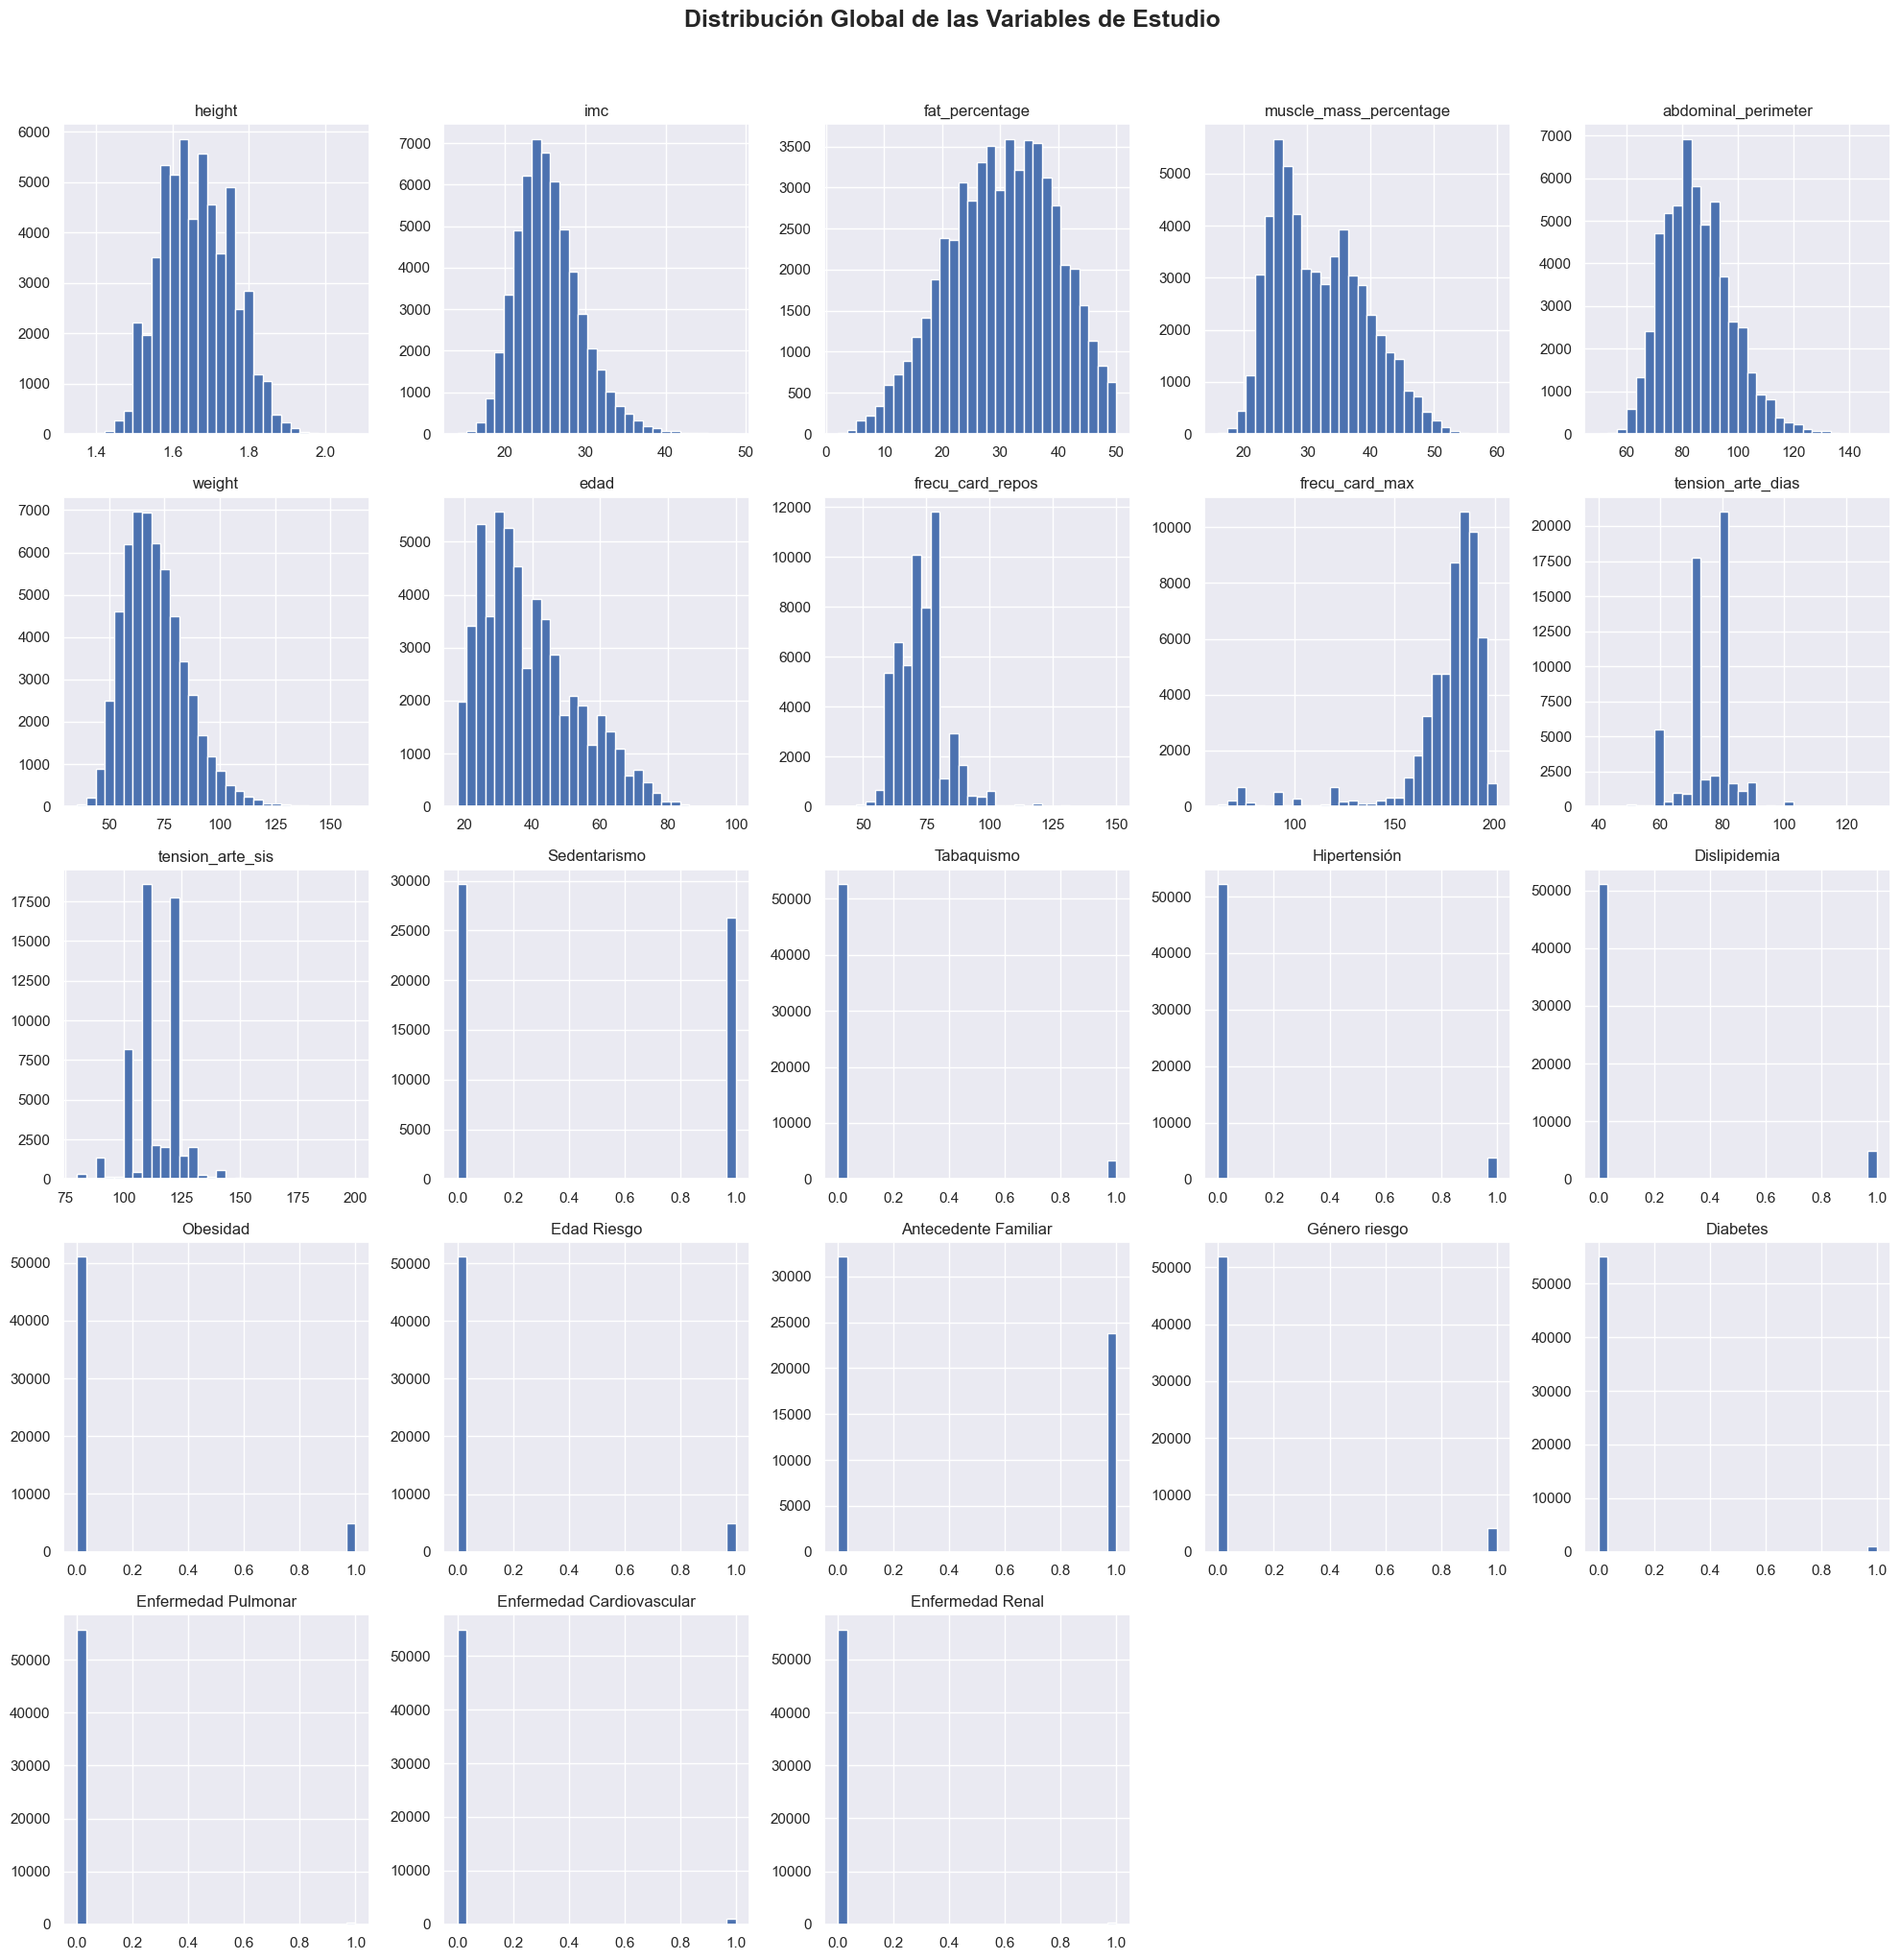

In [88]:
# Global
axes = Acc_total_afilia_EDA[['height', 'imc',  'fat_percentage',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 
       'edad','frecu_card_repos', 'frecu_card_max',
       'tension_arte_dias', 'tension_arte_sis', 'Sedentarismo', 'Tabaquismo',
       'Hipertensión', 'Dislipidemia', 'Obesidad', 'Edad Riesgo',
       'Antecedente Familiar', 'Género riesgo', 'Diabetes',
       'Enfermedad Pulmonar', 'Enfermedad Cardiovascular', 'Enfermedad Renal']].hist(figsize=(20,20), bins=30)
plt.suptitle('Distribución Global de las Variables de Estudio', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\22303379.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=Acc_total_afilia_EDA['genre'].unique(),


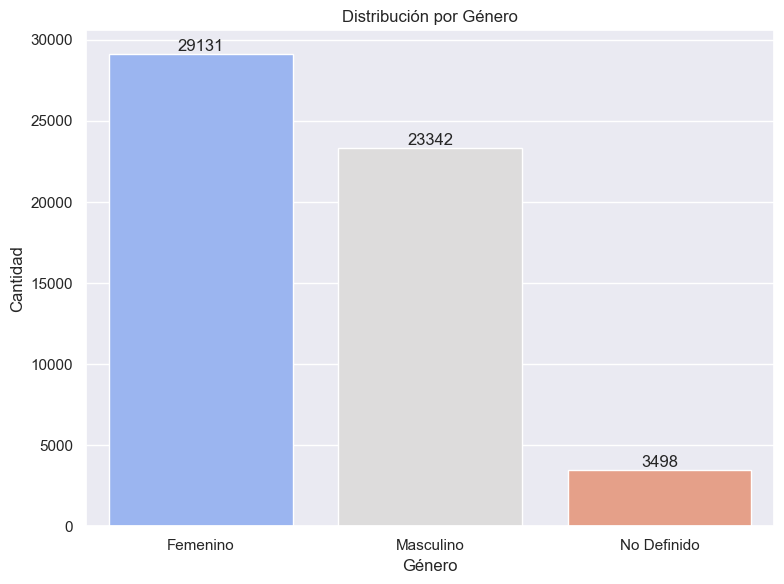

In [89]:
# Distribución por Género
# Crear gráfico
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=Acc_total_afilia_EDA['genre'].unique(), 
                 y=Acc_total_afilia_EDA['genre'].value_counts(), 
                 palette='coolwarm')

# Añadir etiquetas encima de cada barra
for i, count in enumerate(Acc_total_afilia_EDA['genre'].value_counts()):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontweight='normal')

plt.title('Distribución por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

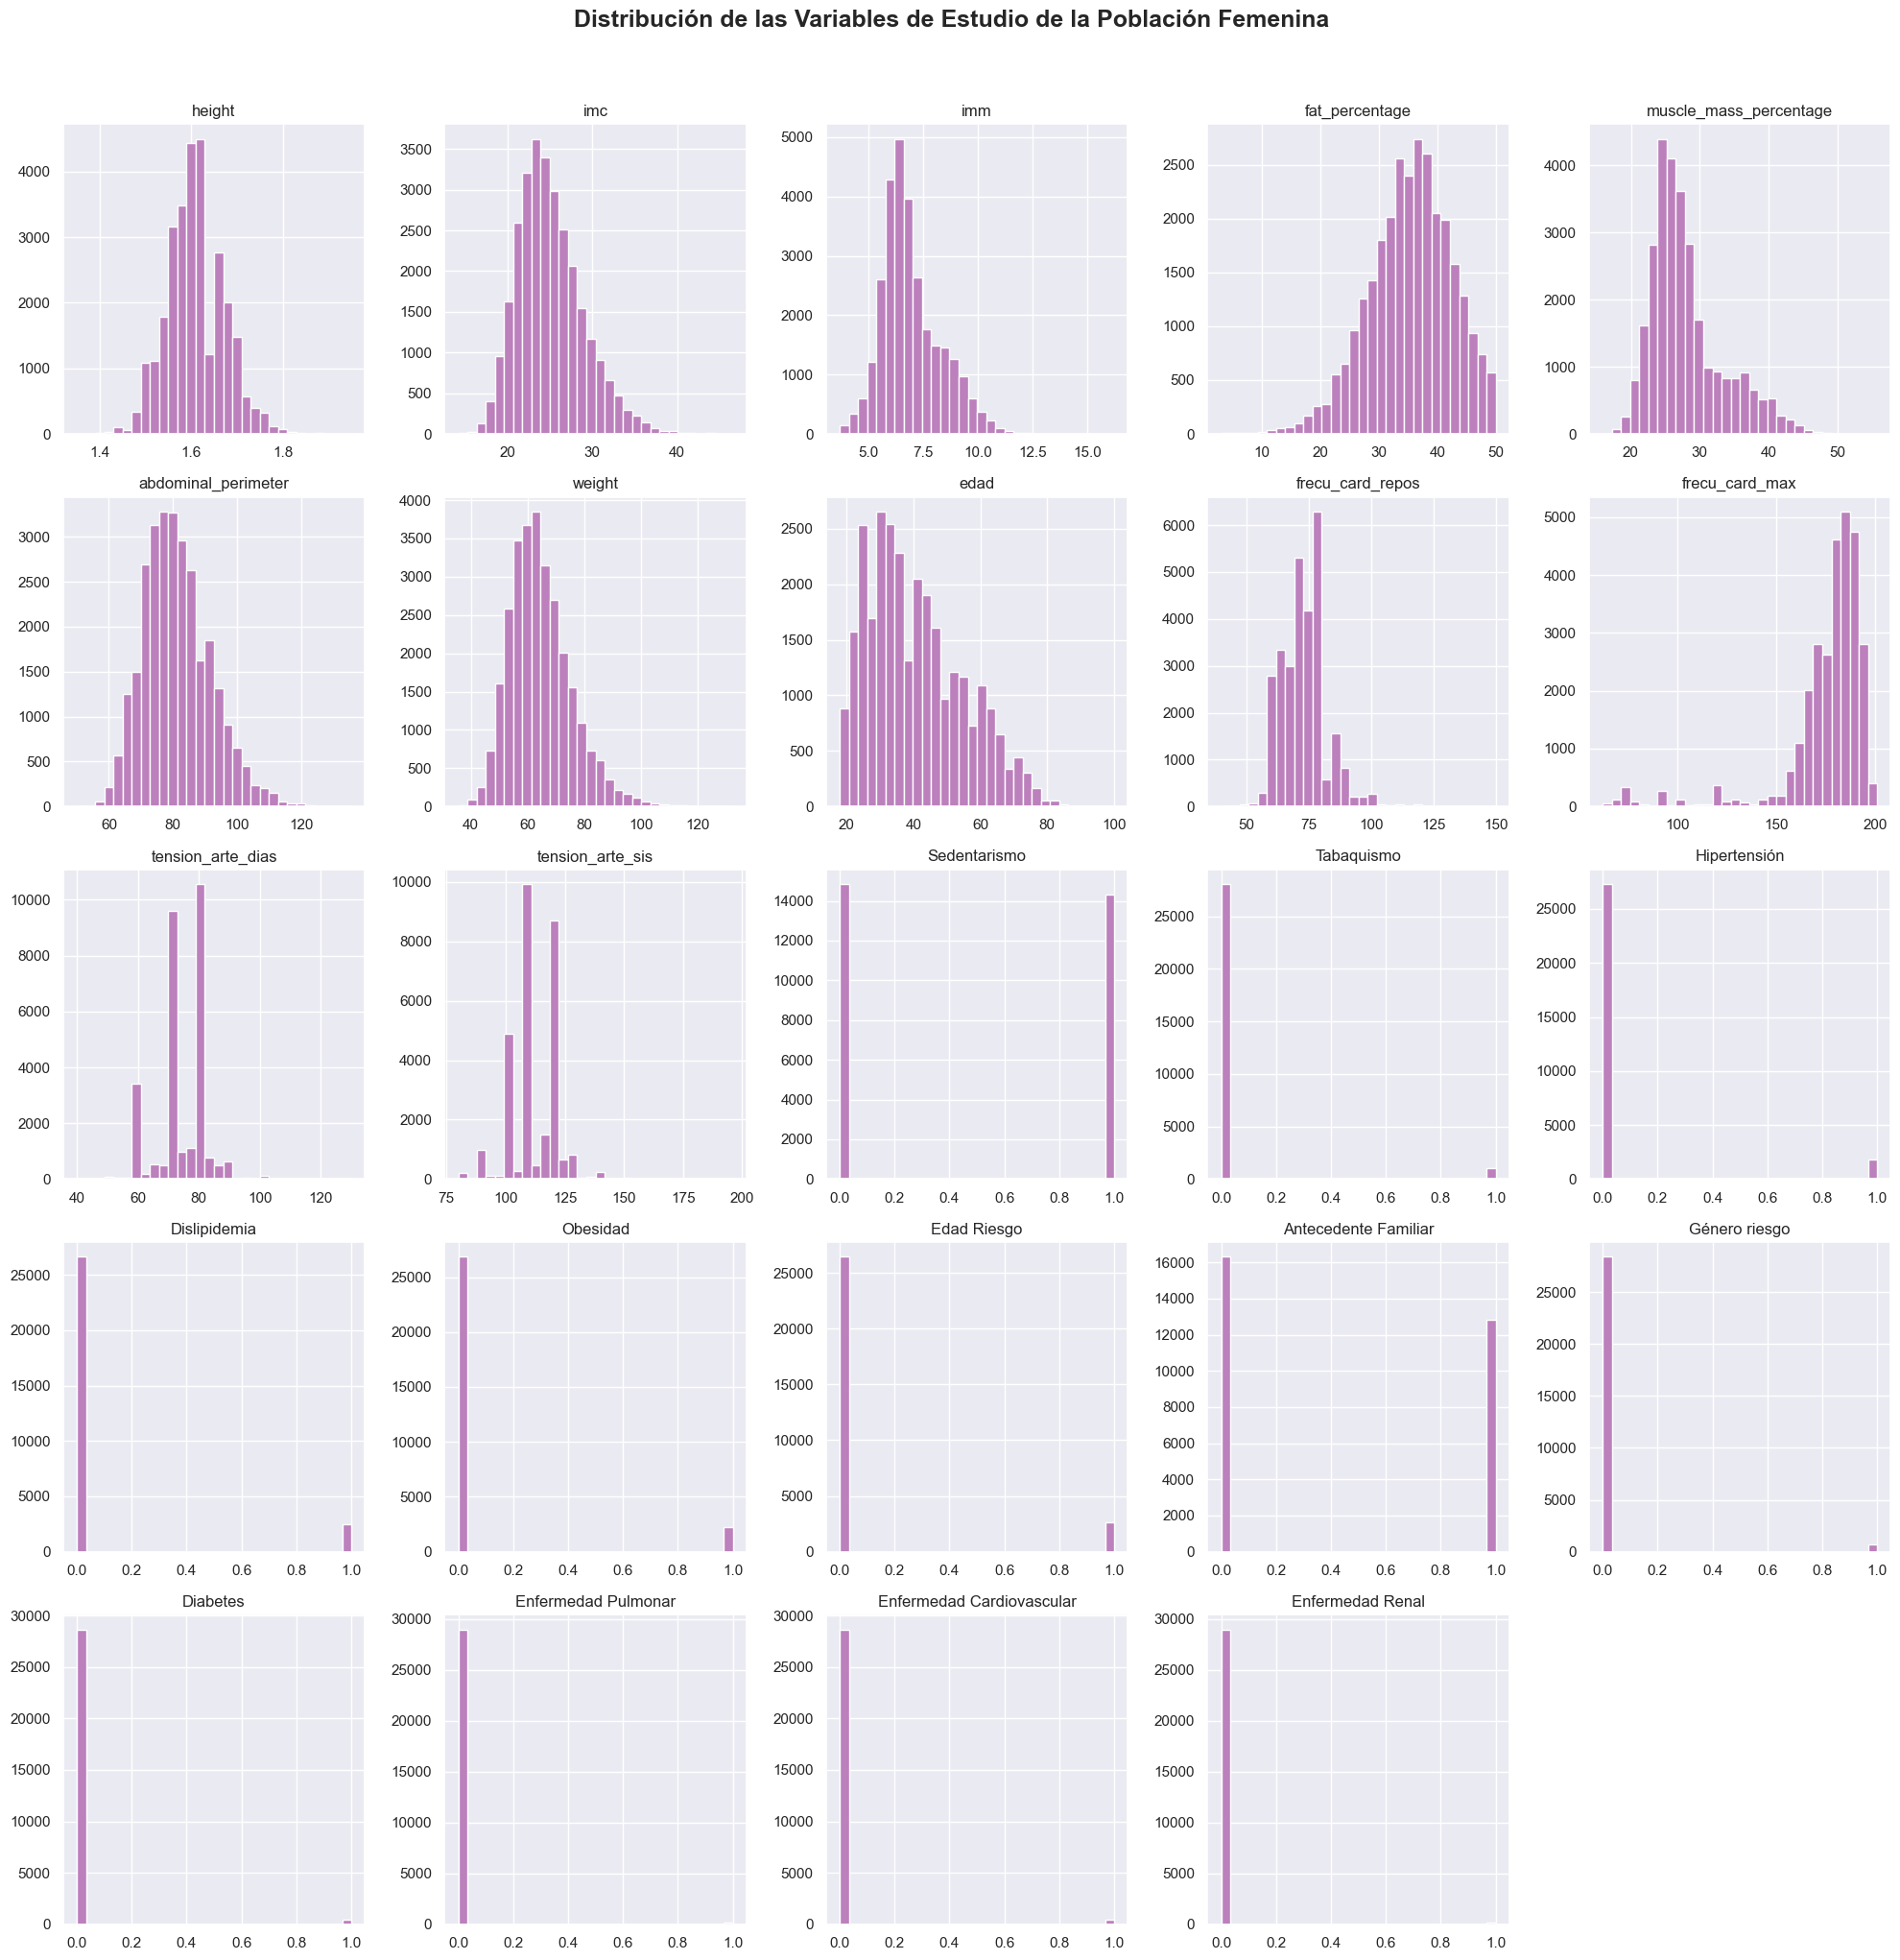

In [90]:
# Mujeres 

Acc_total_afilia_df_Mujeres = Acc_total_afilia_EDA[['height', 'imc', 'imm', 'fat_percentage',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 
       'edad','frecu_card_repos', 'frecu_card_max',
       'tension_arte_dias', 'tension_arte_sis', 'Sedentarismo', 'Tabaquismo',
       'Hipertensión', 'Dislipidemia', 'Obesidad', 'Edad Riesgo',
       'Antecedente Familiar', 'Género riesgo', 'Diabetes',
       'Enfermedad Pulmonar', 'Enfermedad Cardiovascular', 'Enfermedad Renal']].loc[Acc_total_afilia_EDA['genre']=='Femenino']

colors = sns.color_palette("Set3", n_colors=len(Acc_total_afilia_df_Mujeres.columns))

# Crear histogramas por columna
axes = Acc_total_afilia_df_Mujeres.hist(figsize=(20, 20), bins=30, color=colors[9])

# Título general para toda la figura
plt.suptitle('Distribución de las Variables de Estudio de la Población Femenina', 
             fontsize=18, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

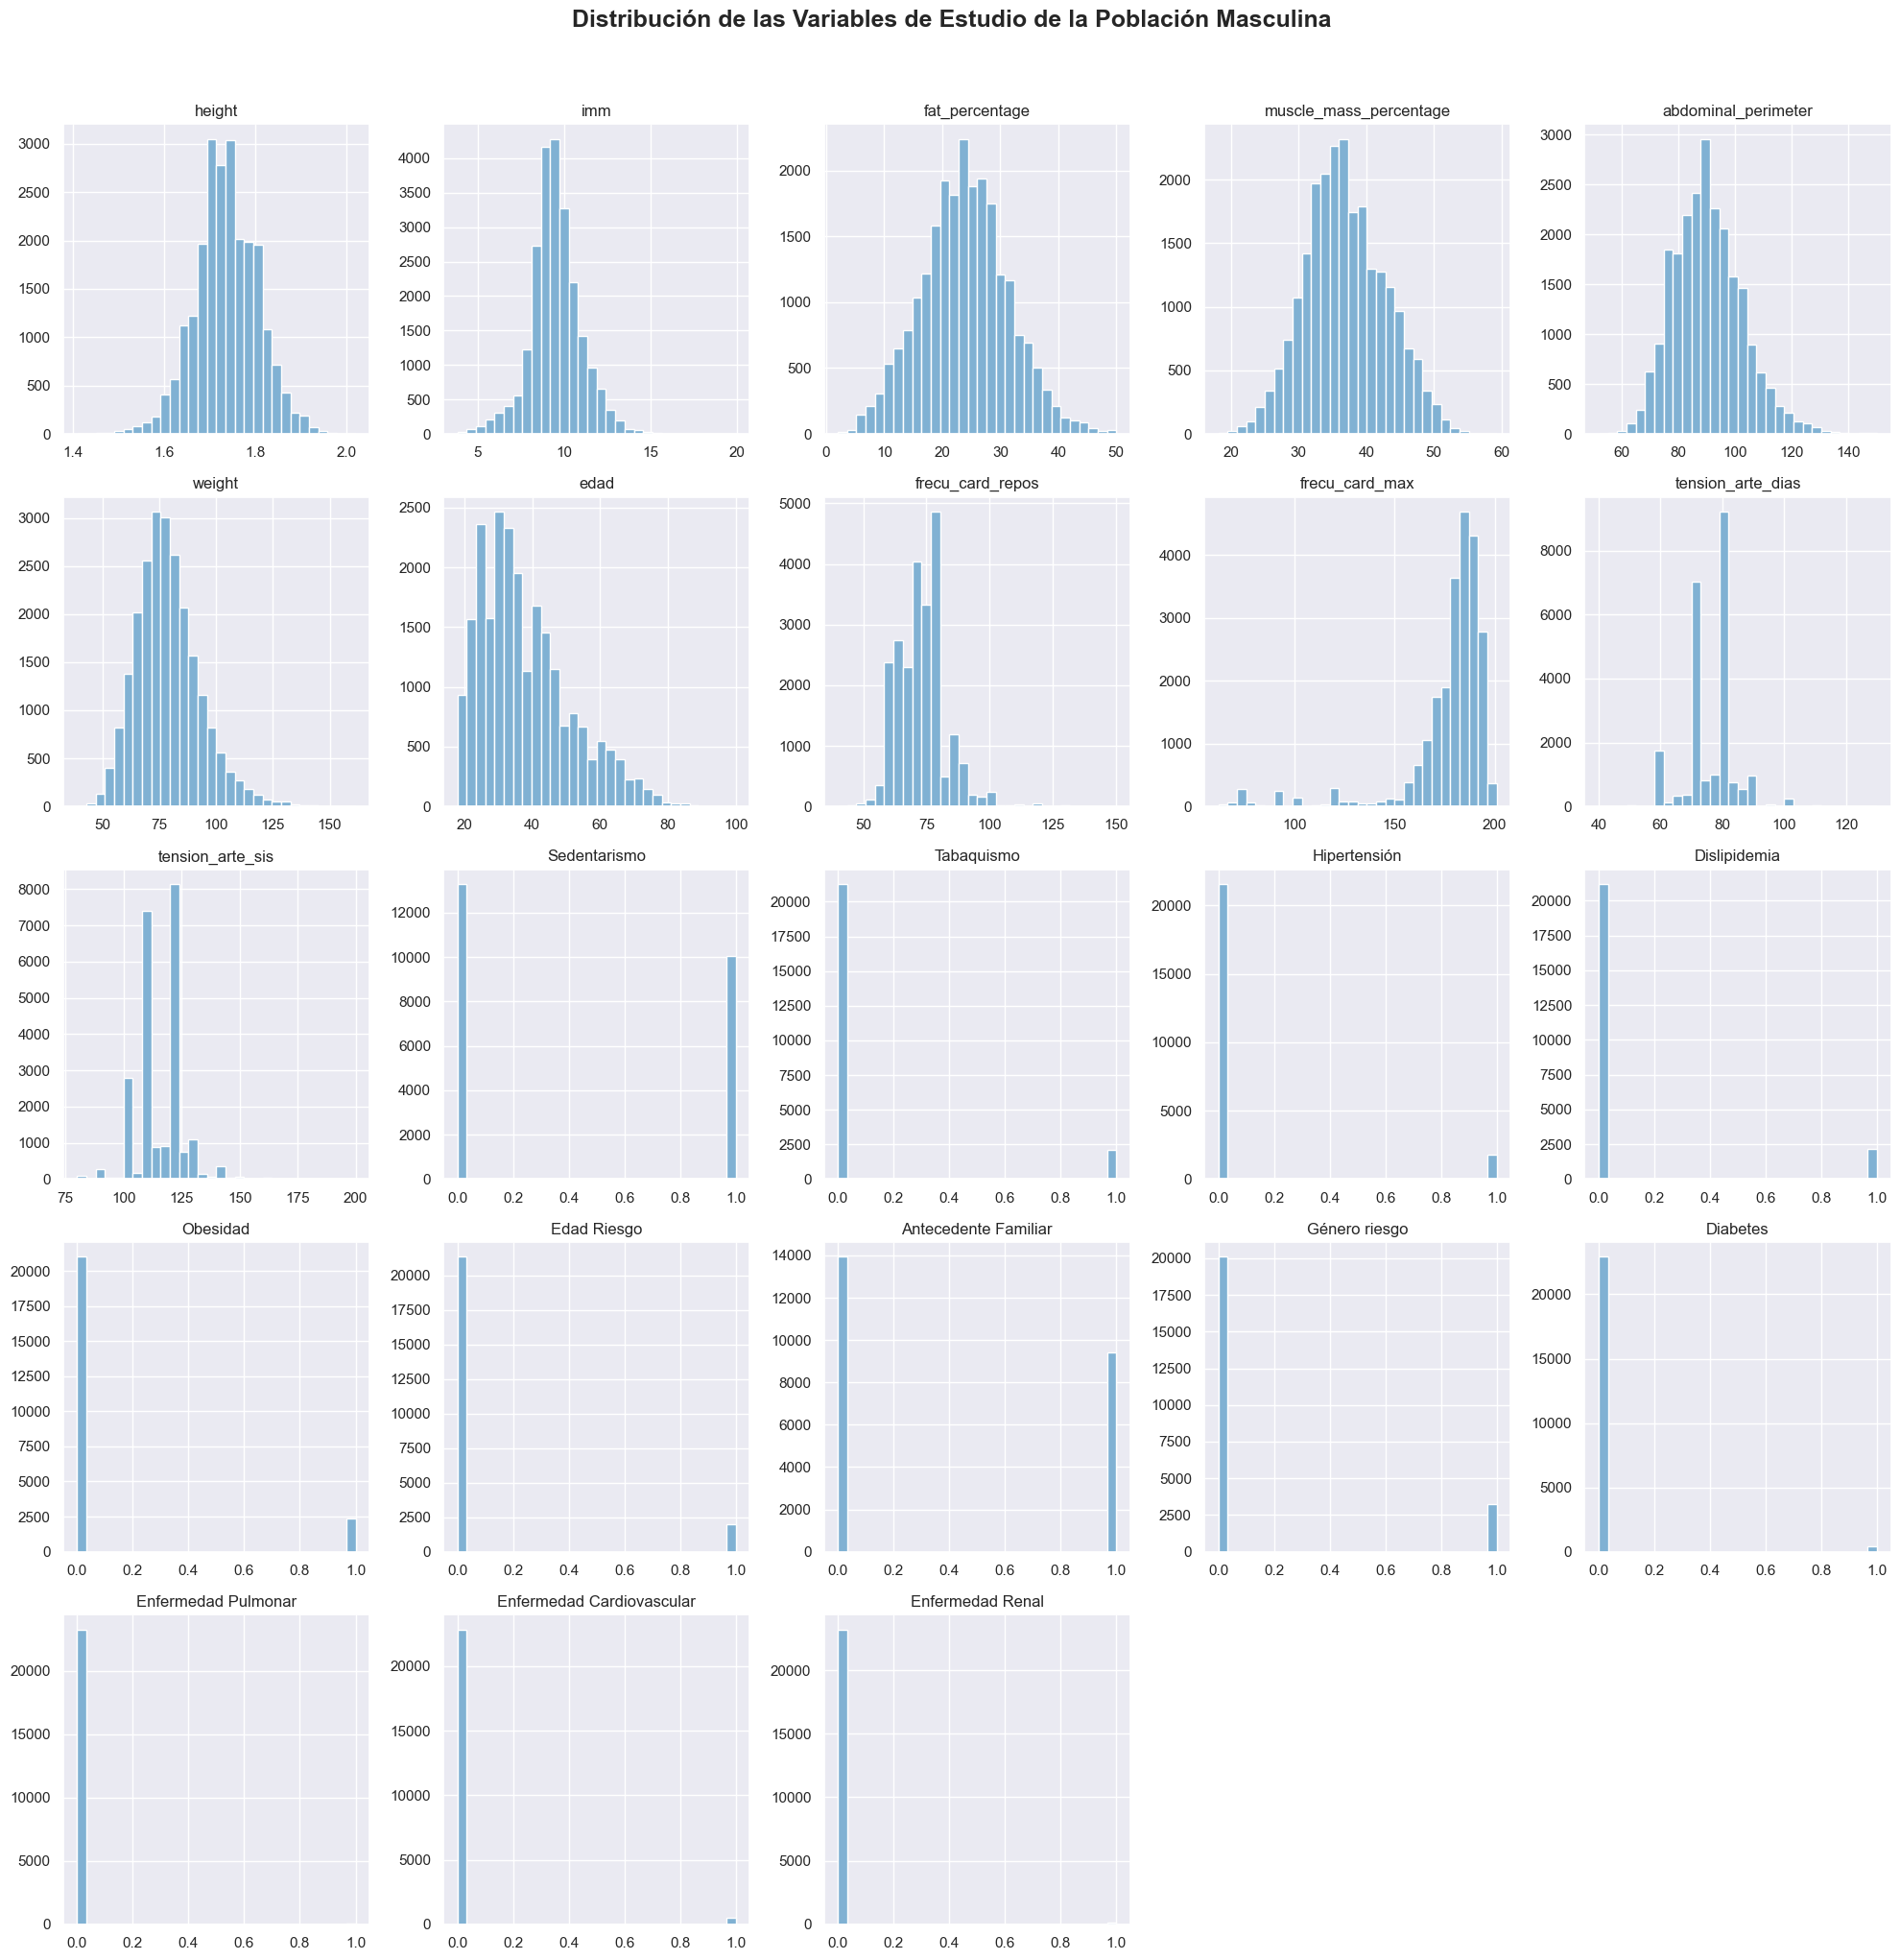

In [91]:
# Hombres 
Acc_total_afilia_df_Hombres = Acc_total_afilia_EDA[['height',  'imm', 'fat_percentage',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 
       'edad','frecu_card_repos', 'frecu_card_max',
       'tension_arte_dias', 'tension_arte_sis', 'Sedentarismo', 'Tabaquismo',
       'Hipertensión', 'Dislipidemia', 'Obesidad', 'Edad Riesgo',
       'Antecedente Familiar', 'Género riesgo', 'Diabetes',
       'Enfermedad Pulmonar', 'Enfermedad Cardiovascular', 'Enfermedad Renal']].loc[Acc_total_afilia_EDA['genre']=='Masculino']

colors = sns.color_palette("Set3", n_colors=len(Acc_total_afilia_df_Hombres.columns))

Axes = Acc_total_afilia_df_Hombres.hist(figsize=(20,20), bins=30, color = colors[4])

# Título general para toda la figura
plt.suptitle('Distribución de las Variables de Estudio de la Población Masculina', 
             fontsize=18, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()


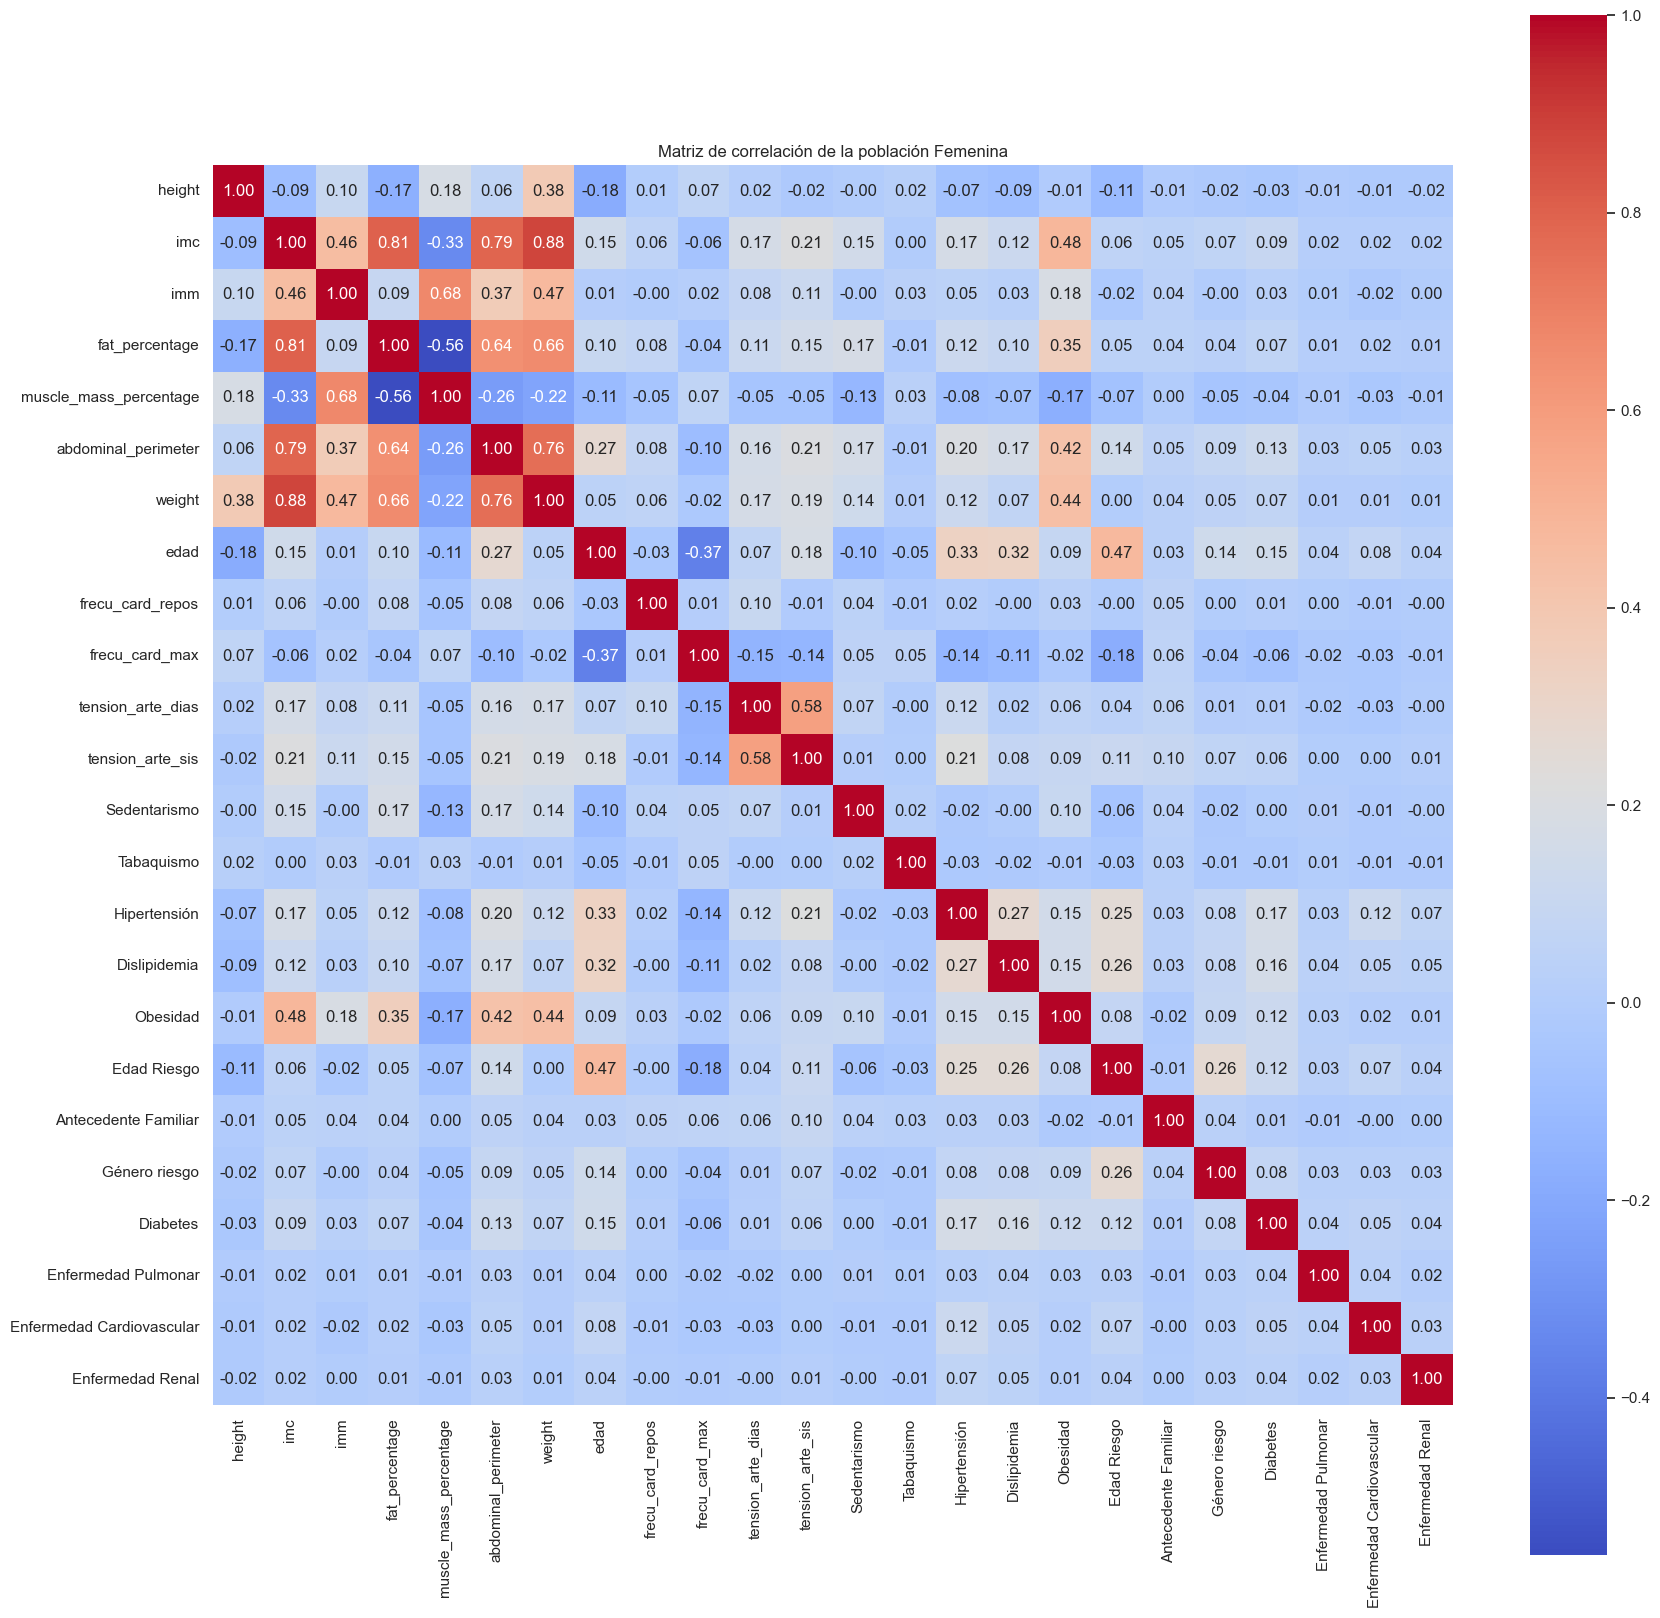

In [92]:
# Matriz de correlación Mujeres
corr = Acc_total_afilia_df_Mujeres.corr(numeric_only=True)

# Dibujar el mapa de calor
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlación de la población Femenina")
plt.show()


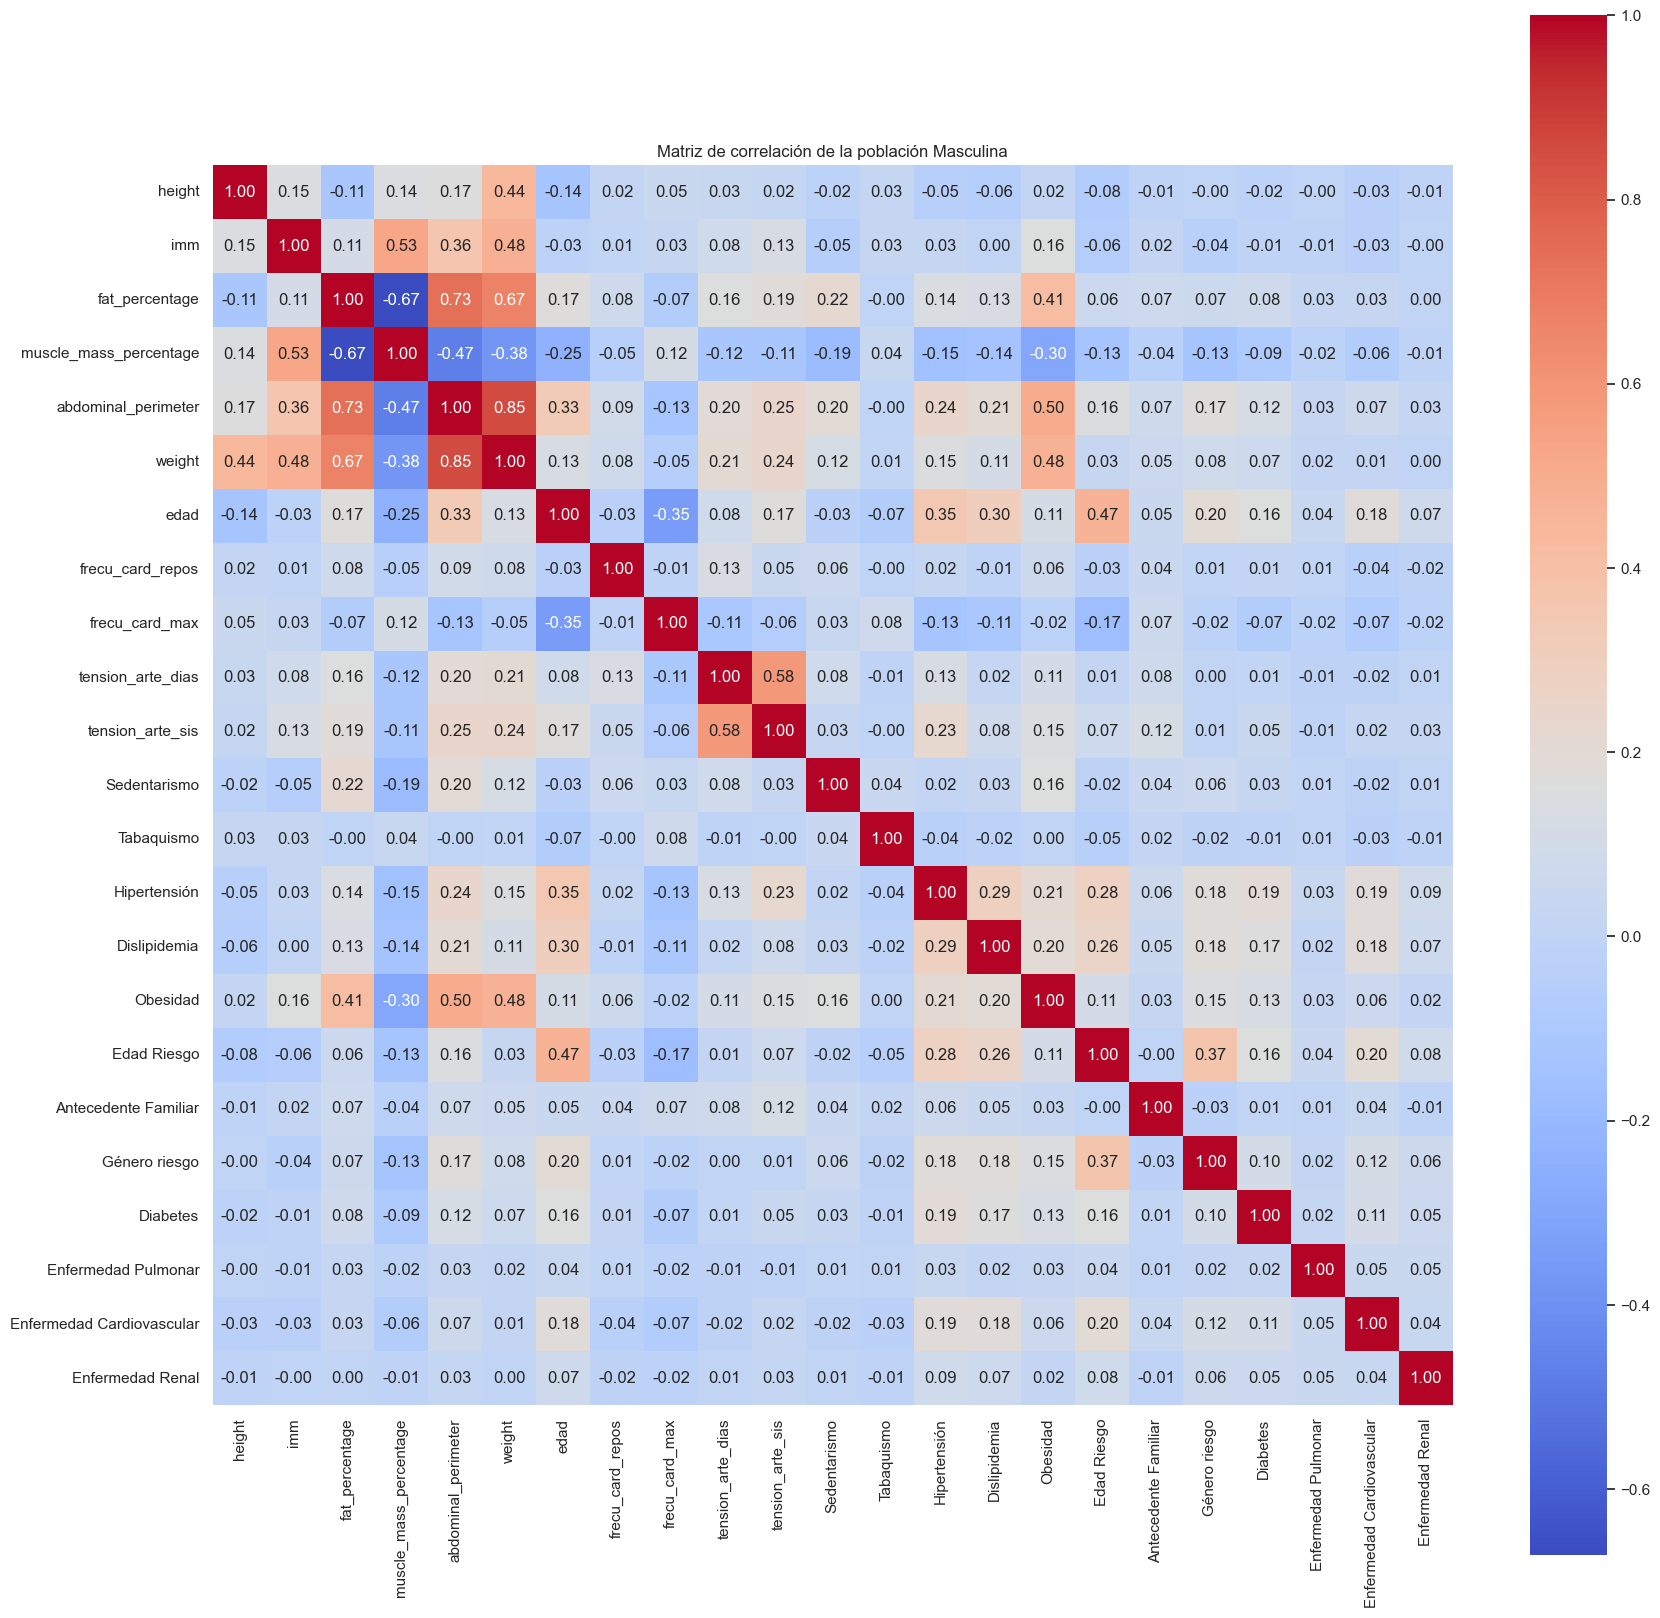

In [93]:
# Matriz de correlación Hombres
corr = Acc_total_afilia_df_Hombres.corr(numeric_only=True)

# Dibujar el mapa de calor
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlación de la población Masculina")
plt.show()


In [94]:
# Definir los bins (intervalos de 10 en 10)
bins = list(range(0, 101, 10))  # de 0 a 100 años, ajusta si tienes mayores
labels = [f"{i}-{i+9}" for i in bins[:-1]]  # genera etiquetas como "0-9", "10-19", etc.

# Crear la columna 'rango_edad'
Acc_total_afilia_EDA['rango_edad'] = pd.cut(Acc_total_afilia_EDA['edad'], bins=bins, labels=labels, right=False)

# Si quieres que los mayores de 100 queden agrupados en "100+"
Acc_total_afilia_EDA['rango_edad'] = pd.cut(
    Acc_total_afilia_EDA['edad'],
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')],
    labels=["0-9", "10-19", "20-29", "30-39", "40-49", "50-59",
            "60-69", "70-79", "80-89", "90-99", "100+"],
    right=False
)

C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\2902094032.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=rango_ordenado.index,  # Etiquetas ordenadas


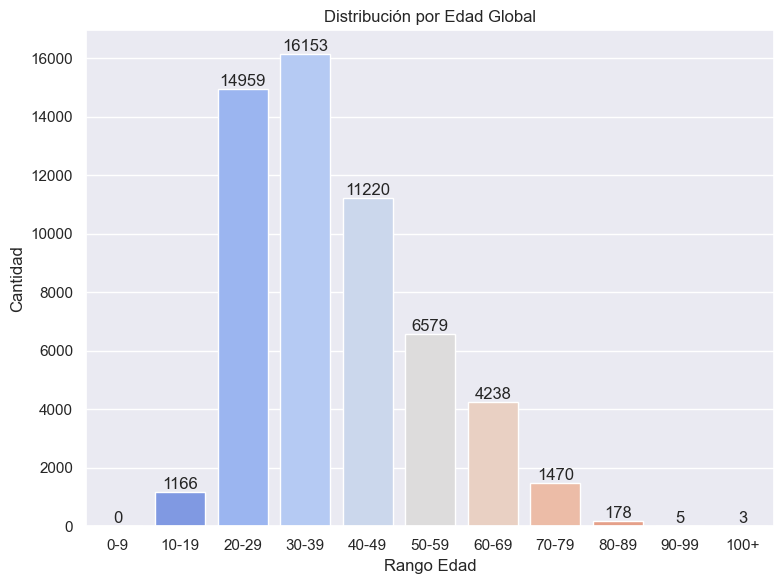

In [95]:
# Obtener los valores ordenados por rango de edad
rango_ordenado = Acc_total_afilia_EDA['rango_edad'].value_counts().sort_index()

# Crear gráfico
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=rango_ordenado.index,  # Etiquetas ordenadas
                 y=rango_ordenado.values,  # Cantidades
                 palette='coolwarm')

# Añadir etiquetas encima de cada barra
for i, count in enumerate(rango_ordenado.values):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontweight='normal')

# Títulos y etiquetas
plt.title('Distribución por Edad Global')
plt.xlabel('Rango Edad')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

In [96]:
Acc_total_afilia_EDA['genre'].unique()

array(['Femenino', 'Masculino', 'No Definido'], dtype=object)

C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\105770900.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\105770900.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\105770900.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


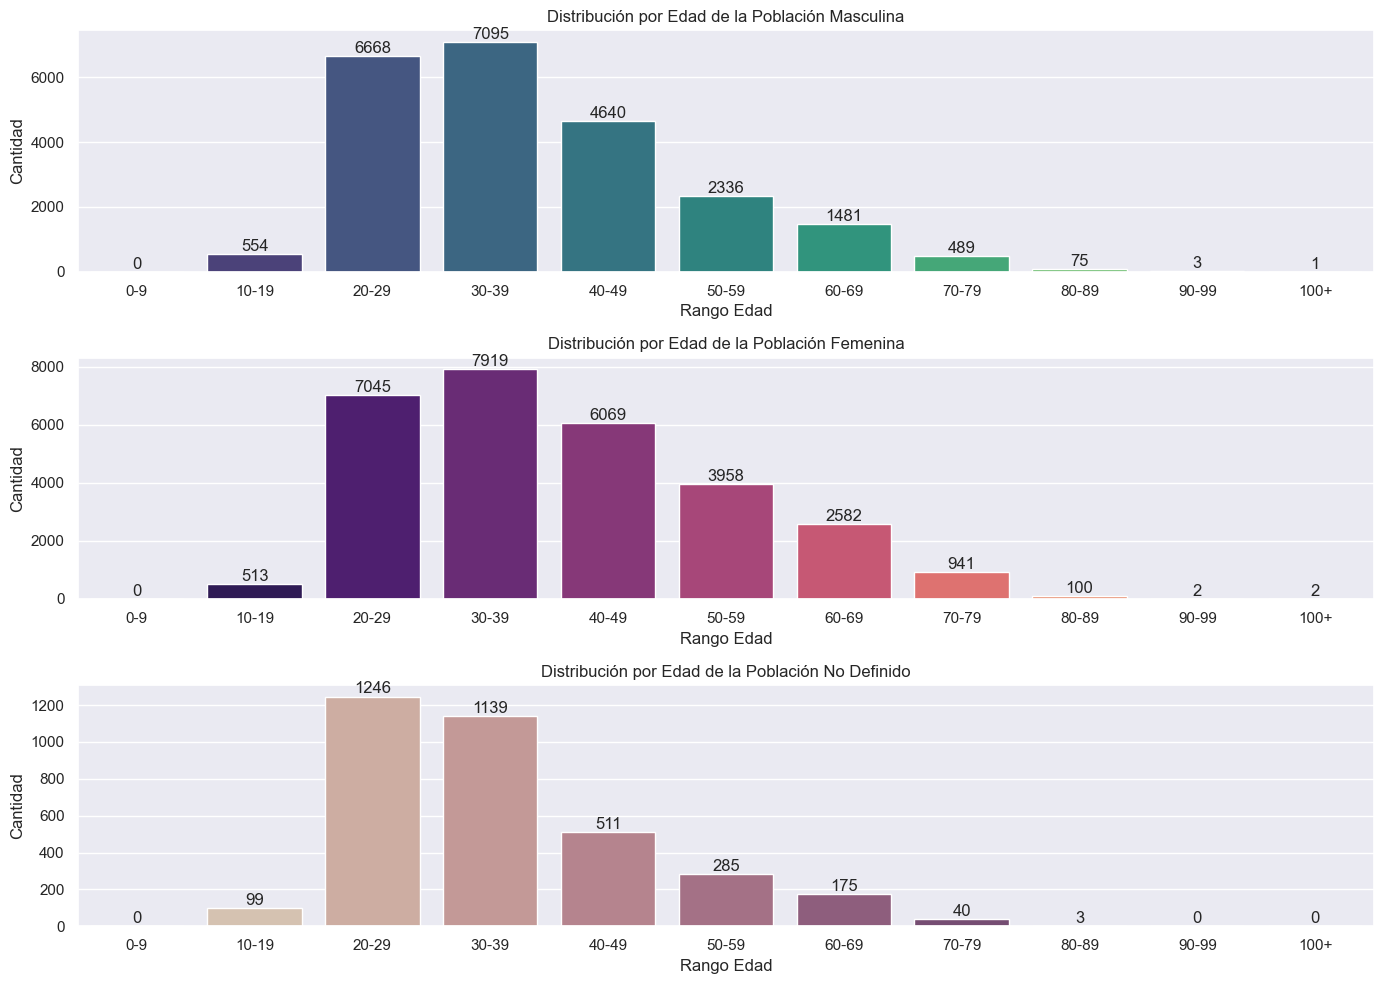

In [97]:
# Filtrar por género
Hombres_EDA_df = Acc_total_afilia_EDA.loc[Acc_total_afilia_EDA['genre'] == 'Masculino']
Mujeres_EDA_df = Acc_total_afilia_EDA.loc[Acc_total_afilia_EDA['genre'] == 'Femenino']
NoDef_EDA_df = Acc_total_afilia_EDA.loc[Acc_total_afilia_EDA['genre'] == 'No Definido']

# Crear figura con 3 filas y 1 columna
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Lista de dataframes y títulos
data_list = [
    (Hombres_EDA_df, 'Distribución por Edad de la Población Masculina', 'viridis'),
    (Mujeres_EDA_df, 'Distribución por Edad de la Población Femenina', 'magma'),
    (NoDef_EDA_df, 'Distribución por Edad de la Población No Definido', 'ch:s=-.2,r=.6')
]

# Generar gráficos
for i, (df, title, palette) in enumerate(data_list):
    rango_ordenado = df['rango_edad'].value_counts().sort_index()
    
    sns.barplot(
        x=rango_ordenado.index,
        y=rango_ordenado.values,
        palette=palette,
        ax=axes[i]
    )
    
    for j, count in enumerate(rango_ordenado.values):
        axes[i].text(j, count + 1, str(count), ha='center', va='bottom')
    
    axes[i].set_title(title)
    axes[i].set_xlabel('Rango Edad')
    axes[i].set_ylabel('Cantidad')
    axes[i].tick_params(axis='x')

plt.tight_layout()
plt.show()

In [98]:
Acc_total_afilia_df['ciudad'].value_counts()

ciudad
Bogotá           24885
Medellín          9089
Cali              4407
Bucaramanga       2579
Pereira           1979
Cartagena         1803
Villavicencio     1563
Barranquilla      1548
Valledupar        1133
Ibagué            1093
Tuluá              892
Tunja              879
Cúcuta             743
Manizales          650
Bello              608
Soacha             549
Chía               442
Palmira            279
Pasto              265
Montería           213
Armenia            207
Neiva              165
Name: count, dtype: int64

In [99]:
Informa_ciudad = pd.read_excel("C:/Users/yilinet.bueno/Desktop/Modelos/Estudio Medico/NSE-Sedes (1).xlsx",
                               sheet_name='Ciudades')
Informa_ciudad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Ciudades      23 non-null     object
 1   Departamento  23 non-null     object
dtypes: object(2)
memory usage: 500.0+ bytes


In [100]:
# Inicializar el geolocalizador
geolocator = Nominatim(user_agent="mi_app_colombia")

# Para evitar sobrecargar el servidor, limitamos las solicitudes a 1 por segundo
geocode = RateLimiter(geolocator.geocode)

# Función para obtener latitud y longitud de una ciudad en Colombia
def obtener_coordenadas(ciudad, departamento):
    try:
        query = f"{ciudad}, {departamento}, Colombia"
        location = geocode(query)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error al buscar {ciudad}: {e}")
        return None, None

# Aplicamos la función al DataFrame
Informa_ciudad[["Latitud", "Longitud"]] = Informa_ciudad.apply(
    lambda row: pd.Series(obtener_coordenadas(row["Ciudades"], row["Departamento"])),
    axis=1
)

# Mostramos el DataFrame con las nuevas columnas
Informa_ciudad.head()

Ciudades     Departamento    Latitud   Longitud
0  Villavicencio             Meta   4.111459 -73.496784
1     Valledupar            Cesar  10.343111 -73.375793
2          Tunja           Boyacá   5.532431 -73.361601
3          Tuluá  Valle del Cauca   4.085667 -76.197278
4         Soacha     Cundinamarca   4.582689 -74.211778

In [101]:
lat, lon = obtener_coordenadas("Bogotá", "Bogotá D.C") #ciudad y depart
print(f"Latitud: {lat}, Longitud: {lon}")

Latitud: 4.6533817, Longitud: -74.0836331


In [102]:
Informa_ciudad.loc[Informa_ciudad['Ciudades'] == 'Bogotá']

Ciudades Departamento   Latitud   Longitud
19   Bogotá   Bogotá D.C  4.653382 -74.083633

In [103]:
# Crear un diccionario: ciudad -> (Departamento, Latitud, Longitud)
diccionario_ciudades = Informa_ciudad.set_index("Ciudades")[["Departamento", "Latitud", "Longitud"]].to_dict(orient="index")

# Mapear cada ciudad al dict correspondiente
mapeo = Acc_total_afilia_EDA["ciudad"].map(diccionario_ciudades)

# Convertir el resultado (una serie de dicts) en un DataFrame
nuevas_columnas = pd.DataFrame(mapeo.tolist(), index=Acc_total_afilia_EDA.index)

# Unir al DataFrame original
Acc_total_afilia_EDA = pd.concat([Acc_total_afilia_EDA, nuevas_columnas], axis=1)


## Aplicación Estudio Hearts

In [104]:
Acc_total_afilia_df_mayores_18 = Acc_total_afilia_df[Acc_total_afilia_df['edad']<= 18]
Acc_total_afilia_df_mayores_18.info()

<class 'pandas.core.frame.DataFrame'>
Index: 544 entries, 20020 to 318862
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                544 non-null    float64       
 1   sesiones_en_la_semana      544 non-null    float64       
 2   member_id_y                544 non-null    float64       
 3   minutos_por_semana         544 non-null    float64       
 4   nivel_actividad_time       544 non-null    object        
 5   document_number            544 non-null    object        
 6   tipo_vinculacion           544 non-null    object        
 7   ocupacion                  544 non-null    object        
 8   eps                        544 non-null    object        
 9   territorial_zone           544 non-null    object        
 10  date                       544 non-null    datetime64[ns]
 11  user_id                    544 non-null    int64         
 12  date_a

In [105]:
## Distribución de Mayores de 18 
Acc_total_afilia_df_mayores_18['genre'].value_counts()

genre
Masculino      271
Femenino       235
No Definido     38
Name: count, dtype: int64

In [106]:
Acc_total_afilia_df_mayores_40 = Acc_total_afilia_df[Acc_total_afilia_df['edad']>= 18]
Acc_total_afilia_df_mayores_40.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55971 entries, 15848 to 319291
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                55971 non-null  float64       
 1   sesiones_en_la_semana      55971 non-null  float64       
 2   member_id_y                55971 non-null  float64       
 3   minutos_por_semana         55971 non-null  float64       
 4   nivel_actividad_time       55971 non-null  object        
 5   document_number            55971 non-null  object        
 6   tipo_vinculacion           55971 non-null  object        
 7   ocupacion                  55971 non-null  object        
 8   eps                        55970 non-null  object        
 9   territorial_zone           55971 non-null  object        
 10  date                       55971 non-null  datetime64[ns]
 11  user_id                    55971 non-null  int64         
 12  date

In [107]:
## Distribución de Mayores de 40 
Acc_total_afilia_df_mayores_40['genre'].value_counts() 

genre
Femenino       29131
Masculino      23342
No Definido     3498
Name: count, dtype: int64

In [108]:
Acc_total_afilia_df_mayores_40.columns

Index(['member_id_x', 'sesiones_en_la_semana', 'member_id_y',
       'minutos_por_semana', 'nivel_actividad_time', 'document_number',
       'tipo_vinculacion', 'ocupacion', 'eps', 'territorial_zone', 'date',
       'user_id', 'date_acc', 'height', 'imc', 'imm', 'fat_percentage',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 'genre',
       'edad', 'birthdate', 'frecu_card_repos', 'frecu_card_max',
       'tension_arte_dias', 'tension_arte_sis', 'state_pregnancy',
       'riesgo_cardiov', 'frecuency_sport_actv', 'time_sport_actv', 'sede_uso',
       'ciudad', 'category_sede_uso', 'region', 'average_minute',
       'sport_activity_intensity', 'diagnostic_name_1', 'diagnostic_name_2',
       'family_history', 'quote_id', 'aptitud', 'date_quote', 'status_quote',
       'document_number_type', 'evaluador_acc', 'fecha_embar', 'No_Documento',
       'Embarazada', 'members_id', 'Departamento', 'Sedentarismo',
       'Tabaquismo', 'Hipertensión', 'Dislipidemia', 'Obesidad',

In [109]:
Acc_total_afilia_df_mayores_40['date_acc'].max()

Timestamp('2025-05-31 00:00:00')

In [110]:
def mostrar_distribucion_categorica(df, variable, genero='genre'):
    abs_table = pd.crosstab(df[genero], df[variable])
    pct_table = pd.crosstab(df[genero], df[variable], normalize='index') * 100
    combined = abs_table.astype(str) + " (" + pct_table.round(3).astype(str) + "%)"
    print(f"{variable}:\n{combined}\n")

print("Distribución de Variables Categóricas por Género (Frecuencia absoluta y porcentaje):\n")

variables_categoricas = ['Sedentarismo', 'Tabaquismo', 'Hipertensión', 'Dislipidemia',
       'Obesidad', 'Edad Riesgo', 'Antecedente Familiar', 'Género riesgo','ocupacion_validada',
       'Diabetes', 'Enfermedad Pulmonar', 'Enfermedad Cardiovascular','nivel_actividad_time',
       'Enfermedad Renal', 'state_pregnancy', 'Estrato', 'rango_edad', 'Identifica Extranjero']

for var in variables_categoricas:
    mostrar_distribucion_categorica(Acc_total_afilia_df_mayores_40, var)


Distribución de Variables Categóricas por Género (Frecuencia absoluta y porcentaje):

Sedentarismo:
Sedentarismo               NO               SI
genre                                         
Femenino      14837 (50.932%)  14294 (49.068%)
Masculino     13288 (56.927%)  10054 (43.073%)
No Definido    1522 (43.511%)   1976 (56.489%)

Tabaquismo:
Tabaquismo                NO             SI
genre                                      
Femenino     28045 (96.272%)  1086 (3.728%)
Masculino     21267 (91.11%)   2075 (8.89%)
No Definido   3269 (93.453%)   229 (6.547%)

Hipertensión:
Hipertensión               NO             SI
genre                                       
Femenino      27288 (93.673%)  1843 (6.327%)
Masculino     21558 (92.357%)  1784 (7.643%)
No Definido     3335 (95.34%)    163 (4.66%)

Dislipidemia:
Dislipidemia               NO             SI
genre                                       
Femenino      26631 (91.418%)  2500 (8.582%)
Masculino     21185 (90.759%)  2157 (9.241

In [111]:
Acc_total_afilia_df_mayores_40['date_acc'].max()

Timestamp('2025-05-31 00:00:00')

In [112]:
Acc_total_afilia_df_mayores_40['date_acc'].min()

Timestamp('2022-02-15 00:00:00')

In [113]:
#Acc_total_afilia_df_mayores_40.to_excel('diagnostico.xlsx', index=False)

In [114]:
# Segmentación fumadores
Hombres_fumadores_May_40 = Acc_total_afilia_df_mayores_40.loc[(Acc_total_afilia_df_mayores_40['genre'] == 'Masculino') & (Acc_total_afilia_df_mayores_40['Tabaquismo']=='SI')]
Mujeres_fumadoras_May_40 = Acc_total_afilia_df_mayores_40.loc[(Acc_total_afilia_df_mayores_40['genre'] == 'Femenino') & (Acc_total_afilia_df_mayores_40['Tabaquismo']=='SI')]

print("Hombres fumadores mayores de 18:", len(Hombres_fumadores_May_40), "Mujeres Fumadoras mayores de 18:", len(Mujeres_fumadoras_May_40))

# Segmentación no fumadores
Hombres_no_fumadores_May_40 = Acc_total_afilia_df_mayores_40.loc[(Acc_total_afilia_df_mayores_40['genre'] == 'Masculino') & (Acc_total_afilia_df_mayores_40['Tabaquismo']=='NO')]
Mujeres_no_fumadoras_May_40 = Acc_total_afilia_df_mayores_40.loc[(Acc_total_afilia_df_mayores_40['genre'] == 'Femenino') & (Acc_total_afilia_df_mayores_40['Tabaquismo']=='NO')]

print("Hombres No fumadores mayores de 18:", len(Hombres_no_fumadores_May_40), "Mujeres No Fumadoras mayores de 18:", len(Mujeres_no_fumadoras_May_40))

#Total población 93.277

Hombres fumadores mayores de 18: 2075 Mujeres Fumadoras mayores de 18: 1086
Hombres No fumadores mayores de 18: 21267 Mujeres No Fumadoras mayores de 18: 28045


In [115]:
## Distribución de Mayores de 40 
Acc_total_afilia_df_mayores_40=Acc_total_afilia_df_mayores_40[Acc_total_afilia_df_mayores_40['genre'] != 'No Definido']
Acc_total_afilia_df_mayores_40['genre'].value_counts() 

genre
Femenino     29131
Masculino    23342
Name: count, dtype: int64

In [116]:
print (Acc_total_afilia_df_mayores_40['date_acc'].max())
Acc_total_afilia_df_mayores_40['date_acc'].min()

2025-05-31 00:00:00


Timestamp('2022-02-15 00:00:00')

### Clasificación Riesgo Hombres 

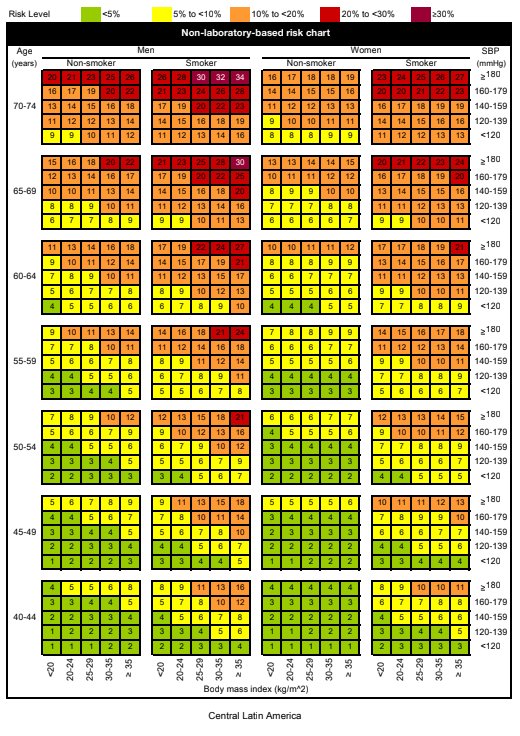

#### Hombres Fumadores

In [117]:
## HOMBRES FUMADORES
import re
# 1. Función de limpieza de texto
def limpiar(txt):
    if pd.isna(txt):
        return ''
    txt = unicodedata.normalize('NFKD', str(txt))
    return ''.join(c for c in txt if not unicodedata.combining(c)).upper().strip()

# 2. Listas de diagnósticos
enf_cardio = [ "HIPERTENSION ESENCIAL (PRIMARIA)", "HIPERTENSION SECUNDARIA, NO ESPECIFICADA",
    "HIPERTENSION PULMONAR PRIMARIA",
    "HIPERTENSION RENOVASCULAR","HIPERTENSION",
    "HIPERTENSION PORTAL",
    "CARDIACA", "TAQUICARDIA SUPRAVENTRICULAR","TAQUICARDIA PAROXISTICA",
    "ARRITMIA CARDIACA, NO ESPECIFICADA",
    "CARDIOMIOPATIA ISQUEMICA",
    "ENFERMEDAD ATEROSCLEROTICA DEL CORAZON",
    "BRADICARDIA, NO ESPECIFICADA",
    "FIBRILACION Y ALETEO AURICULAR",
    "PRESENCIA DE MARCAPASO CARDIACO",
    "ENFERMEDAD ISQUEMICA CRONICA DEL CORAZON",
    "INFARTO ANTIGUO DEL MIOCARDIO",
    "INFARTO AGUDO DEL MIOCARDIO",
    "ANGINA DE PECHO",
    "ARRITMIA POR REENTRADA VENTRICULAR",
    "TAQUICARDIA, SUPRAVENTRICULAR O PAROXISTICA",
    "INSUFICIENCIA CARDIACA",
    "ANEURISMA DE ARTERIA CORONARIA",
    "PRESENCIA DE VALVULA CARDIACA PROTESICA",
    "CARDIOMIOPATIA DILATADA",
    "OTRAS CARDIOMIOPATIA HIPERTROFICAS","CORONARIO",
    "OTRAS CARDIOMIOPATIA",
    "RESULTADOS ANORMALES EN ESTUDIOS FUNCIONALES CARDIOVASCULARES",
    "TROMBOSIS CORONARIA","CORONARIA", "BRADICARDIA",
    "ENFERMEDAD CARDIOVASCULAR ATEROSCLEROTICA",
    "ENFERMEDAD CARDIOVASCULAR, NO ESPECIFICADA", "EMBOLIA",
    "CARDIOPULMONARES", "CARDIOMEGALIA", "INFARTO", "MIOCARDIO", "PERICARDIO", "CORAZON",
    "VASCULITIS REUMATOIDE", "CARDIOMIOPATIA", "CARDIOVASCULAR", 
    "FLEBITIS Y TROMBOFLEBITIS","VASCULAR"
]

enf_diabetes_renal = [ "OTRAS DIABETES MELLITUS", "DIABETES",
    "DIABETES MELLITUS CON COMPLICACIONES CIRCULATORIAS PERIFERICAS",
    "DIABETES MELLITUS NO INSULINODEPENDIENTE", "DIABETES MELLITUS INSULINODEPENDIENTE","RENAL"
]

# 3. Crear patrones
patron1 = '|'.join([limpiar(e) for e in enf_cardio])
patron2 = '|'.join([limpiar(e) for e in enf_diabetes_renal])


# 4. Clasificación OMS hombres fumadores
riesgo_tabla = {
    (18, 44):   [[2, 2, 3, 3, 4],  # SBP <120
                 [3, 3, 4, 5, 6],  # SBP 120-139
                 [4, 5, 6, 7, 8],  # SBP 140-159
                 [5, 7, 8, 10, 12],# SBP 160-179
                 [8, 9, 11, 13, 16]], # SBP ≥180

    (45, 49):   [[3, 3, 4, 4, 5],  
                 [4, 4, 5, 6, 7],  
                 [5, 6, 7, 8, 10],  
                 [7, 8, 10, 11, 14],  
                 [9, 11, 13, 15, 18]],  

    (50, 54):   [[3, 4, 5, 6, 7],  
                 [5, 5, 6, 7, 9],  
                 [6, 7, 9, 10, 12],  
                 [9, 10, 12, 13, 16],  
                 [12, 13, 15, 18, 21]],  

    (55, 59):   [[5, 5, 6, 7, 8],  
                 [6, 7, 8, 9, 11],  
                 [8, 9, 11, 12, 14],  
                 [11, 12, 14, 16, 18],  
                 [14, 16, 18, 21, 24]],  

    (60, 64):   [[6, 7, 8, 9, 10],  
                 [8, 9, 10, 12, 13],  
                 [11, 12, 13, 15, 17],  
                 [14, 15, 17, 19, 21],  
                 [17, 19, 22, 24, 27]],  

    (65, 69):   [[9, 9, 10, 11, 13],  
                 [11, 12, 13, 14, 16],  
                 [14, 15, 16, 18, 20],  
                 [17, 19, 20, 22, 25],  
                 [21, 23, 25, 28, 30]],  

    (70, 100):   [[11, 12, 13, 14, 16],  
                 [14, 15, 16, 18, 19],  
                 [17, 19, 20, 22, 23],  
                 [21, 23, 24, 26, 28],  
                 [26, 28, 30, 32, 34]]  
}



def clasificar_riesgo(edad, imc, tension_sis):
    for rango_edad in riesgo_tabla.keys():
        if rango_edad[0] <= edad <= rango_edad[1]:
            tabla_edad = riesgo_tabla[rango_edad]
            break
    else:
        return '>30'  # Edad fuera de rango / Si la edad está fuera del rango, asumir máximo riesgo

    imc_rangos = [(float('-inf'), 19.999), (20, 24.999), (25.00, 29.99), (30, 34.99), (35, float('inf'))]
    for imc_idx, (imc_min, imc_max) in enumerate(imc_rangos):
        if imc_min <= imc <= imc_max:
            break
    else:
        return 'Desconocido'

    tension_rangos = [120, 140, 160, 180]
    for tension_idx, tension_umbral in enumerate(tension_rangos):
        if tension_sis < tension_umbral:
            break
    else:
        tension_idx = len(tension_rangos)

    riesgo = tabla_edad[tension_idx][imc_idx]
    if riesgo < 5:
        return '<5'
    elif 5 <= riesgo < 10:
        return '5-<10'
    elif 10 <= riesgo < 20:
        return '10-<20'
    elif 20 <= riesgo < 30:
        return '20-<30'
    else:
        return '>=30'


# Aplicacion en df
# 4. Limpiar columnas
Hombres_fumadores_riesgo_40_df = Hombres_fumadores_May_40.copy()
Hombres_fumadores_riesgo_40_df['diagnostic_clean_1'] = Hombres_fumadores_riesgo_40_df['diagnostic_name_1'].fillna('').apply(limpiar)
Hombres_fumadores_riesgo_40_df['diagnostic_clean_2'] = Hombres_fumadores_riesgo_40_df['diagnostic_name_2'].fillna('').apply(limpiar)

# Crear columna 'tipo_diagnostico' para identificar
def clasificar_tipo_diagnostico(row):
    texto = row['diagnostic_clean_1'] + ' ' + row['diagnostic_clean_2']
    tiene_cardio = bool(re.search(patron1, texto))
    tiene_renal = bool(re.search(patron2, texto))
    
    if tiene_cardio and tiene_renal:
        return 'Cardio y Renal'
    elif tiene_cardio:
        return 'Cardio'
    elif tiene_renal:
        return 'Renal/Diabetes'
    else:
        return 'No aplica'

Hombres_fumadores_riesgo_40_df['tipo_diagnostico'] = Hombres_fumadores_riesgo_40_df.apply(clasificar_tipo_diagnostico, axis=1)

# 5. Inicializar columna de riesgo
Hombres_fumadores_riesgo_40_df['Cardio Risk level'] = '<30'

# 6. Aplicar riesgo '20-30' si contiene diagnóstico cardiovascular crítico
Hombres_fumadores_riesgo_40_df.loc[
    Hombres_fumadores_riesgo_40_df['diagnostic_clean_1'].str.contains(patron1, na=False) |
    Hombres_fumadores_riesgo_40_df['diagnostic_clean_2'].str.contains(patron1, na=False),
    'Cardio Risk level'
] = '20-30'

# 7. Aplicar riesgo '>10-20' solo si aún está en <30
Hombres_fumadores_riesgo_40_df.loc[
    (Hombres_fumadores_riesgo_40_df['Cardio Risk level'] == '<30') & (
        Hombres_fumadores_riesgo_40_df['diagnostic_clean_1'].str.contains(patron2, na=False) |
        Hombres_fumadores_riesgo_40_df['diagnostic_clean_2'].str.contains(patron2, na=False)
    ),
    'Cardio Risk level'
] = '10-20'


# 8. Conversión a valores numéricos
Hombres_fumadores_riesgo_40_df['tension_arte_sis'] = pd.to_numeric(Hombres_fumadores_riesgo_40_df['tension_arte_sis'], errors='coerce')
Hombres_fumadores_riesgo_40_df['imc'] = pd.to_numeric(Hombres_fumadores_riesgo_40_df['imc'], errors='coerce')
Hombres_fumadores_riesgo_40_df['edad'] = pd.to_numeric(Hombres_fumadores_riesgo_40_df['edad'], errors='coerce')

# 9. Aplicar clasificación OMS SOLO si riesgo aún es <30
mask_riesgo_oms = Hombres_fumadores_riesgo_40_df['Cardio Risk level'].isin(['<30'])
Hombres_fumadores_riesgo_40_df.loc[mask_riesgo_oms, 'Cardio Risk level'] = Hombres_fumadores_riesgo_40_df.loc[mask_riesgo_oms].apply(
    lambda x: clasificar_riesgo(x['edad'], x['imc'], x['tension_arte_sis']),
    axis=1  
)

# 10. Ver resultados
print(Hombres_fumadores_riesgo_40_df[['diagnostic_name_1', 'diagnostic_name_2', 'tipo_diagnostico','edad', 'imc', 'tension_arte_sis', 'Cardio Risk level']].head(30))

                                       diagnostic_name_1  \
16684                              EXAMEN MEDICO GENERAL   
17082  OTROS TRASTORNOS ESPECIFICADOS DE LOS DISCOS I...   
17331  LECTURA ELEVADA DE LA PRESION SANGUINEA, SIN D...   
17592                              ADIPOSIDAD LOCALIZADA   
18809                              EXAMEN MEDICO GENERAL   
19978                              DOLOR EN ARTICULACION   
21161                              EPICONDILITIS LATERAL   
21796                          OBESIDAD, NO ESPECIFICADA   
22494                              EXAMEN MEDICO GENERAL   
23212                              EXAMEN MEDICO GENERAL   
23262                          OBESIDAD, NO ESPECIFICADA   
23617  ENFERMEDAD ISQUEMIA CRONICA DEL CORAZON, NO ES...   
23790                              EXAMEN MEDICO GENERAL   
24556                               CONTRACTURA MUSCULAR   
24806                                        CERVICALGIA   
25101                       DESVIACION D

C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\3032046168.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  Hombres_fumadores_riesgo_40_df['diagnostic_clean_1'].str.contains(patron1, na=False) |
C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\3032046168.py:164: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  Hombres_fumadores_riesgo_40_df['diagnostic_clean_2'].str.contains(patron1, na=False),


In [118]:
Hombres_fumadores_riesgo_40_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075 entries, 16684 to 319156
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                2075 non-null   float64       
 1   sesiones_en_la_semana      2075 non-null   float64       
 2   member_id_y                2075 non-null   float64       
 3   minutos_por_semana         2075 non-null   float64       
 4   nivel_actividad_time       2075 non-null   object        
 5   document_number            2075 non-null   object        
 6   tipo_vinculacion           2075 non-null   object        
 7   ocupacion                  2075 non-null   object        
 8   eps                        2075 non-null   object        
 9   territorial_zone           2075 non-null   object        
 10  date                       2075 non-null   datetime64[ns]
 11  user_id                    2075 non-null   int64         
 12  date_

In [119]:
Hombres_fumadores_riesgo_40_df.isnull()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
16684         False                  False        False               False   
17082         False                  False        False               False   
17331         False                  False        False               False   
17592         False                  False        False               False   
18809         False                  False        False               False   
...             ...                    ...          ...                 ...   
318632        False                  False        False               False   
318722        False                  False        False               False   
319071        False                  False        False               False   
319139        False                  False        False               False   
319156        False                  False        False               False   

        nivel_actividad_time  document_number  tipo_vinculacion  ocupacion  \
16684                  False            False             False      False   
17082                  False            False             False      False   
17331                  False            False             False      False   
17592                  False            False             False      False   
18809                  False            False             False      False   
...                      ...              ...               ...        ...   
318632                 False            False             False      False   
318722                 False            False             False      False   
319071                 False            False             False      False   
319139                 False            False             False      False   
319156                 False            False             False      False   

          eps  territorial_zone  ...  ocupacion_validada  diagnostic_clean_1  \
16684   False             False  ...               False               False   
17082   False             False  ...               False               False   
17331   False             False  ...               False               False   
17592   False             False  ...               False               False   
18809   False             False  ...               False               False   
...       ...               ...  ...                 ...                 ...   
318632  False             False  ...               False               False   
318722  False             False  ...               False               False   
319071  False             False  ...               False               False   
319139  False             False  ...               False               False   
319156  False             False  ...               False               False   

        diagnostic_clean_2  diagnostico_hipertension  diagnostico_cardio  \
16684                False                     False               False   
17082                False                     False               False   
17331                False                     False               False   
17592                False                     False               False   
18809                False                     False               False   
...                    ...                       ...                 ...   
318632               False                     False               False   
318722               False                     False               False   
319071               False                     False               False   
319139               False                     False               False   
319156               False                     False               False   

        diagnostico_diabetes  diagnostico_renal  diagnostico_dislipidemia  \
16684                  False              False                     False   
17082                  False              False                     False   
17331            

In [120]:
Hombres_fumadores_riesgo_40_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075 entries, 16684 to 319156
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                2075 non-null   float64       
 1   sesiones_en_la_semana      2075 non-null   float64       
 2   member_id_y                2075 non-null   float64       
 3   minutos_por_semana         2075 non-null   float64       
 4   nivel_actividad_time       2075 non-null   object        
 5   document_number            2075 non-null   object        
 6   tipo_vinculacion           2075 non-null   object        
 7   ocupacion                  2075 non-null   object        
 8   eps                        2075 non-null   object        
 9   territorial_zone           2075 non-null   object        
 10  date                       2075 non-null   datetime64[ns]
 11  user_id                    2075 non-null   int64         
 12  date_

In [121]:
Hombres_fumadores_riesgo_40_df['tipo_diagnostico'].value_counts()

tipo_diagnostico
No aplica         1994
Cardio              64
Renal/Diabetes      17
Name: count, dtype: int64

In [122]:
Hombres_fumadores_riesgo_40_df['Diabetes'].value_counts()

Diabetes
NO    2044
SI      31
Name: count, dtype: int64

In [123]:
#Hombres_fumadores_riesgo_40_df.to_excel('df1HF.xlsx', index=False)

In [124]:
# Hombres_fumadores_riesgo_40_df = Hombres_fumadores_riesgo_40_df[['user_id','Cardio Risk level', 'genre', 'tipo_diagnostico', 'edad', 'tension_arte_sis', 'Tabaquismo', 'imc']]
# Risk level encoding
risk_mapping = {'<5': 0, '5-<10': 1, '10-20':2, '10-<20': 2, '20-30':3, '20-<30': 3, '>=30': 4}
Hombres_fumadores_riesgo_40_df['Cardio Risk level'] = Hombres_fumadores_riesgo_40_df['Cardio Risk level'].map(risk_mapping)

# Genre encoding
if Hombres_fumadores_riesgo_40_df['genre'].nunique() == 1:
    Hombres_fumadores_riesgo_40_df.drop(columns=['genre'], inplace=True)  # Se elimina porque solo tiene "Masculino"

# Tabaquismo encoding
if Hombres_fumadores_riesgo_40_df['Tabaquismo'].nunique() == 1:
    Hombres_fumadores_riesgo_40_df.drop(columns=['Tabaquismo'], inplace=True) 

In [125]:
#Hombres_fumadores_riesgo_40_df.to_excel("BaseHF.xlsx", index=False)

In [126]:
Hombres_fumadores_riesgo_40_df['genero'] = "1"
Hombres_fumadores_riesgo_40_df['Tabaquismo'] = "SI"

df_1 = Hombres_fumadores_riesgo_40_df.copy()

In [127]:
df_1.head()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
16684     444685.0                    2.5     444685.0             218.245   
17082     926426.0                    2.0     926426.0             200.995   
17331    1264358.0                    2.0    1264358.0             162.815   
17592    1253247.0                    2.0    1253247.0             248.200   
18809     187175.0                    4.0     187175.0             832.620   

      nivel_actividad_time document_number tipo_vinculacion  \
16684               Activo      1039048679    Contributivo    
17082               Activo        76330938       Subsidiado   
17331               Activo        91274525    Contributivo    
17592               Activo      1018444487    Contributivo    
18809           Muy Activo      1152209368    Contributivo    

                   ocupacion                                         eps  \
16684  INGENIERO DE SISTEMAS  EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.   
17082   DIRECTOR DE MERCADEO  EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.   
17331        GERENTE GENERAL  EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.   
17592  INGENIERO DE SISTEMAS        CAJA COMPENSACION FAMILIAR COMPENSAR   
18809              FOTOGRAFO  EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.   

      territorial_zone  ...  \
16684           Urbana  ...   
17082           Urbana  ...   
17331           Urbana  ...   
17592           Urbana  ...   
18809           Urbana  ...   

                                      diagnostic_clean_2  \
16684                              EXAMEN MEDICO GENERAL   
17082  OTROS TRASTORNOS ESPECIFICADOS DE LOS DISCOS I...   
17331  LECTURA ELEVADA DE LA PRESION SANGUINEA, SIN D...   
17592                              ADIPOSIDAD LOCALIZADA   
18809                              EXAMEN MEDICO GENERAL   

       diagnostico_hipertension diagnostico_cardio  diagnostico_diabetes  \
16684                        No                 No                    No   
17082                        No                 No                    No   
17331                        Si                 No                    No   
17592                        No                 No                    No   
18809                        No                 No                    No   

       diagnostico_renal  diagnostico_dislipidemia  tipo_diagnostico  \
16684                 No                        No         No aplica   
17082                 No                        No         No aplica   
17331                 No                        No            Cardio   
17592                 No                        No         No aplica   
18809                 No                        No         No aplica   

       Cardio Risk level  genero  Tabaquismo  
16684                  0       1          SI  
17082                  0       1          SI  
17331                  3       1          SI  
17592                  0       1          SI  
18809                  0       1          SI  

[5 rows x 77 columns]

In [128]:
df_1['Cardio Risk level'].isnull().sum()

0

In [129]:
# Visualización
# Edad
bins_edad = [18, 45, 50, 55, 60, 65, 70, 120]  # 18-44, 45-49, 50-54, ...
# Definir las etiquetas correspondientes
labels_edad = ["18-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70- >90"]
Hombres_fumadores_riesgo_40_df['Grupo Edad'] = pd.cut(Hombres_fumadores_riesgo_40_df['edad'], bins=bins_edad, labels=labels_edad, right=False)

# Presión Arterial Sistólica
bins_pa = [0, 120, 140, 160, 180, float("inf")] #180
labels_pa = ["<120", "120-139", "140-159", "160-179", "≥180"]
Hombres_fumadores_riesgo_40_df['Grupo PA'] = pd.cut(Hombres_fumadores_riesgo_40_df['tension_arte_sis'], bins=bins_pa, labels=labels_pa, right=False)

# IMC
bins_imc = [0, 20, 25, 30, 35, float("inf")] #35
labels_imc = ["<20", "20-24", "25-29", "30-34", "≥35"]
Hombres_fumadores_riesgo_40_df['Grupo IMC'] = pd.cut(Hombres_fumadores_riesgo_40_df['imc'], bins=bins_imc, labels=labels_imc, right=False)


In [130]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Estilo limpio
pio.templates.default = "plotly_white"

# Copiar y preparar datos
df = Hombres_fumadores_riesgo_40_df.copy()
df['Cardio Risk level'] = df['Cardio Risk level'].astype(str)
df['Grupo Edad'] = df['Grupo Edad'].astype(str)

# Agrupar
df_grouped = df.groupby(['Cardio Risk level', 'Grupo Edad']).agg(
    Cantidad=('user_id', 'count'),
    IMC_promedio=('imc', 'mean'),
    Tension_promedio=('tension_arte_sis', 'mean')
).reset_index()

# Paleta categórica clara
color_palette = px.colors.qualitative.Set2  # O prueba: Plotly, D3, Dark24

# Gráfico de burbujas facetado
color_palette = px.colors.qualitative.Bold

fig = px.scatter(
    df_grouped,
    x='IMC_promedio',
    y='Tension_promedio',
    size='Cantidad',
    color='Grupo Edad',
    facet_col='Cardio Risk level',
    facet_col_wrap=3,
    color_discrete_sequence=color_palette,
    title='Distribución de IMC y Tensión por Nivel de Riesgo Cardiovascular',
    labels={
        'IMC_promedio': 'Promedio de IMC',
        'Tension_promedio': 'Presión Sistólica Promedio',
        'Cantidad': 'Nro de Personas'
    },
    size_max=60,
    custom_data=['Grupo Edad']
)

# Mejorar visual

fig.update_layout(
    height=850,
    title_font=dict(size=20, family='Helvetica', color='black'),
    font=dict(family='Helvetica', size=12, color='black'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(t=70, l=50, r=30, b=60),
    coloraxis_showscale=False
)

# Mostrar ejes en todas las facetas
fig.for_each_xaxis(lambda ax: ax.update(title='Promedio de IMC', showticklabels=True))
fig.for_each_yaxis(lambda ay: ay.update(title='Presión Sistólica Promedio', showticklabels=True))

# Hover detallado
fig.update_traces(
    hovertemplate="<b>Edad:</b> %{customdata[0]}<br>" +
                  "<b>IMC:</b> %{x:.1f}<br>" +
                  "<b>Tensión:</b> %{y:.1f}<br>" +
                  "<b>Personas:</b> %{marker.size}"
)

# Línea guía en IMC=25
fig.add_shape(
    type="line",
    x0=25, x1=25,
    y0=df_grouped['Tension_promedio'].min(),
    y1=df_grouped['Tension_promedio'].max(),
    line=dict(color="gray", dash="dash"),
    layer='below'
)

fig.show()

c:\Users\yilinet.bueno\AppData\Local\Programs\Python\Python312\Lib\site-packages\kaleido\__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [131]:
Hombres_fumadores_riesgo_40_df.head()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
16684     444685.0                    2.5     444685.0             218.245   
17082     926426.0                    2.0     926426.0             200.995   
17331    1264358.0                    2.0    1264358.0             162.815   
17592    1253247.0                    2.0    1253247.0             248.200   
18809     187175.0                    4.0     187175.0             832.620   

      nivel_actividad_time document_number tipo_vinculacion  \
16684               Activo      1039048679    Contributivo    
17082               Activo        76330938       Subsidiado   
17331               Activo        91274525    Contributivo    
17592               Activo      1018444487    Contributivo    
18809           Muy Activo      1152209368    Contributivo    

                   ocupacion                                         eps  \
16684  INGENIERO DE SISTEMAS  EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.   
17082   DIRECTOR DE MERCADEO  EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.   
17331        GERENTE GENERAL  EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.   
17592  INGENIERO DE SISTEMAS        CAJA COMPENSACION FAMILIAR COMPENSAR   
18809              FOTOGRAFO  EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.   

      territorial_zone  ... diagnostico_diabetes  diagnostico_renal  \
16684           Urbana  ...                   No                 No   
17082           Urbana  ...                   No                 No   
17331           Urbana  ...                   No                 No   
17592           Urbana  ...                   No                 No   
18809           Urbana  ...                   No                 No   

      diagnostico_dislipidemia  tipo_diagnostico  Cardio Risk level  genero  \
16684                       No         No aplica                  0       1   
17082                       No         No aplica                  0       1   
17331                       No            Cardio                  3       1   
17592                       No         No aplica                  0       1   
18809                       No         No aplica                  0       1   

       Tabaquismo  Grupo Edad  Grupo PA  Grupo IMC  
16684          SI       18-44   120-139      20-24  
17082          SI       45-49   120-139      20-24  
17331          SI       55-59   120-139      25-29  
17592          SI       18-44      <120      25-29  
18809          SI       18-44      <120      20-24  

[5 rows x 80 columns]

In [132]:
df=Hombres_fumadores_riesgo_40_df[Hombres_fumadores_riesgo_40_df['tipo_diagnostico'] == 'No aplica']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1994 entries, 16684 to 319156
Data columns (total 80 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                1994 non-null   float64       
 1   sesiones_en_la_semana      1994 non-null   float64       
 2   member_id_y                1994 non-null   float64       
 3   minutos_por_semana         1994 non-null   float64       
 4   nivel_actividad_time       1994 non-null   object        
 5   document_number            1994 non-null   object        
 6   tipo_vinculacion           1994 non-null   object        
 7   ocupacion                  1994 non-null   object        
 8   eps                        1994 non-null   object        
 9   territorial_zone           1994 non-null   object        
 10  date                       1994 non-null   datetime64[ns]
 11  user_id                    1994 non-null   int64         
 12  date_

##### Resultado Matriz Aplicada 

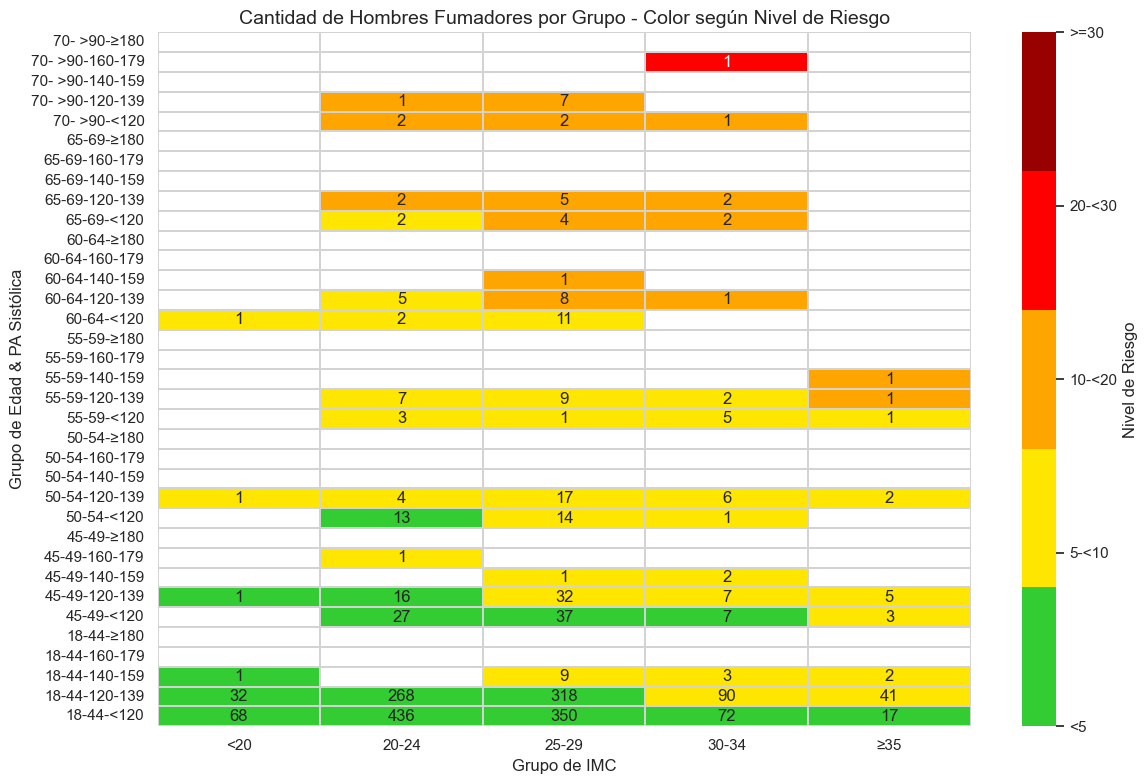

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

# 1. Agrupar: moda de riesgo (color) y conteo de personas (número en las celdas)
risk_avg = df.groupby(
    ['Grupo Edad', 'Grupo PA', 'Grupo IMC'], observed=False
)['Cardio Risk level'].mean().unstack()

count_data = df.groupby(
    ['Grupo Edad', 'Grupo PA', 'Grupo IMC'], observed=False
).size().unstack()

# 2. Ordenar para que el eje Y vaya de mayor a menor
risk_avg = risk_avg.sort_index(ascending=False)
count_data = count_data.reindex(risk_avg.index)

# 3. Definir paleta de colores fijos
colores_fijos = [
    "#33CC33",  # Verde - Riesgo <5
    "#FFE600",  # Amarillo - Riesgo 5-<10
    "#FFA500",  # Naranja - Riesgo 10-<20
    "#FF0000",  # Rojo - Riesgo 20-<30
    "#990000"   # Vinotinto - Riesgo >=30
]
cmap_discreto = ListedColormap(colores_fijos)
etiquetas_riesgo = ['<5', '5-<10', '10-<20', '20-<30', '>=30']

# 4. Crear figura y graficar heatmap
fig, ax = plt.subplots(figsize=(12, 8))

hm = sns.heatmap(
    risk_avg,
    cmap=cmap_discreto,
    annot=count_data,
    fmt=".0f",
    linewidths=0.003,
    linecolor="lightgrey",
    ax=ax,
    vmin=0,
    vmax=4,
    cbar_kws={"label": "Nivel de Riesgo", "ticks": [0, 1, 2, 3, 4]}
)

# 5. Personalizar el colorbar
colorbar = hm.collections[0].colorbar
colorbar.set_ticklabels(etiquetas_riesgo)

# 6. Estética del gráfico
ax.set_facecolor("#ffffff")
plt.title("Cantidad de Hombres Fumadores por Grupo - Color según Nivel de Riesgo", fontsize=14)
plt.xlabel("Grupo de IMC")
plt.ylabel("Grupo de Edad & PA Sistólica")
plt.tight_layout()
plt.show()

#### Hombres No Fumadores

In [134]:
## HOMBRES NO FUMADORES
import re
# 1. Función de limpieza de texto
def limpiar(txt):
    if pd.isna(txt):
        return ''
    txt = unicodedata.normalize('NFKD', str(txt))
    return ''.join(c for c in txt if not unicodedata.combining(c)).upper().strip()

# 2. Listas de diagnósticos
enf_cardio = [ "HIPERTENSION ESENCIAL (PRIMARIA)", "HIPERTENSION SECUNDARIA, NO ESPECIFICADA",
    "HIPERTENSION PULMONAR PRIMARIA",
    "HIPERTENSION RENOVASCULAR","HIPERTENSION",
    "HIPERTENSION PORTAL",
    "CARDIACA", "TAQUICARDIA SUPRAVENTRICULAR","TAQUICARDIA PAROXISTICA",
    "ARRITMIA CARDIACA, NO ESPECIFICADA",
    "CARDIOMIOPATIA ISQUEMICA",
    "ENFERMEDAD ATEROSCLEROTICA DEL CORAZON",
    "BRADICARDIA, NO ESPECIFICADA",
    "FIBRILACION Y ALETEO AURICULAR",
    "PRESENCIA DE MARCAPASO CARDIACO",
    "ENFERMEDAD ISQUEMICA CRONICA DEL CORAZON",
    "INFARTO ANTIGUO DEL MIOCARDIO",
    "INFARTO AGUDO DEL MIOCARDIO",
    "ANGINA DE PECHO",
    "ARRITMIA POR REENTRADA VENTRICULAR",
    "TAQUICARDIA, SUPRAVENTRICULAR O PAROXISTICA",
    "INSUFICIENCIA CARDIACA",
    "ANEURISMA DE ARTERIA CORONARIA",
    "PRESENCIA DE VALVULA CARDIACA PROTESICA",
    "CARDIOMIOPATIA DILATADA",
    "OTRAS CARDIOMIOPATIA HIPERTROFICAS","CORONARIO",
    "OTRAS CARDIOMIOPATIA",
    "RESULTADOS ANORMALES EN ESTUDIOS FUNCIONALES CARDIOVASCULARES",
    "TROMBOSIS CORONARIA","CORONARIA", "BRADICARDIA",
    "ENFERMEDAD CARDIOVASCULAR ATEROSCLEROTICA",
    "ENFERMEDAD CARDIOVASCULAR, NO ESPECIFICADA", "EMBOLIA",
    "CARDIOPULMONARES", "CARDIOMEGALIA", "INFARTO", "MIOCARDIO", "PERICARDIO", "CORAZON",
    "VASCULITIS REUMATOIDE", "CARDIOMIOPATIA", "CARDIOVASCULAR", 
    "FLEBITIS Y TROMBOFLEBITIS","VASCULAR"
]

enf_diabetes_renal = [
    "OTRAS DIABETES MELLITUS",
    "DIABETES",
    "DIABETES MELLITUS CON COMPLICACIONES CIRCULATORIAS PERIFERICAS",
    "DIABETES MELLITUS NO INSULINODEPENDIENTE", "DIABETES MELLITUS INSULINODEPENDIENTE","RENAL"
]

# 3. Crear patrones
patron1 = '|'.join([limpiar(e) for e in enf_cardio])
patron2 = '|'.join([limpiar(e) for e in enf_diabetes_renal])


# 4. Clasificación OMS Hombres No fumadores  
riesgo_tabla = {
    (18, 44):   [[1, 1, 1, 2, 2],  # SBP <120
                 [1, 2, 2, 2, 3],  # SBP 120-139
                 [2, 2, 3, 3, 4],  # SBP 140-159
                 [3, 3, 4, 4, 5],  # SBP 160-179
                 [4, 5, 5, 6, 8]], # SBP ≥180

    (45, 49):   [[1, 2, 2, 2, 3],  
                 [2, 2, 3, 3, 4],  
                 [3, 3, 4, 4, 5],  
                 [4, 4, 5, 6, 7],  
                 [5, 6, 7, 8, 9]],  

    (50, 54):   [[2, 2, 3, 3, 3],  
                 [3, 3, 3, 4, 5],  
                 [4, 4, 5, 5, 6],  
                 [5, 6, 6, 7, 9],  
                 [7, 8, 9, 10, 12]],  

    (55, 59):   [[3, 3, 4, 4, 5],  
                 [4, 4, 5, 5, 6],  
                 [5, 6, 6, 7, 8],  
                 [7, 7, 8, 10, 11],  
                 [9, 10, 11, 13, 14]],  

    (60, 64):   [[4, 5, 5, 6, 6],  
                 [5, 6, 7, 7, 8],  
                 [7, 8, 9, 10, 11],  
                 [9, 10, 11, 12, 14],  
                 [11, 13, 14, 16, 18]],  

    (65, 69):   [[6, 7, 7, 8, 9],  
                 [8, 8, 9, 10, 11],  
                 [10, 10, 11, 13, 14],  
                 [12, 13, 14, 16, 17],  
                 [15, 16, 18, 20, 22]],  

    (70, 100):   [[9, 9, 10, 11, 12],  
                 [11, 12, 12, 13, 14],  
                 [13, 14, 15, 16, 18],  
                 [16, 17, 19, 20, 22],  
                 [20, 21, 23, 25, 26]]  
}


def clasificar_riesgo(edad, imc, tension_sis):
    for rango_edad in riesgo_tabla.keys():
        if rango_edad[0] <= edad <= rango_edad[1]:
            tabla_edad = riesgo_tabla[rango_edad]
            break
    else:
        return '>30'  # Edad fuera de rango / Si la edad está fuera del rango, asumir máximo riesgo

    imc_rangos = [(float('-inf'), 19.999), (20, 24.999), (25.00, 29.99), (30, 34.99), (35, float('inf'))]
    for imc_idx, (imc_min, imc_max) in enumerate(imc_rangos):
        if imc_min <= imc <= imc_max:
            break
    else:
        return 'Desconocido'

    tension_rangos = [120, 140, 160, 180]
    for tension_idx, tension_umbral in enumerate(tension_rangos):
        if tension_sis < tension_umbral:
            break
    else:
        tension_idx = len(tension_rangos)

    riesgo = tabla_edad[tension_idx][imc_idx]
    if riesgo < 5:
        return '<5'
    elif 5 <= riesgo < 10:
        return '5-<10'
    elif 10 <= riesgo < 20:
        return '10-<20'
    elif 20 <= riesgo < 30:
        return '20-<30'
    else:
        return '>=30'


# Aplicacion en df
# 4. Limpiar columnas
Hombres_no_fumadores_riesgo_40_df = Hombres_no_fumadores_May_40.copy()
Hombres_no_fumadores_riesgo_40_df['diagnostic_clean_1'] = Hombres_no_fumadores_riesgo_40_df['diagnostic_name_1'].fillna('').apply(limpiar)
Hombres_no_fumadores_riesgo_40_df['diagnostic_clean_2'] = Hombres_no_fumadores_riesgo_40_df['diagnostic_name_2'].fillna('').apply(limpiar)

# Crear columna 'tipo_diagnostico' para identificar
def clasificar_tipo_diagnostico(row):
    texto = row['diagnostic_clean_1'] + ' ' + row['diagnostic_clean_2']
    tiene_cardio = bool(re.search(patron1, texto))
    tiene_renal = bool(re.search(patron2, texto))
    
    if tiene_cardio and tiene_renal:
        return 'Cardio y Renal'
    elif tiene_cardio:
        return 'Cardio'
    elif tiene_renal:
        return 'Renal/Diabetes'
    else:
        return 'No aplica'

Hombres_no_fumadores_riesgo_40_df['tipo_diagnostico'] = Hombres_no_fumadores_riesgo_40_df.apply(clasificar_tipo_diagnostico, axis=1)

# 5. Inicializar columna de riesgo
Hombres_no_fumadores_riesgo_40_df['Cardio Risk level'] = '<30'

# 6. Aplicar riesgo '20-30' si contiene diagnóstico cardiovascular crítico
Hombres_no_fumadores_riesgo_40_df.loc[
    Hombres_no_fumadores_riesgo_40_df['diagnostic_clean_1'].str.contains(patron1, na=False) |
    Hombres_no_fumadores_riesgo_40_df['diagnostic_clean_2'].str.contains(patron1, na=False),
    'Cardio Risk level'
] = '20-30'

# 7. Aplicar riesgo '>10-20' solo si aún está en <30
Hombres_no_fumadores_riesgo_40_df.loc[
    (Hombres_no_fumadores_riesgo_40_df['Cardio Risk level'] == '<30') & (
        Hombres_no_fumadores_riesgo_40_df['diagnostic_clean_1'].str.contains(patron2, na=False) |
        Hombres_no_fumadores_riesgo_40_df['diagnostic_clean_2'].str.contains(patron2, na=False)
    ),
    'Cardio Risk level'
] = '10-20'


# 8. Conversión a valores numéricos
Hombres_no_fumadores_riesgo_40_df['tension_arte_sis'] = pd.to_numeric(Hombres_no_fumadores_riesgo_40_df['tension_arte_sis'], errors='coerce')
Hombres_no_fumadores_riesgo_40_df['imc'] = pd.to_numeric(Hombres_no_fumadores_riesgo_40_df['imc'], errors='coerce')
Hombres_no_fumadores_riesgo_40_df['edad'] = pd.to_numeric(Hombres_no_fumadores_riesgo_40_df['edad'], errors='coerce')

# 9. Aplicar clasificación OMS SOLO si riesgo aún es <30
mask_riesgo_oms = Hombres_no_fumadores_riesgo_40_df['Cardio Risk level'].isin(['<30'])
Hombres_no_fumadores_riesgo_40_df.loc[mask_riesgo_oms, 'Cardio Risk level'] = Hombres_no_fumadores_riesgo_40_df.loc[mask_riesgo_oms].apply(
    lambda x: clasificar_riesgo(x['edad'], x['imc'], x['tension_arte_sis']),
    axis=1  
)

# 10. Ver resultados
print(Hombres_no_fumadores_riesgo_40_df[['diagnostic_name_1', 'diagnostic_name_2', 'tipo_diagnostico','edad', 'imc', 'tension_arte_sis', 'Cardio Risk level']].head(30))

C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\1259448549.py:164: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\1259448549.py:165: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



                                       diagnostic_name_1  \
15868                              EXAMEN MEDICO GENERAL   
15871        ESGUINCES Y TORCEDURAS DE LA COLUMNA LUMBAR   
15960                        ESCOLIOSIS, NO ESPECIFICADA   
16008               OBESIDAD DEBIDA A EXCESO DE CALORIAS   
16025                       OTRAS ESCOLIOSIS SECUNDARIAS   
16050                              ADIPOSIDAD LOCALIZADA   
16063                            LUMBAGO NO ESPECIFICADO   
16112                          OBESIDAD, NO ESPECIFICADA   
16149                                   CIFOSIS POSTURAL   
16154                            AUMENTO ANORMAL DE PESO   
16166  ESTADO DE INFECCION ASINTOMATICA POR EL VIRUS ...   
16181                              ADIPOSIDAD LOCALIZADA   
16190  DIABETES MELLITUS NO INSULINODEPENDIENTE SIN M...   
16198                              EXAMEN MEDICO GENERAL   
16205                 ARRITMIA CARDIACA, NO ESPECIFICADA   
16223                           OTROS EX

In [135]:
Hombres_no_fumadores_riesgo_40_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21267 entries, 15868 to 319291
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                21267 non-null  float64       
 1   sesiones_en_la_semana      21267 non-null  float64       
 2   member_id_y                21267 non-null  float64       
 3   minutos_por_semana         21267 non-null  float64       
 4   nivel_actividad_time       21267 non-null  object        
 5   document_number            21267 non-null  object        
 6   tipo_vinculacion           21267 non-null  object        
 7   ocupacion                  21267 non-null  object        
 8   eps                        21266 non-null  object        
 9   territorial_zone           21267 non-null  object        
 10  date                       21267 non-null  datetime64[ns]
 11  user_id                    21267 non-null  int64         
 12  date

In [136]:
# Hombres_no_fumadores_riesgo_40_df = Hombres_no_fumadores_riesgo_40_df[['user_id','Cardio Risk level', 'genre', 'tipo_diagnostico', 'edad', 'tension_arte_sis', 'Tabaquismo', 'imc']]
# Risk level encoding
risk_mapping = {'<5': 0, '5-<10': 1, '10-20':2, '10-<20': 2, '20-30':3, '20-<30': 3, '>=30': 4}
Hombres_no_fumadores_riesgo_40_df['Cardio Risk level'] = Hombres_no_fumadores_riesgo_40_df['Cardio Risk level'].map(risk_mapping)

# Genre encoding
if Hombres_no_fumadores_riesgo_40_df['genre'].nunique() == 1:
    Hombres_no_fumadores_riesgo_40_df.drop(columns=['genre'], inplace=True)  # Se elimina porque solo tiene "Masculino"

# Tabaquismo encoding
if Hombres_no_fumadores_riesgo_40_df['Tabaquismo'].nunique() == 1:
    Hombres_no_fumadores_riesgo_40_df.drop(columns=['Tabaquismo'], inplace=True) 

In [137]:
#Hombres_no_fumadores_riesgo_40_df.to_excel("BaseHF.xlsx", index=False)

In [138]:
Hombres_no_fumadores_riesgo_40_df['genero'] = "1"
Hombres_no_fumadores_riesgo_40_df['Tabaquismo'] = "NO"

df_2 = Hombres_no_fumadores_riesgo_40_df.copy()

In [139]:
df_2.head()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
15868     798767.0                    3.0     798767.0             390.510   
15871     237546.0                    2.0     237546.0             196.510   
15960     524052.0                    4.0     524052.0             665.280   
16008     600426.0                    2.5     600426.0             211.985   
16025     208727.0                    3.0     208727.0             312.850   

      nivel_actividad_time document_number tipo_vinculacion  \
15868           Muy Activo      1233488610    Contributivo    
15871               Activo        13504600    Contributivo    
15960           Muy Activo      1020774905    Contributivo    
16008               Activo      1091663207    Contributivo    
16025           Muy Activo        80387283    Contributivo    

                                   ocupacion  \
15868                             ECONOMISTA   
15871  DOCENTE DE EDUCACION SUPERIOR TECNICA   
15960                       AUDITOR CONTABLE   
16008                  DOCENTE DE PREESCOLAR   
16025                    INGENIERO AMBIENTAL   

                                                     eps territorial_zone  \
15868  NUEVA EMPRESA PROMOTORA DE SALUD S.A. SIGLA NU...            Rural   
15871   RES FONDODE PRESTACIONES SOCIALES DEL MAGISTERIO           Urbana   
15960  ENTIDAD PROMOTORA DE SALUD SANITAS S.A. - E.P....           Urbana   
16008                                  EPS SELVASALUD SA           Urbana   
16025  ENTIDAD PROMOTORA DE SALUD SANITAS S.A. - E.P....           Urbana   

       ...                           diagnostic_clean_2  \
15868  ...                        EXAMEN MEDICO GENERAL   
15871  ...  ESGUINCES Y TORCEDURAS DE LA COLUMNA LUMBAR   
15960  ...                  ESCOLIOSIS, NO ESPECIFICADA   
16008  ...         OBESIDAD DEBIDA A EXCESO DE CALORIAS   
16025  ...                 OTRAS ESCOLIOSIS SECUNDARIAS   

       diagnostico_hipertension diagnostico_cardio  diagnostico_diabetes  \
15868                        No                 No                    No   
15871                        No                 No                    No   
15960                        No                 No                    No   
16008                        No                 No                    No   
16025                        No                 No                    No   

       diagnostico_renal  diagnostico_dislipidemia  tipo_diagnostico  \
15868                 No                        No         No aplica   
15871                 No                        No         No aplica   
15960                 No                        No         No aplica   
16008                 No                        No         No aplica   
16025                 No                        No         No aplica   

       Cardio Risk level  genero  Tabaquismo  
15868                  0       1          NO  
15871                  0       1          NO  
15960                  0       1          NO  
16008                  0       1          NO  
16025                  0       1          NO  

[5 rows x 77 columns]

In [140]:
# Visualización
# Edad
bins_edad = [18, 45, 50, 55, 60, 65, 70, 120]  # 18-44, 45-49, 50-54
# Definir las etiquetas correspondientes
labels_edad = ["18-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70- >90"]
Hombres_no_fumadores_riesgo_40_df['Grupo Edad'] = pd.cut(Hombres_no_fumadores_riesgo_40_df['edad'], bins=bins_edad, labels=labels_edad, right=False)

# Presión Arterial Sistólica
bins_pa = [0, 120, 140, 160, 180, float("inf")]
labels_pa = ["<120", "120-139", "140-159", "160-179", "≥180"]
Hombres_no_fumadores_riesgo_40_df['Grupo PA'] = pd.cut(Hombres_no_fumadores_riesgo_40_df['tension_arte_sis'], bins=bins_pa, labels=labels_pa, right=False)

# IMC
bins_imc = [0, 20, 25, 30, 35, float("inf")]
labels_imc = ["<20", "20-24", "25-29", "30-34", "≥35"]
Hombres_no_fumadores_riesgo_40_df['Grupo IMC'] = pd.cut(Hombres_no_fumadores_riesgo_40_df['imc'], bins=bins_imc, labels=labels_imc, right=False)


In [141]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Estilo limpio
pio.templates.default = "plotly_white"

# Copiar y preparar datos
df = Hombres_no_fumadores_riesgo_40_df.copy()
df['Cardio Risk level'] = df['Cardio Risk level'].astype(str)
df['Grupo Edad'] = df['Grupo Edad'].astype(str)

# Agrupar
df_grouped = df.groupby(['Cardio Risk level', 'Grupo Edad']).agg(
    Cantidad=('user_id', 'count'),
    IMC_promedio=('imc', 'mean'),
    Tension_promedio=('tension_arte_sis', 'mean')
).reset_index()

# Paleta categórica clara
color_palette = px.colors.qualitative.Set2 

# Gráfico de burbujas facetado
color_palette = px.colors.qualitative.Bold

fig = px.scatter(
    df_grouped,
    x='IMC_promedio',
    y='Tension_promedio',
    size='Cantidad',
    color='Grupo Edad',
    facet_col='Cardio Risk level',
    facet_col_wrap=3,
    color_discrete_sequence=color_palette,
    title='Distribución de IMC y Tensión por Nivel de Riesgo Cardiovascular',
    labels={
        'IMC_promedio': 'Promedio de IMC',
        'Tension_promedio': 'Presión Sistólica Promedio',
        'Cantidad': 'Nro de Personas'
    },
    size_max=60,
    custom_data=['Grupo Edad']
)

# Mejorar visual

fig.update_layout(
    height=850,
    title_font=dict(size=20, family='Helvetica', color='black'),
    font=dict(family='Helvetica', size=12, color='black'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(t=70, l=50, r=30, b=60),
    coloraxis_showscale=False
)

# Mostrar ejes en todas las facetas
fig.for_each_xaxis(lambda ax: ax.update(title='Promedio de IMC', showticklabels=True))
fig.for_each_yaxis(lambda ay: ay.update(title='Presión Sistólica Promedio', showticklabels=True))

# Hover detallado
fig.update_traces(
    hovertemplate="<b>Edad:</b> %{customdata[0]}<br>" +
                  "<b>IMC:</b> %{x:.1f}<br>" +
                  "<b>Tensión:</b> %{y:.1f}<br>" +
                  "<b>Personas:</b> %{marker.size}"
)

# Línea guía en IMC=25
fig.add_shape(
    type="line",
    x0=25, x1=25,
    y0=df_grouped['Tension_promedio'].min(),
    y1=df_grouped['Tension_promedio'].max(),
    line=dict(color="gray", dash="dash"),
    layer='below'
)

fig.show()

In [142]:
Hombres_no_fumadores_riesgo_40_df.head()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
15868     798767.0                    3.0     798767.0             390.510   
15871     237546.0                    2.0     237546.0             196.510   
15960     524052.0                    4.0     524052.0             665.280   
16008     600426.0                    2.5     600426.0             211.985   
16025     208727.0                    3.0     208727.0             312.850   

      nivel_actividad_time document_number tipo_vinculacion  \
15868           Muy Activo      1233488610    Contributivo    
15871               Activo        13504600    Contributivo    
15960           Muy Activo      1020774905    Contributivo    
16008               Activo      1091663207    Contributivo    
16025           Muy Activo        80387283    Contributivo    

                                   ocupacion  \
15868                             ECONOMISTA   
15871  DOCENTE DE EDUCACION SUPERIOR TECNICA   
15960                       AUDITOR CONTABLE   
16008                  DOCENTE DE PREESCOLAR   
16025                    INGENIERO AMBIENTAL   

                                                     eps territorial_zone  \
15868  NUEVA EMPRESA PROMOTORA DE SALUD S.A. SIGLA NU...            Rural   
15871   RES FONDODE PRESTACIONES SOCIALES DEL MAGISTERIO           Urbana   
15960  ENTIDAD PROMOTORA DE SALUD SANITAS S.A. - E.P....           Urbana   
16008                                  EPS SELVASALUD SA           Urbana   
16025  ENTIDAD PROMOTORA DE SALUD SANITAS S.A. - E.P....           Urbana   

       ... diagnostico_diabetes  diagnostico_renal diagnostico_dislipidemia  \
15868  ...                   No                 No                       No   
15871  ...                   No                 No                       No   
15960  ...                   No                 No                       No   
16008  ...                   No                 No                       No   
16025  ...                   No                 No                       No   

       tipo_diagnostico  Cardio Risk level  genero  Tabaquismo  Grupo Edad  \
15868         No aplica                  0       1          NO       18-44   
15871         No aplica                  0       1          NO       55-59   
15960         No aplica                  0       1          NO       18-44   
16008         No aplica                  0       1          NO       18-44   
16025         No aplica                  0       1          NO       45-49   

       Grupo PA  Grupo IMC  
15868   120-139      20-24  
15871   120-139      20-24  
15960   120-139      25-29  
16008   120-139      25-29  
16025   120-139      25-29  

[5 rows x 80 columns]

In [143]:
#Se filtran los que no tienen una enfermedad cronica para sacar la matriz de oms 
df=Hombres_no_fumadores_riesgo_40_df[Hombres_no_fumadores_riesgo_40_df['tipo_diagnostico'] == 'No aplica']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19767 entries, 15868 to 319291
Data columns (total 80 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                19767 non-null  float64       
 1   sesiones_en_la_semana      19767 non-null  float64       
 2   member_id_y                19767 non-null  float64       
 3   minutos_por_semana         19767 non-null  float64       
 4   nivel_actividad_time       19767 non-null  object        
 5   document_number            19767 non-null  object        
 6   tipo_vinculacion           19767 non-null  object        
 7   ocupacion                  19767 non-null  object        
 8   eps                        19766 non-null  object        
 9   territorial_zone           19767 non-null  object        
 10  date                       19767 non-null  datetime64[ns]
 11  user_id                    19767 non-null  int64         
 12  date

##### Resultado Matriz Aplicada 

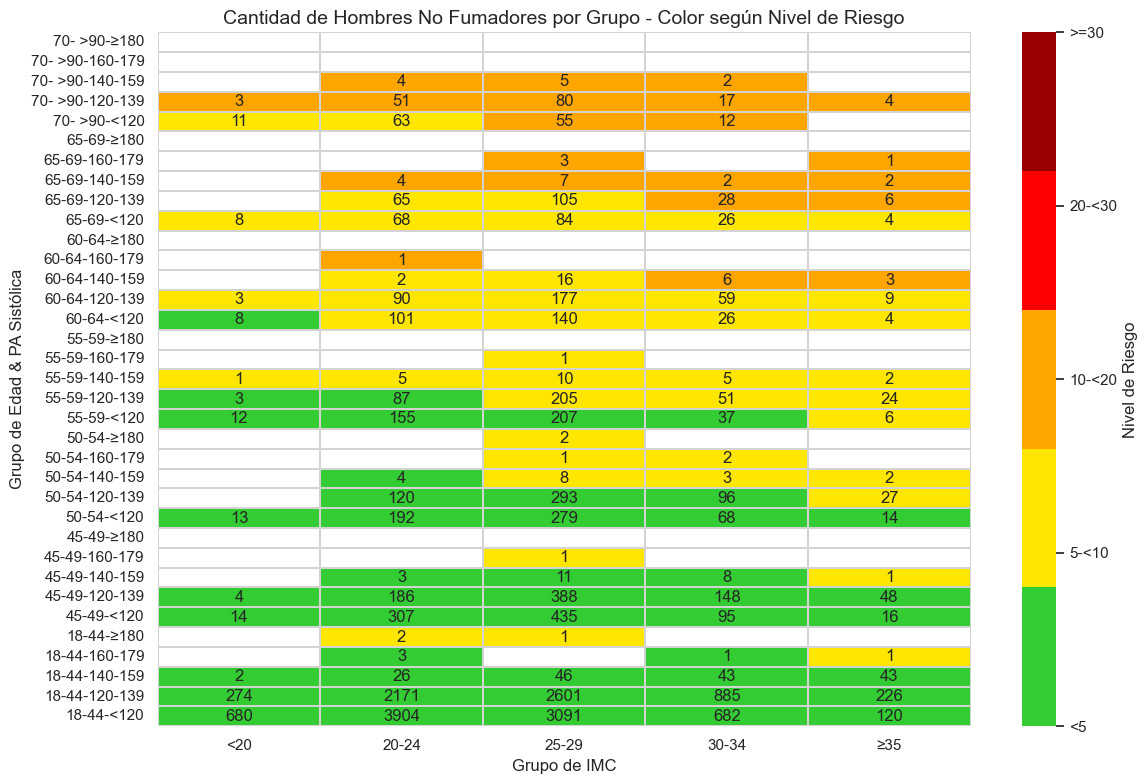

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

# 1. Agrupar: moda de riesgo (color) y conteo de personas (número en las celdas)
risk_avg = df.groupby(
    ['Grupo Edad', 'Grupo PA', 'Grupo IMC'], observed=False
)['Cardio Risk level'].mean().unstack()

count_data = df.groupby(
    ['Grupo Edad', 'Grupo PA', 'Grupo IMC'], observed=False
).size().unstack()

# 2. Ordenar para que el eje Y vaya de mayor a menor
risk_avg = risk_avg.sort_index(ascending=False)
count_data = count_data.reindex(risk_avg.index)

# 3. Definir paleta de colores fijos
colores_fijos = [
    "#33CC33",  # Verde - Riesgo <5
    "#FFE600",  # Amarillo - Riesgo 5-<10
    "#FFA500",  # Naranja - Riesgo 10-<20
    "#FF0000",  # Rojo - Riesgo 20-<30
    "#990000"   # Vinotinto - Riesgo >=30
]
cmap_discreto = ListedColormap(colores_fijos)
etiquetas_riesgo = ['<5', '5-<10', '10-<20', '20-<30', '>=30']

# 4. Crear figura y graficar heatmap
fig, ax = plt.subplots(figsize=(12, 8))

hm = sns.heatmap(
    risk_avg,
    cmap=cmap_discreto,
    annot=count_data,
    fmt=".0f",
    linewidths=0.003,
    linecolor="lightgrey",
    ax=ax,
    vmin=0,
    vmax=4,
    cbar_kws={"label": "Nivel de Riesgo", "ticks": [0, 1, 2, 3, 4]}
)

# 5. Personalizar el colorbar
colorbar = hm.collections[0].colorbar
colorbar.set_ticklabels(etiquetas_riesgo)

# 6. Estética del gráfico
ax.set_facecolor("#ffffff")
plt.title("Cantidad de Hombres No Fumadores por Grupo - Color según Nivel de Riesgo", fontsize=14)
plt.xlabel("Grupo de IMC")
plt.ylabel("Grupo de Edad & PA Sistólica")
plt.tight_layout()
plt.show()

In [145]:
Hombres_no_fumadores_riesgo_40_df['tipo_diagnostico'].value_counts()

tipo_diagnostico
No aplica         19767
Cardio             1279
Renal/Diabetes      221
Name: count, dtype: int64

### Clasificación Riesgo Mujeres

#### Mujeres No Fumadoras

In [146]:
## Mujeres NO FUMADORAS
import re
# 1. Función de limpieza de texto
def limpiar(txt):
    if pd.isna(txt):
        return ''
    txt = unicodedata.normalize('NFKD', str(txt))
    return ''.join(c for c in txt if not unicodedata.combining(c)).upper().strip()

# 2. Listas de diagnósticos
enf_cardio = [
    "HIPERTENSION ESENCIAL (PRIMARIA)", "HIPERTENSION SECUNDARIA, NO ESPECIFICADA",
    "HIPERTENSION PULMONAR PRIMARIA",
    "HIPERTENSION RENOVASCULAR","HIPERTENSION",
    "HIPERTENSION PORTAL",
    "CARDIACA", "TAQUICARDIA SUPRAVENTRICULAR","TAQUICARDIA PAROXISTICA",
    "ARRITMIA CARDIACA, NO ESPECIFICADA",
    "CARDIOMIOPATIA ISQUEMICA",
    "ENFERMEDAD ATEROSCLEROTICA DEL CORAZON",
    "BRADICARDIA, NO ESPECIFICADA",
    "FIBRILACION Y ALETEO AURICULAR",
    "PRESENCIA DE MARCAPASO CARDIACO",
    "ENFERMEDAD ISQUEMICA CRONICA DEL CORAZON",
    "INFARTO ANTIGUO DEL MIOCARDIO",
    "INFARTO AGUDO DEL MIOCARDIO",
    "ANGINA DE PECHO",
    "ARRITMIA POR REENTRADA VENTRICULAR",
    "TAQUICARDIA, SUPRAVENTRICULAR O PAROXISTICA",
    "INSUFICIENCIA CARDIACA",
    "ANEURISMA DE ARTERIA CORONARIA",
    "PRESENCIA DE VALVULA CARDIACA PROTESICA",
    "CARDIOMIOPATIA DILATADA",
    "OTRAS CARDIOMIOPATIA HIPERTROFICAS","CORONARIO",
    "OTRAS CARDIOMIOPATIA",
    "RESULTADOS ANORMALES EN ESTUDIOS FUNCIONALES CARDIOVASCULARES",
    "TROMBOSIS CORONARIA","CORONARIA", "BRADICARDIA",
    "ENFERMEDAD CARDIOVASCULAR ATEROSCLEROTICA",
    "ENFERMEDAD CARDIOVASCULAR, NO ESPECIFICADA", "EMBOLIA",
    "CARDIOPULMONARES", "CARDIOMEGALIA", "INFARTO", "MIOCARDIO", "PERICARDIO", "CORAZON",
    "VASCULITIS REUMATOIDE", "CARDIOMIOPATIA", "CARDIOVASCULAR", 
    "FLEBITIS Y TROMBOFLEBITIS","VASCULAR"
]

enf_diabetes_renal = ["OTRAS DIABETES MELLITUS",
    "DIABETES",
    "DIABETES MELLITUS CON COMPLICACIONES CIRCULATORIAS PERIFERICAS",
    "DIABETES MELLITUS NO INSULINODEPENDIENTE", "DIABETES MELLITUS INSULINODEPENDIENTE","RENAL"
]

# 3. Crear patrones
patron1 = '|'.join([limpiar(e) for e in enf_cardio])
patron2 = '|'.join([limpiar(e) for e in enf_diabetes_renal])


# 4. Clasificación OMS mujeres  no fumadoras 
riesgo_tabla = {
    (18, 44):   [[1, 1, 1, 1, 1],  # SBP <120
                 [1, 1, 2, 2, 2],  # SBP 120-139
                 [2, 2, 2, 2, 2,], # SBP 140-159
                 [3, 3, 3, 3, 3],  # SBP 160-179
                 [4, 4, 4, 4, 4]], # SBP ≥180

    (45, 49):   [[1, 1, 2, 2, 2],  
                 [2, 2, 2, 2, 2],  
                 [2, 3, 3, 3, 3],  
                 [3, 4, 4, 4, 4],  
                 [5, 5, 5, 5, 6]],  

    (50, 54):   [[2, 2, 2, 2, 2],  
                 [3, 3, 3, 3, 3],  
                 [4, 4, 4, 4, 4],  
                 [4, 5, 5, 5, 6],  
                 [6, 6, 6, 7, 7]],  

    (55, 59):   [[3, 3, 3, 3, 3],  
                 [4, 4, 4, 4, 4],  
                 [5, 5, 5, 5, 6],  
                 [6, 6, 6, 7, 7],  
                 [7, 8, 8, 9, 9]],  

    (60, 64):   [[4, 4, 4, 5, 5],  
                 [5, 5, 5, 6, 6],  
                 [6, 6, 7, 7, 7],  
                 [8, 8, 8, 9, 9],  
                 [10, 10, 11, 11, 12]],  

    (65, 69):   [[6, 6, 6, 6, 7],  
                 [7, 7, 7, 8, 8],  
                 [8, 9, 9, 10, 10],  
                 [10, 11, 11, 12, 12],  
                 [13, 13, 14, 14, 15]],  

    (70, 100):   [[8, 8, 8, 9, 9],   
                 [9, 10, 10, 11, 11],  
                 [11, 12, 12, 13, 13],  
                 [14, 14, 15, 15, 16],  
                 [16, 17, 18, 18, 19]]  
}


def clasificar_riesgo(edad, imc, tension_sis):
    for rango_edad in riesgo_tabla.keys():
        if rango_edad[0] <= edad <= rango_edad[1]:
            tabla_edad = riesgo_tabla[rango_edad]
            break
    else:
        return '>30'  # Edad fuera de rango / Si la edad está fuera del rango, asumir máximo riesgo

    imc_rangos = [(float('-inf'), 19.999), (20, 24.999), (25.00, 29.99), (30, 34.99), (35, float('inf'))]
    for imc_idx, (imc_min, imc_max) in enumerate(imc_rangos):
        if imc_min <= imc <= imc_max:
            break
    else:
        return 'Desconocido'

    tension_rangos = [120, 140, 160, 180]
    for tension_idx, tension_umbral in enumerate(tension_rangos):
        if tension_sis < tension_umbral:
            break
    else:
        tension_idx = len(tension_rangos)

    riesgo = tabla_edad[tension_idx][imc_idx]
    if riesgo < 5:
        return '<5'
    elif 5 <= riesgo < 10:
        return '5-<10'
    elif 10 <= riesgo < 20:
        return '10-<20'
    elif 20 <= riesgo < 30:
        return '20-<30'
    else:
        return '>=30'


# Aplicacion en df
# 4. Limpiar columnas
Mujeres_no_fumadoras_riesgo_40_df = Mujeres_no_fumadoras_May_40.copy()
Mujeres_no_fumadoras_riesgo_40_df['diagnostic_clean_1'] = Mujeres_no_fumadoras_riesgo_40_df['diagnostic_name_1'].fillna('').apply(limpiar)
Mujeres_no_fumadoras_riesgo_40_df['diagnostic_clean_2'] = Mujeres_no_fumadoras_riesgo_40_df['diagnostic_name_2'].fillna('').apply(limpiar)

# Crear columna 'tipo_diagnostico' para identificar
def clasificar_tipo_diagnostico(row):
    texto = row['diagnostic_clean_1'] + ' ' + row['diagnostic_clean_2']
    tiene_cardio = bool(re.search(patron1, texto))
    tiene_renal = bool(re.search(patron2, texto))
    
    if tiene_cardio and tiene_renal:
        return 'Cardio y Renal'
    elif tiene_cardio:
        return 'Cardio'
    elif tiene_renal:
        return 'Renal/Diabetes'
    else:
        return 'No aplica'

Mujeres_no_fumadoras_riesgo_40_df['tipo_diagnostico'] = Mujeres_no_fumadoras_riesgo_40_df.apply(clasificar_tipo_diagnostico, axis=1)

# 5. Inicializar columna de riesgo
Mujeres_no_fumadoras_riesgo_40_df['Cardio Risk level'] = '<30'

# 6. Aplicar riesgo '20-30' si contiene diagnóstico cardiovascular crítico
Mujeres_no_fumadoras_riesgo_40_df.loc[
    Mujeres_no_fumadoras_riesgo_40_df['diagnostic_clean_1'].str.contains(patron1, na=False) |
    Mujeres_no_fumadoras_riesgo_40_df['diagnostic_clean_2'].str.contains(patron1, na=False),
    'Cardio Risk level'
] = '20-30'

# 7. Aplicar riesgo '>10-20' solo si aún está en <30
Mujeres_no_fumadoras_riesgo_40_df.loc[
    (Mujeres_no_fumadoras_riesgo_40_df['Cardio Risk level'] == '<30') & (
        Mujeres_no_fumadoras_riesgo_40_df['diagnostic_clean_1'].str.contains(patron2, na=False) |
        Mujeres_no_fumadoras_riesgo_40_df['diagnostic_clean_2'].str.contains(patron2, na=False)
    ),
    'Cardio Risk level'
] = '10-20'


# 8. Conversión a valores numéricos
Mujeres_no_fumadoras_riesgo_40_df['tension_arte_sis'] = pd.to_numeric(Mujeres_no_fumadoras_riesgo_40_df['tension_arte_sis'], errors='coerce')
Mujeres_no_fumadoras_riesgo_40_df['imc'] = pd.to_numeric(Mujeres_no_fumadoras_riesgo_40_df['imc'], errors='coerce')
Mujeres_no_fumadoras_riesgo_40_df['edad'] = pd.to_numeric(Mujeres_no_fumadoras_riesgo_40_df['edad'], errors='coerce')

# 9. Aplicar clasificación OMS SOLO si riesgo aún es <30
mask_riesgo_oms = Mujeres_no_fumadoras_riesgo_40_df['Cardio Risk level'].isin(['<30'])
Mujeres_no_fumadoras_riesgo_40_df.loc[mask_riesgo_oms, 'Cardio Risk level'] = Mujeres_no_fumadoras_riesgo_40_df.loc[mask_riesgo_oms].apply(
    lambda x: clasificar_riesgo(x['edad'], x['imc'], x['tension_arte_sis']),
    axis=1  
)

# 10. Ver resultados
print(Mujeres_no_fumadoras_riesgo_40_df[['diagnostic_name_1', 'diagnostic_name_2', 'tipo_diagnostico','edad', 'imc', 'tension_arte_sis', 'Cardio Risk level']].head(30))

C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\1304608524.py:164: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\1304608524.py:165: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



                                       diagnostic_name_1  \
15848                              EXAMEN MEDICO GENERAL   
15865                            AUMENTO ANORMAL DE PESO   
15867                     SINDROME DE MANGUITO ROTATORIO   
15886                              EXAMEN MEDICO GENERAL   
15924                        ESCOLIOSIS, NO ESPECIFICADA   
15987                         CONDROMALACIA DE LA ROTULA   
15994                               TENDINITIS ROTULIANA   
16002                         TRASTORNOS ROTULOFEMORALES   
16028  ATROFIA Y DESGASTE MUSCULARES, NO CLASIFICADOS...   
16036                              EXAMEN MEDICO GENERAL   
16047                              EXAMEN MEDICO GENERAL   
16097                              ADIPOSIDAD LOCALIZADA   
16103                              EXAMEN MEDICO GENERAL   
16160  DIABETES MELLITUS INSULINODEPENDIENTE SIN MENC...   
16182                               TENDINITIS ROTULIANA   
16247                     HIPERLIPIDEMIA

In [147]:
Mujeres_no_fumadoras_riesgo_40_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28045 entries, 15848 to 319290
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                28045 non-null  float64       
 1   sesiones_en_la_semana      28045 non-null  float64       
 2   member_id_y                28045 non-null  float64       
 3   minutos_por_semana         28045 non-null  float64       
 4   nivel_actividad_time       28045 non-null  object        
 5   document_number            28045 non-null  object        
 6   tipo_vinculacion           28045 non-null  object        
 7   ocupacion                  28045 non-null  object        
 8   eps                        28045 non-null  object        
 9   territorial_zone           28045 non-null  object        
 10  date                       28045 non-null  datetime64[ns]
 11  user_id                    28045 non-null  int64         
 12  date

In [148]:
# Mujeres_no_fumadoras_riesgo_40_df = Mujeres_no_fumadoras_riesgo_40_df[['user_id','Cardio Risk level', 'genre', 'tipo_diagnostico', 'edad', 'tension_arte_sis', 'Tabaquismo', 'imc']]
# Risk level encoding
risk_mapping = {'<5': 0, '5-<10': 1, '10-20':2, '10-<20': 2, '20-30':3, '20-<30': 3, '>=30': 4}
Mujeres_no_fumadoras_riesgo_40_df['Cardio Risk level'] = Mujeres_no_fumadoras_riesgo_40_df['Cardio Risk level'].map(risk_mapping)

# Genre encoding
if Mujeres_no_fumadoras_riesgo_40_df['genre'].nunique() == 1:
    Mujeres_no_fumadoras_riesgo_40_df.drop(columns=['genre'], inplace=True)  # Se elimina porque solo tiene "Masculino"

# Tabaquismo encoding
if Mujeres_no_fumadoras_riesgo_40_df['Tabaquismo'].nunique() == 1:
    Mujeres_no_fumadoras_riesgo_40_df.drop(columns=['Tabaquismo'], inplace=True) 

In [149]:
#Mujeres_no_fumadoras_riesgo_40_df.to_excel("BaseHF.xlsx", index=False)

In [150]:
Mujeres_no_fumadoras_riesgo_40_df['genero'] = "0"
Mujeres_no_fumadoras_riesgo_40_df['Tabaquismo'] = "NO"

df_3 = Mujeres_no_fumadoras_riesgo_40_df.copy()

In [151]:
# Visualización
# Edad
bins_edad = [18, 45, 50, 55, 60, 65, 70, 120]  # 18-44, 45-49, 50-54
# Definir las etiquetas correspondientes
labels_edad = ["18-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70- >90"]
Mujeres_no_fumadoras_riesgo_40_df['Grupo Edad'] = pd.cut(Mujeres_no_fumadoras_riesgo_40_df['edad'], bins=bins_edad, labels=labels_edad, right=False)

# Presión Arterial Sistólica
bins_pa = [0, 120, 140, 160, 180, float("inf")]
labels_pa = ["<120", "120-139", "140-159", "160-179", "≥180"]
Mujeres_no_fumadoras_riesgo_40_df['Grupo PA'] = pd.cut(Mujeres_no_fumadoras_riesgo_40_df['tension_arte_sis'], bins=bins_pa, labels=labels_pa, right=False)

# IMC
bins_imc = [0, 20, 25, 30, 35, float("inf")]
labels_imc = ["<20", "20-24", "25-29", "30-34", "≥35"]
Mujeres_no_fumadoras_riesgo_40_df['Grupo IMC'] = pd.cut(Mujeres_no_fumadoras_riesgo_40_df['imc'], bins=bins_imc, labels=labels_imc, right=False)


In [152]:
Mujeres_no_fumadoras_riesgo_40_df.head()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
15848     208316.0                    3.0     208316.0              263.47   
15865    1261274.0                    1.0    1261274.0               63.65   
15867     246014.0                    1.0     246014.0              260.32   
15886    1153568.0                    1.0    1153568.0              100.20   
15924     441479.0                    1.0     441479.0              102.43   

      nivel_actividad_time document_number tipo_vinculacion  \
15848               Activo      1017131683    Contributivo    
15865          Poco Activo        43016804    Contributivo    
15867               Activo        38862736    Contributivo    
15886          Poco Activo      1057576536    Contributivo    
15924          Poco Activo      1016074821    Contributivo    

                                 ocupacion  \
15848                          AYA DE CASA   
15865                DOCENTE DE PREESCOLAR   
15867                              BIOLOGO   
15886  COORDINADOR DE PROYECTO INFORMATICO   
15924                      VENDEDOR ONLINE   

                                                     eps territorial_zone  \
15848         EPS Y MEDICINA PREPAGADA SURAMERICANA S.A.           Urbana   
15865   RES FONDODE PRESTACIONES SOCIALES DEL MAGISTERIO           Urbana   
15867                                         ALIANSALUD           Urbana   
15886  ENTIDAD PROMOTORA DE SALUD SANITAS S.A. - E.P....           Urbana   
15924  NUEVA EMPRESA PROMOTORA DE SALUD S.A. SIGLA NU...           Urbana   

       ... diagnostico_diabetes  diagnostico_renal diagnostico_dislipidemia  \
15848  ...                   No                 No                       No   
15865  ...                   No                 No                       No   
15867  ...                   No                 No                       No   
15886  ...                   No                 No                       No   
15924  ...                   No                 No                       No   

       tipo_diagnostico  Cardio Risk level  genero  Tabaquismo  Grupo Edad  \
15848         No aplica                  0       0          NO       18-44   
15865         No aplica                  1       0          NO       65-69   
15867         No aplica                  0       0          NO       60-64   
15886         No aplica                  0       0          NO       18-44   
15924         No aplica                  0       0          NO       18-44   

       Grupo PA  Grupo IMC  
15848      <120        <20  
15865      <120      25-29  
15867      <120      20-24  
15886   120-139      20-24  
15924      <120      20-24  

[5 rows x 80 columns]

In [153]:
df=Mujeres_no_fumadoras_riesgo_40_df[Mujeres_no_fumadoras_riesgo_40_df['tipo_diagnostico'] == 'No aplica']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26462 entries, 15848 to 319290
Data columns (total 80 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                26462 non-null  float64       
 1   sesiones_en_la_semana      26462 non-null  float64       
 2   member_id_y                26462 non-null  float64       
 3   minutos_por_semana         26462 non-null  float64       
 4   nivel_actividad_time       26462 non-null  object        
 5   document_number            26462 non-null  object        
 6   tipo_vinculacion           26462 non-null  object        
 7   ocupacion                  26462 non-null  object        
 8   eps                        26462 non-null  object        
 9   territorial_zone           26462 non-null  object        
 10  date                       26462 non-null  datetime64[ns]
 11  user_id                    26462 non-null  int64         
 12  date

##### Resultado Matriz Aplicada

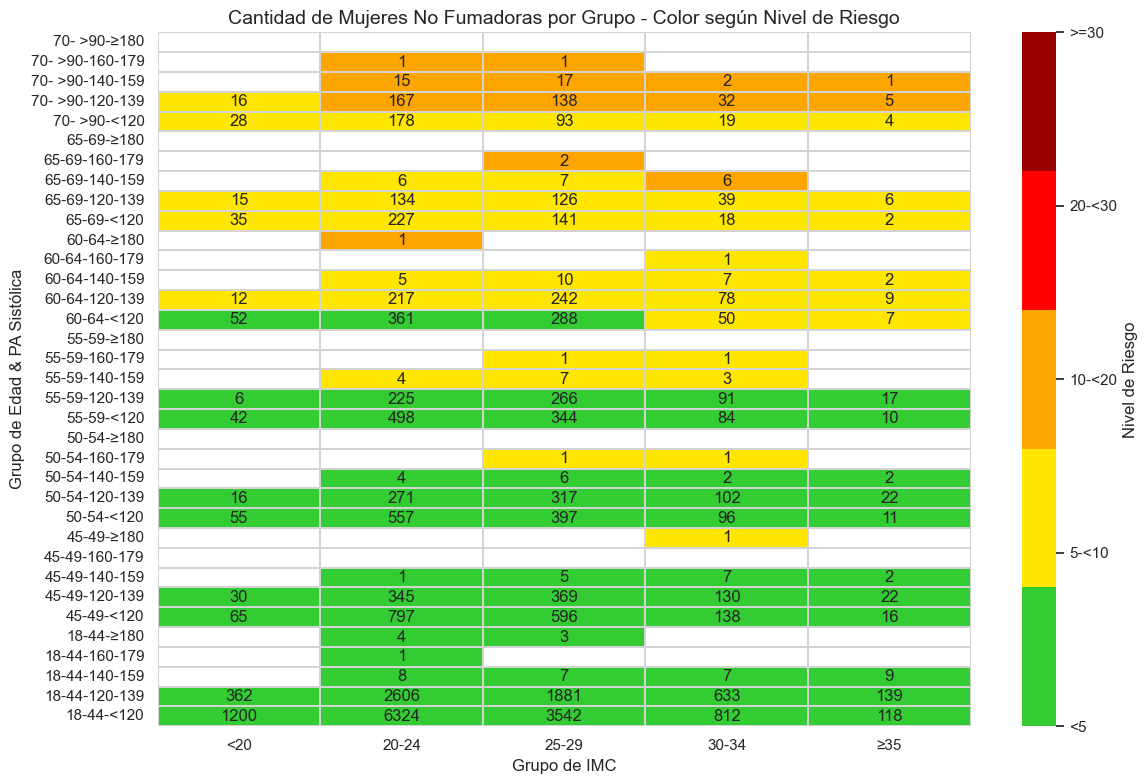

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

# 1. Agrupar: moda de riesgo (color) y conteo de personas (número en las celdas)
risk_avg = df.groupby(
    ['Grupo Edad', 'Grupo PA', 'Grupo IMC'], observed=False
)['Cardio Risk level'].mean().unstack()

count_data = df.groupby(
    ['Grupo Edad', 'Grupo PA', 'Grupo IMC'], observed=False
).size().unstack()

# 2. Ordenar para que el eje Y vaya de mayor a menor
risk_avg = risk_avg.sort_index(ascending=False)
count_data = count_data.reindex(risk_avg.index)

# 3. Definir paleta de colores fijos
colores_fijos = [
    "#33CC33",  # Verde - Riesgo <5
    "#FFE600",  # Amarillo - Riesgo 5-<10
    "#FFA500",  # Naranja - Riesgo 10-<20
    "#FF0000",  # Rojo - Riesgo 20-<30
    "#990000"   # Vinotinto - Riesgo >=30
]
cmap_discreto = ListedColormap(colores_fijos)
etiquetas_riesgo = ['<5', '5-<10', '10-<20', '20-<30', '>=30']

# 4. Crear figura y graficar heatmap
fig, ax = plt.subplots(figsize=(12, 8))

hm = sns.heatmap(
    risk_avg,
    cmap=cmap_discreto,
    annot=count_data,
    fmt=".0f",
    linewidths=0.003,
    linecolor="lightgrey",
    ax=ax,
    vmin=0,
    vmax=4,
    cbar_kws={"label": "Nivel de Riesgo", "ticks": [0, 1, 2, 3, 4]}
)

# 5. Personalizar el colorbar
colorbar = hm.collections[0].colorbar
colorbar.set_ticklabels(etiquetas_riesgo)

# 6. Estética del gráfico
ax.set_facecolor("#ffffff")
plt.title("Cantidad de Mujeres No Fumadoras por Grupo - Color según Nivel de Riesgo", fontsize=14)
plt.xlabel("Grupo de IMC")
plt.ylabel("Grupo de Edad & PA Sistólica")
plt.tight_layout()
plt.show()

#### Mujeres Fumadoras

In [155]:
## Mujeres FUMADORAS
import re
# 1. Función de limpieza de texto
def limpiar(txt):
    if pd.isna(txt):
        return ''
    txt = unicodedata.normalize('NFKD', str(txt))
    return ''.join(c for c in txt if not unicodedata.combining(c)).upper().strip()

# 2. Listas de diagnósticos
enf_cardio = [
    "HIPERTENSION ESENCIAL (PRIMARIA)", "HIPERTENSION SECUNDARIA, NO ESPECIFICADA",
    "HIPERTENSION PULMONAR PRIMARIA",
    "HIPERTENSION RENOVASCULAR","HIPERTENSION",
    "HIPERTENSION PORTAL",
    "CARDIACA", "TAQUICARDIA SUPRAVENTRICULAR","TAQUICARDIA PAROXISTICA",
    "ARRITMIA CARDIACA, NO ESPECIFICADA",
    "CARDIOMIOPATIA ISQUEMICA",
    "ENFERMEDAD ATEROSCLEROTICA DEL CORAZON",
    "BRADICARDIA, NO ESPECIFICADA",
    "FIBRILACION Y ALETEO AURICULAR",
    "PRESENCIA DE MARCAPASO CARDIACO",
    "ENFERMEDAD ISQUEMICA CRONICA DEL CORAZON",
    "INFARTO ANTIGUO DEL MIOCARDIO",
    "INFARTO AGUDO DEL MIOCARDIO",
    "ANGINA DE PECHO",
    "ARRITMIA POR REENTRADA VENTRICULAR",
    "TAQUICARDIA, SUPRAVENTRICULAR O PAROXISTICA",
    "INSUFICIENCIA CARDIACA",
    "ANEURISMA DE ARTERIA CORONARIA",
    "PRESENCIA DE VALVULA CARDIACA PROTESICA",
    "CARDIOMIOPATIA DILATADA",
    "OTRAS CARDIOMIOPATIA HIPERTROFICAS","CORONARIO",
    "OTRAS CARDIOMIOPATIA",
    "RESULTADOS ANORMALES EN ESTUDIOS FUNCIONALES CARDIOVASCULARES",
    "TROMBOSIS CORONARIA","CORONARIA", "BRADICARDIA",
    "ENFERMEDAD CARDIOVASCULAR ATEROSCLEROTICA",
    "ENFERMEDAD CARDIOVASCULAR, NO ESPECIFICADA", "EMBOLIA",
    "CARDIOPULMONARES", "CARDIOMEGALIA", "INFARTO", "MIOCARDIO", "PERICARDIO", "CORAZON",
    "VASCULITIS REUMATOIDE", "CARDIOMIOPATIA", "CARDIOVASCULAR", 
    "FLEBITIS Y TROMBOFLEBITIS","VASCULAR"
]

enf_diabetes_renal = [
    "OTRAS DIABETES MELLITUS",
    "DIABETES",
    "DIABETES MELLITUS CON COMPLICACIONES CIRCULATORIAS PERIFERICAS",
    "DIABETES MELLITUS NO INSULINODEPENDIENTE", "DIABETES MELLITUS INSULINODEPENDIENTE","RENAL"
]

# 3. Crear patrones
patron1 = '|'.join([limpiar(e) for e in enf_cardio])
patron2 = '|'.join([limpiar(e) for e in enf_diabetes_renal])


# 4. Clasificación OMS mujeres fumadoras 

riesgo_tabla = {
    (18, 44):   [[2, 3, 3, 3, 3],     # SBP <120
                 [3, 3, 4, 4, 5],     # SBP 120-139
                 [4, 5, 5, 6, 6],     # SBP 140-159
                 [6, 7, 7, 8, 8],     # SBP 160-179
                 [8, 9, 10, 10, 11]], # SBP ≥180

    (45, 49):   [[3, 3, 4, 4, 4],  
                 [4, 4, 5, 5, 6],  
                 [6, 6, 6, 7, 7],  
                 [7, 8, 9, 9, 10],  
                 [10, 11, 11, 12, 13]],  

    (50, 54):   [[4,4 , 5, 5, 5],  
                 [5, 6, 6, 6, 7],  
                 [7, 7, 8, 8, 9],  
                 [9, 10, 10, 11, 12],  
                 [12, 13, 13, 14, 15]],  

    (55, 59):   [[5, 6, 6, 6, 7],  
                 [7, 7, 8, 8, 9],  
                 [9, 9, 10, 10, 11],  
                 [11, 12, 12, 13, 14],  
                 [14, 15, 16, 17, 18]],  

    (60, 64):   [[7, 7, 8, 8, 9],  
                 [9, 9, 10, 10, 11],  
                 [11, 11, 12, 13, 13],  
                 [13, 14, 15, 16, 17],  
                 [17, 17, 18, 19, 21]],  

    (65, 69):   [[9, 9, 10, 10, 11],  
                 [11, 11, 12, 13, 13],  
                 [13, 14, 15, 15, 16],  
                 [16, 17, 18, 19, 20],  
                 [20, 21, 22, 23, 24]],  

    (70, 100):   [[11, 12, 12, 13, 13],  
                 [14, 14, 15, 16, 16],  
                 [16, 17, 18, 19, 19],  
                 [20, 20, 21, 22, 23],  
                 [23, 24, 25, 26, 27]]  
}

def clasificar_riesgo(edad, imc, tension_sis):
    for rango_edad in riesgo_tabla.keys():
        if rango_edad[0] <= edad <= rango_edad[1]:
            tabla_edad = riesgo_tabla[rango_edad]
            break
    else:
        return '>30'  # Edad fuera de rango / Si la edad está fuera del rango, asumir máximo riesgo

    imc_rangos = [(float('-inf'), 19.999), (20, 24.999), (25.00, 29.99), (30, 34.99), (35, float('inf'))]
    for imc_idx, (imc_min, imc_max) in enumerate(imc_rangos):
        if imc_min <= imc <= imc_max:
            break
    else:
        return 'Desconocido'

    tension_rangos = [120, 140, 160, 180]
    for tension_idx, tension_umbral in enumerate(tension_rangos):
        if tension_sis < tension_umbral:
            break
    else:
        tension_idx = len(tension_rangos)

    riesgo = tabla_edad[tension_idx][imc_idx]
    if riesgo < 5:
        return '<5'
    elif 5 <= riesgo < 10:
        return '5-<10'
    elif 10 <= riesgo < 20:
        return '10-<20'
    elif 20 <= riesgo < 30:
        return '20-<30'
    else:
        return '>=30'


# Aplicacion en df
# 4. Limpiar columnas
Mujeres_fumadoras_riesgo_40_df = Mujeres_fumadoras_May_40.copy()
Mujeres_fumadoras_riesgo_40_df['diagnostic_clean_1'] = Mujeres_fumadoras_riesgo_40_df['diagnostic_name_1'].fillna('').apply(limpiar)
Mujeres_fumadoras_riesgo_40_df['diagnostic_clean_2'] = Mujeres_fumadoras_riesgo_40_df['diagnostic_name_2'].fillna('').apply(limpiar)

# Crear columna 'tipo_diagnostico' para identificar
def clasificar_tipo_diagnostico(row):
    texto = row['diagnostic_clean_1'] + ' ' + row['diagnostic_clean_2']
    tiene_cardio = bool(re.search(patron1, texto))
    tiene_renal = bool(re.search(patron2, texto))
    
    if tiene_cardio and tiene_renal:
        return 'Cardio y Renal'
    elif tiene_cardio:
        return 'Cardio'
    elif tiene_renal:
        return 'Renal/Diabetes'
    else:
        return 'No aplica'

Mujeres_fumadoras_riesgo_40_df['tipo_diagnostico'] = Mujeres_fumadoras_riesgo_40_df.apply(clasificar_tipo_diagnostico, axis=1)

# 5. Inicializar columna de riesgo
Mujeres_fumadoras_riesgo_40_df['Cardio Risk level'] = '<30'

# 6. Aplicar riesgo '20-30' si contiene diagnóstico cardiovascular crítico
Mujeres_fumadoras_riesgo_40_df.loc[
    Mujeres_fumadoras_riesgo_40_df['diagnostic_clean_1'].str.contains(patron1, na=False) |
    Mujeres_fumadoras_riesgo_40_df['diagnostic_clean_2'].str.contains(patron1, na=False),
    'Cardio Risk level'
] = '20-30'

# 7. Aplicar riesgo '>10-20' solo si aún está en <30
Mujeres_fumadoras_riesgo_40_df.loc[
    (Mujeres_fumadoras_riesgo_40_df['Cardio Risk level'] == '<30') & (
        Mujeres_fumadoras_riesgo_40_df['diagnostic_clean_1'].str.contains(patron2, na=False) |
        Mujeres_fumadoras_riesgo_40_df['diagnostic_clean_2'].str.contains(patron2, na=False)
    ),
    'Cardio Risk level'
] = '10-20'


# 8. Conversión a valores numéricos
Mujeres_fumadoras_riesgo_40_df['tension_arte_sis'] = pd.to_numeric(Mujeres_fumadoras_riesgo_40_df['tension_arte_sis'], errors='coerce')
Mujeres_fumadoras_riesgo_40_df['imc'] = pd.to_numeric(Mujeres_fumadoras_riesgo_40_df['imc'], errors='coerce')
Mujeres_fumadoras_riesgo_40_df['edad'] = pd.to_numeric(Mujeres_fumadoras_riesgo_40_df['edad'], errors='coerce')

# 9. Aplicar clasificación OMS SOLO si riesgo aún es <30
mask_riesgo_oms = Mujeres_fumadoras_riesgo_40_df['Cardio Risk level'].isin(['<30'])
Mujeres_fumadoras_riesgo_40_df.loc[mask_riesgo_oms, 'Cardio Risk level'] = Mujeres_fumadoras_riesgo_40_df.loc[mask_riesgo_oms].apply(
    lambda x: clasificar_riesgo(x['edad'], x['imc'], x['tension_arte_sis']),
    axis=1  
)

# 10. Ver resultados
print(Mujeres_fumadoras_riesgo_40_df[['diagnostic_name_1', 'diagnostic_name_2', 'tipo_diagnostico','edad', 'imc', 'tension_arte_sis', 'Cardio Risk level']].head(30))

                                       diagnostic_name_1  \
16381       HERNIA UMBILICAL SIN OBSTRUCCION NI GANGRENA   
17340                       OTRAS ESCOLIOSIS SECUNDARIAS   
17679                                        CERVICALGIA   
19468                          OBESIDAD, NO ESPECIFICADA   
19620                                      OSTEOPETROSIS   
19825                              ADIPOSIDAD LOCALIZADA   
20240                              ADIPOSIDAD LOCALIZADA   
21173                              ADIPOSIDAD LOCALIZADA   
22157                             ARTICULACION INESTABLE   
23293                        ESCOLIOSIS, NO ESPECIFICADA   
23299                    GONARTROSIS PRIMARIA, BILATERAL   
23358                              EXAMEN MEDICO GENERAL   
23399                       OTRAS BURSITIS DE LA RODILLA   
23551                              DOLOR EN ARTICULACION   
24586                              EXAMEN MEDICO GENERAL   
24993                              EXAME

C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\3147354240.py:165: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\yilinet.bueno\AppData\Local\Temp\ipykernel_11800\3147354240.py:166: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [156]:
Mujeres_fumadoras_riesgo_40_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086 entries, 16381 to 319232
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                1086 non-null   float64       
 1   sesiones_en_la_semana      1086 non-null   float64       
 2   member_id_y                1086 non-null   float64       
 3   minutos_por_semana         1086 non-null   float64       
 4   nivel_actividad_time       1086 non-null   object        
 5   document_number            1086 non-null   object        
 6   tipo_vinculacion           1086 non-null   object        
 7   ocupacion                  1086 non-null   object        
 8   eps                        1086 non-null   object        
 9   territorial_zone           1086 non-null   object        
 10  date                       1086 non-null   datetime64[ns]
 11  user_id                    1086 non-null   int64         
 12  date_

In [157]:
# Risk level encoding
risk_mapping = {'<5': 0, '5-<10': 1, '10-20':2, '10-<20': 2, '20-30':3, '20-<30': 3, '>=30': 4}
Mujeres_fumadoras_riesgo_40_df['Cardio Risk level'] = Mujeres_fumadoras_riesgo_40_df['Cardio Risk level'].map(risk_mapping)

# Genre encoding
if Mujeres_fumadoras_riesgo_40_df['genre'].nunique() == 1:
    Mujeres_fumadoras_riesgo_40_df.drop(columns=['genre'], inplace=True)  # Se elimina porque solo tiene "Masculino"

# Tabaquismo encoding
if Mujeres_fumadoras_riesgo_40_df['Tabaquismo'].nunique() == 1:
    Mujeres_fumadoras_riesgo_40_df.drop(columns=['Tabaquismo'], inplace=True) 

In [158]:
#Mujeres_fumadoras_riesgo_40_df.to_excel("BaseHF.xlsx", index=False)

In [159]:
Mujeres_fumadoras_riesgo_40_df['genero'] = "0"
Mujeres_fumadoras_riesgo_40_df['Tabaquismo'] = "SI"

df_4 = Mujeres_fumadoras_riesgo_40_df.copy()

In [160]:
# Visualización
# Edad
bins_edad = [18, 45, 50, 55, 60, 65, 70, 120]  # 18-44, 45-49, 50-54
# Definir las etiquetas correspondientes
labels_edad = ["18-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70- >90"]
Mujeres_fumadoras_riesgo_40_df['Grupo Edad'] = pd.cut(Mujeres_fumadoras_riesgo_40_df['edad'], bins=bins_edad, labels=labels_edad, right=False)

# Presión Arterial Sistólica
bins_pa = [0, 120, 140, 160, 180, float("inf")]
labels_pa = ["<120", "120-139", "140-159", "160-179", "≥180"]
Mujeres_fumadoras_riesgo_40_df['Grupo PA'] = pd.cut(Mujeres_fumadoras_riesgo_40_df['tension_arte_sis'], bins=bins_pa, labels=labels_pa, right=False)

# IMC
bins_imc = [0, 20, 25, 30, 35, float("inf")]
labels_imc = ["<20", "20-24", "25-29", "30-34", "≥35"]
Mujeres_fumadoras_riesgo_40_df['Grupo IMC'] = pd.cut(Mujeres_fumadoras_riesgo_40_df['imc'], bins=bins_imc, labels=labels_imc, right=False)


In [161]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Estilo limpio
pio.templates.default = "plotly_white"

# Copiar y preparar datos
df = Mujeres_fumadoras_riesgo_40_df.copy()
df['Cardio Risk level'] = df['Cardio Risk level'].astype(str)
df['Grupo Edad'] = df['Grupo Edad'].astype(str)

# Agrupar
df_grouped = df.groupby(['Cardio Risk level', 'Grupo Edad']).agg(
    Cantidad=('user_id', 'count'),
    IMC_promedio=('imc', 'mean'),
    Tension_promedio=('tension_arte_sis', 'mean')
).reset_index()

# Paleta categórica clara
color_palette = px.colors.qualitative.Set2  # O prueba: Plotly, D3, Dark24

# Gráfico de burbujas facetado
color_palette = px.colors.qualitative.Bold

fig = px.scatter(
    df_grouped,
    x='IMC_promedio',
    y='Tension_promedio',
    size='Cantidad',
    color='Grupo Edad',
    facet_col='Cardio Risk level',
    facet_col_wrap=3,
    color_discrete_sequence=color_palette,
    title='Distribución de IMC y Tensión por Nivel de Riesgo Cardiovascular',
    labels={
        'IMC_promedio': 'Promedio de IMC',
        'Tension_promedio': 'Presión Sistólica Promedio',
        'Cantidad': 'Nro de Personas'
    },
    size_max=60,
    custom_data=['Grupo Edad']
)

# Mejorar visual

fig.update_layout(
    height=850,
    title_font=dict(size=20, family='Helvetica', color='black'),
    font=dict(family='Helvetica', size=12, color='black'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(t=70, l=50, r=30, b=60),
    coloraxis_showscale=False
)

# Mostrar ejes en todas las facetas
fig.for_each_xaxis(lambda ax: ax.update(title='Promedio de IMC', showticklabels=True))
fig.for_each_yaxis(lambda ay: ay.update(title='Presión Sistólica Promedio', showticklabels=True))

# Hover detallado
fig.update_traces(
    hovertemplate="<b>Edad:</b> %{customdata[0]}<br>" +
                  "<b>IMC:</b> %{x:.1f}<br>" +
                  "<b>Tensión:</b> %{y:.1f}<br>" +
                  "<b>Personas:</b> %{marker.size}"
)

# Línea guía en IMC=25
fig.add_shape(
    type="line",
    x0=25, x1=25,
    y0=df_grouped['Tension_promedio'].min(),
    y1=df_grouped['Tension_promedio'].max(),
    line=dict(color="gray", dash="dash"),
    layer='below'
)

fig.show()

In [162]:
Mujeres_fumadoras_riesgo_40_df.head()

member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
16381     534145.0                    2.0     534145.0             100.480   
17340     165117.0                    1.0     165117.0              83.950   
17679     228672.0                    4.0     228672.0             465.660   
19468     752520.0                    4.0     752520.0             395.500   
19620      79220.0                    2.0      79220.0             113.055   

      nivel_actividad_time document_number tipo_vinculacion  \
16381          Poco Activo        52429742    Contributivo    
17340          Poco Activo      1019018044    Contributivo    
17679           Muy Activo        41792911    Contributivo    
19468           Muy Activo        54255999    Contributivo    
19620          Poco Activo        41786966    Contributivo    

                                               ocupacion  \
16381                                         ARQUITECTO   
17340                                         ARQUITECTO   
17679  OTRAS OCUPACIONES ELEMENTALES NO CLASIFICADAS ...   
19468                      TRABAJADOR SOCIAL PROFESIONAL   
19620                                            ABOGADO   

                                                     eps territorial_zone  \
16381                                         ALIANSALUD           Urbana   
17340  ENTIDAD PROMOTORA DE SALUD SANITAS S.A. - E.P....           Urbana   
17679               CAJA COMPENSACION FAMILIAR COMPENSAR           Urbana   
19468  NUEVA EMPRESA PROMOTORA DE SALUD S.A. SIGLA NU...           Urbana   
19620  ENTIDAD PROMOTORA DE SALUD SANITAS S.A. - E.P....           Urbana   

       ... diagnostico_diabetes  diagnostico_renal diagnostico_dislipidemia  \
16381  ...                   No                 No                       No   
17340  ...                   No                 No                       No   
17679  ...                   No                 No                       No   
19468  ...                   No                 No                       No   
19620  ...                   No                 No                       No   

       tipo_diagnostico  Cardio Risk level  genero  Tabaquismo  Grupo Edad  \
16381         No aplica                  0       0          SI       45-49   
17340         No aplica                  0       0          SI       18-44   
17679         No aplica                  2       0          SI       65-69   
19468         No aplica                  1       0          SI       55-59   
19620         No aplica                  1       0          SI       65-69   

       Grupo PA  Grupo IMC  
16381   120-139      20-24  
17340      <120      20-24  
17679   120-139      20-24  
19468      <120      25-29  
19620      <120        <20  

[5 rows x 80 columns]

In [163]:
df=Mujeres_fumadoras_riesgo_40_df[Mujeres_fumadoras_riesgo_40_df['tipo_diagnostico'] == 'No aplica']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1060 entries, 16381 to 319232
Data columns (total 80 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   member_id_x                1060 non-null   float64       
 1   sesiones_en_la_semana      1060 non-null   float64       
 2   member_id_y                1060 non-null   float64       
 3   minutos_por_semana         1060 non-null   float64       
 4   nivel_actividad_time       1060 non-null   object        
 5   document_number            1060 non-null   object        
 6   tipo_vinculacion           1060 non-null   object        
 7   ocupacion                  1060 non-null   object        
 8   eps                        1060 non-null   object        
 9   territorial_zone           1060 non-null   object        
 10  date                       1060 non-null   datetime64[ns]
 11  user_id                    1060 non-null   int64         
 12  date_

##### Resultado Matriz Aplicada 

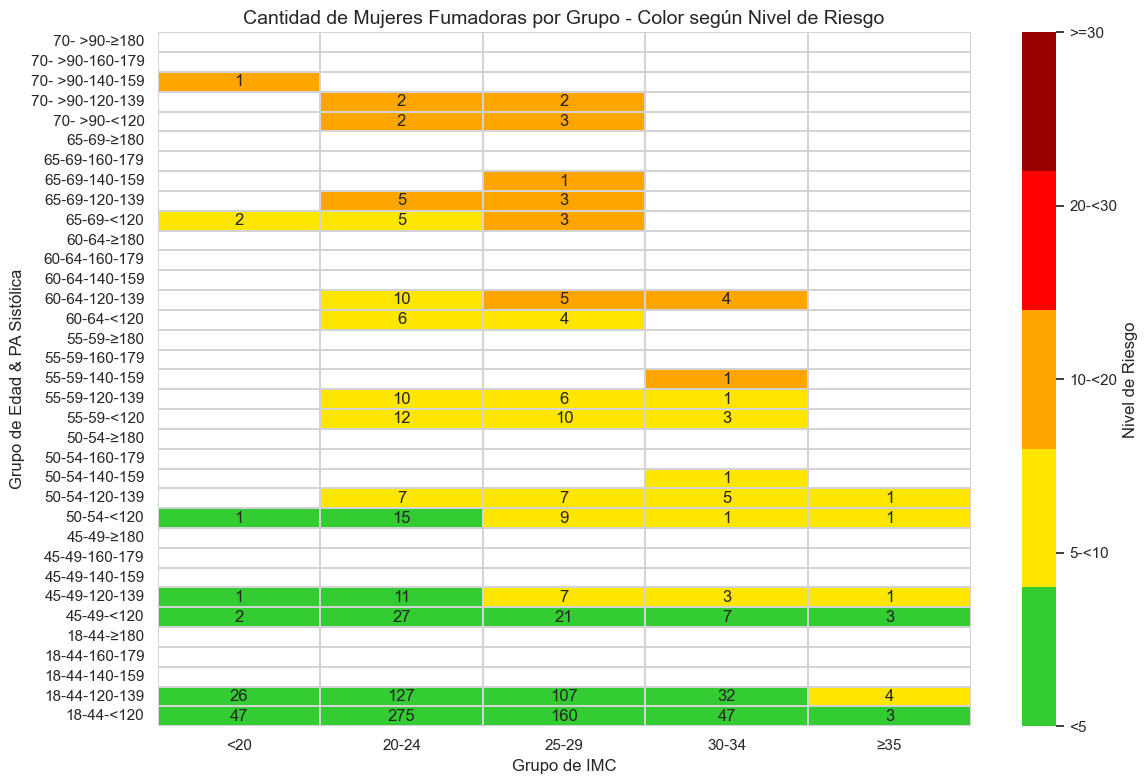

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

# 1. Agrupar: moda de riesgo (color) y conteo de personas (número en las celdas)
risk_avg = df.groupby(
    ['Grupo Edad', 'Grupo PA', 'Grupo IMC'], observed=False
)['Cardio Risk level'].mean().unstack()

count_data = df.groupby(
    ['Grupo Edad', 'Grupo PA', 'Grupo IMC'], observed=False
).size().unstack()

# 2. Ordenar para que el eje Y vaya de mayor a menor
risk_avg = risk_avg.sort_index(ascending=False)
count_data = count_data.reindex(risk_avg.index)

# 3. Definir paleta de colores fijos
colores_fijos = [
    "#33CC33",  # Verde - Riesgo <5
    "#FFE600",  # Amarillo - Riesgo 5-<10
    "#FFA500",  # Naranja - Riesgo 10-<20
    "#FF0000",  # Rojo - Riesgo 20-<30
    "#990000"   # Vinotinto - Riesgo >=30
]
cmap_discreto = ListedColormap(colores_fijos)
etiquetas_riesgo = ['<5', '5-<10', '10-<20', '20-<30', '>=30']

# 4. Crear figura y graficar heatmap
fig, ax = plt.subplots(figsize=(12, 8))

hm = sns.heatmap(
    risk_avg,
    cmap=cmap_discreto,
    annot=count_data,
    fmt=".0f",
    linewidths=0.003,
    linecolor="lightgrey",
    ax=ax,
    vmin=0,
    vmax=4,
    cbar_kws={"label": "Nivel de Riesgo", "ticks": [0, 1, 2, 3, 4]}
)

# 5. Personalizar el colorbar
colorbar = hm.collections[0].colorbar
colorbar.set_ticklabels(etiquetas_riesgo)

# 6. Estética del gráfico
ax.set_facecolor("#ffffff")
plt.title("Cantidad de Mujeres Fumadoras por Grupo - Color según Nivel de Riesgo", fontsize=14)
plt.xlabel("Grupo de IMC")
plt.ylabel("Grupo de Edad & PA Sistólica")
plt.tight_layout()
plt.show()

In [165]:
df.()%mfrl=

SyntaxError: invalid syntax (1087575534.py, line 1)

## Caracterización de la población 

In [166]:
### UNIÓN DE DF     

# Lista de DataFrames y sus nombres
dfs = {'df_1': df_1, 'df_2': df_2, 'df_3': df_3, 'df_4': df_4}

# Obtener las columnas de cada DataFrame
columnas_ref = list(df_1.columns)  #  df_churn como referencia

# Verificar diferencias de columnas
error_detectado = False
for nombre, df in dfs.items():
    columnas_actuales = list(df.columns)
    
    if columnas_actuales != columnas_ref:
        error_detectado = True
        print(f"Diferencia detectada en {nombre}:")
        
        # Columnas que faltan en el DataFrame actual
        faltantes = set(columnas_ref) - set(columnas_actuales)
        if faltantes:
            print(f" Columnas faltantes en {nombre}: {faltantes}")
        
        # Columnas extra en el DataFrame actual
        extras = set(columnas_actuales) - set(columnas_ref)
        if extras:
            print(f"Columnas adicionales en {nombre}: {extras}")

# Si no hay errores, concatenar los DataFrames
if not error_detectado:
    df_cr = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)
    print("DataFrames concatenados correctamente.")
    print(df_cr)
else:
    print("No se pueden concatenar los DataFrames debido a diferencias en las columnas.")

DataFrames concatenados correctamente.
       member_id_x  sesiones_en_la_semana  member_id_y  minutos_por_semana  \
0         444685.0                    2.5     444685.0             218.245   
1         926426.0                    2.0     926426.0             200.995   
2        1264358.0                    2.0    1264358.0             162.815   
3        1253247.0                    2.0    1253247.0             248.200   
4         187175.0                    4.0     187175.0             832.620   
...            ...                    ...          ...                 ...   
52468    2148878.0                    4.0    2148878.0             277.750   
52469    3295881.0                    4.0    3295881.0             278.200   
52470    3281412.0                    2.5    3281412.0             255.640   
52471    3296150.0                    3.0    3296150.0             349.650   
52472    3235183.0                    2.0    3235183.0             161.060   

      nivel_actividad_ti

In [167]:
#df_cr.to_excel("Polbacióndeestuio.xlsx", index = False)

In [168]:
df_cr['genero'].value_counts()

genero
0    29131
1    23342
Name: count, dtype: int64

In [169]:
df_cr.columns

Index(['member_id_x', 'sesiones_en_la_semana', 'member_id_y',
       'minutos_por_semana', 'nivel_actividad_time', 'document_number',
       'tipo_vinculacion', 'ocupacion', 'eps', 'territorial_zone', 'date',
       'user_id', 'date_acc', 'height', 'imc', 'imm', 'fat_percentage',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 'edad',
       'birthdate', 'frecu_card_repos', 'frecu_card_max', 'tension_arte_dias',
       'tension_arte_sis', 'state_pregnancy', 'riesgo_cardiov',
       'frecuency_sport_actv', 'time_sport_actv', 'sede_uso', 'ciudad',
       'category_sede_uso', 'region', 'average_minute',
       'sport_activity_intensity', 'diagnostic_name_1', 'diagnostic_name_2',
       'family_history', 'quote_id', 'aptitud', 'date_quote', 'status_quote',
       'document_number_type', 'evaluador_acc', 'fecha_embar', 'No_Documento',
       'Embarazada', 'members_id', 'Departamento', 'Sedentarismo',
       'Hipertensión', 'Dislipidemia', 'Obesidad', 'Edad Riesgo',
       

In [170]:
#Selección de columnas 
# Se elimina family_history y frecuency sport act por nulos 

columnas_seleccionadas=['user_id', 'date_acc', 'height', 'imc', 'imm', 'fat_percentage','tipo_vinculacion', 'ocupacion_validada','minutos_por_semana','nivel_actividad_time',
       'muscle_mass_percentage', 'abdominal_perimeter', 'weight', 'edad',
       'birthdate', 'frecu_card_repos', 'frecu_card_max', 'tension_arte_dias','Departamento',
       'tension_arte_sis', 'state_pregnancy', 'sede_uso', 'ciudad','sesiones_en_la_semana',
       'category_sede_uso', 'region',
       'diagnostic_name_1', 'diagnostic_name_2', 'quote_id', 'date_quote', 'status_quote',
       'document_number', 'document_number_type', 'evaluador_acc',
       'Sedentarismo', 'Hipertensión', 'Dislipidemia', 'Obesidad',
       'Edad Riesgo', 'Antecedente Familiar', 'Diabetes','diagnostico_hipertension', 'diagnostico_cardio',
       'diagnostico_diabetes', 'diagnostico_renal', 'diagnostico_dislipidemia',
       'Enfermedad Pulmonar', 'Enfermedad Cardiovascular', 'Enfermedad Renal','riesgo_cardiov',
       'Estrato', 'rango_edad','Cardio Risk level',
       'Identifica Extranjero', 'diagnostic_clean_1', 'diagnostic_clean_2',
       'tipo_diagnostico', 'genero', 'Tabaquismo']  #'sport_activity_intensity'

df_cr=df_cr[columnas_seleccionadas]
df_cr.head()

user_id   date_acc  height    imc        imm  fat_percentage  \
0   444685 2022-02-19    1.76  24.76   8.195926            28.9   
1   926426 2022-02-22    1.88  24.16  11.598008            16.0   
2  1264358 2022-02-22    1.76  29.18   9.834969            26.8   
3  1253247 2022-02-23    1.65  29.86   9.257300            35.3   
4   187175 2022-03-02    1.74  22.99   9.977011            14.6   

  tipo_vinculacion ocupacion_validada  minutos_por_semana  \
0    Contributivo         Profesional             218.245   
1       Subsidiado        Profesional             200.995   
2    Contributivo         Profesional             162.815   
3    Contributivo         Profesional             248.200   
4    Contributivo         Profesional             832.620   

  nivel_actividad_time  ...  riesgo_cardiov  Estrato  rango_edad  \
0               Activo  ...           MEDIO      4.0       28-37   
1               Activo  ...            BAJO      4.0       38-47   
2               Activo  ...           MEDIO      3.0       48-57   
3               Activo  ...           MEDIO      3.0       28-37   
4           Muy Activo  ...            BAJO      4.0       28-37   

   Cardio Risk level Identifica Extranjero  \
0                  0      No es extranjero   
1                  0      No es extranjero   
2                  3      No es extranjero   
3                  0      No es extranjero   
4                  0      No es extranjero   

                                  diagnostic_clean_1  \
0                              EXAMEN MEDICO GENERAL   
1  OTROS TRASTORNOS ESPECIFICADOS DE LOS DISCOS I...   
2  LECTURA ELEVADA DE LA PRESION SANGUINEA, SIN D...   
3                              ADIPOSIDAD LOCALIZADA   
4                              EXAMEN MEDICO GENERAL   

                                  diagnostic_clean_2  tipo_diagnostico genero  \
0                              EXAMEN MEDICO GENERAL         No aplica      1   
1  OTROS TRASTORNOS ESPECIFICADOS DE LOS DISCOS I...         No aplica      1   
2  LECTURA ELEVADA DE LA PRESION SANGUINEA, SIN D...            Cardio      1   
3                              ADIPOSIDAD LOCALIZADA         No aplica      1   
4                              EXAMEN MEDICO GENERAL         No aplica      1   

   Tabaquismo  
0          SI  
1          SI  
2          SI  
3          SI  
4          SI  

[5 rows x 59 columns]

In [171]:
df_f=df_cr[df_cr['Estrato'].isna()]
dffil=df_f[['Estrato', 'sede_uso']]
dffil['sede_uso'].unique()

array([], dtype=object)

In [172]:
#Tratamiento de Null 
#Para columna de riesgo cardiov 
df_cr['riesgo_cardiov']=df_cr['riesgo_cardiov'].fillna('BAJO')

# Para columna de Estrato: 
mapeo_estrato={'Mall Del Este': 3,
               'Pablo Vi': 4,
               'Santa Maria De Los Ángeles': 2,
               'Paseo Del Rio': 4}

# Función para aplicar solo mapeo a nulos de Estrato 

def mapeo_Estrato_null(row):
    if pd.isna(row['Estrato']) or row['Estrato'] == 0:
        return mapeo_estrato.get(row['sede_uso'], row['Estrato'])
    else:
        return row['Estrato']

#Aplicar la función 
df_cr['Estrato']=df_cr.apply(mapeo_Estrato_null, axis=1)
df_cr.head()

user_id   date_acc  height    imc        imm  fat_percentage  \
0   444685 2022-02-19    1.76  24.76   8.195926            28.9   
1   926426 2022-02-22    1.88  24.16  11.598008            16.0   
2  1264358 2022-02-22    1.76  29.18   9.834969            26.8   
3  1253247 2022-02-23    1.65  29.86   9.257300            35.3   
4   187175 2022-03-02    1.74  22.99   9.977011            14.6   

  tipo_vinculacion ocupacion_validada  minutos_por_semana  \
0    Contributivo         Profesional             218.245   
1       Subsidiado        Profesional             200.995   
2    Contributivo         Profesional             162.815   
3    Contributivo         Profesional             248.200   
4    Contributivo         Profesional             832.620   

  nivel_actividad_time  ...  riesgo_cardiov  Estrato  rango_edad  \
0               Activo  ...           MEDIO      4.0       28-37   
1               Activo  ...            BAJO      4.0       38-47   
2               Activo  ...           MEDIO      3.0       48-57   
3               Activo  ...           MEDIO      3.0       28-37   
4           Muy Activo  ...            BAJO      4.0       28-37   

   Cardio Risk level Identifica Extranjero  \
0                  0      No es extranjero   
1                  0      No es extranjero   
2                  3      No es extranjero   
3                  0      No es extranjero   
4                  0      No es extranjero   

                                  diagnostic_clean_1  \
0                              EXAMEN MEDICO GENERAL   
1  OTROS TRASTORNOS ESPECIFICADOS DE LOS DISCOS I...   
2  LECTURA ELEVADA DE LA PRESION SANGUINEA, SIN D...   
3                              ADIPOSIDAD LOCALIZADA   
4                              EXAMEN MEDICO GENERAL   

                                  diagnostic_clean_2  tipo_diagnostico genero  \
0                              EXAMEN MEDICO GENERAL         No aplica      1   
1  OTROS TRASTORNOS ESPECIFICADOS DE LOS DISCOS I...         No aplica      1   
2  LECTURA ELEVADA DE LA PRESION SANGUINEA, SIN D...            Cardio      1   
3                              ADIPOSIDAD LOCALIZADA         No aplica      1   
4                              EXAMEN MEDICO GENERAL         No aplica      1   

   Tabaquismo  
0          SI  
1          SI  
2          SI  
3          SI  
4          SI  

[5 rows x 59 columns]

In [173]:
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52473 entries, 0 to 52472
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   user_id                    52473 non-null  int64         
 1   date_acc                   52473 non-null  datetime64[ns]
 2   height                     52473 non-null  float64       
 3   imc                        52473 non-null  float64       
 4   imm                        52473 non-null  float64       
 5   fat_percentage             52473 non-null  float64       
 6   tipo_vinculacion           52473 non-null  object        
 7   ocupacion_validada         52473 non-null  object        
 8   minutos_por_semana         52473 non-null  float64       
 9   nivel_actividad_time       52473 non-null  object        
 10  muscle_mass_percentage     52473 non-null  float64       
 11  abdominal_perimeter        52473 non-null  float64       
 12  weig

In [174]:
#df_cr.to_excel('Basecompleta1408.xlsx', index=False)

In [175]:
# null=df_cr['riesgo_cardiov'].isnull().sum()
# null=df_cr[df_cr['riesgo_cardiov'] != 0]
# Null.unique()

In [176]:
## Revisión de Null  
# Calcular el porcentaje de valores nulos por columna
#nulos_por_columna = (df_cr.isnull().sum() / len(df_cr)) * 100
nulos_por_columna = df_cr.isnull().sum() 


# Convertir a DataFrame
tabla_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Porcentaje de Nulos (%)': nulos_por_columna.values
}).sort_values(by='Porcentaje de Nulos (%)', ascending=False)


# Mostrar la tabla
tabla_nulos.head(10)

Columna  Porcentaje de Nulos (%)
0                user_id                        0
44     diagnostico_renal                        0
32  document_number_type                        0
33         evaluador_acc                        0
34          Sedentarismo                        0
35          Hipertensión                        0
36          Dislipidemia                        0
37              Obesidad                        0
38           Edad Riesgo                        0
39  Antecedente Familiar                        0

In [177]:
#df_cr.to_excel('basedecryili.xlsx', index=False)

### Análisis FAMD Analisis factorial de datos mixtos 

In [178]:
df_cr=df_cr[df_cr['user_id'] != 3287826 ]

In [179]:
#use=df_cr[df_cr['user_id'] == 9594 ]
#use.to_excel( '9594.xlsx', index='False' )

In [180]:
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52473 entries, 0 to 52472
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   user_id                    52473 non-null  int64         
 1   date_acc                   52473 non-null  datetime64[ns]
 2   height                     52473 non-null  float64       
 3   imc                        52473 non-null  float64       
 4   imm                        52473 non-null  float64       
 5   fat_percentage             52473 non-null  float64       
 6   tipo_vinculacion           52473 non-null  object        
 7   ocupacion_validada         52473 non-null  object        
 8   minutos_por_semana         52473 non-null  float64       
 9   nivel_actividad_time       52473 non-null  object        
 10  muscle_mass_percentage     52473 non-null  float64       
 11  abdominal_perimeter        52473 non-null  float64       
 12  weig

In [181]:
df_cr['Departamento'].value_counts()

Departamento
Cundinamarca          24177
Antioquia              9135
Valle del Cauca        5251
Santander              2394
Risaralda              1871
Bolivar                1712
Meta                   1494
Atlantico              1475
Cesar                  1074
Tolima                 1026
Boyaca                  738
Norte de Santander      701
Caldas                  633
Nariño                  250
Cordoba                 199
Quindio                 193
Huila                   150
Name: count, dtype: int64

In [182]:
import pandas as pd
import prince
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# Seleccionar variables relevantes
columnas_útiles = [
       'imm', 'fat_percentage' ,'Cardio Risk level','Departamento',
       'muscle_mass_percentage', 'abdominal_perimeter', 'Sedentarismo','height','tipo_vinculacion','ocupacion_validada',
       'frecu_card_repos', 'tension_arte_dias','weight','nivel_actividad_time',
       'Antecedente Familiar', 'Estrato' ]  #'imc', 'Cardio Risk level', 'Departamento'

# Subset
df_famd = df_cr[columnas_útiles].copy()

# Convertir columnas object en categóricas
for col in df_famd.select_dtypes(include='object').columns:
    df_famd[col] = df_famd[col].astype('category')

# Asegurarte de agregar "No aplica" como categoría válida
for col in df_famd.select_dtypes(['category']).columns:
    if "No aplica" not in df_famd[col].cat.categories:
        df_famd[col] = df_famd[col].cat.add_categories(["No aplica"])

# Rellenar nulos
df_famd = df_famd.fillna('No aplica')

# # Aplicar FAMD
# famd = prince.FAMD(n_components=5, random_state=42)
# famd = famd.fit(df_famd)
# df_famd_reduced = famd.transform(df_famd)


In [183]:
df_famd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52473 entries, 0 to 52472
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   imm                     52473 non-null  float64 
 1   fat_percentage          52473 non-null  float64 
 2   Cardio Risk level       52473 non-null  int64   
 3   Departamento            52473 non-null  category
 4   muscle_mass_percentage  52473 non-null  float64 
 5   abdominal_perimeter     52473 non-null  float64 
 6   Sedentarismo            52473 non-null  category
 7   height                  52473 non-null  float64 
 8   tipo_vinculacion        52473 non-null  category
 9   ocupacion_validada      52473 non-null  category
 10  frecu_card_repos        52473 non-null  float64 
 11  tension_arte_dias       52473 non-null  float64 
 12  weight                  52473 non-null  float64 
 13  nivel_actividad_time    52473 non-null  category
 14  Antecedente Familiar  

In [184]:
df_famd.head()

imm  fat_percentage  Cardio Risk level     Departamento  \
0   8.195926            28.9                  0        Antioquia   
1  11.598008            16.0                  0  Valle del Cauca   
2   9.834969            26.8                  3        Santander   
3   9.257300            35.3                  0     Cundinamarca   
4   9.977011            14.6                  0        Antioquia   

   muscle_mass_percentage  abdominal_perimeter Sedentarismo  height  \
0                    33.1                 93.0           NO    1.76   
1                    48.0                 90.0           NO    1.88   
2                    33.7                107.5           SI    1.76   
3                    31.0                 92.5           NO    1.65   
4                    43.4                 78.5           NO    1.74   

  tipo_vinculacion ocupacion_validada  frecu_card_repos  tension_arte_dias  \
0    Contributivo         Profesional              72.0               90.0   
1       Subsidiado        Profesional              68.0               82.0   
2    Contributivo         Profesional              88.0              100.0   
3    Contributivo         Profesional              70.0               80.0   
4    Contributivo         Profesional              84.0               70.0   

   weight nivel_actividad_time Antecedente Familiar  Estrato  
0    76.7               Activo                   SI      4.0  
1    85.4               Activo                   NO      4.0  
2    90.4               Activo                   SI      3.0  
3    81.3               Activo                   NO      3.0  
4    69.6           Muy Activo                   NO      4.0

In [185]:
# Lista de las columnas que sabes que son categóricas
columnas_categoricas = ['tipo_vinculacion', 'Sedentarismo', 'Antecedente Familiar', 'Departamento', 'nivel_actividad_time' ] #'Departamento'

# Convertir estas columnas al tipo de dato 'category'
for col in columnas_categoricas:
    df_famd[col] = df_famd[col].astype('category')

# Verifica que los cambios se aplicaron correctamente
print("Tipos de datos después de la corrección:")
df_famd.info()

Tipos de datos después de la corrección:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52473 entries, 0 to 52472
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   imm                     52473 non-null  float64 
 1   fat_percentage          52473 non-null  float64 
 2   Cardio Risk level       52473 non-null  int64   
 3   Departamento            52473 non-null  category
 4   muscle_mass_percentage  52473 non-null  float64 
 5   abdominal_perimeter     52473 non-null  float64 
 6   Sedentarismo            52473 non-null  category
 7   height                  52473 non-null  float64 
 8   tipo_vinculacion        52473 non-null  category
 9   ocupacion_validada      52473 non-null  category
 10  frecu_card_repos        52473 non-null  float64 
 11  tension_arte_dias       52473 non-null  float64 
 12  weight                  52473 non-null  float64 
 13  nivel_actividad_time    52473 non-n

In [186]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

numericas = df_cr[['imc','imm', 'muscle_mass_percentage','abdominal_perimeter', 'fat_percentage', 'sesiones_en_la_semana', 'minutos_por_semana', 'edad', 
                  'tension_arte_sis', 'tension_arte_dias', 'Estrato', 'frecu_card_repos']]
#'weight'
#df_cr.select_dtypes(include=['float64', 'int64'])

# Asumiendo que X es tu matriz de variables independientes
X = df_cr[numericas.columns].dropna()  # o usa imputación si prefieres
X = add_constant(X)

vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df.sort_values("VIF", ascending=False))

                  Variable          VIF
0                    const  1053.606049
2                      imm    48.536670
3   muscle_mass_percentage    41.981616
1                      imc    24.246078
5           fat_percentage     3.847862
4      abdominal_perimeter     3.643984
6    sesiones_en_la_semana     3.392617
7       minutos_por_semana     3.383146
9         tension_arte_sis     1.620845
10       tension_arte_dias     1.570063
8                     edad     1.179794
11                 Estrato     1.057721
12        frecu_card_repos     1.031339


In [187]:
# Paso 1: Aplicar FAMD
famd = prince.FAMD(n_components=18, random_state=42)
famd.fit(df_famd)

# Paso 2: Obtener los autovalores (eigenvalues)
eigenvalues = famd.eigenvalues_

# Paso 3: Calcular el porcentaje de varianza explicada por cada componente
total_inertia = famd.total_inertia_
explained_variance_ratio = eigenvalues / total_inertia
percentage_explained_variance = explained_variance_ratio * 100

# Mostrar resultados
for i, val in enumerate(percentage_explained_variance):
    print(f"Componente {i+1}: {val:.2f}% de la varianza explicada")

Componente 1: 3.95% de la varianza explicada
Componente 2: 3.70% de la varianza explicada
Componente 3: 3.59% de la varianza explicada
Componente 4: 3.48% de la varianza explicada
Componente 5: 3.24% de la varianza explicada
Componente 6: 3.14% de la varianza explicada
Componente 7: 3.09% de la varianza explicada
Componente 8: 3.04% de la varianza explicada
Componente 9: 3.03% de la varianza explicada
Componente 10: 2.98% de la varianza explicada
Componente 11: 2.97% de la varianza explicada
Componente 12: 2.93% de la varianza explicada
Componente 13: 2.93% de la varianza explicada
Componente 14: 2.91% de la varianza explicada
Componente 15: 2.90% de la varianza explicada
Componente 16: 2.88% de la varianza explicada
Componente 17: 2.87% de la varianza explicada
Componente 18: 2.86% de la varianza explicada


In [188]:
df_famd.head()

imm  fat_percentage  Cardio Risk level     Departamento  \
0   8.195926            28.9                  0        Antioquia   
1  11.598008            16.0                  0  Valle del Cauca   
2   9.834969            26.8                  3        Santander   
3   9.257300            35.3                  0     Cundinamarca   
4   9.977011            14.6                  0        Antioquia   

   muscle_mass_percentage  abdominal_perimeter Sedentarismo  height  \
0                    33.1                 93.0           NO    1.76   
1                    48.0                 90.0           NO    1.88   
2                    33.7                107.5           SI    1.76   
3                    31.0                 92.5           NO    1.65   
4                    43.4                 78.5           NO    1.74   

  tipo_vinculacion ocupacion_validada  frecu_card_repos  tension_arte_dias  \
0    Contributivo         Profesional              72.0               90.0   
1       Subsidiado        Profesional              68.0               82.0   
2    Contributivo         Profesional              88.0              100.0   
3    Contributivo         Profesional              70.0               80.0   
4    Contributivo         Profesional              84.0               70.0   

   weight nivel_actividad_time Antecedente Familiar  Estrato  
0    76.7               Activo                   SI      4.0  
1    85.4               Activo                   NO      4.0  
2    90.4               Activo                   SI      3.0  
3    81.3               Activo                   NO      3.0  
4    69.6           Muy Activo                   NO      4.0

In [189]:
df_famd['tipo_vinculacion'].value_counts()

tipo_vinculacion
Contributivo     48666
Vinculado         1724
Subsidiado         903
Otro               644
Particular         382
No aplica          143
Contributivo        11
Name: count, dtype: int64

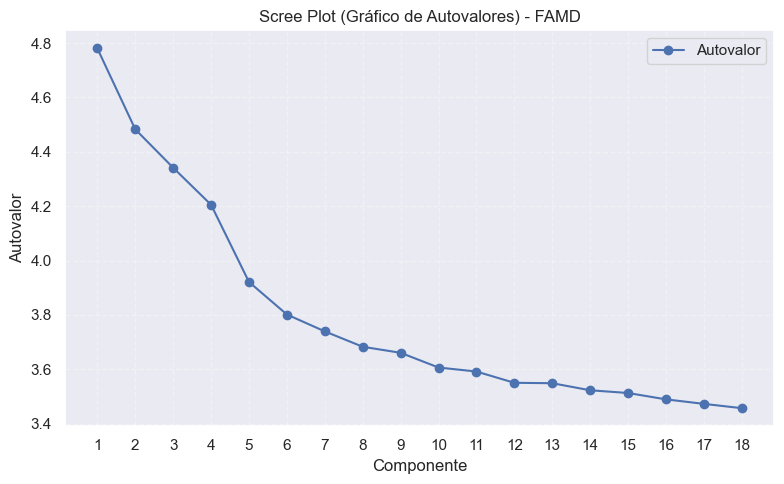

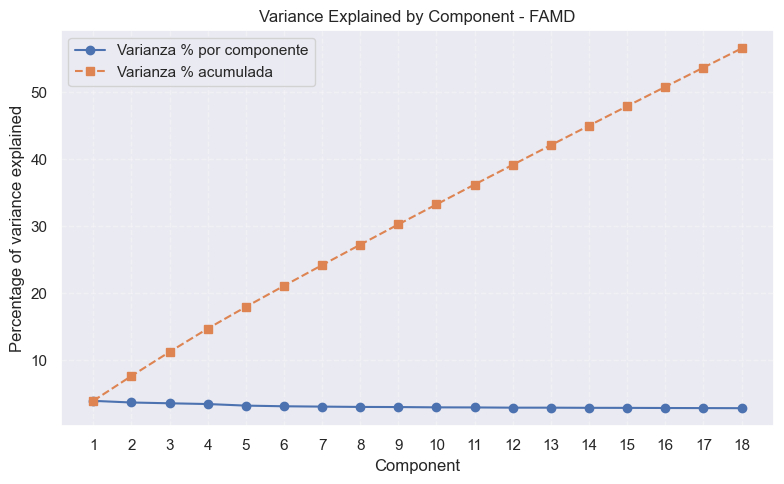

In [190]:
# 3. Calcular el porcentaje de varianza explicada
# total_inertia = famd.total_inertia_
# explained_variance_ratio = eigenvalues / total_inertia
# percentage_explained_variance = explained_variance_ratio * 100
cumulative_explained_variance = percentage_explained_variance.cumsum()

# 4. Graficar el Scree Plot (Gráfico de Eigenvalures)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', label='Autovalor')
plt.title('Scree Plot (Gráfico de Autovalores) - FAMD')
plt.xlabel('Componente')
plt.ylabel('Autovalor')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 5. Opcional: Graficar la varianza explicada (similar al gráfico anterior, pero usando los valores correctos)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(percentage_explained_variance) + 1), percentage_explained_variance, marker='o', label='Varianza % por componente')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='s', linestyle='--', label='Varianza % acumulada')

plt.title('Variance Explained by Component - FAMD')
plt.xlabel('Component')
plt.ylabel('Percentage of variance explained')
plt.xticks(range(1, len(percentage_explained_variance) + 1))
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

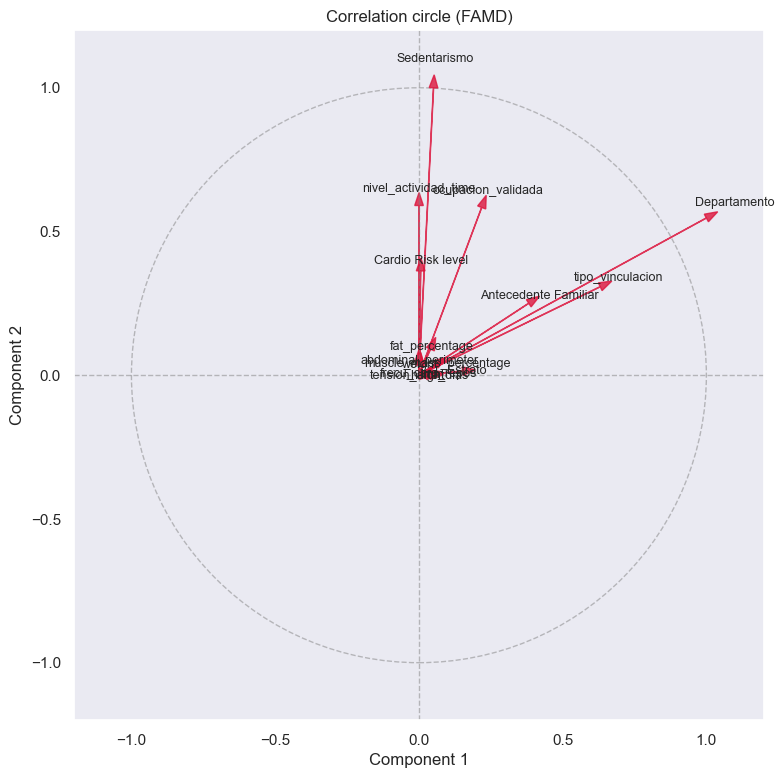

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener las contribuciones de las variables
col_coords = famd.column_contributions_.copy()

# Normalizar las columnas 0 y 1 al rango [-1, 1] (solo para visualización)
for dim in [0, 1]:
    max_val = np.abs(col_coords[dim]).max()
    if max_val > 0:
        col_coords[dim] = col_coords[dim] / max_val

# FACTOR DE ESCALA para hacer flechas más visibles
scale_factor = 1.0  # Ya están normalizadas, así que esto se puede dejar en 1 o ajustar levemente

x_scaled = col_coords[0] * scale_factor
y_scaled = col_coords[1] * scale_factor

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 8))

# Círculo unitario
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
ax.add_artist(circle)

# Dibujar flechas
for var in col_coords.index:
    ax.arrow(0, 0, x_scaled[var], y_scaled[var], color='crimson', alpha=0.8, head_width=0.03)
    ax.text(x_scaled[var]*1.1, y_scaled[var]*1.1, str(var), fontsize=9, ha='center', va='center')

# Líneas guía y estética
plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
plt.title("Correlation circle (FAMD)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(False)
plt.tight_layout()
plt.show()

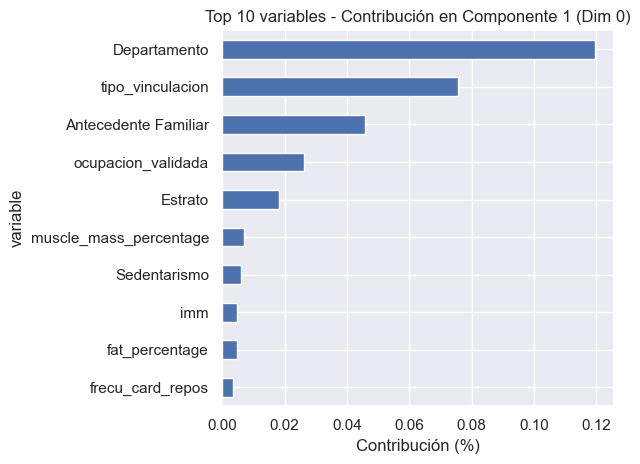

In [192]:
famd.fit(df_famd)

# Obtener la contribución de las variables a los componentes
loadings = famd.column_contributions_

# Visualizar los 10 más importantes del primer componente (Dim 0)
import matplotlib.pyplot as plt

loadings_dim1 = loadings[0].sort_values(ascending=False)
loadings_dim1.head(10).plot(kind='barh')

plt.title('Top 10 variables - Contribución en Componente 1 (Dim 0)')
plt.xlabel('Contribución (%)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Para k=2, índice de silueta = 0.5174
Para k=3, índice de silueta = 0.5874
Para k=4, índice de silueta = 0.5041
Para k=5, índice de silueta = 0.5103
Para k=6, índice de silueta = 0.5164
Para k=7, índice de silueta = 0.4657


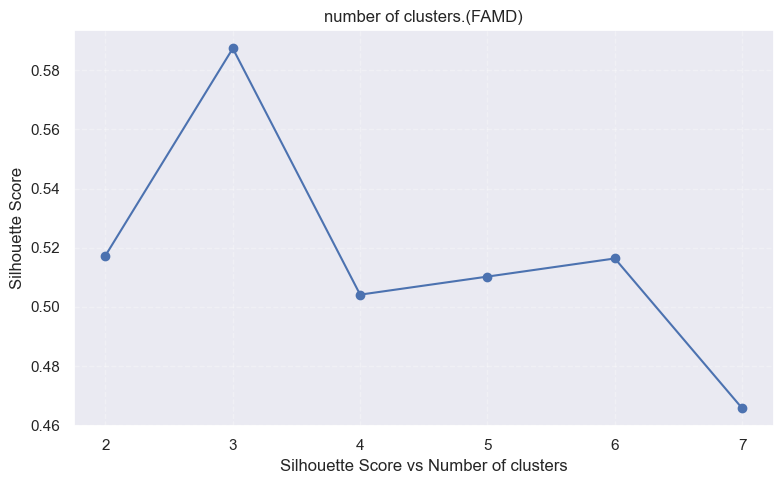

In [193]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Data reducida (coordenadas FAMD ya calculadas)
X = col_coords.copy()  

#365555 Asegurar que los nombres de columnas sean strings
X.columns = X.columns.astype(str)

# Evaluar distintos valores de k
range_n_clusters = range(2, 8)
silueta_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silueta_scores.append(score)
    print(f"Para k={k}, índice de silueta = {score:.4f}")

# Graficar el índice de silueta
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silueta_scores, marker='o')
plt.title('number of clusters.(FAMD)')
plt.xlabel('Silhouette Score vs Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [194]:
# # Agrupar en 3 clusters
# df_famd_reduced.columns = df_famd_reduced.columns.astype(str)
# kmeans = KMeans(n_clusters=4, random_state=42)
# df_famd_reduced['cluster'] = kmeans.fit_predict(df_famd_reduced)

In [195]:
from sklearn.cluster import KMeans

# 1. Reducir dimensionalidad
coord = famd.row_coordinates(df_famd)
df_famd_reduced = coord.iloc[:, [0, 1]].copy()
df_famd_reduced.columns = ['Componente 1', 'Componente 2']

# 2. Aplicar clustering directamente sobre df_famd_reduced
kmeans = KMeans(n_clusters=3, random_state=42)
df_famd_reduced['cluster'] = kmeans.fit_predict(df_famd_reduced)


In [196]:
#print(contribuciones)

<Figure size 1200x800 with 0 Axes>

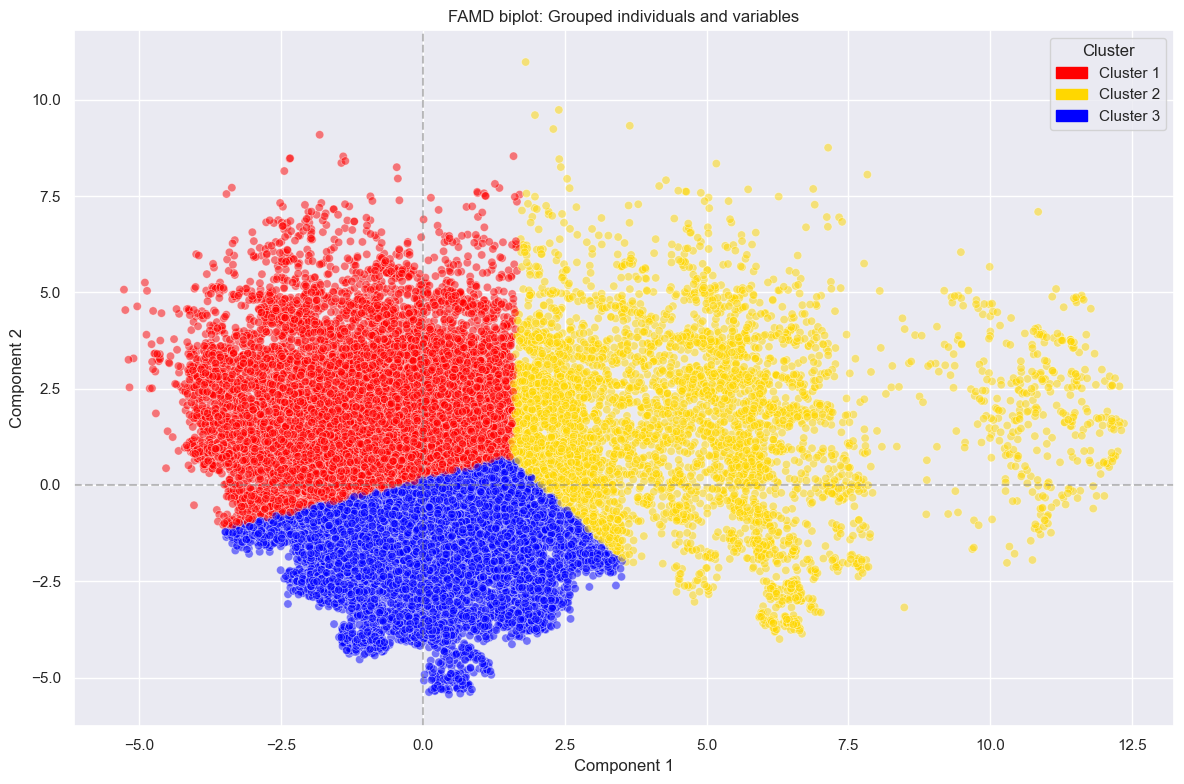


--- Cluster 1 ---
Centroide del cluster (coordenadas en los componentes):
component
0    -1.186373
1     1.572491
2     0.009937
3    -0.097715
4     0.098827
5    -0.025342
6     0.014840
7    -0.025124
8    -0.035570
9    -0.045670
10    0.075623
11   -0.036446
12    0.035985
13    0.062856
14   -0.016225
15    0.027475
16    0.046888
17   -0.063674
dtype: float64
Variables con mayor peso para definir las características del Cluster 1:
tension_arte_dias       0.316371
Estrato                 0.167437
weight                  0.133064
Antecedente Familiar    0.115854
ocupacion_validada      0.087785
nivel_actividad_time    0.084755
frecu_card_repos        0.061547
tipo_vinculacion        0.025591
fat_percentage          0.020344
Cardio Risk level       0.017622
dtype: float64

--- Cluster 2 ---
Centroide del cluster (coordenadas en los componentes):
component
0     4.326654
1     1.437220
2     0.799208
3    -0.375004
4    -0.085818
5     0.254550
6    -0.356397
7     0.335884
8     0

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import prince
from sklearn.cluster import KMeans

# 1. Coordenadas de individuos (solo 2 componentes para graficar)
row_coords = famd.row_coordinates(df_famd).iloc[:, [0, 1]]
row_coords.columns = ['Componente 1', 'Componente 2']

# 2. Coordenadas de variables
col_coords = famd.column_coordinates_.iloc[:, [0, 1]]
col_coords.columns = ['Componente 1', 'Componente 2']

# 3. Clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(row_coords)

cluster_labels_named = cluster_labels + 1  

# 4. Agregar cluster
row_coords['cluster'] = cluster_labels_named
df_famd_clustered = df_famd.copy()
df_famd_clustered['cluster'] = cluster_labels_named

# 5. Escalar flechas
scale_factor = 3
col_coords_scaled = col_coords * scale_factor

# 6. Gráfico plot
plt.figure(figsize=(12, 8))
import matplotlib.patches as mpatches

# Paleta de colores fija (según el cluster)
custom_palette = {
    1: 'red',     # Cluster 1 → amarillo
    2: 'gold',    # Cluster 2 → verde
    3: 'blue',     # Cluster 3 → azul
    #4: 'purple',   # Cluster 4 → morado
    #5: 'red'       # Cluster 5 → negro
}

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Componente 1',
    y='Componente 2',
    hue='cluster',
    data=row_coords,
    palette=custom_palette,
    alpha=0.5,
    legend=False  # Desactivamos leyenda automática
)

# # Flechas: variables
# for var in col_coords_scaled.index:
#     x = col_coords_scaled.loc[var, 'Componente 1']
#     y = col_coords_scaled.loc[var, 'Componente 2']
#     plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.1, head_length=0.2)
#     plt.text(x * 1.1, y * 1.1, var, color='darkred', fontsize=9)

# Leyenda manual
handles = [
    mpatches.Patch(color='red', label='Cluster 1'),
    mpatches.Patch(color='gold', label='Cluster 2'),
    mpatches.Patch(color='blue', label='Cluster 3'),
    #mpatches.Patch(color='purple', label='Cluster 4'),
    # mpatches.Patch(color='red', label='Cluster 5')
]
plt.legend(handles=handles, title='Cluster')

# Estética
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.title("FAMD biplot: Grouped individuals and variables")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Evaluar variables importantes por cluster
contribuciones_variables = famd.column_contributions_
coordenadas_filas = famd.row_coordinates(df_famd)

for i in range(1, n_clusters + 1):
    print(f"\n--- Cluster {i} ---")
    cluster_indices = df_famd_clustered[df_famd_clustered['cluster'] == i].index
    coordenadas_cluster = coordenadas_filas.loc[cluster_indices]

    media_cluster = coordenadas_cluster.mean(axis=0)
    print("Centroide del cluster (coordenadas en los componentes):")
    print(media_cluster)

    pesos_cluster = pd.Series(index=df_famd.columns, dtype='float64')
    num_componentes = famd.n_components
    for var_idx, nombre_variable in enumerate(df_famd.columns):
        peso_variable = 0
        for comp_idx in range(num_componentes):
            peso_variable += abs(media_cluster[comp_idx]) * contribuciones_variables.iloc[var_idx, comp_idx]
        pesos_cluster[nombre_variable] = peso_variable

    variables_importantes_cluster = pesos_cluster.sort_values(ascending=False)
    print(f"Variables con mayor peso para definir las características del Cluster {i}:")
    print(variables_importantes_cluster.head(10))



In [198]:
import plotly.express as px

# 1. Coordenadas de individuos 
row_coords = famd.row_coordinates(df_famd).iloc[:, [0, 1,2]]
row_coords.columns = ['Component 1', 'Component 2', 'Component 3']

# 2. Coordenadas de variables
col_coords = famd.column_coordinates_.iloc[:, [0, 1,2]]
col_coords.columns = ['Component 1', 'Component 2', 'Component 3']


# 3. Clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(row_coords)

cluster_labels_named = cluster_labels + 1  

# 4. Agregar cluster
row_coords['cluster'] = cluster_labels_named
df_famd_clustered = df_famd.copy()
df_famd_clustered['cluster'] = cluster_labels_named

# 5. Escalar flechas
scale_factor = 3
col_coords_scaled = col_coords * scale_factor

fig = px.scatter_3d(
    row_coords,
    x='Componente 1',
    y='Componente 2',
    z='Componente 3',
    color='cluster',
    color_discrete_map={
        '1': "#eb1115",  # rojo
        '2': '#ffcc00',  # amarillo
        '3': '#377eb8'   # azul
    },
    opacity=1.0
)

# Puntos más pequeños y borde blanco
fig.update_traces(marker=dict(
    size=2.5,
    line=dict(width=0.5, color='white')
))

# Gráfico más grande
fig.update_layout(
    title="Clustering FAMD: Visualización 3D refinada",
    legend_title="Cluster",
    width=900,
    height=700,
    scene=dict(
        xaxis=dict(title='Component 1'),
        yaxis=dict(title='Component 2'),
        zaxis=dict(title='Component 3')
    ))

fig.show()
fig.write_html("clustering_3d.html")


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['Component 1', 'Component 2', 'Component 3', 'cluster'] but received: Componente 1

In [199]:
df_famd_clustered1= df_famd_clustered[df_famd_clustered['cluster']== 1]
df_famd_clustered1.head()

imm  fat_percentage  Cardio Risk level        Departamento  \
3   9.257300            35.3                  0        Cundinamarca   
4   9.977011            14.6                  0           Antioquia   
6  10.698677            20.1                  0        Cundinamarca   
8  10.431287            24.0                  0             Quindio   
9   8.666667            18.0                  0  Norte de Santander   

   muscle_mass_percentage  abdominal_perimeter Sedentarismo  height  \
3                    31.0                 92.5           NO    1.65   
4                    43.4                 78.5           NO    1.74   
6                    39.5                 85.0           NO    1.71   
8                    36.6                 97.0           NO    1.73   
9                    39.0                 76.0           NO    1.80   

  tipo_vinculacion ocupacion_validada  frecu_card_repos  tension_arte_dias  \
3    Contributivo         Profesional              70.0               80.0   
4    Contributivo         Profesional              84.0               70.0   
6    Contributivo           Bachiller              75.0               60.0   
8    Contributivo           Bachiller              60.0               80.0   
9    Contributivo         Profesional              79.0               80.0   

   weight nivel_actividad_time Antecedente Familiar  Estrato  cluster  
3    81.3               Activo                   NO      3.0        1  
4    69.6           Muy Activo                   NO      4.0        1  
6    79.2           Muy Activo                   NO      4.0        1  
8    85.3           Muy Activo                   NO      4.0        1  
9    72.0               Activo                   NO      3.0        1

In [200]:
df_famd_clustered['cluster'].value_counts()

cluster
1    24784
3    24509
2     3180
Name: count, dtype: int64

In [201]:
#df_famd_clustered.to_excel('Cluster_1408.xlsx', index=False)

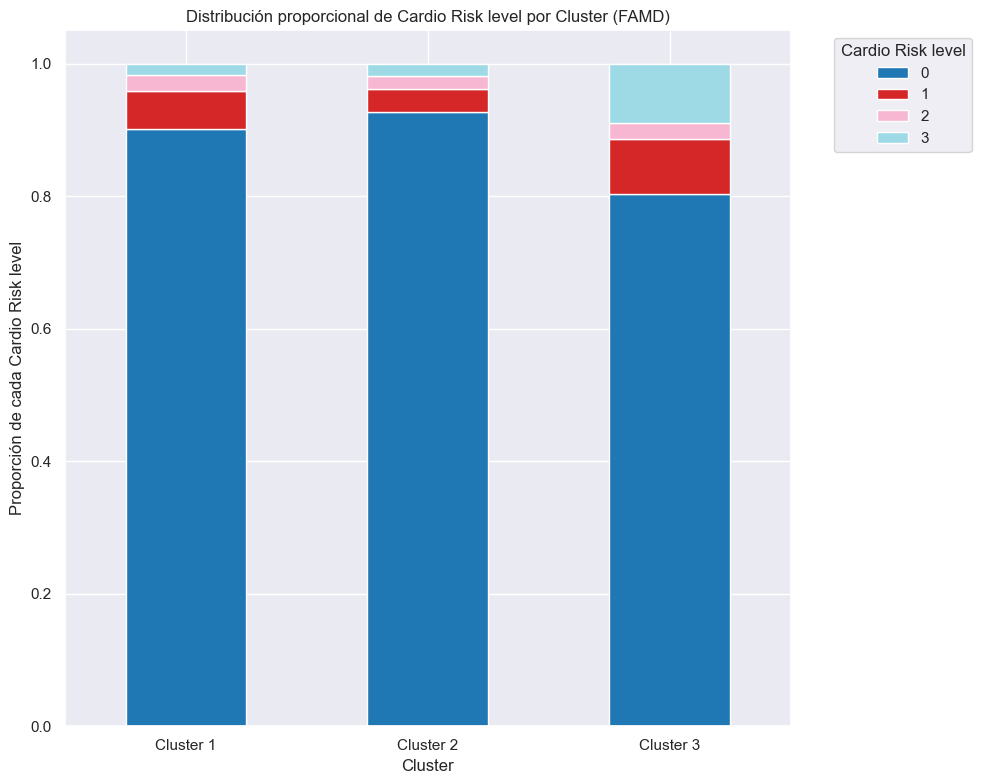

In [202]:

df_famd_clustered['Cardio Risk level'] = df_famd['Cardio Risk level'].values  # ambas tienen mismo índice

# Agrupar por cluster y Cardio Risk level, calcular proporción
Cardio_Risk_level_cluster = df_famd_clustered.groupby('cluster')['Cardio Risk level'].value_counts(normalize=True).unstack().fillna(0)

# Ordenar filas por cluster 1 al 3
Cardio_Risk_level_cluster = Cardio_Risk_level_cluster.sort_index()

# Gráfico de barras apiladas
Cardio_Risk_level_cluster.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 8),
    colormap='tab20'
)

plt.title("Distribución proporcional de Cardio Risk level por Cluster (FAMD)")
plt.xlabel("Cluster")
plt.ylabel("Proporción de cada Cardio Risk level")
plt.legend(title="Cardio Risk level", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=range(n_clusters), labels=[f'Cluster {i}' for i in range(1, n_clusters + 1)], rotation=0)
plt.tight_layout()
plt.show()

In [203]:
df_cr['cluster'] = df_famd_reduced['cluster'].values
df_cr.select_dtypes(include='object').dtypes

tipo_vinculacion             object
ocupacion_validada           object
nivel_actividad_time         object
birthdate                    object
Departamento                 object
state_pregnancy              object
sede_uso                     object
ciudad                       object
category_sede_uso            object
region                       object
diagnostic_name_1            object
diagnostic_name_2            object
date_quote                   object
status_quote                 object
document_number              object
document_number_type         object
evaluador_acc                object
Sedentarismo                 object
Hipertensión                 object
Dislipidemia                 object
Obesidad                     object
Edad Riesgo                  object
Antecedente Familiar         object
Diabetes                     object
diagnostico_hipertension     object
diagnostico_cardio           object
diagnostico_diabetes         object
diagnostico_renal           

In [204]:
# Edad y estrato promedio y mediana por cluster
df_cr.groupby('cluster').agg({
    'edad': ['mean', 'median'],
    'Estrato': ['mean', lambda x: x.mode()[0]]
}).rename(columns={'<lambda_0>': 'mode'}).reset_index()

cluster       edad          Estrato     
                mean median      mean mode
0       0  41.768340   39.0  3.718785  3.0
1       1  38.372515   34.0  3.169294  3.0
2       2  37.697584   36.0  3.496506  3.0

In [205]:
from scipy.spatial.distance import euclidean

# Usar las primeras 3 componentes
coord_3d = coord[[0, 1, 2]]

# Calcular centroide
centroide = coord_3d.mean().values

# Calcular distancia euclidiana desde el centroide
coord['distancia'] = coord_3d.apply(lambda row: euclidean(row.values, centroide), axis=1)

#Unir esta distancia al DataFrame original df_cr # Asegurar mismo orden de índices
df_cr = df_cr.copy()
df_cr['distancia'] = coord['distancia']

#Ver los posibles outliers (más alejados)
outliers = df_cr.sort_values('distancia', ascending=False).head(10)
outliers.head()

user_id   date_acc  height    imc       imm  fat_percentage  \
38857  2531363 2024-02-20    1.55  24.18  6.190884            37.7   
26943  1506975 2023-02-08    1.60  25.27  6.596367            37.7   
37600   405534 2024-01-18    1.68  22.68  6.099773            35.1   
26144  1470374 2022-12-01    1.57  27.10  6.639620            40.2   
48961  3197743 2025-02-27    1.68  29.73  7.253260            43.9   

      tipo_vinculacion ocupacion_validada  minutos_por_semana  \
38857       Subsidiado  Tecnologo/Tecnico              72.660   
26943       Subsidiado  Tecnologo/Tecnico             105.355   
37600       Subsidiado  Tecnologo/Tecnico             158.335   
26144       Subsidiado  Tecnologo/Tecnico             144.075   
48961       Subsidiado  Tecnologo/Tecnico             107.080   

      nivel_actividad_time  ...  rango_edad  Cardio Risk level  \
38857          Poco Activo  ...       18-27                  0   
26943          Poco Activo  ...       28-37                  0   
37600               Activo  ...       18-27                  0   
26144          Poco Activo  ...       48-57                  0   
48961          Poco Activo  ...       48-57                  0   

       Identifica Extranjero       diagnostic_clean_1  \
38857       No es extranjero    EXAMEN MEDICO GENERAL   
26943       No es extranjero  AUMENTO ANORMAL DE PESO   
37600       No es extranjero    EXAMEN MEDICO GENERAL   
26144       No es extranjero       OTRAS ESPONDILOSIS   
48961       No es extranjero  AUMENTO ANORMAL DE PESO   

            diagnostic_clean_2  tipo_diagnostico  genero  Tabaquismo cluster  \
38857    EXAMEN MEDICO GENERAL         No aplica       0          NO       1   
26943  AUMENTO ANORMAL DE PESO         No aplica       0          NO       1   
37600    EXAMEN MEDICO GENERAL         No aplica       0          NO       1   
26144       OTRAS ESPONDILOSIS         No aplica       0          NO       1   
48961  AUMENTO ANORMAL DE PESO         No aplica       0          NO       1   

       distancia  
38857  16.451607  
26943  16.343532  
37600  16.319407  
26144  16.303959  
48961  16.198586  

[5 rows x 61 columns]

In [206]:
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52473 entries, 0 to 52472
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   user_id                    52473 non-null  int64         
 1   date_acc                   52473 non-null  datetime64[ns]
 2   height                     52473 non-null  float64       
 3   imc                        52473 non-null  float64       
 4   imm                        52473 non-null  float64       
 5   fat_percentage             52473 non-null  float64       
 6   tipo_vinculacion           52473 non-null  object        
 7   ocupacion_validada         52473 non-null  object        
 8   minutos_por_semana         52473 non-null  float64       
 9   nivel_actividad_time       52473 non-null  object        
 10  muscle_mass_percentage     52473 non-null  float64       
 11  abdominal_perimeter        52473 non-null  float64       
 12  weig

In [207]:
#df_cr.to_excel("Base_Final1408.xlsx", index=False)

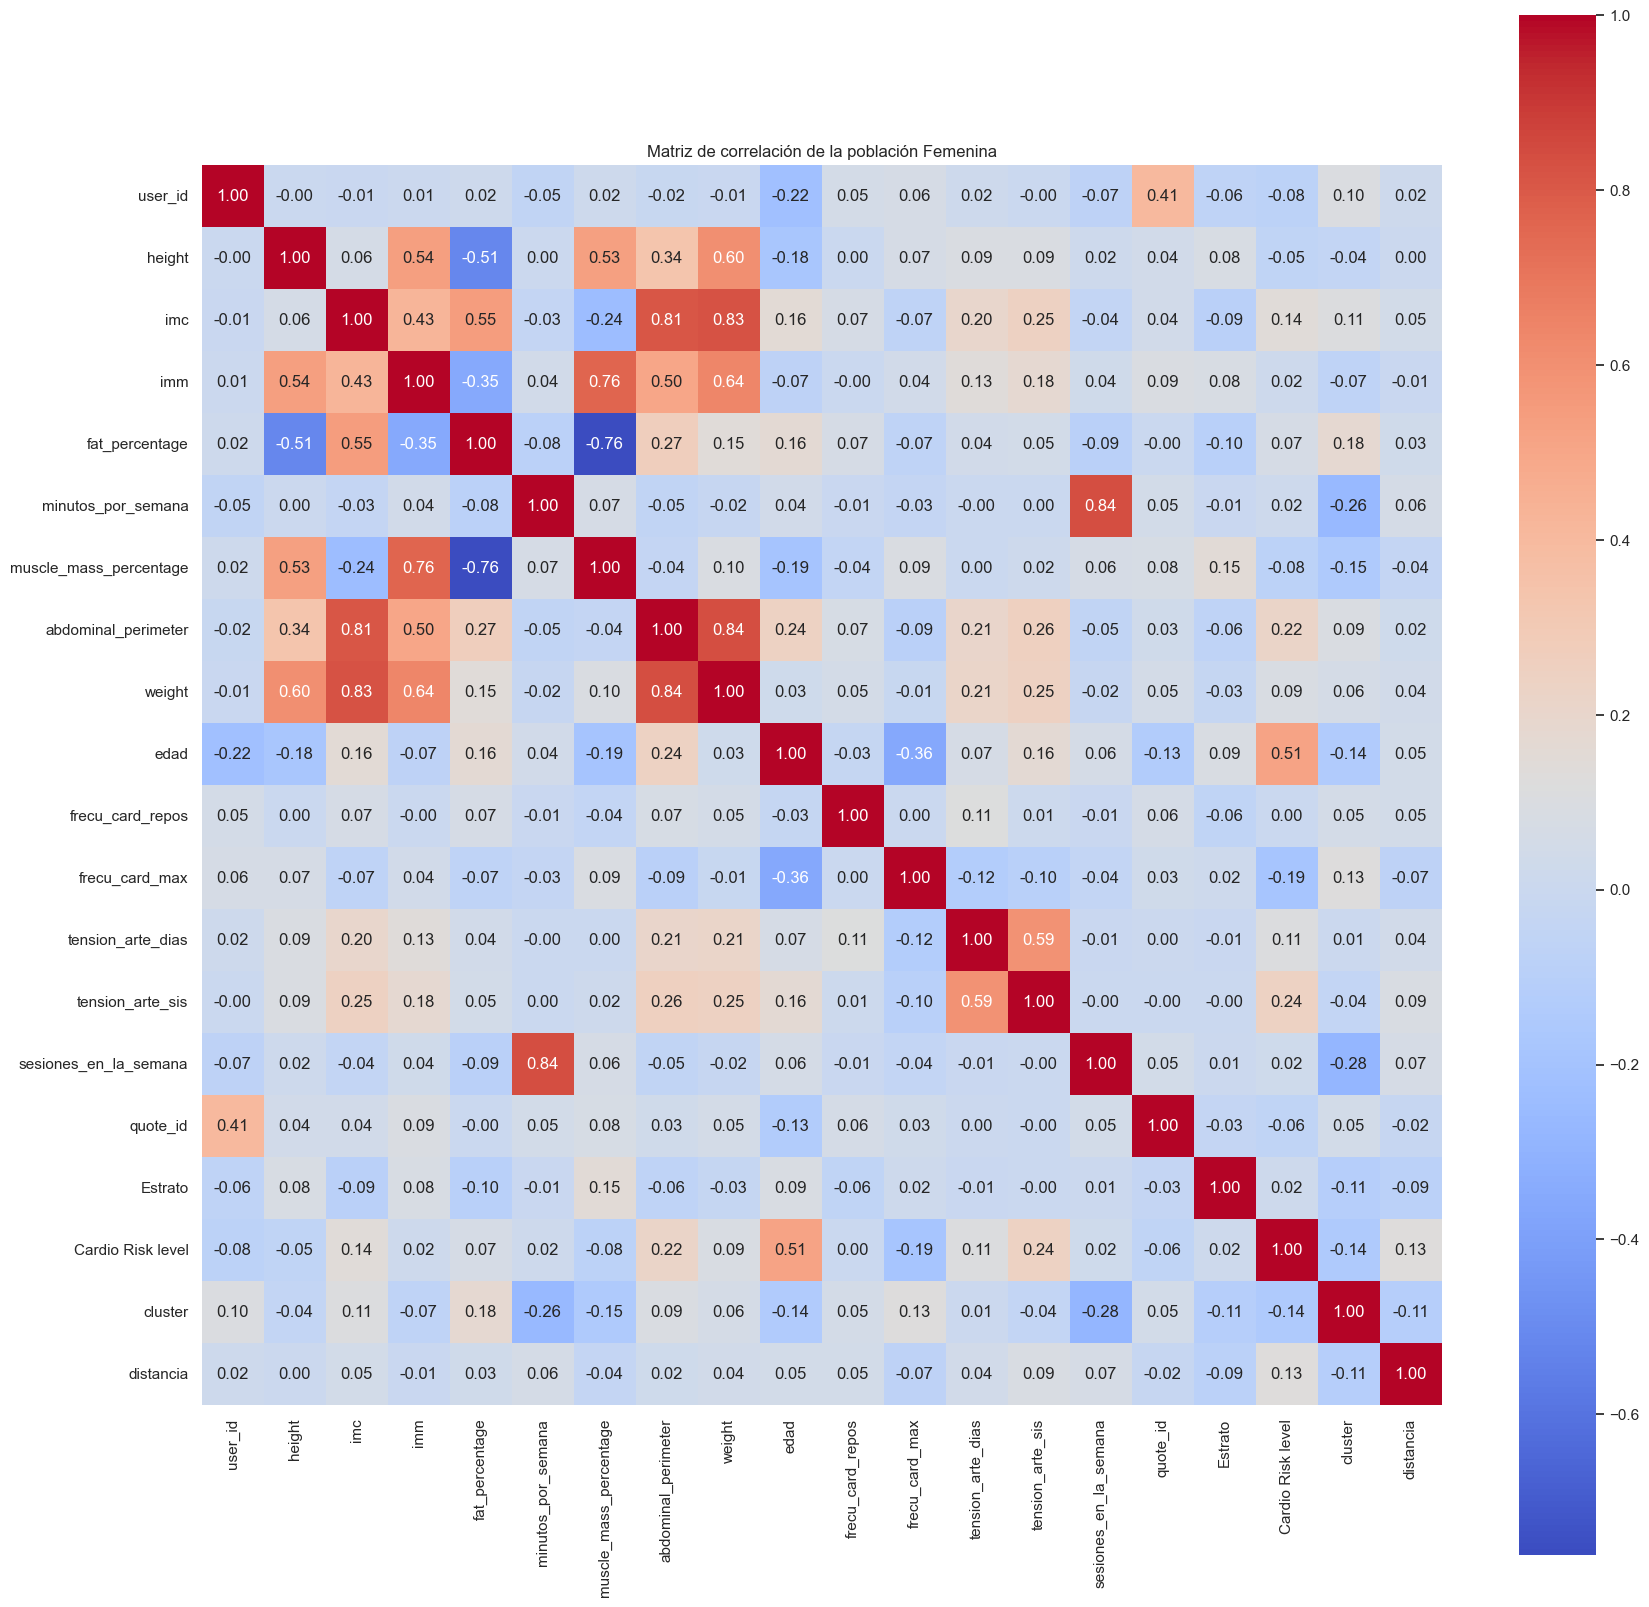

In [208]:
# Matriz de correlación 
corr = df_cr.corr(numeric_only=True)

# Dibujar el mapa de calor
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlación de la población Femenina")
plt.show()

In [209]:
df_cr.columns

Index(['user_id', 'date_acc', 'height', 'imc', 'imm', 'fat_percentage',
       'tipo_vinculacion', 'ocupacion_validada', 'minutos_por_semana',
       'nivel_actividad_time', 'muscle_mass_percentage', 'abdominal_perimeter',
       'weight', 'edad', 'birthdate', 'frecu_card_repos', 'frecu_card_max',
       'tension_arte_dias', 'Departamento', 'tension_arte_sis',
       'state_pregnancy', 'sede_uso', 'ciudad', 'sesiones_en_la_semana',
       'category_sede_uso', 'region', 'diagnostic_name_1', 'diagnostic_name_2',
       'quote_id', 'date_quote', 'status_quote', 'document_number',
       'document_number_type', 'evaluador_acc', 'Sedentarismo', 'Hipertensión',
       'Dislipidemia', 'Obesidad', 'Edad Riesgo', 'Antecedente Familiar',
       'Diabetes', 'diagnostico_hipertension', 'diagnostico_cardio',
       'diagnostico_diabetes', 'diagnostico_renal', 'diagnostico_dislipidemia',
       'Enfermedad Pulmonar', 'Enfermedad Cardiovascular', 'Enfermedad Renal',
       'riesgo_cardiov', 'Estrato'

In [210]:
df_cr['Cardio Risk level'].value_counts()

Cardio Risk level
0    44945
1     3581
3     2696
2     1251
Name: count, dtype: int64

In [211]:
# Filtrar solo los individuos del Cluster 1
cluster_1 = df_cr[df_cr['cluster'] == 2]  # Ajusta el número si Cluster 1 tiene otro índice

# Ver distribución de la variable "Identifica Extranjero"
distribucion_extranjeros = cluster_1['Identifica Extranjero'].value_counts(normalize=True) * 100

print(distribucion_extranjeros)

Identifica Extranjero
No es extranjero    98.574566
Es extranjero        1.425434
Name: proportion, dtype: float64


In [212]:
from scipy.spatial.distance import pdist, squareform
import pandas as pd

# Paso 1: Obtener las coordenadas de los centroides
centroides = coord.groupby(df_cr['cluster'])[[0, 1, 2]].mean()

# Paso 2: Calcular las distancias euclidianas entre todos los centroides
distancias = pdist(centroides.values, metric='euclidean')

# Paso 3: Convertir a matriz cuadrada y a DataFrame para visualización
matriz_distancias = pd.DataFrame(
    squareform(distancias),
    index=centroides.index,
    columns=centroides.index
)

# Mostrar la matriz de distancias entre centroides
print(matriz_distancias)

cluster         0         1         2
cluster                              
0        0.000000  5.570881  3.483098
1        5.570881  0.000000  5.418948
2        3.483098  5.418948  0.000000


In [213]:
df-_(),mor/()

TypeError: 'Series' object is not callable

## Selección de variables 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3947, number of negative: 48526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 52473, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075220 -> initscore=-2.509144
[LightGBM] [Info] Start training from score -2.509144


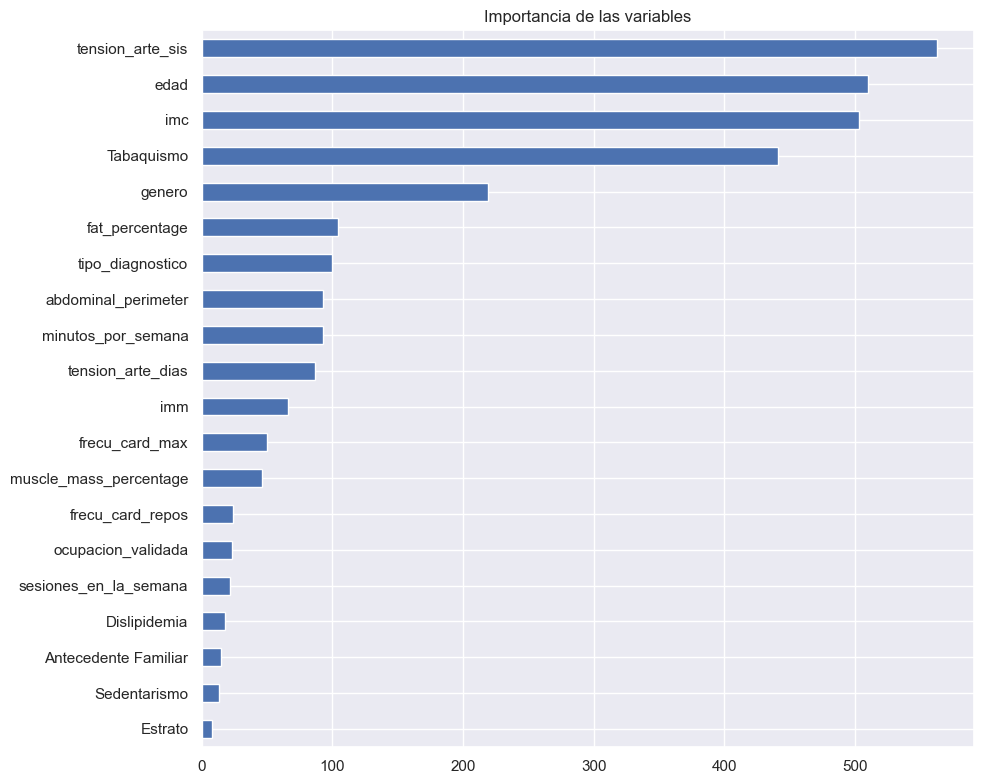

In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

# 1. Convertir a binaria la variable objetivo
df_cr['Cardiorisk'] = np.where(df_cr['Cardio Risk level'] <= 1, 0, 1)

# 2. Selección de variables
selected_feature = [
    'imc', 'imm', 'fat_percentage', 'muscle_mass_percentage', 'abdominal_perimeter',
    'edad', 'frecu_card_repos', 'frecu_card_max', 'tension_arte_dias','rango_edad',
    'tension_arte_sis', 'sede_uso', 'ciudad', 'category_sede_uso', 'region',
    'status_quote', 'Sedentarismo','sesiones_en_la_semana','minutos_por_semana','tipo_vinculacion','Departamento','ocupacion_validada',
    'Hipertensión', 'Dislipidemia', 'Obesidad', 'Antecedente Familiar',
    'Enfermedad Pulmonar', 'Enfermedad Cardiovascular', 'Enfermedad Renal',
    'Estrato',  'Cardiorisk',
    'Identifica Extranjero', 'tipo_diagnostico', 'genero', 'Tabaquismo'
]

df_ft = df_cr[selected_feature].copy()

# 3. Separar variables predictoras (X) y objetivo (y)
X = df_ft.drop(columns='Cardiorisk')
y = df_ft['Cardiorisk']

# 4. Detectar columnas tipo object y convertirlas a category
X = X.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)

# 4.1 Detectar las columnas categóricas explícitamente
object_cols = X.select_dtypes(['category']).columns.tolist()

# 5. Entrenar el modelo
model = LGBMClassifier(random_state=42)
model.fit(X, y, categorical_feature=object_cols)

# 6. Importancia de variables
importancia = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
importancia.tail(20).plot(kind='barh', figsize=(10, 8))
plt.title("Importancia de las variables")
plt.tight_layout()
plt.show()


In [215]:
df_cr.head()

user_id   date_acc  height    imc        imm  fat_percentage  \
0   444685 2022-02-19    1.76  24.76   8.195926            28.9   
1   926426 2022-02-22    1.88  24.16  11.598008            16.0   
2  1264358 2022-02-22    1.76  29.18   9.834969            26.8   
3  1253247 2022-02-23    1.65  29.86   9.257300            35.3   
4   187175 2022-03-02    1.74  22.99   9.977011            14.6   

  tipo_vinculacion ocupacion_validada  minutos_por_semana  \
0    Contributivo         Profesional             218.245   
1       Subsidiado        Profesional             200.995   
2    Contributivo         Profesional             162.815   
3    Contributivo         Profesional             248.200   
4    Contributivo         Profesional             832.620   

  nivel_actividad_time  ...  Cardio Risk level  Identifica Extranjero  \
0               Activo  ...                  0       No es extranjero   
1               Activo  ...                  0       No es extranjero   
2               Activo  ...                  3       No es extranjero   
3               Activo  ...                  0       No es extranjero   
4           Muy Activo  ...                  0       No es extranjero   

                                  diagnostic_clean_1  \
0                              EXAMEN MEDICO GENERAL   
1  OTROS TRASTORNOS ESPECIFICADOS DE LOS DISCOS I...   
2  LECTURA ELEVADA DE LA PRESION SANGUINEA, SIN D...   
3                              ADIPOSIDAD LOCALIZADA   
4                              EXAMEN MEDICO GENERAL   

                                  diagnostic_clean_2 tipo_diagnostico  genero  \
0                              EXAMEN MEDICO GENERAL        No aplica       1   
1  OTROS TRASTORNOS ESPECIFICADOS DE LOS DISCOS I...        No aplica       1   
2  LECTURA ELEVADA DE LA PRESION SANGUINEA, SIN D...           Cardio       1   
3                              ADIPOSIDAD LOCALIZADA        No aplica       1   
4                              EXAMEN MEDICO GENERAL        No aplica       1   

   Tabaquismo  cluster distancia  Cardiorisk  
0          SI        2  2.323955           0  
1          SI        0  8.869701           0  
2          SI        2  3.791512           1  
3          SI        0  1.942110           0  
4          SI        0  2.058990           0  

[5 rows x 62 columns]

### Outliers

In [216]:
df_cr['user_id'].nunique()

52473

In [217]:
# Convertir a binaria si aplica  #<= 1
df_cr['Cardiorisk']=np.where(df_cr['Cardio Risk level'] == 0, 0 , 1)

#Seleccion de variables 
columns = ['user_id','height', 'imc', 'imm', 'fat_percentage', 'muscle_mass_percentage',
            'abdominal_perimeter', 'weight', 'frecu_card_repos', 'Cardiorisk','ocupacion_validada',
            'frecu_card_max', 'tension_arte_dias', 'tension_arte_sis', 'sede_uso', 'ciudad', 'category_sede_uso',
            'region', 'tipo_diagnostico','status_quote', 'Sedentarismo', 'Hipertensión', 'Dislipidemia',
            'Obesidad', 'Edad Riesgo', 'Antecedente Familiar', 'Diabetes', 'Enfermedad Cardiovascular', 'Estrato', 'edad',
            'rango_edad', 'Identifica Extranjero',  'genero', 'Tabaquismo', 'nivel_actividad_time',
            'sesiones_en_la_semana', 'minutos_por_semana', 'tipo_vinculacion', 'Departamento', 'Enfermedad Pulmonar', 'Enfermedad Renal']

df_cr=df_cr[columns] 

In [218]:
df_cr.select_dtypes(include=['object']).columns
#df_cr['col1'] = df_cr['col1'].astype(int)

Index(['ocupacion_validada', 'sede_uso', 'ciudad', 'category_sede_uso',
       'region', 'tipo_diagnostico', 'status_quote', 'Sedentarismo',
       'Hipertensión', 'Dislipidemia', 'Obesidad', 'Edad Riesgo',
       'Antecedente Familiar', 'Diabetes', 'Enfermedad Cardiovascular',
       'Identifica Extranjero', 'genero', 'Tabaquismo', 'nivel_actividad_time',
       'tipo_vinculacion', 'Departamento', 'Enfermedad Pulmonar',
       'Enfermedad Renal'],
      dtype='object')

In [219]:
df_cr['Cardiorisk'].value_counts()

Cardiorisk
0    44945
1     7528
Name: count, dtype: int64

#### Revisión de outliers 

In [220]:
num_cols = [
    'height', 'imc', 'imm', 'fat_percentage', 'muscle_mass_percentage',
    'abdominal_perimeter', 'weight', 'frecu_card_repos',
    'frecu_card_max', 'tension_arte_dias', 'tension_arte_sis'
]

from scipy.stats import zscore
import numpy as np

# Calcular z-score para las columnas seleccionadas
z_scores = df_cr[num_cols].apply(zscore)

# Ver cuántos valores tienen z-score absoluto mayor a 3
outlier_mask = (np.abs(z_scores) > 3)

# Contar outliers por columna
outliers_por_columna = outlier_mask.sum().sort_values(ascending=False)
print(outliers_por_columna)


frecu_card_max            1922
tension_arte_sis           546
tension_arte_dias          541
weight                     475
imc                        433
frecu_card_repos           403
abdominal_perimeter        355
imm                        165
height                      54
muscle_mass_percentage      41
fat_percentage               1
dtype: int64


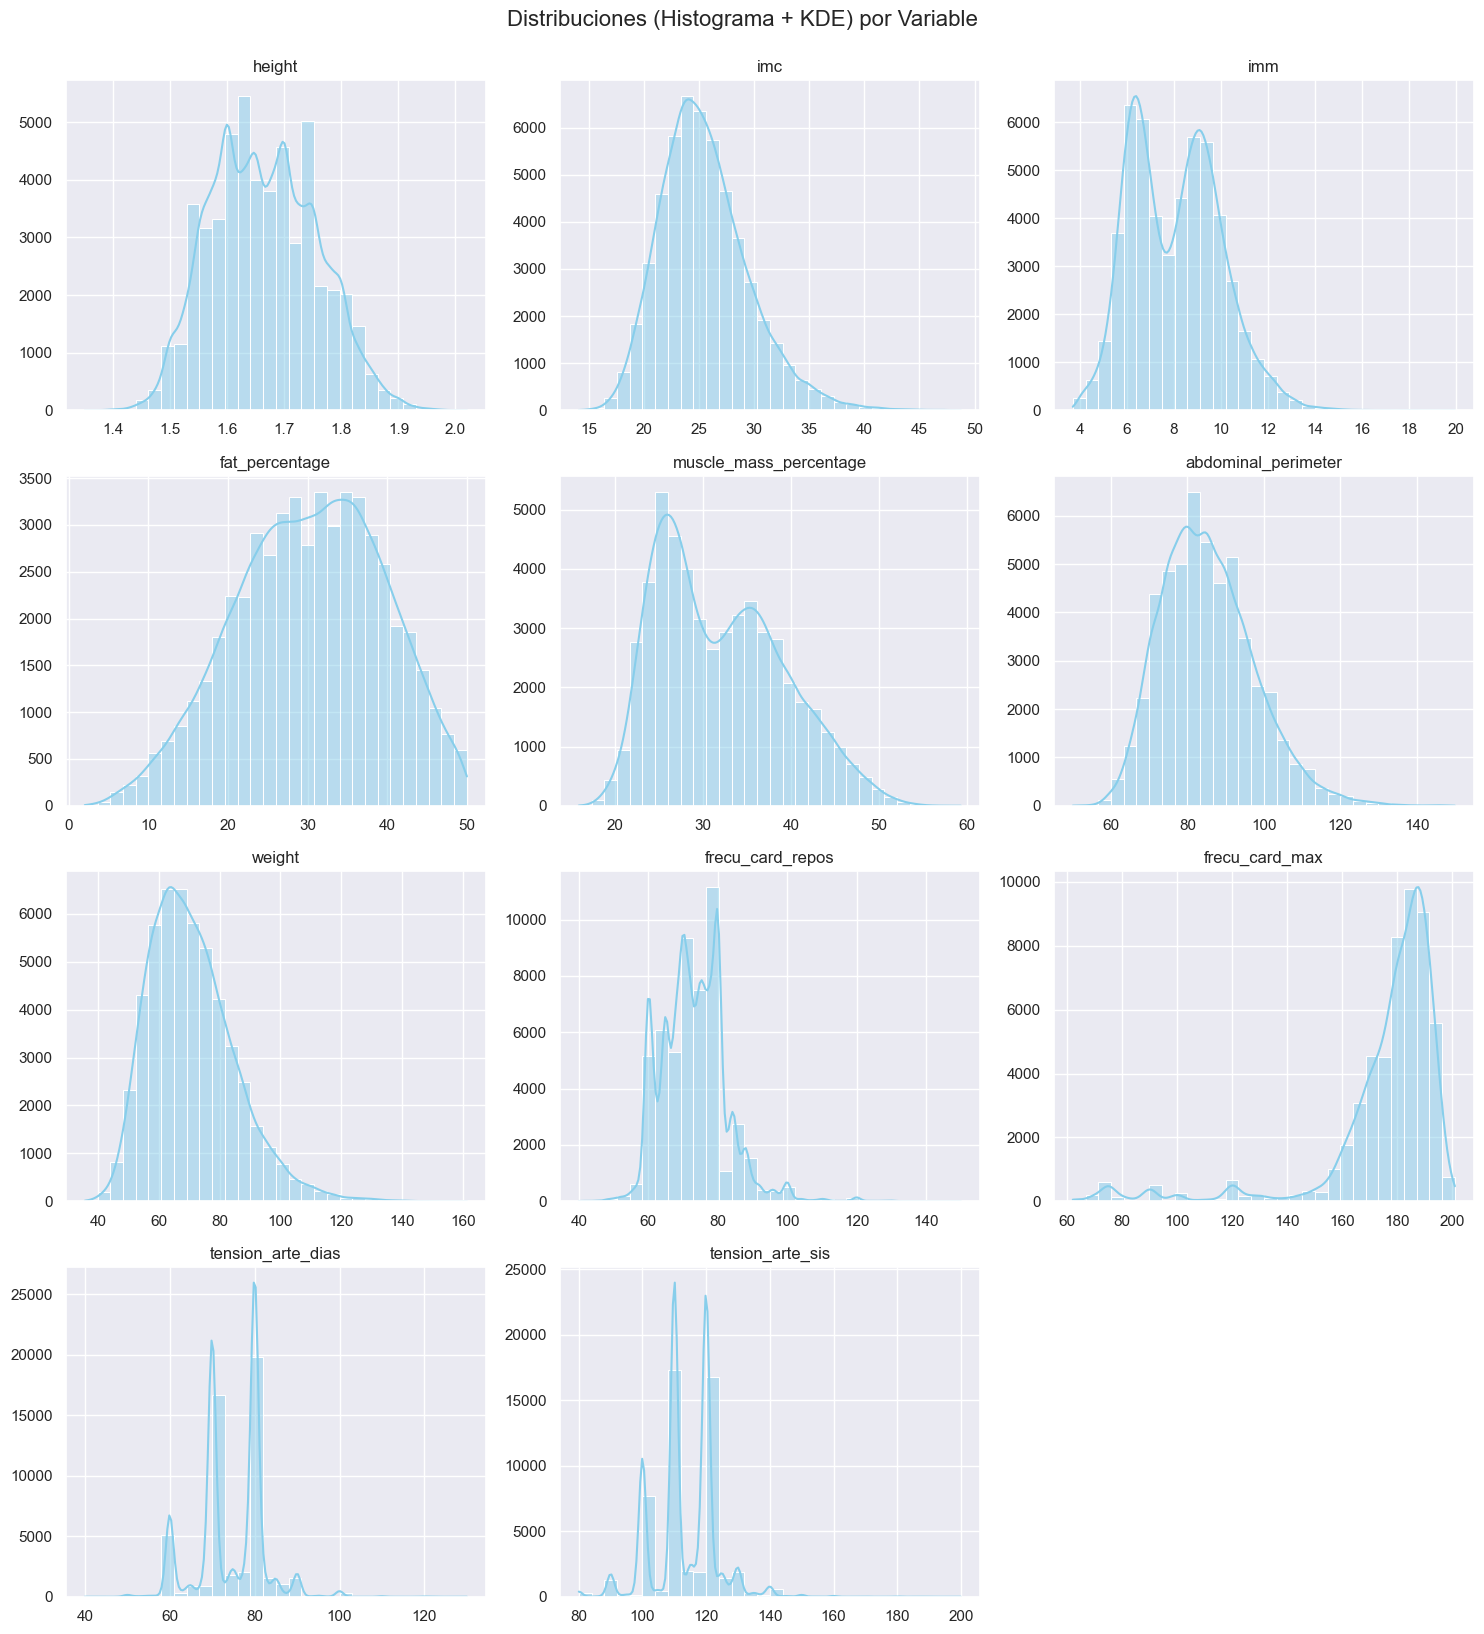

In [221]:

import math
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de la matriz de subplots
n_cols = 3  # Columnas por fila
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))  # Tamaño ajustado a número de subplots

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_cr[col], kde=True, bins=30, color='skyblue')
    plt.title(f'{col}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.suptitle("Distribuciones (Histograma + KDE) por Variable", fontsize=16, y=1.02)
plt.show()


    # print(f"Estadísticas descriptivas para '{col}':")
    # print(df_cr[col].describe())
    # print("-" * 30)


In [222]:
#Winsonorización 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

# # Selecciona tus variables reales
X = df_cr[['frecu_card_repos','tension_arte_dias','tension_arte_sis','frecu_card_max', 'imc']]
y = df_cr['Cardiorisk']

# # Winsorización: cortar outliers extremos (percentil 1 a 99)
def winsorizar(col, p1=0.01, p99=0.99):
     lower = col.quantile(p1)
     upper = col.quantile(p99)
     return col.clip(lower, upper)

X_winsor = X.copy()
X_winsor['frecu_card_repos'] = winsorizar(X_winsor['frecu_card_repos'])
X_winsor['tension_arte_dias'] = winsorizar(X_winsor['tension_arte_dias'])
X_winsor['tension_arte_sis'] = winsorizar(X_winsor['tension_arte_sis'])
X_winsor['frecu_card_max'] = winsorizar(X_winsor['frecu_card_max'])
X_winsor['imc'] = winsorizar(X_winsor['imc'])

# # Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_train_w, X_test_w, _, _ = train_test_split(X_winsor, y, stratify=y, test_size=0.3, random_state=42)

# # Entrenamiento
model_raw = LGBMClassifier().fit(X_train, y_train)
model_winsor = LGBMClassifier().fit(X_train_w, y_train)

# # AUC
#print("AUC sin winsorizar:", roc_auc_score(y_test, model_raw.predict_proba(X_test)[:, 1]))
# print("AUC con winsorizar:", roc_auc_score(y_test, model_winsor.predict_proba(X_test_w)[:, 1]))


[LightGBM] [Info] Number of positive: 5270, number of negative: 31461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 36731, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143476 -> initscore=-1.786718
[LightGBM] [Info] Start training from score -1.786718
[LightGBM] [Info] Number of positive: 5270, number of negative: 31461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 36731, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143476 -> initscore=-1.786718
[LightGBM] [Info] Start training from score -1.786718


In [223]:
df.hyt()-:)=)

SyntaxError: unmatched ')' (2398768683.py, line 1)

## Modelo

In [224]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score

In [225]:
#df_cr.to_excel('Basemodelo1408.xlsx', index=False)

In [226]:
df_cr=pd.read_excel('Basemodelo1408.xlsx')
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52473 entries, 0 to 52472
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    52473 non-null  int64  
 1   height                     52473 non-null  float64
 2   imc                        52473 non-null  float64
 3   imm                        52473 non-null  float64
 4   fat_percentage             52473 non-null  float64
 5   muscle_mass_percentage     52473 non-null  float64
 6   abdominal_perimeter        52473 non-null  float64
 7   weight                     52473 non-null  float64
 8   frecu_card_repos           52473 non-null  int64  
 9   Cardiorisk                 52473 non-null  int64  
 10  ocupacion_validada         52473 non-null  object 
 11  frecu_card_max             52473 non-null  int64  
 12  tension_arte_dias          52473 non-null  int64  
 13  tension_arte_sis           52473 non-null  int

In [227]:
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52473 entries, 0 to 52472
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    52473 non-null  int64  
 1   height                     52473 non-null  float64
 2   imc                        52473 non-null  float64
 3   imm                        52473 non-null  float64
 4   fat_percentage             52473 non-null  float64
 5   muscle_mass_percentage     52473 non-null  float64
 6   abdominal_perimeter        52473 non-null  float64
 7   weight                     52473 non-null  float64
 8   frecu_card_repos           52473 non-null  int64  
 9   Cardiorisk                 52473 non-null  int64  
 10  ocupacion_validada         52473 non-null  object 
 11  frecu_card_max             52473 non-null  int64  
 12  tension_arte_dias          52473 non-null  int64  
 13  tension_arte_sis           52473 non-null  int

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28877, number of negative: 19086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1914
[LightGBM] [Info] Number of data points in the train set: 47963, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.602068 -> initscore=0.414090
[LightGBM] [Info] Start training from score 0.414090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

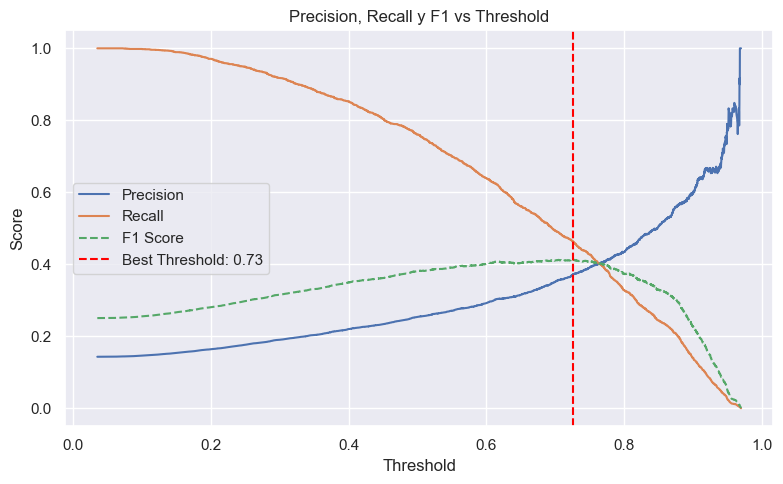

In [228]:
# Definir df_model desde df_cr 
variables_modelo = [
    'imc', 'imm', 'fat_percentage', 'muscle_mass_percentage', 'abdominal_perimeter',
    'edad', 'frecu_card_repos', 'frecu_card_max', 'tension_arte_dias','rango_edad',
    'tension_arte_sis', 'sede_uso', 'ciudad', 'category_sede_uso', 'region','nivel_actividad_time',
    'status_quote', 'Sedentarismo','sesiones_en_la_semana','minutos_por_semana','tipo_vinculacion','Departamento','ocupacion_validada',
    'Hipertensión', 'Dislipidemia', 'Obesidad', 'Antecedente Familiar', 'weight','height',
    'Diabetes', 'Enfermedad Pulmonar', 'Enfermedad Cardiovascular', 'Enfermedad Renal','Estrato','Cardiorisk',
    'Identifica Extranjero', 'tipo_diagnostico', 'genero', 'Tabaquismo'
]

# Crear máscara booleana de filas completas
mascara_completa = df_cr[variables_modelo].notna().all(axis=1)

# Aplicar máscara para sincronizar ambos DataFrames
df_model = df_cr.loc[mascara_completa, variables_modelo].reset_index(drop=True)
df_cr = df_cr.loc[mascara_completa].reset_index(drop=True)  # incluye 'user_id'

# 1. Selección de variables 
features_utiles = [
    'imm', 'fat_percentage', 'muscle_mass_percentage', 'abdominal_perimeter','tension_arte_sis','Sedentarismo','sesiones_en_la_semana','minutos_por_semana',
    'tipo_vinculacion','ocupacion_validada', 'Antecedente Familiar','imc' ,'Estrato', 'genero', 'Tabaquismo']  #'Departamento','tipo_diagnostico', 'Dislipidemia' , se añade estrato y se cambia 'weight','height'  


#    'imm', 'fat_percentage', 'muscle_mass_percentage', 'abdominal_perimeter','tension_arte_sis','Sedentarismo','sesiones_en_la_semana','minutos_por_semana',
# 'tipo_vinculacion','ocupacion_validada', 'Obesidad', 'Antecedente Familiar','weight','height',
# 'tipo_diagnostico', 'genero', 'Tabaquismo','Departamento', 'Dislipidemia', 


X = df_model[features_utiles]
y = df_model['Cardiorisk']
user_ids = df_cr['user_id']

# --- 2. División del conjunto antes del balanceo ---
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, user_ids, stratify=y, test_size=0.3, random_state=42
)

# --- 3. Preprocesamiento: Dummy y Label Encoding ---
from sklearn.preprocessing import LabelEncoder

def preprocess(df):
    df_prep = df.copy()

    # --- Convertir columnas tipo Sí/No a 1/0 ---
    columnas_binarias = ['Sedentarismo', 'Tabaquismo', 'Hipertensión', 'Diabetes', 
                         'Enfermedad Cardiovascular', 'Enfermedad Pulmonar',
                         'Enfermedad Renal', 'Dislipidemia', 'Obesidad', 'Antecedente Familiar']
    
    for col in columnas_binarias:
        if col in df_prep.columns:
            df_prep[col] = df_prep[col].map({'SI': 1, 'NO': 0})

    # --- Variables dicotómicas a dummies ---
    dicotomicas = ['genero']
    df_prep = pd.get_dummies(df_prep, columns=dicotomicas, drop_first=True)

    # --- Label encoding para categóricas ---
    categoricas = ['Estrato',
                   'tipo_vinculacion','ocupacion_validada']   #'Departamento', 
    le = LabelEncoder()
    for col in categoricas:
        df_prep[col] = le.fit_transform(df_prep[col].astype(str))

    return df_prep

X_train = preprocess(X_train)
X_test = preprocess(X_test)

#  Asegurar que X_test tenga las mismas columnas que X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# --- 4. Balanceo con SMOTEENN ---
smote_enn = SMOTEENN(random_state=42)
X_train_res_np, y_train_res = smote_enn.fit_resample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res_np, columns=X_train.columns)

# --- 5. Entrenar el modelo ---
modelo_final = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=2,
    num_leaves=5,
    min_child_samples=200,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=5.0,
    reg_lambda=10.0,
    random_state=32
)


modelo_final.fit(
    X_train_res, y_train_res,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=10)
    ]
)

# --- 6. Calcular umbral óptimo para F1 ---
y_proba = modelo_final.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
print(f" Umbral óptimo para F1: {best_threshold:.4f}")
print(f" Mejor F1-score: {f1_scores[best_idx]:.4f}")

# --- 7. Predicción con umbral óptimo ---
y_pred_opt = (y_proba >= 0.60).astype(int)

# --- 8. Resultados ---
df_resultado = pd.DataFrame({
    'user_id': ids_test.reset_index(drop=True),
    'Predicción Binaria': y_pred_opt,
    'Probabilidad Riesgo (%)': (y_proba * 100).round(2),
    'Real': y_test.reset_index(drop=True)
})

print(df_resultado.head())
print(f" ROC AUC: {roc_auc_score(y_test, y_proba)}")
print("Reporte de clasificación (con umbral óptimo):")
print(classification_report(y_test, y_pred_opt))
print(" Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_opt))

# --- 9. Curva Precision, Recall y F1 ---
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', linestyle='--')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall y F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###El F1 score (o puntaje F1) es una métrica evaluar el rendimiento útil cuando hay un desequilibrio entre clases 
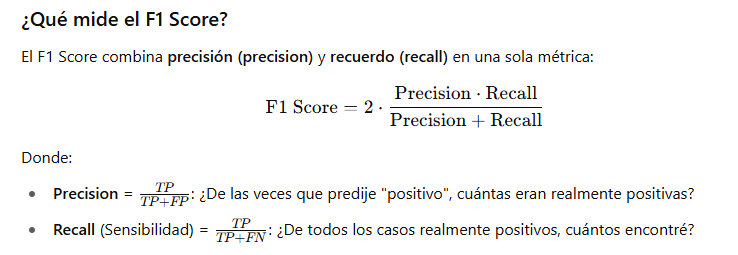

###Se define el "alto riesgo" solo cuando la probabilidad supera el valor que optimiza el equilibrio entre falsos positivos y falsos negativos (F1 en este caso)

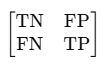
Donde:

TN (True Negatives) = 25,259 → Casos sin riesgo predichos correctamente como "sin riesgo"

FP (False Positives) = 778 → Casos sin riesgo predichos erróneamente como "con riesgo"

FN (False Negatives) = 1,002 → Casos con riesgo que el modelo no detectó (los marcó como "sin riesgo")

TP (True Positives) = 944 → Casos con riesgo correctamente identificados

In [229]:
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# --- 1. Evaluación en entrenamiento (conjunto original, no balanceado) ---
y_train_pred = modelo_final.predict(X_train)
y_train_proba = modelo_final.predict_proba(X_train)[:, 1]

print("# === RESULTADOS EN ENTRENAMIENTO (original) ===")
print(f"AUC-ROC: {roc_auc_score(y_train, y_train_proba):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_train, y_train_pred, digits=4))
print("Matriz de confusión:")
print(confusion_matrix(y_train, y_train_pred))

# --- 2. Evaluación en prueba ---
y_test_pred = modelo_final.predict(X_test)
y_test_proba = modelo_final.predict_proba(X_test)[:, 1]

print("\n# === RESULTADOS EN PRUEBA ===")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred, digits=4))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_test_pred))

# Conteo de clases predichas en entrenamiento
unique_train_pred, counts_train_pred = np.unique(y_train_pred, return_counts=True)
print("\nPredicciones finales en ENTRENAMIENTO:")
for u, c in zip(unique_train_pred, counts_train_pred):
    print(f"Clase {u}: {c}")

# Conteo de clases predichas en prueba
unique_test_pred, counts_test_pred = np.unique(y_test_pred, return_counts=True)
print("\nPredicciones finales en PRUEBA:")
for u, c in zip(unique_test_pred, counts_test_pred):
    print(f"Clase {u}: {c}")

# === RESULTADOS EN ENTRENAMIENTO (original) ===
AUC-ROC: 0.7680

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9401    0.6315    0.7555     31461
           1     0.2567    0.7598    0.3838      5270

    accuracy                         0.6499     36731
   macro avg     0.5984    0.6957    0.5697     36731
weighted avg     0.8421    0.6499    0.7022     36731

Matriz de confusión:
[[19869 11592]
 [ 1266  4004]]

# === RESULTADOS EN PRUEBA ===
AUC-ROC: 0.7628

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9398    0.6261    0.7515     13484
           1     0.2540    0.7604    0.3808      2258

    accuracy                         0.6453     15742
   macro avg     0.5969    0.6932    0.5662     15742
weighted avg     0.8414    0.6453    0.6983     15742

Matriz de confusión:
[[8442 5042]
 [ 541 1717]]

Predicciones finales en ENTRENAMIENTO:
Clase 0: 21135
Clase 1: 15596

Predicci

In [230]:
# --- 1. Copiar datos y preparar IDs ---
df_full = df_model[features_utiles].copy()
df_full_ids = df_cr['user_id'].reset_index(drop=True)
cardiorisk_real = df_model['Cardiorisk'].reset_index(drop=True)

# --- 2. Aplicar preprocesamiento igual al entrenamiento ---
df_full = preprocess(df_full)

#  Reindexar columnas como en X_train
df_full = df_full.reindex(columns=X_train.columns, fill_value=0)

# --- 3. Obtener umbral óptimo (ya calculado antes) ---
# y_proba_test = modelo_final.predict_proba(X_test)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)
# f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
# best_threshold = thresholds[f1_scores.argmax()]


print(f" Umbral óptimo aplicado: 60%")

# --- 4. Predecir sobre todo el dataset ---
proba_total = modelo_final.predict_proba(df_full)[:, 1]
pred_binaria = (proba_total >= 0.60).astype(int)

# --- 5. Crear DataFrame de salida ---
df_prediccion_total = pd.DataFrame({
    'user_id': df_full_ids,
    'Probabilidad Riesgo (%)': (proba_total * 100).round(2),
    'Predicción Binaria': pred_binaria,
    'Cardiorisk Real': cardiorisk_real
})

print(df_prediccion_total.head(50))

 Umbral óptimo aplicado: 60%
    user_id  Probabilidad Riesgo (%)  Predicción Binaria  Cardiorisk Real
0    444685                    90.18                   1                0
1    926426                    68.33                   1                0
2   1264358                    91.61                   1                1
3   1253247                    56.15                   0                0
4    187175                    20.27                   0                0
5    527619                    74.97                   1                1
6    276882                    57.07                   0                0
7     13020                    67.31                   1                1
8    397614                    83.95                   1                0
9   1276360                    30.32                   0                0
10  1226761                    82.96                   1                0
11   345346                    87.03                   1                1
12  12321

In [231]:
#df_prediccion_total.to_excel('predicionmodelo14_08_25v1.xlsx', index=False)

In [232]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from lightgbm import LGBMClassifier

# --- Preprocesar X ---
X_cv = preprocess(X)
X_cv = X_cv.reindex(columns=X_train.columns, fill_value=0)  # Asegurar columnas iguales

# --- Definir nuevo modelo sin entrenar ---
modelo_cv = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=2,
    num_leaves=5,
    min_child_samples=200,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=5.0,
    reg_lambda=10.0,
    random_state=32
)

# --- Validación cruzada ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
auc_scores = cross_val_score(modelo_cv, X_cv, y, cv=cv, scoring='roc_auc')

# --- Resultados ---
print("AUC promedio (CV):", auc_scores.mean())
print("AUC por fold:", auc_scores)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6022, number of negative: 35956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 41978, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143456 -> initscore=-1.786877
[LightGBM] [Info] Start training from score -1.786877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [233]:
df_cr['tipo_diagnostico'].value_counts()

tipo_diagnostico
No aplica         49283
Cardio             2695
Renal/Diabetes      495
Name: count, dtype: int64

In [234]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# --- 5. Añadir la variable real (target) ---
df_prediccion_total['Real'] = df_model['Cardiorisk']

# --- 6. Calcular métricas ---
print("ROC AUC:", roc_auc_score(df_prediccion_total['Real'], proba_total))
print(" Reporte de clasificación:")
print(classification_report(df_prediccion_total['Real'], df_prediccion_total['Predicción Binaria']))

print("Matriz de confusión:")
print(confusion_matrix(df_prediccion_total['Real'], df_prediccion_total['Predicción Binaria']))

ROC AUC: 0.7664520347752933
 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82     44945
           1       0.30      0.65      0.41      7528

    accuracy                           0.73     52473
   macro avg       0.61      0.69      0.61     52473
weighted avg       0.84      0.73      0.76     52473

Matriz de confusión:
[[33370 11575]
 [ 2670  4858]]


ROC AUC: 0.7664520347752933
Ranking report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82     44945
           1       0.30      0.65      0.41      7528

    accuracy                           0.73     52473
   macro avg       0.61      0.69      0.61     52473
weighted avg       0.84      0.73      0.76     52473

Matriz de confusión:


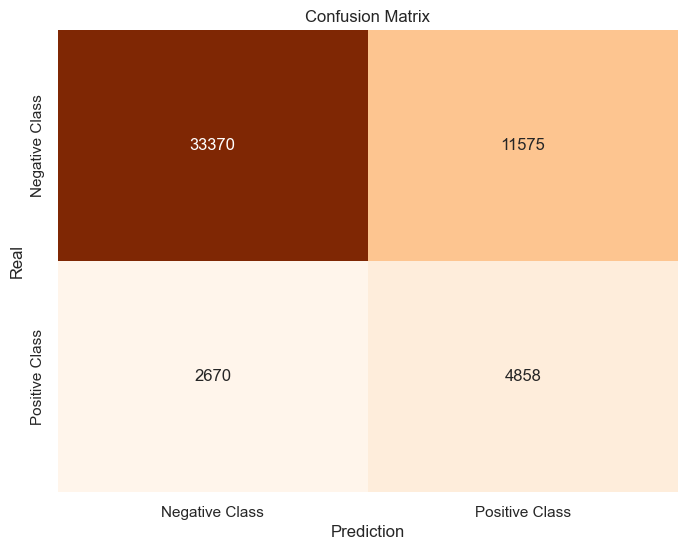

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Assuming df_prediccion_total and proba_total are defined correctly

# --- 6. Calcular métricas ---
# CORRECTED a typo in the function name roc_auc_score
print("ROC AUC:", roc_auc_score(df_prediccion_total['Real'], proba_total))
print("Ranking report:")
print(classification_report(df_prediccion_total['Real'], df_prediccion_total['Predicción Binaria']))

print("Matriz de confusión:")
cm = confusion_matrix(df_prediccion_total['Real'], df_prediccion_total['Predicción Binaria'])

# Visualizar la matriz de confusión con un mapa de calor naranja
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Negative Class', 'Positive Class'],
            yticklabels=['Negative Class', 'Positive Class'])
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

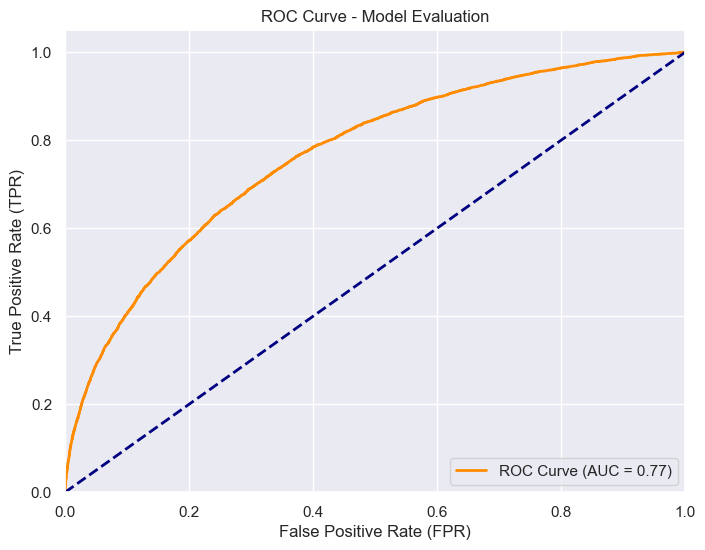

In [247]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- 1. Calcular FPR, TPR y thresholds ---
fpr, tpr, thresholds = roc_curve(df_prediccion_total['Real'], proba_total)

# --- 2. Calcular el AUC ---
roc_auc = auc(fpr, tpr)

# --- 3. Graficar la curva ROC ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea base
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Model Evaluation')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [237]:
#df_prediccion_total.to_excel('riegocard2608.xlsx', index=False)

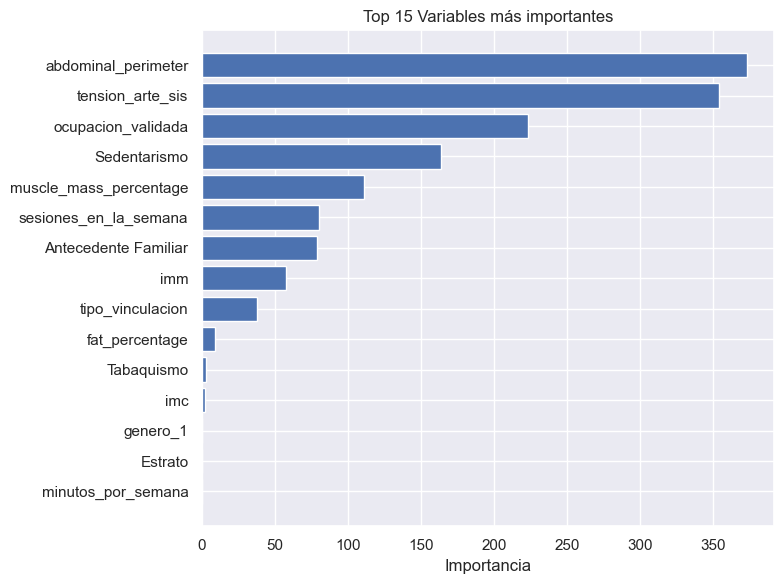

In [238]:
importances = modelo_final.feature_importances_
features = X_train.columns
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(8, 6))
plt.barh(features[sorted_idx][:15][::-1], importances[sorted_idx][:15][::-1])
plt.xlabel("Importancia")
plt.title("Top 15 Variables más importantes")
plt.tight_layout()
plt.show()

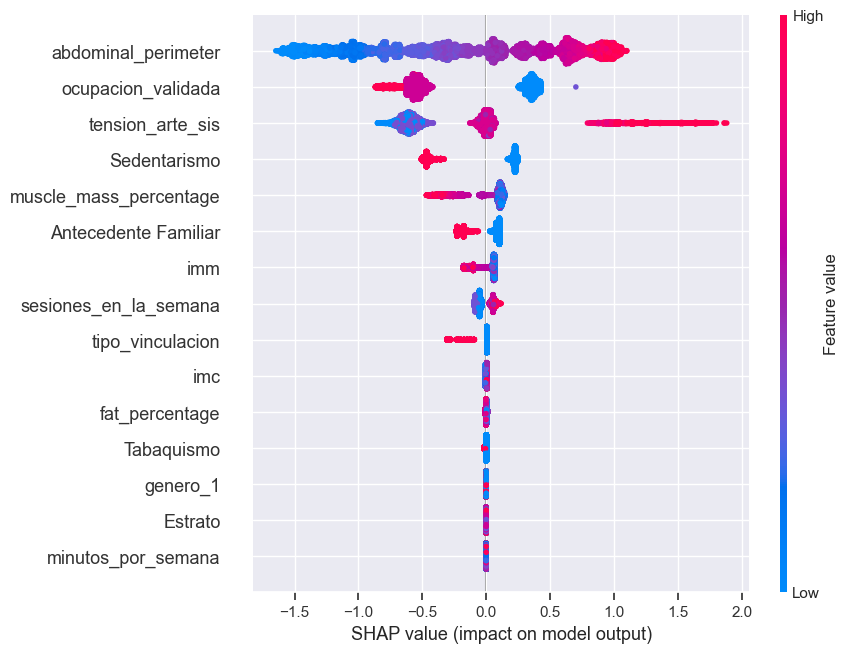

In [239]:
import shap

# 1. Inicializar el explainer SHAP con el modelo
explainer = shap.Explainer(modelo_final)

# 2. Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(X_test)

# 3. Visualizar la importancia global de las variables
shap.plots.beeswarm(shap_values, max_display=15)


In [240]:
def explicar_usuario(user_id_deseado, ids_test, shap_values):
    ids_test = ids_test.reset_index(drop=True)

    if user_id_deseado in ids_test.values:
        idx = ids_test[ids_test == user_id_deseado].index[0]
        shap.plots.waterfall(shap_values[idx])
    else:
        print(" El user_id {user_id_deseado} no está en el set de prueba.")

explicar_usuario(9594, ids_test, shap_values) #539549

 El user_id {user_id_deseado} no está en el set de prueba.


In [241]:
explainer = shap.Explainer(modelo_final)
shap_values_total = explainer(df_full)  # Recuerda: df_full ya está preprocesado y alineado

In [242]:
def explicar_usuario(user_id_deseado, df_prediccion_total, shap_values_total):
    df_pred = df_prediccion_total.reset_index(drop=True)
    user_id_str = str(user_id_deseado)
    df_pred['user_id'] = df_pred['user_id'].astype(str)

    if user_id_str in df_pred['user_id'].values:
        idx = df_pred[df_pred['user_id'] == user_id_str].index[0]

        print(f"\n User ID: {user_id_deseado}")
        print(f" Probabilidad de riesgo cardiovascular: {df_pred.loc[idx, 'Probabilidad Riesgo (%)']}%")
        print(f" Predicción del modelo: {df_pred.loc[idx, 'Predicción Binaria']}")
        print(f" Valor real observado: {df_pred.loc[idx, 'Cardiorisk Real']}")

        # Gráfica SHAP individual
        shap.plots.waterfall(shap_values_total[idx], max_display=10)
    else:
        print(f" El user_id {user_id_deseado} no está en df_prediccion_total.")



 User ID: 9594
 Probabilidad de riesgo cardiovascular: 94.85%
 Predicción del modelo: 1
 Valor real observado: 1


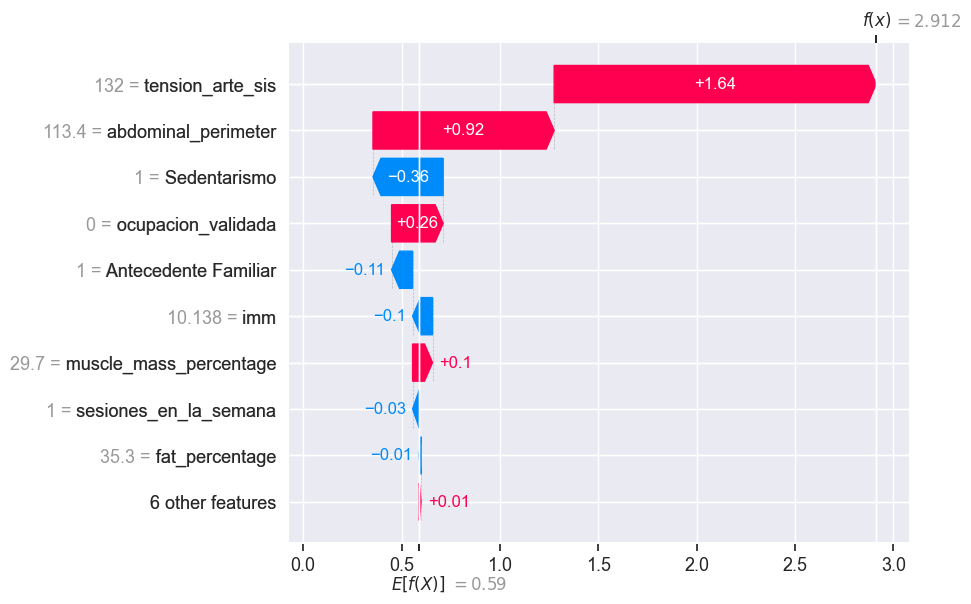

In [243]:
explicar_usuario(9594, df_prediccion_total, shap_values_total)

<Axes: xlabel='Cardiorisk', ylabel='abdominal_perimeter'>

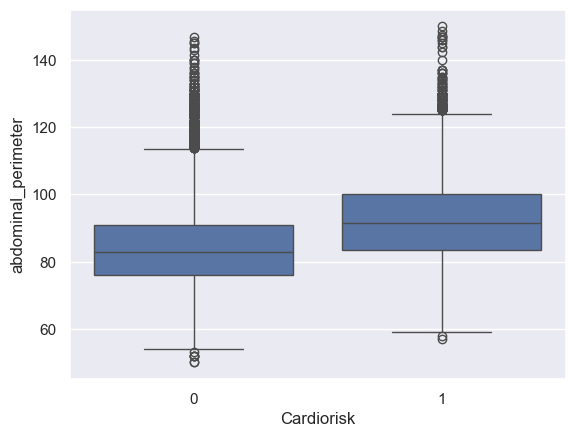

In [244]:
sns.boxplot(x='Cardiorisk', y='abdominal_perimeter', data=df_model)


In [245]:
#df_resultado.to_excel('riegocard.xlsx', index=False)

In [246]:
df()-0=

SyntaxError: cannot assign to expression (1937102330.py, line 1)

## Pipeline

In [ ]:
# ENTRENAMIENTO: crea un pipeline con preprocesamiento + modelo y guarda artefactos
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.combine import SMOTEENN
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score
import joblib, json
from pathlib import Path

# ===== 1) Datos y división =====
features_utiles = [
    'imm','fat_percentage','muscle_mass_percentage','abdominal_perimeter',
    'tension_arte_sis','Sedentarismo','sesiones_en_la_semana','minutos_por_semana',
    'tipo_vinculacion','ocupacion_validada','Antecedente Familiar','imc',
    'Estrato','genero','Tabaquismo']

X = df_model[features_utiles].copy()
y = df_model['Cardiorisk'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

#  (2.1) estandarizar binarios SI/NO antes del pipeline   
bin_cols = ['Sedentarismo','Tabaquismo','Antecedente Familiar']
for c in bin_cols:
    # pasa a string, quita espacios, mayúsculas; unifica 'SÍ' con tilde -> 'SI'
    X_train.loc[:, c] = (
        X_train[c].astype(str).str.strip().str.upper().replace({'SÍ': 'SI'})
    )
    X_test.loc[:, c] = (
        X_test[c].astype(str).str.strip().str.upper().replace({'SÍ': 'SI'})
    )


#  2) Preprocesamiento declarativo 
num_cols = [
    'imm','fat_percentage','muscle_mass_percentage','abdominal_perimeter',
    'tension_arte_sis','sesiones_en_la_semana','minutos_por_semana','imc'
]
onehot_cols = ['genero']
ord_cols = ['Estrato','tipo_vinculacion','ocupacion_validada']

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        # binarios SI/NO -> ordinal; usa unknown_value=-1 para evitar conflicto con 0
        ('bin', OrdinalEncoder(
            categories=[['NO','SI']]*len(bin_cols),
            handle_unknown='use_encoded_value', unknown_value=-1
        ), bin_cols),
        ('oh', OneHotEncoder(drop='first', handle_unknown='ignore'), onehot_cols),
        ('ord', OrdinalEncoder(
            handle_unknown='use_encoded_value', unknown_value=-1
        ), ord_cols),
    ],
    remainder='drop'
)

#  3) Pipeline con balanceo SOLO en entrenamiento 
# Nota: SMOTEENN actúa en .fit(), en .predict() NO re-muestrea.
clf = LGBMClassifier(
    n_estimators=500, learning_rate=0.01, max_depth=2, num_leaves=5,
    min_child_samples=200, subsample=0.7, colsample_bytree=0.8,
    reg_alpha=5.0, reg_lambda=10.0, random_state=32
)

pipe = ImbPipeline(steps=[
    ('prep', preprocess),
    ('balance', SMOTEENN(random_state=42)),
    ('model', clf)
])

pipe.fit(X_train, y_train)

# ===== 4) Umbral óptimo (F1) y métricas =====
proba_test = pipe.predict_proba(X_test)[:, 1]
threshold_fijo = 0.6
y_pred_cust = (proba_test >= threshold_fijo).astype(int)

print("AUC:", roc_auc_score(y_test, proba_test))
print("Precision:", precision_score(y_test, y_pred_cust))
print("Recall:", recall_score(y_test, y_pred_cust))
print("F1 Score:", f1_score(y_test, y_pred_cust))
print("Umbral fijo:", threshold_fijo)

#  5) Guardar artefactos 
ART = Path("artefactos_rcv_simple")
ART.mkdir(exist_ok=True)
joblib.dump(pipe, ART / "pipeline_modelo.joblib")

# Guardar el umbral fijo como texto
with open(ART / "threshold_fijo.txt", "w") as f:
    f.write(str(threshold_fijo))
# (No necesitas guardar columnas ni encoders: TODO vive dentro del pipeline)

[LightGBM] [Info] Number of positive: 28877, number of negative: 19086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 47963, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.602068 -> initscore=0.414090
[LightGBM] [Info] Start training from score 0.414090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: